In [ ]:
'''
MIT License

Copyright (c) 2021 Valentin Gorbunov

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.
'''

'\nMIT License\n\nCopyright (c) 2021 Valentin Gorbunov\n\nPermission is hereby granted, free of charge, to any person obtaining a copy\nof this software and associated documentation files (the "Software"), to deal\nin the Software without restriction, including without limitation the rights\nto use, copy, modify, merge, publish, distribute, sublicense, and/or sell\ncopies of the Software, and to permit persons to whom the Software is\nfurnished to do so, subject to the following conditions:\n\nThe above copyright notice and this permission notice shall be included in all\ncopies or substantial portions of the Software.\n\nTHE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR\nIMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,\nFITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE\nAUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER\nLIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING

## Environment Set Up

In [ ]:
# Install packages not in Colab by default
!pip install vaderSentiment
!pip install textstat
!pip install flwr

In [ ]:
# Import packages
import pickle
import sys
import string
import re
import nltk
import seaborn
import os
import time
import warnings
import random
import threading
import scipy
import json
import nltk.stem.porter
import pandas as pd
import numpy as np
import flwr as fl
import matplotlib.pyplot as plt
from matplotlib import rcParams
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report, confusion_matrix, log_loss, precision_recall_fscore_support
from sklearn.model_selection import train_test_split, StratifiedKFold
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer as VS
from textstat.textstat import *
from typing import Tuple, Union, List, Dict, Optional
from flwr.server.criterion import Criterion
from flwr.server.client_proxy import ClientProxy
from flwr.common import Weights, FitRes, Parameters, Scalar, parameters_to_weights, weights_to_parameters
from google.colab import drive
from multiprocessing import Process, Manager
from multiprocessing.managers import ListProxy
from math import ceil
from statistics import mean
from datetime import datetime
from functools import reduce
import textwrap
%matplotlib inline

In [ ]:
# Mount external storage
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Configure global search paths
HOME_DIR = "/content/drive/MyDrive/"
LOGGING_FOLDERS_DIR = HOME_DIR + "Logging_Folders/"

## Centralized Manual Pipeline

In [ ]:
'''
Rewritten from:

Title: Automated Hate Speech Detection and the Problem of Offensive Language.ipynb
Authors: Davidson et al.
Date: Mar 29, 2019
Availability: https://github.com/t-davidson/hate-speech-and-offensive-language/blob/master/src/Automated%20Hate%20Speech%20Detection%20and%20the%20Problem%20of%20Offensive%20Language.ipynb

'''

'\nRewritten from:\n\nTitle: Automated Hate Speech Detection and the Problem of Offensive Language.ipynb\nAuthors: Davidson et al.\nDate: Mar 29, 2019\nAvailability: https://github.com/t-davidson/hate-speech-and-offensive-language/blob/master/src/Automated%20Hate%20Speech%20Detection%20and%20the%20Problem%20of%20Offensive%20Language.ipynb\n\n'

### Preliminary Data Analysis

In [ ]:
# Deserialize Pandas DataFrame from pickle file
df = pd.read_pickle(open(HOME_DIR + "labeled_data.p", mode='rb'))

In [ ]:
# Describe content, size and format of the data
df

count  hate_speech  offensive_language  neither class  \
0          3            0                   0        3     2   
1          3            0                   3        0     1   
2          3            0                   3        0     1   
3          3            0                   2        1     1   
4          6            0                   6        0     1   
...      ...          ...                 ...      ...   ...   
25291      3            0                   2        1     1   
25292      3            0                   1        2     2   
25294      3            0                   3        0     1   
25295      6            0                   6        0     1   
25296      3            0                   0        3     2   

                                                   tweet  
0      !!! RT @mayasolovely: As a woman you shouldn't...  
1      !!!!! RT @mleew17: boy dats cold...tyga dwn ba...  
2      !!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...  
3      !!!!!!!!! RT @C_G_Anderson: @viva_based she lo...  
4      !!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...  
...                                                  ...  
25291  you's a muthaf***in lie &#8220;@LifeAsKing: @2...  
25292  you've gone and broke the wrong heart baby, an...  
25294  young buck wanna eat!!.. dat nigguh like I ain...  
25295              youu got wild bitches tellin you lies  
25296  ~~Ruffled | Ntac Eileen Dahlia - Beautiful col...  

[24783 rows x 6 columns]

In [ ]:
# Generate descriptive statistics
df.describe()

count   hate_speech  offensive_language       neither
count  24783.000000  24783.000000        24783.000000  24783.000000
mean       3.243473      0.280515            2.413711      0.549247
std        0.883060      0.631851            1.399459      1.113299
min        3.000000      0.000000            0.000000      0.000000
25%        3.000000      0.000000            2.000000      0.000000
50%        3.000000      0.000000            3.000000      0.000000
75%        3.000000      0.000000            3.000000      0.000000
max        9.000000      7.000000            9.000000      9.000000

In [ ]:
# Get feature names 
df.columns

Index(['count', 'hate_speech', 'offensive_language', 'neither', 'class',
       'tweet'],
      dtype='object')

Key:

count = number of CrowdFlower users who coded each tweet (at least 3; more users coded a tweet when judgments were determined to be unreliable by CF)


hate_speech = number of CF users who coded the tweet as hate speech


offensive_language = number of CF users who coded the tweet as offensive but not hate speech


neither = number of CF users who coded the tweet as neither offensive nor hate speech


class = class label determined by majority rule:

* 0 : hate speech
* 1 : offensive  language
* 2 : neither

tweet = tweet text


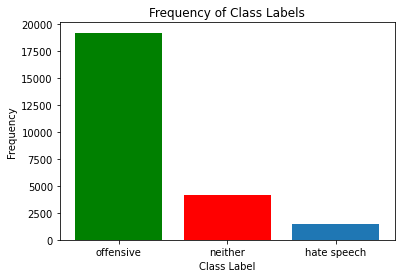

In [ ]:
# Plot distribution of samples across classes
labels = df['class']
bins = ['offensive', 'neither', 'hate speech']

y_pos = np.arange(len(bins))
value_counts = labels.value_counts()

plt.bar(y_pos, value_counts, align='center', color=['g', 'r', '#1f77b4'])

plt.xticks(y_pos, bins)
plt.xlabel("Class Label")
plt.ylabel("Frequency")
plt.title("Frequency of Class Labels")

plt.show()

The bar chart shows the imbalanced nature of the classification problem; most tweets containing "hateful" words, as defined by Hatebase, were coded as offensive by CF coders. More tweets were considered neither hate speech nor offensive than were considered hate speech.

### Data Preprocessing

In [ ]:
# Select data for preprocessing and transformation
tweets=df.tweet

In [ ]:
# Create list of stopwords 
nltk.download('stopwords')
stopwords = nltk.corpus.stopwords.words("english")
other_exclusions = ["#ff", "ff", "rt"]
stopwords.extend(other_exclusions)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# Create reusable stemmer
stemmer = nltk.stem.porter.PorterStemmer()

In [ ]:
# Define functions for preprocessing data
def preprocess(text_string):
    """
    Accepts a text string and replaces:
    1) urls with URLHERE
    2) lots of whitespace with one instance
    3) mentions with MENTIONHERE

    This allows us to get standardized counts of urls and mentions
    Without caring about specific people mentioned
    """
    space_pattern = '\s+'
    giant_url_regex = ('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
        '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    mention_regex = '@[\w\-]+'
    parsed_text = re.sub(space_pattern, ' ', text_string)
    parsed_text = re.sub(giant_url_regex, '', parsed_text)
    parsed_text = re.sub(mention_regex, '', parsed_text)
    return parsed_text

def tokenize(tweet):
    """Removes punctuation & excess whitespace, sets to lowercase,
    and stems tweets. Returns a list of stemmed tokens."""
    tweet = " ".join(re.split("[^a-zA-Z]*", tweet.lower())).strip()
    tokens = [stemmer.stem(t) for t in tweet.split()]
    return tokens

def basic_tokenize(tweet):
    """Same as tokenize but without the stemming"""
    tweet = " ".join(re.split("[^a-zA-Z.,!?]*", tweet.lower())).strip()
    return tweet.split()

### Feature Engineering

####Automatic Feature Extraction



In [ ]:
# Construct tfidf matrix and get relevant scores
vectorizer = TfidfVectorizer(
    tokenizer=tokenize,
    preprocessor=preprocess,
    ngram_range=(1, 3),
    stop_words=stopwords,
    use_idf=True,
    smooth_idf=False,
    norm=None,
    decode_error='replace',
    max_features=10000,
    min_df=5,
    max_df=0.75
    )

tfidf = vectorizer.fit_transform(tweets).toarray()
vocab = {v:i for i, v in enumerate(vectorizer.get_feature_names_out())}
idf_vals = vectorizer.idf_
idf_dict = {i:idf_vals[i] for i in vocab.values()} #keys are indices; values are IDF scores

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['b', 'c', 'e', 'f', 'g', 'h', 'j', 'l', 'n', 'p', 'r', 'u', 'v', 'w'] not in stop_words.
  % sorted(inconsistent)


In [ ]:
# Get POS tags for tweets and save as a string
nltk.download('averaged_perceptron_tagger')
tweet_tags = []
for t in tweets:
    tokens = basic_tokenize(preprocess(t))
    tags = nltk.pos_tag(tokens)
    tag_list = [x[1] for x in tags]
    tag_str = " ".join(tag_list)
    tweet_tags.append(tag_str)

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [ ]:
# Construct POS TF matrix and get vocab dict
pos_vectorizer = TfidfVectorizer(
    tokenizer=None,
    lowercase=False,
    preprocessor=None,
    ngram_range=(1, 3),
    stop_words=None,
    use_idf=False,
    smooth_idf=False,
    norm=None,
    decode_error='replace',
    max_features=5000,
    min_df=5,
    max_df=0.75,
    )

pos = pos_vectorizer.fit_transform(pd.Series(tweet_tags)).toarray()
pos_vocab = {v:i for i, v in enumerate(pos_vectorizer.get_feature_names_out())}

#### Manual Feature Construction

In [ ]:
# Create reusable sentiment analyzer
sentiment_analyzer = VS()

In [ ]:
# Define functions for devising features
def count_twitter_objs(text_string):
    """
    Accepts a text string and replaces:
    1) urls with URLHERE
    2) lots of whitespace with one instance
    3) mentions with MENTIONHERE
    4) hashtags with HASHTAGHERE

    This allows us to get standardized counts of urls and mentions
    Without caring about specific people mentioned.
    
    Returns counts of urls, mentions, and hashtags.
    """
    space_pattern = '\s+'
    giant_url_regex = ('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
        '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    mention_regex = '@[\w\-]+'
    hashtag_regex = '#[\w\-]+'
    parsed_text = re.sub(space_pattern, ' ', text_string)
    parsed_text = re.sub(giant_url_regex, 'URLHERE', parsed_text)
    parsed_text = re.sub(mention_regex, 'MENTIONHERE', parsed_text)
    parsed_text = re.sub(hashtag_regex, 'HASHTAGHERE', parsed_text)
    return(parsed_text.count('URLHERE'),parsed_text.count('MENTIONHERE'),parsed_text.count('HASHTAGHERE'))

def other_features(tweet):
    """This function takes a string and returns a list of features.
    These include Sentiment scores, Text and Readability scores,
    as well as Twitter specific features"""
    sentiment = sentiment_analyzer.polarity_scores(tweet)
    
    words = preprocess(tweet) # Get text only
    
    syllables = textstat.syllable_count(words)
    num_chars = sum(len(w) for w in words)
    num_chars_total = len(tweet)
    num_terms = len(tweet.split())
    num_words = len(words.split())
    avg_syl = round(float((syllables+0.001))/float(num_words+0.001),4)
    num_unique_terms = len(set(words.split()))
    
    # Modified FK grade, where avg words per sentence is just num words/1
    FKRA = round(float(0.39 * float(num_words)/1.0) + float(11.8 * avg_syl) - 15.59,1)
    # Modified FRE score, where sentence fixed to 1
    FRE = round(206.835 - 1.015*(float(num_words)/1.0) - (84.6*float(avg_syl)),2)
    
    twitter_objs = count_twitter_objs(tweet)
    retweet = 0
    if "rt" in words:
        retweet = 1
    features = [FKRA, FRE,syllables, avg_syl, num_chars, num_chars_total, num_terms, num_words,
                num_unique_terms, sentiment['neg'], sentiment['pos'], sentiment['neu'], sentiment['compound'],
                twitter_objs[2], twitter_objs[1],
                twitter_objs[0], retweet]
    return features

def get_feature_array(tweets):
    feats=[]
    for t in tweets:
        feats.append(other_features(t))
    return np.array(feats)

In [ ]:
# Construct features
other_feats = get_feature_array(tweets)

### Feature Selection

In [ ]:
# Join automatically extracted features and manually constructed features together
X = np.concatenate([tfidf,pos,other_feats],axis=1)

In [ ]:
# Get dimensions of the data
X.shape

(24783, 4023)

The data is high dimensional. There is an exponential decrease in predictive power for each additional variable in a multivariate model, known as the curse of dimensionality. Therefore, the dimensionality of the data should be reduced.

### Model Training

In [ ]:
# Encode class labels
y = df['class'].astype(int)

In [ ]:
# Reduce dimensionality of data. Specify solver as 'liblinear' because default solver changed to 'lbfgs' in 0.22.
feature_transformer = SelectFromModel(LogisticRegression(class_weight='balanced',penalty="l1", C=0.01, solver='liblinear'))

X_ = feature_transformer.fit_transform(X,y)

In [ ]:
# Get reduced dimensions of the data
X_.shape

(24783, 464)

In [ ]:
# Generate train/test split of 9/1. Initialise with random seed for reproducability.
X_train, X_test, y_train, y_test = train_test_split(X_, y, random_state=42, test_size=0.1, stratify=y)

As classification problem is imbalanced, it's desirable for the train/test split to preserve the same proportions of examples in each class as observed in the original dataset [(Brownlee, 2020)](https://machinelearningmastery.com/train-test-split-for-evaluating-machine-learning-algorithms//).

In [ ]:
# Create model. Change hyperparameters to ensure control variables remain constant. Change solver to the new default solver, lbfgs.
# Increase `max_iter` as lbfgs takes longer to converge. Change framework used for multi class classification to multinomial.
# See comments in `start_flower_client` for details.
classifier = LogisticRegression(class_weight='balanced',penalty='l2', C=0.01, max_iter=20000, multi_class="multinomial")

In [ ]:
# Train model
model = classifier.fit(X_train, y_train)

### Model Testing

In [ ]:
# Test model
y_preds = model.predict(X_test)

In [ ]:
# Generate test report
report = classification_report(y_test, y_preds)
print(report.rsplit("\n",2)[0])

              precision    recall  f1-score   support

           0       0.24      0.69      0.36       143
           1       0.96      0.74      0.84      1920
           2       0.61      0.86      0.72       416

    accuracy                           0.76      2479
   macro avg       0.61      0.77      0.64      2479


There is a class-imbalance in the dataset; the hate speech class (0) and neither class (2) are most important to get right, and they are under-represented. Offensive language class (1) is over-represented. Therefore, macro average is preferable over weighted average, which is misleading [(Khalusova, 2021)](https://www.mariakhalusova.com/posts/2019-04-17-ml-model-evaluation-metrics-p2/#micro--macro--weighted-averaged-precision).

F1-score is used rather than AUROC because AUROC averages over all possible discrimination thresholds, which is misleading in the case of class-imbalanced data [(2018, Almardeny)](https://stackoverflow.com/questions/44172162/f1-score-vs-roc-auc). In contrast, F-1 score maintains a balance between Precision and Recall.

In [ ]:
# Define function for plotting confusion matrix
def plot_confusion_matrix(y, y_preds):

  matrix = confusion_matrix(y,y_preds)
  matrix_proportions = np.zeros((3,3))
  for i in range(0,3):
    matrix_proportions[i,:] = matrix[i,:]/float(matrix[i,:].sum())
  names=['Hate','Offensive','Neither']
  confusion_df = pd.DataFrame(matrix_proportions, index=names,columns=names)
  plt.figure(figsize=(5,5))
  seaborn.heatmap(confusion_df,annot=True,annot_kws={"size": 12},cmap='gist_gray_r',cbar=False, square=True,fmt='.2f')
  plt.ylabel(r'True categories',fontsize=14)
  plt.xlabel(r'Predicted categories',fontsize=14)
  plt.tick_params(labelsize=12)

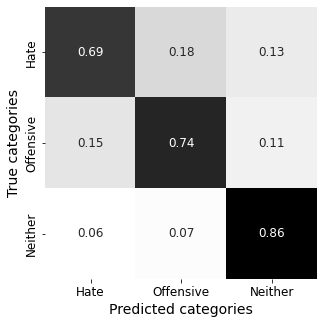

In [ ]:
# Plot confusion matrix
plot_confusion_matrix(y_test,y_preds)

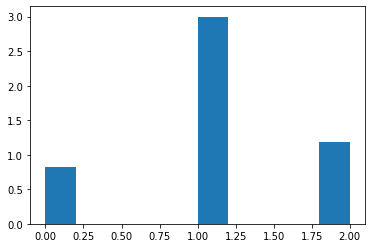

In [ ]:
# Plot distribution of estimates. Set the density parameter to True to normalize bin heights so that the integral of the histogram is 1.
# The resulting histogram is an approximation of the probability density function. This facilitates comparison between the distribution 
# of estimates and true distribution.
plt.hist(y_preds, density=True)
plt.show()

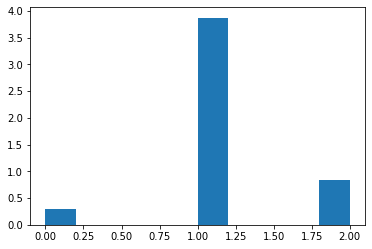

In [ ]:
# Plot true distribution
plt.hist(y, density=True)
plt.show()

# Design of Single-Machine Simulation of Federated Learning System

We use a controlled environment that is suitable for experiments. We assume
a synchronous update scheme that proceeds in rounds of
communication. There is a fixed set of $K$ clients, each
with a fixed local dataset. At the beginning of each round,
a fraction of random clients are selected, and the server
sends the current global model parameters to each of these clients. Each selected client then trains its local model on its local dataset, and sends an
update to the server. The server then applies these updates
to the global model, and the cycle repeats [(McMahan et al., 2017)](https://arxiv.org/pdf/1602.05629.pdf). In our simulation, of cross-silo FL, all clients are selected for each round of federated learning.

## Federated Evaluation

There are two main approaches to evaluate models in a federated learning system: centralized evaluation and federated evaluation. In centralized evaluation, the aggregated model is validated on the server-side, and the validation set is sampled from the population's probability distribution. In federated evaluation, the aggregated model is validated on the client-side, and the validation set is sampled from the same probability distribution as the client's training set [(Adap GmbH, 2022)](https://flower.dev/docs/evaluation.html).

We focus on federated evaluation as it's typically used in real-world applications.

In [ ]:
# Initialize global experiment config
DATA_PARTITIONING_STRATEGY = ""
DATA_PARTITIONING_RANDOM_SEED = 0
DIRICHLET_DISTRIBUTION_PARAM = 10
NUMBER_OF_CLIENTS = 10
MIN_AVAILABLE_CLIENTS = NUMBER_OF_CLIENTS
NUMBER_OF_FL_ROUNDS = 50
LOCAL_EPOCHS = ceil(1500 / NUMBER_OF_FL_ROUNDS)
MIN_FIT_CLIENTS = NUMBER_OF_CLIENTS
FRACTION_FIT = 1.0
FRACTION_FIT_RANDOM_SEED = 1
MIN_EVAL_CLIENTS = NUMBER_OF_CLIENTS
FRACTION_EVAL = 1.0
EVAL_STRATEGY = "federated"
DATA_SHARING = False
NUMBER_OF_OBSERVATIONS_SELECTED_WITH_DATA_PARTITIONING_STRATEGY = 10
NUMBER_OF_VALIDATION_FOLDS = 10
NUMBER_OF_REPEATS = NUMBER_OF_OBSERVATIONS_SELECTED_WITH_DATA_PARTITIONING_STRATEGY * NUMBER_OF_VALIDATION_FOLDS
LOG_DIR = ""

Key:

DATA_PARTITIONING_STRATEGY - strategy for distributing samples across clients

DATA_PARTITIONING_RANDOM_SEED - seed to initialize random data partition generator, set for experimental control and reproducability

DIRICHLET_DISTRIBUTION_PARAM - distribution parameter of the Dirichlet distribution, used in particular data partitioning strategies to control degree of imbalance

NUMBER_OF_CLIENTS - total number of clients participating in the FL

MIN_AVAILABLE_CLIENTS - minimum number of clients that must be connected to the server before FL can begin

NUMBER_OF_FL_ROUNDS - number of FL rounds, set to a sufficiently large number so that the performance of the FL system can be observed

LOCAL_EPOCHS - number of complete passes over local training data performed by clients during a training round, limited by the maximum number of iterations taken for the solvers to converge and the number of FL rounds, so that the performance of the FL system can be observed

MIN_FIT_CLIENTS - minimum number of clients used during training

FRACTION_FIT - fraction of random clients selected to participate in a training round

FRACTION_FIT_RANDOM_SEED - seed for initializing the random sampling used to select clients for participation in a training round, set for experimental control and reproducability

MIN_EVAL_CLIENTS - minimum number of clients used during evaluation

FRACTION_EVAL - fraction of random clients selected to participate in an evaluation round

EVAL_STRATEGY - there are two main approaches to evaluate models in federated learning systems: centralized (server-side) evaluation and federated (client-side) evaluation

DATA_SHARING - whether or not to use a data-sharing strategy [(Zhao et al., 2018)](https://arxiv.org/pdf/1806.00582.pdf) to improve training on non-IID data

NUMBER_OF_OBSERVATIONS_SELECTED_WITH_DATA_PARTITIONING_STRATEGY - number of observations drawn using each data partitioning strategy

NUMBER_OF_VALIDATION_FOLDS - number of folds used in cross-validation

NUMBER_OF_REPEATS - total number of experiment repeats

LOG_DIR - folder in which to log experiments

## Utility Functions

In [ ]:
LogRegParams = Tuple[np.ndarray, np.ndarray]

def get_model_parameters(model: LogisticRegression) -> LogRegParams:
#Returns the paramters of a sklearn LogisticRegression model.
    params = (model.coef_, model.intercept_)
    return params


def set_model_params(model: LogisticRegression, params: LogRegParams) -> LogisticRegression:
#Sets the parameters of a sklean LogisticRegression model.
    model.coef_ = params[0]
    model.intercept_ = params[1]
    return model


def set_initial_params(model: LogisticRegression):
#Sets initial parameters as zeros Required since model params are
#uninitialized until model.fit is called.
#But server asks for initial parameters from clients at launch. Refer
#to sklearn.linear_model.LogisticRegression documentation for more
#information.

    if DATA_SHARING:
      model.classes_ = warm_up_model.classes_
      model.coef_ = warm_up_model.coef_
      model.intercept_ = warm_up_model.intercept_
    else:
      n_classes = 3
      n_features = X_.shape[1]  # Number of features in dataset after feature selection by transformer

      model.classes_ = np.array([i for i in range(n_classes)])
      model.coef_ = np.zeros((n_classes, n_features))
      model.intercept_ = np.zeros((n_classes,))

def get_partitions(x, y):

    '''
    Rewritten from:

    Title: NIID-Bench
    Authors: Li et al.
    Date: Nov 17, 2021
    Availability: https://github.com/Xtra-Computing/NIID-Bench/blob/main/utils.py

    '''

    np.random.seed(DATA_PARTITIONING_RANDOM_SEED)

    n_train = y.shape[0]

    if DATA_PARTITIONING_STRATEGY == "iid":
        idxs = np.random.permutation(n_train)
        batch_idxs = np.array_split(idxs, NUMBER_OF_CLIENTS)
        net_dataidx_map = {i: batch_idxs[i] for i in range(NUMBER_OF_CLIENTS)}
    elif DATA_PARTITIONING_STRATEGY == "noniid-distribution-based-label-imbalance":
        min_size = 0
        min_require_size = 10
        K = 3
        N = y.shape[0]
        net_dataidx_map = {}

        while min_size < min_require_size:
            idx_batch = [[] for _ in range(NUMBER_OF_CLIENTS)]

            for k in range(K):
                idx_k = np.where(y == k)[0]
                np.random.shuffle(idx_k)
                proportions = np.random.dirichlet(np.repeat(DIRICHLET_DISTRIBUTION_PARAM, NUMBER_OF_CLIENTS))
                proportions = np.array([p * (len(idx_j) < N / NUMBER_OF_CLIENTS) for p, idx_j in zip(proportions, idx_batch)])
                proportions = proportions / proportions.sum()
                proportions = (np.cumsum(proportions) * len(idx_k)).astype(int)[:-1]
                idx_batch = [idx_j + idx.tolist() for idx_j, idx in zip(idx_batch, np.split(idx_k, proportions))]
                min_size = min([len(idx_j) for idx_j in idx_batch])

        for j in range(NUMBER_OF_CLIENTS):
            np.random.shuffle(idx_batch[j])
            net_dataidx_map[j] = idx_batch[j]
    elif DATA_PARTITIONING_STRATEGY == "noniid-quantity-based-label-imbalance-1" or DATA_PARTITIONING_STRATEGY == "noniid-quantity-based-label-imbalance-2":
        num = int(DATA_PARTITIONING_STRATEGY[38]) # number of distinct labels per client
        K = 3 # total number of labels
        times = [0 for _ in range(K)] # holds the number of parties to which each label ID is assigned
        contain = [[] for _ in range(NUMBER_OF_CLIENTS)] # holds the buckets of num label IDs assigned to each party

        for i in range(K): # ensure each label ID is assigned
            bucket = contain[np.random.randint(NUMBER_OF_CLIENTS)]
            while len(bucket) == num:
                bucket = contain[np.random.randint(NUMBER_OF_CLIENTS)]
            bucket.append(i)
            times[i] += 1

        for bucket in contain: # randomly assign num different distinct label IDs to each party
            j = len(bucket)
            while j < num:
                ind = np.random.randint(K)
                if ind not in bucket:
                    bucket.append(ind)
                    times[ind] += 1
                    j += 1

        net_dataidx_map ={i: np.ndarray(0, dtype=np.int64) for i in range(NUMBER_OF_CLIENTS)}

        # For the samples of each label, randomly and equally divide them into the parties
        # which own the label, such that there is no overlap between the samples of different parties
        for i in range(K):
            idx_k = np.where(y == i)[0]
            np.random.shuffle(idx_k)
            split = np.array_split(idx_k,times[i])
            ids = 0
            for j in range(NUMBER_OF_CLIENTS):
                if i in contain[j]:
                    net_dataidx_map[j]=np.append(net_dataidx_map[j],split[ids])
                    ids += 1

    elif DATA_PARTITIONING_STRATEGY == "iid-quantity-skew":
        idxs = np.random.permutation(n_train)
        min_size = 0
        while min_size < 10:
            proportions = np.random.dirichlet(np.repeat(DIRICHLET_DISTRIBUTION_PARAM, NUMBER_OF_CLIENTS))
            proportions = proportions/proportions.sum()
            min_size = np.min(proportions*len(idxs))
        proportions = (np.cumsum(proportions)*len(idxs)).astype(int)[:-1]
        batch_idxs = np.split(idxs, proportions)
        net_dataidx_map = {i: batch_idxs[i] for i in range(NUMBER_OF_CLIENTS)}

    partitioned_train_set = [(x[net_dataidx_map[idx]], pd.Series(y[net_dataidx_map[idx]])) for idx in range(NUMBER_OF_CLIENTS)]

    return partitioned_train_set


def get_train_partitions(x_train, y_train):
  partitioned_train_set = []
  
  if DATA_SHARING:
    partitioned_train_set = get_partitions(X_train_client, y_train_client.to_numpy())
    # a random α portion of G is merged with the data of each client
    partitioned_train_set = [(np.concatenate((X_train_partition, X_train_shared)), pd.concat((y_train_partition, y_train_shared))) for X_train_partition, y_train_partition in partitioned_train_set]
  else:
    partitioned_train_set = get_partitions(x_train, y_train)

  return partitioned_train_set


def get_test_partitions(x_test, y_test, partitioned_train_set):
  partitioned_test_set = []

  if DATA_PARTITIONING_STRATEGY == "noniid-distribution-based-label-imbalance" or DATA_PARTITIONING_STRATEGY == "iid-quantity-skew":
    # Grody estimate of distribution

    np.random.seed(DATA_PARTITIONING_RANDOM_SEED)
    
    net_dataidx_map = {i: np.ndarray(0, dtype=np.int64) for i in range(NUMBER_OF_CLIENTS)}

    total_label_freqs = 0

    if DATA_SHARING:
      total_label_freqs = y_train_client.value_counts()
    else:
      total_label_freqs = y_train.value_counts()

    for i in range(3):
      idx_i = np.where(y_test == i)[0]
      np.random.shuffle(idx_i)

      indices = []

      offset = 0

      for j in range(NUMBER_OF_CLIENTS - 1):
        partition_label_proportion = partitioned_train_set[j][1].value_counts().reindex(range(3), fill_value=0)[i] / total_label_freqs[i]
        partition_label_freq = int(len(idx_i )*partition_label_proportion)
        split_index = offset + partition_label_freq
        indices.append(split_index)
        offset = split_index
      
      split = np.array_split(idx_i, indices)

      for j in range(NUMBER_OF_CLIENTS):
        net_dataidx_map[j]=np.append(net_dataidx_map[j],split[j])

    partitioned_test_set = [(x_test[net_dataidx_map[idx]], pd.Series(y_test[net_dataidx_map[idx]])) for idx in range(NUMBER_OF_CLIENTS)]
  else:
    partitioned_test_set = get_partitions(x_test, y_test)

  return partitioned_test_set

## Server Functions

In [ ]:
def fit_round(rnd: int) -> Dict:
  """Send fit round number to client."""

  return {"rnd": rnd}

def evaluate_round(rnd: int) -> Dict:
  """Send evaluate round number to client."""

  return {"rnd": rnd}

# get_eval_fn is a closure factory function that creates a closure consisting of the inner function evaluate together with its enclosing environment.
# The closure can modify the mutable objects aka dynamic enclosing state, such as model, within its enclosing state
def get_eval_fn(model: LogisticRegression, y_preds: ListProxy, test_accs: ListProxy):
    """Return an evaluation function for server-side evaluation."""

    # The `evaluate` function will be called after every training round.
    def evaluate(parameters: fl.common.Weights):
        # print("Beginning centralized evaluation...")
        # print("Updating global model with the latest parameters...")
        # Update model with the latest parameters
        set_model_params(model, parameters)
        # print("Predicting class labels for samples in X_test...")
        # Predict class labels for samples in X_test
        predictions = model.predict(X_test)
        y_preds.append(predictions)
        # Calculate probability estimates
        # print("Calculating probability estimates...")
        prob_estimates = model.predict_proba(X_test)
        # Calculate cross-entropy loss
        # print("Calculating cross-entropy loss...")
        loss = log_loss(y_test, prob_estimates)
        # print("Calculating the mean accuracy on the test data and labels...")
        # Calculate the mean accuracy on the test data and labels.
        accuracy = model.score(X_test, y_test)
        test_accs.append(accuracy)
        # print("Finished centralized evaluation.")
        return loss, {"accuracy": accuracy}
        
    return evaluate

In [ ]:
def my_aggregate(results: List[Tuple[Weights, int]]) -> Weights:
    """Compute weighted average."""
    # Calculate the total number of examples used during training
    num_examples_total = sum([num_examples for _, num_examples in results])

    # print("Parameters received from each client:")
    # for parameters, num_examples in results:
      # print(f"Num_examples: {num_examples}")
      # print(f"Shape of coeffs: {parameters[0].shape}")  
      # print(f"Coeffs: {parameters[0]}")
      # print(f"Shape of biases: {parameters[1].shape}")  
      # print(f"Biases: {parameters[1]}") 

    # Create a list of weights, each multiplied by the related number of examples
    weighted_parameters = [
        [parameter * num_examples for parameter in parameters] for parameters, num_examples in results
    ]

    # print(f"Weighted parameters: {weighted_parameters}")

    # print(f"Zipped weighted parameters: {list(zip(*weighted_parameters))}")

    # Compute average parameters
    weights_prime = [
        reduce(np.add, layer_updates) / num_examples_total
        for layer_updates in zip(*weighted_parameters)
    ]

    return weights_prime

In [ ]:
def start_flower_server(y_preds: ListProxy, test_accs: ListProxy):
  model = LogisticRegression()
  set_initial_params(model)

# Sample fraction of available clients for the next round
# Minimum number of clients to be sampled for the next round
# Minimum number of clients that need to be connected to the server before a round of federated learning can start. If few clients 
# are connected then the server will wait until more connect before sampling clients
# There are two main approaches to evaluate models in flower, centralized (server-side) evaluation and federated (client-side) evaluation.
# Centralized and federated evaluation are mutually exclusive.
# All built-in strategies support centalized evaluation by providing an evaluation function during 
# initialization. An evaluation function is any function that can take the current global model parameters as input 
# and return evaluation results. The current server implementation calls eval_fn AFTER parameter aggregation  
# (training round).
# Customizing the existing FedAvg strategy with the callback function fit_round, bound to eval_fn, to pass variable 
# configuration values to the client each training round. The provided function will be called by the strategy 
# and must return a dictionary of arbitrary configuration key-value pairs that will be sent to the client 
# (received in its own client.fit function).

  class MyClientManager(fl.server.SimpleClientManager):
    def __init__(self) -> None:
      super().__init__()
      random.seed(FRACTION_FIT_RANDOM_SEED)

  client_manager = MyClientManager()

  class MyStrategy(fl.server.strategy.FedAvg):
    def aggregate_fit(self, rnd: int, results: List[Tuple[ClientProxy, FitRes]], failures: List[BaseException]) -> Tuple[Optional[Parameters], Dict[str, Scalar]]:
        """Aggregate fit results using weighted average."""
        if not results:
            return None, {}

        # Do not aggregate if there are failures and failures are not accepted
        if not self.accept_failures and failures:
            return None, {}

        for i in range(len(results)):
          client, fit_res = results[i]

        # Convert results
        weights_results = [(parameters_to_weights(fit_res.parameters), fit_res.num_examples)
            for client, fit_res in results
        ]

        average_weights = my_aggregate(weights_results)

        # print(f"Average parameters after aggregation: {average_weights}, number of coeffs: {average_weights[0].shape}, number of biases: {average_weights[1].shape}")
        
        return weights_to_parameters(average_weights), {}

  strategy = MyStrategy()     

  # strategy = fl.server.strategy.FedAvg()

  strategy.min_available_clients = MIN_AVAILABLE_CLIENTS
  strategy.fraction_fit = FRACTION_FIT
  strategy.min_fit_clients = MIN_FIT_CLIENTS          
  strategy.on_fit_config_fn = fit_round
  strategy.fraction_eval = FRACTION_EVAL
  strategy.min_eval_clients = MIN_EVAL_CLIENTS

  if (EVAL_STRATEGY == "federated"):
    strategy.on_evaluate_config_fn = evaluate_round
  else:
    strategy.eval_fn = get_eval_fn(model, y_preds, test_accs)
  
  server = fl.server.Server(client_manager=client_manager, strategy=strategy)
  
  fl.server.start_server("0.0.0.0:80", server=server, config={"num_rounds": NUMBER_OF_FL_ROUNDS})

## Client Functions

In [ ]:
def start_flower_client(X_train: np.ndarray, y_train: np.ndarray, X_test: np.ndarray, y_test: np.ndarray, id: str, y_preds: ListProxy, test_accs: ListProxy):
  pid = os.getpid()
  print(f"initializing Client{id} with pid {pid}")

  # Create LogisticRegression Model
  # max_iter: way to limit the number of epochs. One epoch means that each sample in the training dataset has had an opportunity 
  # to update the internal model parameters. The solver iterates until convergence (determined by ‘tol’) or this number of iterations.
  # i.e., the learning will be stopped either when the solver iterates max_iter times or when the cost between two iterations changes less than tol, 
  # whichever comes first. From sklearn.linear_model.LogisticRegression documentation we can see that ‘tol’ is 0.0001 by default.
  # warm_start: prevent refreshing weights when fitting, this is required for federated learning
  # As a result of the fact that warm_start is required, the variable solver must be changed because liblinear does not support warm start
  # Framework used for multi class classification is multinomial. 
  # This is necessary because of the non-iid data in federated learning scenarios; in a multinomial framework, learning 𝛽𝑖 for a particular class i
  # immediately affects our model for other classes j, through the joint model. Consequently, The training algorithm uses log loss aka cross-entropy loss
  model = LogisticRegression(penalty='l2', max_iter=LOCAL_EPOCHS, warm_start=True, class_weight='balanced', C=0.01)

  # Setting initial model parameters
  set_initial_params(model)

  # Define Flower client
  class MyClient(fl.client.NumPyClient):
    def get_parameters(self): # -> List[numpy.ndarray]
      return get_model_parameters(model)

    # Training happens in fit method and can be configured from the server side. 
    # Model parameters can also be evaluated during training. Client.fit can return arbitrary evaluation results as a dictionary
    def fit(self, parameters, config):
      # print(f"Client{id} with pid {pid} is sampled in training rnd {config['rnd']}")
      set_model_params(model, parameters)
      # Ignore convergence failure due to low local epochs
      with warnings.catch_warnings():
          warnings.simplefilter("ignore")
          model.fit(X_train, y_train)
      # print(f"Training finished for round {config['rnd']}")
      # print(f"Model params is a 2 tuple, first element contains coefficients/weights, second element contains intercept")
      # print(f"Number of coefficients/weights: {get_model_parameters(model)[0].shape}")
      # print(f"Model params: {get_model_parameters(model)}")
      return get_model_parameters(model), len(X_train), {}

    # Federated evaluation happens in the evaluate method and can be configured from the server side.
    def evaluate(self, parameters, config): 
      # print(f"Client{id} with pid {pid} is sampled in evaluation rnd {config['rnd']}")
      
      # Update model with the latest parameters
      set_model_params(model, parameters)

      # Remind model of classes in the population
      model.classes_ = np.array([0, 1, 2])
      
      # Predict class labels for samples in X_test
      predictions = model.predict(X_test)

      y_preds.append(predictions)
      
      # Calculate probability estimates
      prob_estimates = model.predict_proba(X_test)

      # Calculate cross-entropy loss
      loss = log_loss(y_test, prob_estimates, labels=[0,1,2])

      # Calculate the mean accuracy on the test data and labels.
      accuracy = model.score(X_test, y_test)
      test_accs.append(accuracy)

      return loss, len(X_test), {"accuracy": accuracy}

  client = MyClient()

  # Start Flower client
  fl.client.start_numpy_client("0.0.0.0:80", client=client)

# Test Bench

## Test Bench Functions

In [ ]:
# Define function for getting a time stamp
def get_time_stamp():
  return datetime.today().strftime('%d_%m_%Y__%H_%M_%S')

In [ ]:
def evaluate_local_models(partitioned_train_set, partitioned_test_set):
  local_models_y_preds = []

  for i in range(NUMBER_OF_CLIENTS):
    (X_train_partition, y_train_partition) = partitioned_train_set[i]
    model = classifier.fit(X_train_partition, y_train_partition)

    (X_test_partition, y_test_partition) = partitioned_test_set[i]
    y_preds = model.predict(X_test_partition)
    local_models_y_preds.append(y_preds)

  return local_models_y_preds

In [ ]:
# Define function for running simulation with global config
def run_sim(partitioned_train_set, partitioned_test_set=None):
  with Manager() as manager:
    # Holds all child processes
    processes = []

    # List proxy for gathering class labels predicted during centralized evaluation
    centralized_y_preds = manager.list()

    # List proxy for gathering test accuracies from centralized evaluation
    centralized_test_accs = manager.list()

    # Holds all the list proxies for gathering class labels predicted during federated evaluation
    federated_y_preds = []

    # Holds all the list proxies for gathering test accuracies from federated evaluation
    federated_test_accs = []

    # Start Flower server
    server_process = Process(target=start_flower_server, args=(centralized_y_preds, centralized_test_accs))
    server_process.start()
    processes.append(server_process)

    # Block the script here for a second or two so the server has time to start
    time.sleep(2)

    # Start Flower clients
    if EVAL_STRATEGY == "centralized":
      for i in range(NUMBER_OF_CLIENTS):
        y_preds = manager.list()
        test_accs = manager.list()
        (X_train_partition, y_train_partition) = partitioned_train_set[i]
        client_process = Process(target=start_flower_client, args=(X_train_partition, y_train_partition, X_test, y_test, str(i), y_preds, test_accs))
        client_process.start()

        federated_y_preds.append(y_preds)
        federated_test_accs.append(test_accs)
        processes.append(client_process)

        # Block the script here for a second to ensure clients register with server in-order (helps control fraction fit variable)
        time.sleep(1)
    else:
      for i in range(NUMBER_OF_CLIENTS):
        y_preds = manager.list()
        test_accs = manager.list()
        (X_train_partition, y_train_partition) = partitioned_train_set[i]
        
        (X_test_partition, y_test_partition) = partitioned_test_set[i]

        client_process = Process(target=start_flower_client, args=(X_train_partition, y_train_partition, X_test_partition, y_test_partition, str(i), y_preds, test_accs))
        client_process.start()

        federated_y_preds.append(y_preds)
        federated_test_accs.append(test_accs)
        processes.append(client_process)

        # Block the script here for a second to ensure clients register with server in-order (helps control fraction fit variable)
        time.sleep(1)

    # Wait for processes to finish
    for p in processes:
      p.join()

    # Dereference proxies and return results
    return {"centralized_y_preds": centralized_y_preds[:], "centralized_test_accs": centralized_test_accs[:], 
            "federated_y_preds": [y_preds[:] for y_preds in federated_y_preds], "federated_test_accs": [test_accs[:] for test_accs in federated_test_accs]}

In [ ]:
def get_label_freqs(partitioned_train_set, relative=False):
  label_freqs = [y_train.value_counts(normalize=relative).rename("y_train")]
  
  for i in range(NUMBER_OF_CLIENTS):
    label_freqs.append(partitioned_train_set[i][1].value_counts(normalize=relative).rename("client" + str(i)))

  label_freqs_table = pd.concat(label_freqs, axis=1).fillna(0)

  if relative:
    return label_freqs_table.astype("float64")
  else:
    return label_freqs_table.astype("int64")


def plot_distribution_of_labels(partitioned_train_set, filepath=None):
  # Resize figure
  plt.figure(figsize=(rcParams["figure.figsize"][0]*1.4, rcParams["figure.figsize"][1]))

  number_of_label_across_partitions = pd.concat([partitioned_train_set[i][1].value_counts().sort_index() for i in range(NUMBER_OF_CLIENTS)], axis=1).fillna(0).astype("int64").to_numpy()

  max_number_of_labels = max([len(partitioned_train_set[i][1]) for i in range(NUMBER_OF_CLIENTS)])
  
  labs = [str(i) for i in range(NUMBER_OF_CLIENTS)]

  plt.barh(labs, number_of_label_across_partitions[0])
  plt.barh(labs, number_of_label_across_partitions[1], left=number_of_label_across_partitions[0], color='g')
  plt.barh(labs, number_of_label_across_partitions[2], left=number_of_label_across_partitions[0]+number_of_label_across_partitions[1], color='r')

  plt.title("Distribution of Labels")
  plt.xlabel("Number of Local Data Samples")
  plt.ylabel("Client ID")

  labelIDs=['hate speech','offensive','neither']

  plt.legend(labelIDs)

  plt.xlim([0, max_number_of_labels + 300])
  
  if filepath:
    plt.ioff()
    plt.savefig(filepath, bbox_inches='tight')
    plt.close()
  else:
    plt.show()


def plot_performance_of_local_models(precision_recall_fscores_of_local_models, precision_recall_fscores_of_global_model, classification_metric, filepath=None):
  classification_metrics = {'Precision': 0, 'Recall': 1, 'F1-score': 2}

  labs = [str(i) for i in range(NUMBER_OF_CLIENTS)]

  scaling_parameter = 5.5
  x = np.arange(0, scaling_parameter*len(labs), scaling_parameter)  # the label locations
  width = 2.2  # the width of the bars

  fig, ax = plt.subplots(figsize=(rcParams["figure.figsize"][0]*1.8, rcParams["figure.figsize"][1] * 1.5))
  rects1 = ax.bar(x - width/2, precision_recall_fscores_of_local_models[classification_metrics[classification_metric]], width, label='Local Model')
  rects2 = ax.bar(x + width/2, precision_recall_fscores_of_global_model[classification_metrics[classification_metric]], width, label='Global Model')

  # Add some text for labels, title and custom x-axis tick labels, etc.
  ax.set_ylabel(classification_metric)
  ax.set_xlabel('Client ID')
  ax.set_title(classification_metric + ' of Local Models Against That of Global Model')
  ax.set_xticks(x)
  ax.set_xticklabels(labs)
  ax.legend()

  def autolabel(rects):
    '''
    Copied from:

    Title: Matplotlib
    Authors: John Hunter et al.
    Date: 2012
    Availability: https://matplotlib.org/3.2.2/gallery/lines_bars_and_markers/barchart.html

    '''

    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
      height = round(rect.get_height(), 2)
      ax.annotate('{}'.format(height),
                  xy=(rect.get_x() + rect.get_width() / 2, height),
                  xytext=(0, 3),  # 3 points vertical offset
                  textcoords="offset points",
                  ha='center', va='bottom')

  autolabel(rects1)
  autolabel(rects2)

  plt.ylim([0, 1])
  
  if filepath:
    plt.ioff()
    plt.savefig(filepath)
    plt.close()
  else:
    plt.show()


def get_measures_of_dispersion(precision_recall_fscores):
  return [np.std(classification_metric) for classification_metric in precision_recall_fscores]


def precision_recall_fscore(y_true, y_pred):
  return precision_recall_fscore_support(y_true, y_pred, average="macro", zero_division=1)[:-1]


def get_precision_recall_fscores_of_local_models(local_models_y_test, local_models_y_preds):
  return list(zip(*[precision_recall_fscore(local_model_y_test, local_model_y_preds) for local_model_y_test, local_model_y_preds in zip(local_models_y_test, local_models_y_preds)]))


def get_mean_precision_recall_fscores_of_local_models(precision_recall_fscores_of_local_models):
  return [mean(metric) for metric in precision_recall_fscores_of_local_models]


def get_utility_measure_on_distributions(aggr_model_precision_recall_fscore, avg_local_model_precision_recall_fscore):
  arrays = [["Precision", "Precision", "Recall", "Recall", "F1-score", "F1-score"],
          ["Aggr.", "Local", "Aggr.", "Local", "Aggr.", "Local"]]
  tuples = list(zip(*arrays))
  index = pd.MultiIndex.from_tuples(tuples, names=["Distribution", ""])

  utility_measure = pd.DataFrame([[round(i, 2) for sub in zip(aggr_model_precision_recall_fscore, avg_local_model_precision_recall_fscore) for i in sub]], index=[DATA_PARTITIONING_STRATEGY], columns=index)
  return utility_measure


def plot_convergence_behaviour_from_federated_evaluation(federated_test_accs, filepath=None):
  # Place legend outside axes
  axes_legend_bbox = (1.03, 0.6)

  # Resize figure
  plt.figure(figsize=(rcParams["figure.figsize"][0] + axes_legend_bbox[0] - 1, rcParams["figure.figsize"][1]))

  plt.plot([mean(test_accs) for test_accs in zip(*federated_test_accs)])
  plt.ylim([0, 1])
  plt.xlabel("Round")
  plt.ylabel("Avg Test Acc")
  plt.title("Convergence Behaviour")
  plt.legend(bbox_to_anchor = axes_legend_bbox)
  
  if filepath:
    plt.ioff()
    plt.savefig(filepath, bbox_inches='tight')
    plt.close()
  else:
    plt.show()


def plot_convergence_behaviour_from_centralized_evaluation(centralized_test_accs, filepath=None):
  # Place legend outside axes
  axes_legend_bbox = (1.26, 0.6)

  # Resize figure
  plt.figure(figsize=(rcParams["figure.figsize"][0] + axes_legend_bbox[0] - 1, rcParams["figure.figsize"][1]))

  plt.plot(centralized_test_accs, label= 'FedShare' if DATA_SHARING else 'FedAvg')
  plt.ylim([0, 1])
  plt.xlabel("Round")
  plt.ylabel("Test Acc")
  plt.title("Convergence Behaviour")
  plt.legend(bbox_to_anchor = axes_legend_bbox)
  
  if filepath:
    plt.ioff()
    plt.savefig(filepath, bbox_inches='tight')
    plt.close()
  else:
    plt.show()


def report_classification_macro_averages(y_test, y_preds):
  report = classification_report(y_test, y_preds)
  rows = report.split("\n")
  headings = " ".join(rows[0].split(" ")[:-1])
  macro_averages = " ".join(rows[7].split(" ")[:-1])
  return "\n".join((headings, macro_averages))

## Design of Experimental Validation

### Distributed Optimization Problem

Our federated learning system has the finite sum objective with generic form:

\begin{equation}
\min_{w \in \mathbb{R}^d} f(w)
\qquad \text{where} \qquad
f(w) \overset{\text{def}}{=} \frac{1}{n} \sum_{i=1}^n f_i(w).
\end{equation}

where $n$ is the number of data samples and $w$ is the model parameters

We take $f_i(w) = \ell(x_i, y_i; w)$, that is, the log loss of the prediction on sample $(x_i, y_i)$ made with coefficients $w$. We assume there are $K$ clients over which the data is partitioned, with $\mathcal{P}_k$ the set of samples on client $k$, with $n_k = |\mathcal{P}_k|$. Thus, we can re-write the system's objective as:

\begin{equation}
\min_{w \in \mathbb{R}^d} \sum_{k = 1}^K \frac{n_k}{n} F_k(w)
\qquad \text{where} \qquad
F_k(w) \overset{\text{def}}{=} \frac{1}{n_k} \sum_{i \in \mathcal{P}_k} f_i(w).
\end{equation}

If the partition $\mathcal{P}_k$ is formed by distributing the samples over the clients uniformly at random, then the following holds: $\forall k.\mathbb{E}_{\mathcal{P}_k}[F_k(w)] = f(w)$. This is the **IID assumption** made by distributed optimization algorithms [(Zhao et al., 2018)](https://arxiv.org/pdf/1806.00582.pdf). 

We use the distribution setting where the IID assumption holds as a basline for our experiments.

### Federated Optimization Problem

The optimization problem implicit in federated learning is known as the federated optimization problem, drawing a contrast to the distributed optimization problem. The key properties that differentiate federated optimization are: unbalanced data (different clients can hold different amounts of data) and that the IID assumption, $\forall k.\mathbb{E}_{\mathcal{P}_k}[F_k(w)] = f(w)$, does not hold. That is to say that $F_k$ could be an arbitrarily bad approximation to $f$ [(Zhao et al., 2018)](https://arxiv.org/pdf/1806.00582.pdf).

Here we focus on horizontal federated learning, where the clients share the same feature space but different sample space (in contrast to vertical federated learning, where the clients have different feature and sample spaces).

An existing study gives a taxonomy of non-IID data distribution cases [(Kairouz et al., 2021)](https://arxiv.org/pdf/1912.04977.pdf). Consider the local data distribution $P(x_i, y_i)$. We can rewrite $P(x_i, y_i)$ as $P(x_i | y_i)P(y_i)$ and $P(y_i | x_i)P(x_i)$ so that we can more precisely show the differences between cases. The study gives 5 different non-IID cases:

(1) label distribution skew (i.e., $P(y_i)$ is different among clients)

(2) feature distribution skew (i.e., $P(x_i)$ is different among clients) 

(3) same labels but different features (i.e., $P(x_i|y_i)$ is different among clients) 

(4) same features but different labels (i.e., $P(y_i|x_i)$ is different among
clients)

(5) quantity skew (i.e., $P(x_i, y_i)$ is the same but the amount of data is different among clients) 

Here, (3) is mainly related to vertical FL (the clients share the same sample IDs but different features). (4) is not applicable in most FL studies, which assume there is a common knowledge $P(y|x)$ among the clients to learn. (2) can be simulated on a dataset by adding different levels of noise to different partitions. In computer vision, these transformations can be done on the fly, using data generators e.g. for Gaussian noise. However, this isn't the case with NLP due to the grammatical structure of the text; a new carefully augmented dataset must be generated beforehand [(Shahul ES, 2021)](https://neptune.ai/blog/data-augmentation-nlp).

Thus, we consider (5) quantity skew and (1) label distribution skew as possible non-IID data distribution cases in our experiments.

### Unbalancedness (Quantity skew)

The size of the local dataset, $|{\mathcal{P}}_k|$, varies across clients. Although, the iid assumption still holds. We use a Dirichlet distribution to allocate different amounts of data samples to each client. We sample $q ∼ Dir_N (β)$, and allocate a $q_j$ proportion of the total data samples to ${\mathcal{P}}_j$ . The distribution parameter, $β>0$, can be used to control the degree of imbalance. The smaller $β$ is, the more imbalanced the distribution [(Li et al., 2021)](https://arxiv.org/pdf/2102.02079.pdf).

This scenario is relevant as irl some organisations will generate more data than others, leading to varying amounts of local training data.

### Label Distribution Skew: Distribution-based label imbalance

Each client is allocated a proportion of the samples of each label according to a Dirichlet distribution. Dirichlet distribution is an appropriate
choice to simulate imbalanced data distributions in the real-world [(Li et al., 2021)](https://arxiv.org/pdf/2102.02079.pdf). Specifically, we sample $p_k ∼ Dir_N(β)$ and allocate a $p_{k,j}$ proportion of the instances of class $k$ to client $j$. We fix to constrain the scope of the study. This partitioning strategy has been used to simulate real world data distributions in many recent FL studies [(Li et al., 2021)](https://arxiv.org/pdf/2102.02079.pdf).

### Label Distribution Skew: Quantity-based label imbalance

Each client owns data samples of a fixed subset of total labels. Such a setting is also used in other studies, [(Li et al., 2021)](https://arxiv.org/pdf/2102.02079.pdf). We use a general partitioning strategy to set the number of labels that each client has; in the context of our study, this is either 1 or 2.

### Statistical Resampling

We use 10-fold Cross-Validation to sufficiently randomize the train/test split, to reduce sampling error. Further, we select 10 observations from each distribution setting to reduce selection bias. The data partitioning random seed is set to the current observation number. Therefore, we perform 100 repeats of the experiment per distribution setting.

## Test Bench Driver Code



In [ ]:
# data_partitioning_strategies = ["iid", "iid-quantity-skew", "noniid-distribution-based-label-imbalance", "noniid-quantity-based-label-imbalance-2", "noniid-quantity-based-label-imbalance-1"]
data_partitioning_strategies = ["noniid-quantity-based-label-imbalance-2", "noniid-quantity-based-label-imbalance-1"]

In [ ]:
# logging_folders = ["log_29_03_2022__21_13_51_iid/", "log_29_03_2022__22_02_06_iid-quantity-skew/", "log_29_03_2022__22_02_56_noniid-distribution-based-label-imbalance/", "log_29_03_2022__23_14_51_noniid-quantity-based-label-imbalance-2/", "log_29_03_2022__23_15_21_noniid-quantity-based-label-imbalance-1/"]
logging_folders = ["log_29_03_2022__23_14_51_noniid-quantity-based-label-imbalance-2/", "log_29_03_2022__23_15_21_noniid-quantity-based-label-imbalance-1/"]

In [ ]:
# use_data_sharing = [False, False, False, True, True]
use_data_sharing = [True, True]

In [ ]:
classification_metrics = ['precision', 'recall', 'f1-score']
aggregated_measures = ['value', 'std']

In [ ]:
# Cross-validator
skf = StratifiedKFold(n_splits=NUMBER_OF_VALIDATION_FOLDS, shuffle=True, random_state=42)

current_repetition = 1

for data_partitioning_strategy, logging_folder, data_sharing_flag in zip(data_partitioning_strategies, logging_folders, use_data_sharing):
  # Overrides to global experiment config
  DATA_PARTITIONING_STRATEGY = data_partitioning_strategy
  LOG_DIR = LOGGING_FOLDERS_DIR + logging_folder
  DATA_SHARING = data_sharing_flag

  summed_federated_test_accs = np.zeros(NUMBER_OF_FL_ROUNDS)

  aggregated_classification_macro_averages_of_locally_trained_models_on_local_data = {classification_metric: {aggregated_measure: [] 
                                                                                                              for aggregated_measure in aggregated_measures} 
                                                                                      for classification_metric in classification_metrics}
  aggregated_classification_macro_averages_of_federated_model_on_local_data = {classification_metric: {aggregated_measure: [] 
                                                                                                       for aggregated_measure in aggregated_measures} 
                                                                               for classification_metric in classification_metrics}

  for random_seed in range(0, NUMBER_OF_OBSERVATIONS_SELECTED_WITH_DATA_PARTITIONING_STRATEGY):

    DATA_PARTITIONING_RANDOM_SEED = random_seed

    summed_precision_recall_fscores_of_local_models_across_validation_folds = np.zeros((3, NUMBER_OF_VALIDATION_FOLDS))
    summed_ultimate_precision_recall_fscores_of_federated_model_on_local_data_across_validation_folds = np.zeros((3, NUMBER_OF_VALIDATION_FOLDS))
    
    for train_index, test_index in skf.split(X_, y):

      print(f'Repetition number {current_repetition}...')

      X_train, X_test = X_[train_index], X_[test_index]
      y_train, y_test = y.iloc[train_index], y.iloc[test_index]

      if DATA_SHARING:
        # Partition train set into client partition and holdout partition G, where β = 2.5%. Initialise with random seed for reproducability.
        X_train_client, X_train_holdout, y_train_client, y_train_holdout = train_test_split(X_train, y_train, random_state=42, test_size=0.025, stratify=y_train)

        # A warm-up model is trained on G
        warm_up_model = classifier.fit(X_train_holdout, y_train_holdout)

        # Create a random α portion of G to be merged with the data of each client, where α is 10%
        X_train_shared, _, y_train_shared, _ = train_test_split(X_train_holdout, y_train_holdout, random_state=42, train_size=0.1, stratify=y_train_holdout)
        
      # Split train set into NUMBER_OF_CLIENTS partitions.
      partitioned_train_set = get_train_partitions(X_train, y_train.to_numpy())

      # Split test set into NUMBER_OF_CLIENTS partitions.
      partitioned_test_set = get_test_partitions(X_test, y_test.to_numpy(), partitioned_train_set)

      # Evaluate local models
      local_models_y_preds = evaluate_local_models(partitioned_train_set, partitioned_test_set)

      local_models_y_test = [y_test_partition for X_test_partition, y_test_partition in partitioned_test_set]

      precision_recall_fscores_of_local_models = get_precision_recall_fscores_of_local_models(local_models_y_test, local_models_y_preds)

      avg_local_model_precision_recall_fscore = get_mean_precision_recall_fscores_of_local_models(precision_recall_fscores_of_local_models)

      measures_of_dispersion = get_measures_of_dispersion(precision_recall_fscores_of_local_models)

      summed_precision_recall_fscores_of_local_models_across_validation_folds = np.add(summed_precision_recall_fscores_of_local_models_across_validation_folds, precision_recall_fscores_of_local_models)

      for i, classification_metric in enumerate(classification_metrics):
        aggregated_classification_macro_averages_of_locally_trained_models_on_local_data[classification_metric]['value'].append(avg_local_model_precision_recall_fscore[i])
        aggregated_classification_macro_averages_of_locally_trained_models_on_local_data[classification_metric]['std'].append(measures_of_dispersion[i])


      # Run sim with global config
      sim_results = run_sim(partitioned_train_set, partitioned_test_set)

      federated_y_preds = sim_results["federated_y_preds"]

      summed_federated_test_accs = np.add(summed_federated_test_accs, [mean(test_accs) for test_accs in zip(*sim_results["federated_test_accs"])])

      ultimate_precision_recall_fscores_of_federated_model_on_local_data = get_precision_recall_fscores_of_local_models(local_models_y_test, [client[-1] for client in federated_y_preds])

      avg_ultimate_federated_model_precision_recall_fscore = get_mean_precision_recall_fscores_of_local_models(ultimate_precision_recall_fscores_of_federated_model_on_local_data)

      measures_of_dispersion = get_measures_of_dispersion(ultimate_precision_recall_fscores_of_federated_model_on_local_data)

      summed_ultimate_precision_recall_fscores_of_federated_model_on_local_data_across_validation_folds = np.add(summed_ultimate_precision_recall_fscores_of_federated_model_on_local_data_across_validation_folds, ultimate_precision_recall_fscores_of_federated_model_on_local_data)
      np.add(summed_ultimate_precision_recall_fscores_of_federated_model_on_local_data_across_validation_folds, ultimate_precision_recall_fscores_of_federated_model_on_local_data)


      for i, classification_metric in enumerate(classification_metrics):
        aggregated_classification_macro_averages_of_federated_model_on_local_data[classification_metric]['value'].append(avg_ultimate_federated_model_precision_recall_fscore[i])
        aggregated_classification_macro_averages_of_federated_model_on_local_data[classification_metric]['std'].append(measures_of_dispersion[i])

      current_repetition += 1

    avg_precision_recall_fscores_of_local_models_across_validation_folds = np.divide(summed_precision_recall_fscores_of_local_models_across_validation_folds, NUMBER_OF_VALIDATION_FOLDS)
    avg_ultimate_precision_recall_fscores_of_federated_model_on_local_data_across_validation_folds = np.divide(summed_ultimate_precision_recall_fscores_of_federated_model_on_local_data_across_validation_folds, NUMBER_OF_VALIDATION_FOLDS)
    np.divide(summed_ultimate_precision_recall_fscores_of_federated_model_on_local_data_across_validation_folds, NUMBER_OF_VALIDATION_FOLDS)

    classification_macro_averages_filepath = LOG_DIR + DATA_PARTITIONING_STRATEGY + '_seed_' + str(DATA_PARTITIONING_RANDOM_SEED) + 'ultimate_precision_recall_fscores_of_models_across_10_validation_folds.json'
    json.dump([{"avg_precision_recall_fscores_of_local_models_across_validation_folds": avg_precision_recall_fscores_of_local_models_across_validation_folds.tolist(), 
                "stds": np.std(avg_precision_recall_fscores_of_local_models_across_validation_folds, axis=1).tolist(), 
                "means": np.mean(avg_precision_recall_fscores_of_local_models_across_validation_folds, axis=1).tolist()}, 
           {"avg_ultimate_precision_recall_fscores_of_federated_model_on_local_data_across_validation_folds": 
            avg_ultimate_precision_recall_fscores_of_federated_model_on_local_data_across_validation_folds.tolist(), 
            "stds": np.std(avg_ultimate_precision_recall_fscores_of_federated_model_on_local_data_across_validation_folds, axis=1).tolist(), 
            "means": np.mean(avg_ultimate_precision_recall_fscores_of_federated_model_on_local_data_across_validation_folds, axis=1).tolist()}], open(classification_macro_averages_filepath, 'w'), indent=4)

  avg_federated_test_accs = np.divide(summed_federated_test_accs, NUMBER_OF_REPEATS)

  avg_classification_macro_averages_of_locally_trained_models_on_local_data = {classification_metric: {aggregated_measure: {'avg': np.mean(averages), '95% CI': [np.percentile(averages, 2.5), 
                                                                                                                                                                np.percentile(averages, 97.5)]} 
                                                                                                      for aggregated_measure, averages in aggregated_measures.items()} 
                                                                              for classification_metric, aggregated_measures in 
                                                                              aggregated_classification_macro_averages_of_locally_trained_models_on_local_data.items()}

  avg_classification_macro_averages_of_federated_model_on_local_data = {classification_metric: {aggregated_measure: {'avg': np.mean(averages), '95% CI': [np.percentile(averages, 2.5), 
                                                                                                                                                          np.percentile(averages, 97.5)]} 
                                                                                                for aggregated_measure, averages in aggregated_measures.items()} 
                                                                        for classification_metric, aggregated_measures in 
                                                                        aggregated_classification_macro_averages_of_federated_model_on_local_data.items()}

  federated_test_accs_filepath = LOG_DIR+f"{DATA_PARTITIONING_STRATEGY}_federated_test_accs.json"
  json.dump({'federated_test_accs': avg_federated_test_accs.tolist()}, open(federated_test_accs_filepath, 'w'), indent=4)

  classification_macro_averages_filepath = LOG_DIR + f'classification_macro_averages_federated_evaluation.json'
  json.dump([{'avg_classification_averages_local_models': avg_classification_macro_averages_of_locally_trained_models_on_local_data}, 
            {'avg_classification_averages_federated_eval': avg_classification_macro_averages_of_federated_model_on_local_data}], open(classification_macro_averages_filepath, 'w'), indent=4)

Repetition number 1...


INFO flower 2022-04-03 16:49:17,264 | app.py:109 | Flower server running (50 rounds)
SSL is disabled
INFO flower 2022-04-03 16:49:17,269 | server.py:128 | Initializing global parameters
INFO flower 2022-04-03 16:49:17,275 | server.py:327 | Requesting initial parameters from one random client


initializing Client0 with pid 1439


INFO flower 2022-04-03 16:49:19,289 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 16:49:19,298 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 16:49:19,310 | connection.py:39 | ChannelConnectivity.READY
INFO flower 2022-04-03 16:49:19,309 | server.py:330 | Received initial parameters from one random client
INFO flower 2022-04-03 16:49:19,315 | server.py:130 | Evaluating initial parameters
INFO flower 2022-04-03 16:49:19,324 | server.py:143 | FL starting


initializing Client1 with pid 1474


INFO flower 2022-04-03 16:49:20,316 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 16:49:20,324 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 16:49:20,331 | connection.py:39 | ChannelConnectivity.READY


initializing Client2 with pid 1504


INFO flower 2022-04-03 16:49:21,343 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 16:49:21,351 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 16:49:21,359 | connection.py:39 | ChannelConnectivity.READY


initializing Client3 with pid 1536


INFO flower 2022-04-03 16:49:22,371 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 16:49:22,379 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 16:49:22,387 | connection.py:39 | ChannelConnectivity.READY


initializing Client4 with pid 1570


INFO flower 2022-04-03 16:49:23,393 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 16:49:23,403 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 16:49:23,406 | connection.py:39 | ChannelConnectivity.READY


initializing Client5 with pid 1606


INFO flower 2022-04-03 16:49:24,421 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 16:49:24,428 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 16:49:24,434 | connection.py:39 | ChannelConnectivity.READY


initializing Client6 with pid 1644


INFO flower 2022-04-03 16:49:25,450 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 16:49:25,456 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 16:49:25,464 | connection.py:39 | ChannelConnectivity.READY


initializing Client7 with pid 1684


INFO flower 2022-04-03 16:49:26,477 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 16:49:26,482 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 16:49:26,487 | connection.py:39 | ChannelConnectivity.READY


initializing Client8 with pid 1726


INFO flower 2022-04-03 16:49:27,506 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 16:49:27,515 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 16:49:27,522 | connection.py:39 | ChannelConnectivity.READY


initializing Client9 with pid 1770


INFO flower 2022-04-03 16:49:28,543 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 16:49:28,553 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 16:49:28,556 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 16:49:28,559 | connection.py:39 | ChannelConnectivity.READY
DEBUG flower 2022-04-03 16:49:31,652 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-03 16:49:31,671 | server.py:215 | evaluate_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 16:49:31,808 | server.py:227 | evaluate_round received 10 results and 0 failures
DEBUG flower 2022-04-03 16:49:31,819 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 16:49:34,922 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-03 16:49:34,941 | server.py:215 | evaluate_round: strategy sampl

Repetition number 2...


INFO flower 2022-04-03 16:53:31,821 | app.py:109 | Flower server running (50 rounds)
SSL is disabled
INFO flower 2022-04-03 16:53:31,825 | server.py:128 | Initializing global parameters
INFO flower 2022-04-03 16:53:31,827 | server.py:327 | Requesting initial parameters from one random client


initializing Client0 with pid 3453


INFO flower 2022-04-03 16:53:33,844 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 16:53:33,853 | connection.py:39 | ChannelConnectivity.IDLE
INFO flower 2022-04-03 16:53:33,857 | server.py:330 | Received initial parameters from one random client
INFO flower 2022-04-03 16:53:33,860 | server.py:130 | Evaluating initial parameters
INFO flower 2022-04-03 16:53:33,864 | server.py:143 | FL starting
DEBUG flower 2022-04-03 16:53:33,866 | connection.py:39 | ChannelConnectivity.READY


initializing Client1 with pid 3488


INFO flower 2022-04-03 16:53:34,873 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 16:53:34,884 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 16:53:34,892 | connection.py:39 | ChannelConnectivity.READY


initializing Client2 with pid 3518


INFO flower 2022-04-03 16:53:35,901 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 16:53:35,909 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 16:53:35,916 | connection.py:39 | ChannelConnectivity.READY


initializing Client3 with pid 3550


INFO flower 2022-04-03 16:53:36,927 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 16:53:36,936 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 16:53:36,941 | connection.py:39 | ChannelConnectivity.READY


initializing Client4 with pid 3584


INFO flower 2022-04-03 16:53:37,953 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 16:53:37,961 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 16:53:37,965 | connection.py:39 | ChannelConnectivity.READY


initializing Client5 with pid 3620


INFO flower 2022-04-03 16:53:38,987 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 16:53:38,996 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 16:53:38,999 | connection.py:39 | ChannelConnectivity.READY


initializing Client6 with pid 3658


INFO flower 2022-04-03 16:53:40,009 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 16:53:40,019 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 16:53:40,027 | connection.py:39 | ChannelConnectivity.READY


initializing Client7 with pid 3698


INFO flower 2022-04-03 16:53:41,039 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 16:53:41,047 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 16:53:41,054 | connection.py:39 | ChannelConnectivity.READY


initializing Client8 with pid 3740


INFO flower 2022-04-03 16:53:42,067 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 16:53:42,076 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 16:53:42,079 | connection.py:39 | ChannelConnectivity.READY


initializing Client9 with pid 3784


INFO flower 2022-04-03 16:53:43,098 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 16:53:43,110 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 16:53:43,109 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 16:53:43,130 | connection.py:39 | ChannelConnectivity.READY
DEBUG flower 2022-04-03 16:53:46,156 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-03 16:53:46,177 | server.py:215 | evaluate_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 16:53:46,330 | server.py:227 | evaluate_round received 10 results and 0 failures
DEBUG flower 2022-04-03 16:53:46,341 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 16:53:49,489 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-03 16:53:49,508 | server.py:215 | evaluate_round: strategy sampl

Repetition number 3...


INFO flower 2022-04-03 16:57:37,083 | app.py:109 | Flower server running (50 rounds)
SSL is disabled
INFO flower 2022-04-03 16:57:37,090 | server.py:128 | Initializing global parameters
INFO flower 2022-04-03 16:57:37,094 | server.py:327 | Requesting initial parameters from one random client


initializing Client0 with pid 5467


INFO flower 2022-04-03 16:57:39,112 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 16:57:39,124 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 16:57:39,130 | connection.py:39 | ChannelConnectivity.READY
INFO flower 2022-04-03 16:57:39,128 | server.py:330 | Received initial parameters from one random client
INFO flower 2022-04-03 16:57:39,145 | server.py:130 | Evaluating initial parameters
INFO flower 2022-04-03 16:57:39,151 | server.py:143 | FL starting


initializing Client1 with pid 5502


INFO flower 2022-04-03 16:57:40,139 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 16:57:40,152 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 16:57:40,156 | connection.py:39 | ChannelConnectivity.READY


initializing Client2 with pid 5532


INFO flower 2022-04-03 16:57:41,169 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 16:57:41,182 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 16:57:41,187 | connection.py:39 | ChannelConnectivity.READY


initializing Client3 with pid 5564


INFO flower 2022-04-03 16:57:42,193 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 16:57:42,205 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 16:57:42,212 | connection.py:39 | ChannelConnectivity.READY


initializing Client4 with pid 5598


INFO flower 2022-04-03 16:57:43,216 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 16:57:43,225 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 16:57:43,228 | connection.py:39 | ChannelConnectivity.READY


initializing Client5 with pid 5634


INFO flower 2022-04-03 16:57:44,239 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 16:57:44,250 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 16:57:44,257 | connection.py:39 | ChannelConnectivity.READY


initializing Client6 with pid 5672


INFO flower 2022-04-03 16:57:45,263 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 16:57:45,270 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 16:57:45,275 | connection.py:39 | ChannelConnectivity.READY


initializing Client7 with pid 5712


INFO flower 2022-04-03 16:57:46,286 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 16:57:46,296 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 16:57:46,299 | connection.py:39 | ChannelConnectivity.READY


initializing Client8 with pid 5754


INFO flower 2022-04-03 16:57:47,316 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 16:57:47,323 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 16:57:47,331 | connection.py:39 | ChannelConnectivity.READY


initializing Client9 with pid 5798


INFO flower 2022-04-03 16:57:48,345 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 16:57:48,356 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 16:57:48,352 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 16:57:48,364 | connection.py:39 | ChannelConnectivity.READY
DEBUG flower 2022-04-03 16:57:51,541 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-03 16:57:51,564 | server.py:215 | evaluate_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 16:57:51,712 | server.py:227 | evaluate_round received 10 results and 0 failures
DEBUG flower 2022-04-03 16:57:51,722 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 16:57:54,975 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-03 16:57:54,992 | server.py:215 | evaluate_round: strategy sampl

Repetition number 4...


INFO flower 2022-04-03 17:02:05,622 | app.py:109 | Flower server running (50 rounds)
SSL is disabled
INFO flower 2022-04-03 17:02:05,626 | server.py:128 | Initializing global parameters
INFO flower 2022-04-03 17:02:05,628 | server.py:327 | Requesting initial parameters from one random client


initializing Client0 with pid 7481


INFO flower 2022-04-03 17:02:07,646 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 17:02:07,655 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 17:02:07,663 | connection.py:39 | ChannelConnectivity.READY
INFO flower 2022-04-03 17:02:07,668 | server.py:330 | Received initial parameters from one random client
INFO flower 2022-04-03 17:02:07,675 | server.py:130 | Evaluating initial parameters
INFO flower 2022-04-03 17:02:07,681 | server.py:143 | FL starting


initializing Client1 with pid 7516


INFO flower 2022-04-03 17:02:08,675 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 17:02:08,682 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 17:02:08,687 | connection.py:39 | ChannelConnectivity.READY


initializing Client2 with pid 7546


INFO flower 2022-04-03 17:02:09,699 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 17:02:09,712 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 17:02:09,719 | connection.py:39 | ChannelConnectivity.READY


initializing Client3 with pid 7578


INFO flower 2022-04-03 17:02:10,732 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 17:02:10,742 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 17:02:10,749 | connection.py:39 | ChannelConnectivity.READY


initializing Client4 with pid 7612


INFO flower 2022-04-03 17:02:11,761 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 17:02:11,772 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 17:02:11,778 | connection.py:39 | ChannelConnectivity.READY


initializing Client5 with pid 7648


INFO flower 2022-04-03 17:02:12,791 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 17:02:12,801 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 17:02:12,807 | connection.py:39 | ChannelConnectivity.READY


initializing Client6 with pid 7686


INFO flower 2022-04-03 17:02:13,822 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 17:02:13,831 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 17:02:13,836 | connection.py:39 | ChannelConnectivity.READY


initializing Client7 with pid 7726


INFO flower 2022-04-03 17:02:14,848 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 17:02:14,859 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 17:02:14,867 | connection.py:39 | ChannelConnectivity.READY


initializing Client8 with pid 7768


INFO flower 2022-04-03 17:02:15,882 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 17:02:15,893 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 17:02:15,896 | connection.py:39 | ChannelConnectivity.CONNECTING
DEBUG flower 2022-04-03 17:02:15,906 | connection.py:39 | ChannelConnectivity.READY


initializing Client9 with pid 7814


INFO flower 2022-04-03 17:02:16,914 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 17:02:16,925 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 17:02:16,927 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 17:02:16,932 | connection.py:39 | ChannelConnectivity.READY
DEBUG flower 2022-04-03 17:02:20,115 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-03 17:02:20,134 | server.py:215 | evaluate_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 17:02:20,288 | server.py:227 | evaluate_round received 10 results and 0 failures
DEBUG flower 2022-04-03 17:02:20,299 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 17:02:23,507 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-03 17:02:23,526 | server.py:215 | evaluate_round: strategy sampl

Repetition number 5...


INFO flower 2022-04-03 17:06:16,333 | app.py:109 | Flower server running (50 rounds)
SSL is disabled
INFO flower 2022-04-03 17:06:16,342 | server.py:128 | Initializing global parameters
INFO flower 2022-04-03 17:06:16,345 | server.py:327 | Requesting initial parameters from one random client


initializing Client0 with pid 9497


INFO flower 2022-04-03 17:06:18,357 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 17:06:18,366 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 17:06:18,375 | connection.py:39 | ChannelConnectivity.READY
INFO flower 2022-04-03 17:06:18,377 | server.py:330 | Received initial parameters from one random client
INFO flower 2022-04-03 17:06:18,379 | server.py:130 | Evaluating initial parameters
INFO flower 2022-04-03 17:06:18,389 | server.py:143 | FL starting


initializing Client1 with pid 9532


INFO flower 2022-04-03 17:06:19,392 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 17:06:19,399 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 17:06:19,409 | connection.py:39 | ChannelConnectivity.READY


initializing Client2 with pid 9562


INFO flower 2022-04-03 17:06:20,415 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 17:06:20,424 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 17:06:20,428 | connection.py:39 | ChannelConnectivity.READY


initializing Client3 with pid 9594


INFO flower 2022-04-03 17:06:21,443 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 17:06:21,456 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 17:06:21,461 | connection.py:39 | ChannelConnectivity.READY


initializing Client4 with pid 9628


INFO flower 2022-04-03 17:06:22,481 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 17:06:22,498 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 17:06:22,502 | connection.py:39 | ChannelConnectivity.READY


initializing Client5 with pid 9664


INFO flower 2022-04-03 17:06:23,502 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 17:06:23,511 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 17:06:23,514 | connection.py:39 | ChannelConnectivity.READY


initializing Client6 with pid 9702


INFO flower 2022-04-03 17:06:24,532 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 17:06:24,540 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 17:06:24,548 | connection.py:39 | ChannelConnectivity.READY


initializing Client7 with pid 9742


INFO flower 2022-04-03 17:06:25,556 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 17:06:25,566 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 17:06:25,573 | connection.py:39 | ChannelConnectivity.CONNECTING
DEBUG flower 2022-04-03 17:06:25,576 | connection.py:39 | ChannelConnectivity.READY


initializing Client8 with pid 9786


INFO flower 2022-04-03 17:06:26,580 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 17:06:26,587 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 17:06:26,591 | connection.py:39 | ChannelConnectivity.READY


initializing Client9 with pid 9830


INFO flower 2022-04-03 17:06:27,606 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 17:06:27,615 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 17:06:27,621 | connection.py:39 | ChannelConnectivity.READY
DEBUG flower 2022-04-03 17:06:27,618 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 17:06:30,601 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-03 17:06:30,620 | server.py:215 | evaluate_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 17:06:30,782 | server.py:227 | evaluate_round received 10 results and 0 failures
DEBUG flower 2022-04-03 17:06:30,788 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 17:06:33,803 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-03 17:06:33,833 | server.py:215 | evaluate_round: strategy sampl

Repetition number 6...


INFO flower 2022-04-03 17:10:22,246 | app.py:109 | Flower server running (50 rounds)
SSL is disabled
INFO flower 2022-04-03 17:10:22,253 | server.py:128 | Initializing global parameters
INFO flower 2022-04-03 17:10:22,259 | server.py:327 | Requesting initial parameters from one random client


initializing Client0 with pid 11515


INFO flower 2022-04-03 17:10:24,272 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 17:10:24,279 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 17:10:24,292 | connection.py:39 | ChannelConnectivity.READY
INFO flower 2022-04-03 17:10:24,295 | server.py:330 | Received initial parameters from one random client
INFO flower 2022-04-03 17:10:24,306 | server.py:130 | Evaluating initial parameters
INFO flower 2022-04-03 17:10:24,311 | server.py:143 | FL starting


initializing Client1 with pid 11550


INFO flower 2022-04-03 17:10:25,300 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 17:10:25,311 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 17:10:25,319 | connection.py:39 | ChannelConnectivity.READY


initializing Client2 with pid 11580


INFO flower 2022-04-03 17:10:26,330 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 17:10:26,339 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 17:10:26,344 | connection.py:39 | ChannelConnectivity.READY


initializing Client3 with pid 11612


INFO flower 2022-04-03 17:10:27,357 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 17:10:27,365 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 17:10:27,370 | connection.py:39 | ChannelConnectivity.READY


initializing Client4 with pid 11646


INFO flower 2022-04-03 17:10:28,386 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 17:10:28,402 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 17:10:28,413 | connection.py:39 | ChannelConnectivity.READY


initializing Client5 with pid 11682


INFO flower 2022-04-03 17:10:29,416 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 17:10:29,425 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 17:10:29,429 | connection.py:39 | ChannelConnectivity.READY


initializing Client6 with pid 11720


INFO flower 2022-04-03 17:10:30,439 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 17:10:30,448 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 17:10:30,455 | connection.py:39 | ChannelConnectivity.READY


initializing Client7 with pid 11760


INFO flower 2022-04-03 17:10:31,460 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 17:10:31,467 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 17:10:31,470 | connection.py:39 | ChannelConnectivity.READY


initializing Client8 with pid 11802


INFO flower 2022-04-03 17:10:32,491 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 17:10:32,507 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 17:10:32,514 | connection.py:39 | ChannelConnectivity.READY


initializing Client9 with pid 11846


INFO flower 2022-04-03 17:10:33,522 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 17:10:33,536 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 17:10:33,538 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 17:10:33,542 | connection.py:39 | ChannelConnectivity.READY
DEBUG flower 2022-04-03 17:10:36,513 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-03 17:10:36,543 | server.py:215 | evaluate_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 17:10:36,699 | server.py:227 | evaluate_round received 10 results and 0 failures
DEBUG flower 2022-04-03 17:10:36,709 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 17:10:39,800 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-03 17:10:39,822 | server.py:215 | evaluate_round: strategy sampl

Repetition number 7...


INFO flower 2022-04-03 17:14:28,695 | app.py:109 | Flower server running (50 rounds)
SSL is disabled
INFO flower 2022-04-03 17:14:28,699 | server.py:128 | Initializing global parameters
INFO flower 2022-04-03 17:14:28,701 | server.py:327 | Requesting initial parameters from one random client


initializing Client0 with pid 13529


INFO flower 2022-04-03 17:14:30,717 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 17:14:30,739 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 17:14:30,745 | connection.py:39 | ChannelConnectivity.READY
INFO flower 2022-04-03 17:14:30,758 | server.py:330 | Received initial parameters from one random client
INFO flower 2022-04-03 17:14:30,763 | server.py:130 | Evaluating initial parameters
INFO flower 2022-04-03 17:14:30,765 | server.py:143 | FL starting


initializing Client1 with pid 13564


INFO flower 2022-04-03 17:14:31,740 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 17:14:31,754 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 17:14:31,760 | connection.py:39 | ChannelConnectivity.READY


initializing Client2 with pid 13594


INFO flower 2022-04-03 17:14:32,774 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 17:14:32,780 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 17:14:32,790 | connection.py:39 | ChannelConnectivity.READY


initializing Client3 with pid 13626


INFO flower 2022-04-03 17:14:33,801 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 17:14:33,812 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 17:14:33,817 | connection.py:39 | ChannelConnectivity.READY


initializing Client4 with pid 13660


INFO flower 2022-04-03 17:14:34,828 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 17:14:34,835 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 17:14:34,839 | connection.py:39 | ChannelConnectivity.READY


initializing Client5 with pid 13696


INFO flower 2022-04-03 17:14:35,853 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 17:14:35,866 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 17:14:35,871 | connection.py:39 | ChannelConnectivity.READY


initializing Client6 with pid 13734


INFO flower 2022-04-03 17:14:36,890 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 17:14:36,898 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 17:14:36,904 | connection.py:39 | ChannelConnectivity.READY


initializing Client7 with pid 13774


INFO flower 2022-04-03 17:14:37,905 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 17:14:37,914 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 17:14:37,924 | connection.py:39 | ChannelConnectivity.READY


initializing Client8 with pid 13816


INFO flower 2022-04-03 17:14:38,936 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 17:14:38,946 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 17:14:38,951 | connection.py:39 | ChannelConnectivity.READY


initializing Client9 with pid 13860


INFO flower 2022-04-03 17:14:39,960 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 17:14:39,972 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 17:14:39,975 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 17:14:39,976 | connection.py:39 | ChannelConnectivity.READY
DEBUG flower 2022-04-03 17:14:42,894 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-03 17:14:42,914 | server.py:215 | evaluate_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 17:14:43,077 | server.py:227 | evaluate_round received 10 results and 0 failures
DEBUG flower 2022-04-03 17:14:43,095 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 17:14:46,149 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-03 17:14:46,165 | server.py:215 | evaluate_round: strategy sampl

Repetition number 8...


INFO flower 2022-04-03 17:18:49,060 | app.py:109 | Flower server running (50 rounds)
SSL is disabled
INFO flower 2022-04-03 17:18:49,065 | server.py:128 | Initializing global parameters
INFO flower 2022-04-03 17:18:49,076 | server.py:327 | Requesting initial parameters from one random client


initializing Client0 with pid 15547


INFO flower 2022-04-03 17:18:51,081 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 17:18:51,092 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 17:18:51,097 | connection.py:39 | ChannelConnectivity.READY
INFO flower 2022-04-03 17:18:51,110 | server.py:330 | Received initial parameters from one random client
INFO flower 2022-04-03 17:18:51,113 | server.py:130 | Evaluating initial parameters
INFO flower 2022-04-03 17:18:51,117 | server.py:143 | FL starting


initializing Client1 with pid 15582


INFO flower 2022-04-03 17:18:52,111 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 17:18:52,125 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 17:18:52,131 | connection.py:39 | ChannelConnectivity.READY


initializing Client2 with pid 15612


INFO flower 2022-04-03 17:18:53,144 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 17:18:53,152 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 17:18:53,159 | connection.py:39 | ChannelConnectivity.READY


initializing Client3 with pid 15644


INFO flower 2022-04-03 17:18:54,173 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 17:18:54,184 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 17:18:54,196 | connection.py:39 | ChannelConnectivity.READY


initializing Client4 with pid 15678


INFO flower 2022-04-03 17:18:55,192 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 17:18:55,205 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 17:18:55,210 | connection.py:39 | ChannelConnectivity.READY


initializing Client5 with pid 15714


INFO flower 2022-04-03 17:18:56,218 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 17:18:56,226 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 17:18:56,228 | connection.py:39 | ChannelConnectivity.READY


initializing Client6 with pid 15752


INFO flower 2022-04-03 17:18:57,251 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 17:18:57,260 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 17:18:57,271 | connection.py:39 | ChannelConnectivity.READY


initializing Client7 with pid 15792


INFO flower 2022-04-03 17:18:58,282 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 17:18:58,290 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 17:18:58,298 | connection.py:39 | ChannelConnectivity.READY


initializing Client8 with pid 15834


INFO flower 2022-04-03 17:18:59,306 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 17:18:59,316 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 17:18:59,320 | connection.py:39 | ChannelConnectivity.READY


initializing Client9 with pid 15878


INFO flower 2022-04-03 17:19:00,341 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 17:19:00,350 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 17:19:00,350 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 17:19:00,357 | connection.py:39 | ChannelConnectivity.READY
DEBUG flower 2022-04-03 17:19:03,272 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-03 17:19:03,296 | server.py:215 | evaluate_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 17:19:03,431 | server.py:227 | evaluate_round received 10 results and 0 failures
DEBUG flower 2022-04-03 17:19:03,452 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 17:19:06,562 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-03 17:19:06,581 | server.py:215 | evaluate_round: strategy sampl

Repetition number 9...


INFO flower 2022-04-03 17:23:12,617 | app.py:109 | Flower server running (50 rounds)
SSL is disabled
INFO flower 2022-04-03 17:23:12,621 | server.py:128 | Initializing global parameters
INFO flower 2022-04-03 17:23:12,625 | server.py:327 | Requesting initial parameters from one random client


initializing Client0 with pid 17561


INFO flower 2022-04-03 17:23:14,647 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 17:23:14,659 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 17:23:14,673 | connection.py:39 | ChannelConnectivity.READY
INFO flower 2022-04-03 17:23:14,680 | server.py:330 | Received initial parameters from one random client
INFO flower 2022-04-03 17:23:14,684 | server.py:130 | Evaluating initial parameters
INFO flower 2022-04-03 17:23:14,698 | server.py:143 | FL starting


initializing Client1 with pid 17596


INFO flower 2022-04-03 17:23:15,675 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 17:23:15,687 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 17:23:15,698 | connection.py:39 | ChannelConnectivity.READY


initializing Client2 with pid 17626


INFO flower 2022-04-03 17:23:16,705 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 17:23:16,716 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 17:23:16,722 | connection.py:39 | ChannelConnectivity.CONNECTING
DEBUG flower 2022-04-03 17:23:16,731 | connection.py:39 | ChannelConnectivity.READY


initializing Client3 with pid 17660


INFO flower 2022-04-03 17:23:17,729 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 17:23:17,745 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 17:23:17,756 | connection.py:39 | ChannelConnectivity.READY


initializing Client4 with pid 17694


INFO flower 2022-04-03 17:23:18,763 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 17:23:18,769 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 17:23:18,774 | connection.py:39 | ChannelConnectivity.READY


initializing Client5 with pid 17730


INFO flower 2022-04-03 17:23:19,791 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 17:23:19,798 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 17:23:19,802 | connection.py:39 | ChannelConnectivity.READY


initializing Client6 with pid 17768


INFO flower 2022-04-03 17:23:20,819 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 17:23:20,830 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 17:23:20,835 | connection.py:39 | ChannelConnectivity.READY


initializing Client7 with pid 17808


INFO flower 2022-04-03 17:23:21,851 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 17:23:21,859 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 17:23:21,865 | connection.py:39 | ChannelConnectivity.READY


initializing Client8 with pid 17850


INFO flower 2022-04-03 17:23:22,878 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 17:23:22,883 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 17:23:22,889 | connection.py:39 | ChannelConnectivity.READY


initializing Client9 with pid 17894


INFO flower 2022-04-03 17:23:23,904 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 17:23:23,913 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 17:23:23,911 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 17:23:23,926 | connection.py:39 | ChannelConnectivity.READY
DEBUG flower 2022-04-03 17:23:27,018 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-03 17:23:27,041 | server.py:215 | evaluate_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 17:23:27,230 | server.py:227 | evaluate_round received 10 results and 0 failures
DEBUG flower 2022-04-03 17:23:27,247 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 17:23:30,361 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-03 17:23:30,376 | server.py:215 | evaluate_round: strategy sampl

Repetition number 10...


INFO flower 2022-04-03 17:27:30,473 | app.py:109 | Flower server running (50 rounds)
SSL is disabled
INFO flower 2022-04-03 17:27:30,478 | server.py:128 | Initializing global parameters
INFO flower 2022-04-03 17:27:30,481 | server.py:327 | Requesting initial parameters from one random client


initializing Client0 with pid 19577


INFO flower 2022-04-03 17:27:32,494 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 17:27:32,506 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 17:27:32,510 | connection.py:39 | ChannelConnectivity.CONNECTING
DEBUG flower 2022-04-03 17:27:32,513 | connection.py:39 | ChannelConnectivity.READY
INFO flower 2022-04-03 17:27:32,526 | server.py:330 | Received initial parameters from one random client
INFO flower 2022-04-03 17:27:32,537 | server.py:130 | Evaluating initial parameters
INFO flower 2022-04-03 17:27:32,542 | server.py:143 | FL starting


initializing Client1 with pid 19614


INFO flower 2022-04-03 17:27:33,530 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 17:27:33,544 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 17:27:33,548 | connection.py:39 | ChannelConnectivity.READY


initializing Client2 with pid 19644


INFO flower 2022-04-03 17:27:34,552 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 17:27:34,560 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 17:27:34,568 | connection.py:39 | ChannelConnectivity.READY


initializing Client3 with pid 19676


INFO flower 2022-04-03 17:27:35,583 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 17:27:35,592 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 17:27:35,604 | connection.py:39 | ChannelConnectivity.READY


initializing Client4 with pid 19710


INFO flower 2022-04-03 17:27:36,615 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 17:27:36,627 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 17:27:36,631 | connection.py:39 | ChannelConnectivity.READY


initializing Client5 with pid 19746


INFO flower 2022-04-03 17:27:37,643 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 17:27:37,650 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 17:27:37,653 | connection.py:39 | ChannelConnectivity.CONNECTING
DEBUG flower 2022-04-03 17:27:37,663 | connection.py:39 | ChannelConnectivity.READY


initializing Client6 with pid 19786


INFO flower 2022-04-03 17:27:38,679 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 17:27:38,691 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 17:27:38,696 | connection.py:39 | ChannelConnectivity.READY


initializing Client7 with pid 19826


INFO flower 2022-04-03 17:27:39,705 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 17:27:39,715 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 17:27:39,718 | connection.py:39 | ChannelConnectivity.READY


initializing Client8 with pid 19868


INFO flower 2022-04-03 17:27:40,728 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 17:27:40,738 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 17:27:40,743 | connection.py:39 | ChannelConnectivity.READY


initializing Client9 with pid 19912


INFO flower 2022-04-03 17:27:41,764 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 17:27:41,774 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 17:27:41,783 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 17:27:41,786 | connection.py:39 | ChannelConnectivity.READY
DEBUG flower 2022-04-03 17:27:44,866 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-03 17:27:44,889 | server.py:215 | evaluate_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 17:27:45,047 | server.py:227 | evaluate_round received 10 results and 0 failures
DEBUG flower 2022-04-03 17:27:45,056 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 17:27:48,142 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-03 17:27:48,158 | server.py:215 | evaluate_round: strategy sampl

Repetition number 11...


INFO flower 2022-04-03 17:31:46,493 | app.py:109 | Flower server running (50 rounds)
SSL is disabled
INFO flower 2022-04-03 17:31:46,499 | server.py:128 | Initializing global parameters
INFO flower 2022-04-03 17:31:46,501 | server.py:327 | Requesting initial parameters from one random client


initializing Client0 with pid 21599


INFO flower 2022-04-03 17:31:48,512 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 17:31:48,519 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 17:31:48,524 | connection.py:39 | ChannelConnectivity.CONNECTING
DEBUG flower 2022-04-03 17:31:48,527 | connection.py:39 | ChannelConnectivity.READY
INFO flower 2022-04-03 17:31:48,536 | server.py:330 | Received initial parameters from one random client
INFO flower 2022-04-03 17:31:48,543 | server.py:130 | Evaluating initial parameters
INFO flower 2022-04-03 17:31:48,546 | server.py:143 | FL starting


initializing Client1 with pid 21637


INFO flower 2022-04-03 17:31:49,535 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 17:31:49,550 | connection.py:39 | ChannelConnectivity.READY
DEBUG flower 2022-04-03 17:31:49,546 | connection.py:39 | ChannelConnectivity.IDLE


initializing Client2 with pid 21667


INFO flower 2022-04-03 17:31:50,575 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 17:31:50,589 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 17:31:50,593 | connection.py:39 | ChannelConnectivity.READY


initializing Client3 with pid 21699


INFO flower 2022-04-03 17:31:51,599 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 17:31:51,610 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 17:31:51,616 | connection.py:39 | ChannelConnectivity.READY


initializing Client4 with pid 21733


INFO flower 2022-04-03 17:31:52,627 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 17:31:52,641 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 17:31:52,645 | connection.py:39 | ChannelConnectivity.READY


initializing Client5 with pid 21769


INFO flower 2022-04-03 17:31:53,658 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 17:31:53,664 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 17:31:53,669 | connection.py:39 | ChannelConnectivity.READY


initializing Client6 with pid 21807


INFO flower 2022-04-03 17:31:54,694 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 17:31:54,710 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 17:31:54,719 | connection.py:39 | ChannelConnectivity.READY


initializing Client7 with pid 21847


INFO flower 2022-04-03 17:31:55,719 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 17:31:55,728 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 17:31:55,732 | connection.py:39 | ChannelConnectivity.READY


initializing Client8 with pid 21889


INFO flower 2022-04-03 17:31:56,740 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 17:31:56,757 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 17:31:56,765 | connection.py:39 | ChannelConnectivity.READY


initializing Client9 with pid 21933


INFO flower 2022-04-03 17:31:57,772 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 17:31:57,787 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 17:31:57,796 | connection.py:39 | ChannelConnectivity.READY
DEBUG flower 2022-04-03 17:31:57,800 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 17:32:00,730 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-03 17:32:00,759 | server.py:215 | evaluate_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 17:32:00,941 | server.py:227 | evaluate_round received 10 results and 0 failures
DEBUG flower 2022-04-03 17:32:00,964 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 17:32:04,115 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-03 17:32:04,139 | server.py:215 | evaluate_round: strategy sampl

Repetition number 12...


INFO flower 2022-04-03 17:35:55,082 | app.py:109 | Flower server running (50 rounds)
SSL is disabled
INFO flower 2022-04-03 17:35:55,086 | server.py:128 | Initializing global parameters
INFO flower 2022-04-03 17:35:55,091 | server.py:327 | Requesting initial parameters from one random client


initializing Client0 with pid 23616


INFO flower 2022-04-03 17:35:57,101 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 17:35:57,110 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 17:35:57,120 | connection.py:39 | ChannelConnectivity.READY
INFO flower 2022-04-03 17:35:57,124 | server.py:330 | Received initial parameters from one random client
INFO flower 2022-04-03 17:35:57,126 | server.py:130 | Evaluating initial parameters
INFO flower 2022-04-03 17:35:57,128 | server.py:143 | FL starting


initializing Client1 with pid 23651


INFO flower 2022-04-03 17:35:58,131 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 17:35:58,139 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 17:35:58,141 | connection.py:39 | ChannelConnectivity.CONNECTING
DEBUG flower 2022-04-03 17:35:58,155 | connection.py:39 | ChannelConnectivity.READY


initializing Client2 with pid 23683


INFO flower 2022-04-03 17:35:59,161 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 17:35:59,180 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 17:35:59,184 | connection.py:39 | ChannelConnectivity.READY


initializing Client3 with pid 23715


INFO flower 2022-04-03 17:36:00,190 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 17:36:00,199 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 17:36:00,204 | connection.py:39 | ChannelConnectivity.READY


initializing Client4 with pid 23749


INFO flower 2022-04-03 17:36:01,215 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 17:36:01,224 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 17:36:01,230 | connection.py:39 | ChannelConnectivity.READY


initializing Client5 with pid 23786


INFO flower 2022-04-03 17:36:02,247 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 17:36:02,255 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 17:36:02,264 | connection.py:39 | ChannelConnectivity.READY


initializing Client6 with pid 23824


INFO flower 2022-04-03 17:36:03,275 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 17:36:03,287 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 17:36:03,299 | connection.py:39 | ChannelConnectivity.READY


initializing Client7 with pid 23864


INFO flower 2022-04-03 17:36:04,301 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 17:36:04,310 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 17:36:04,313 | connection.py:39 | ChannelConnectivity.CONNECTING
DEBUG flower 2022-04-03 17:36:04,317 | connection.py:39 | ChannelConnectivity.READY


initializing Client8 with pid 23908


INFO flower 2022-04-03 17:36:05,332 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 17:36:05,341 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 17:36:05,346 | connection.py:39 | ChannelConnectivity.READY


initializing Client9 with pid 23952


INFO flower 2022-04-03 17:36:06,362 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 17:36:06,371 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 17:36:06,377 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 17:36:06,397 | connection.py:39 | ChannelConnectivity.READY
DEBUG flower 2022-04-03 17:36:09,252 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-03 17:36:09,278 | server.py:215 | evaluate_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 17:36:09,436 | server.py:227 | evaluate_round received 10 results and 0 failures
DEBUG flower 2022-04-03 17:36:09,458 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 17:36:12,573 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-03 17:36:12,594 | server.py:215 | evaluate_round: strategy sampl

Repetition number 13...


INFO flower 2022-04-03 17:40:14,990 | app.py:109 | Flower server running (50 rounds)
SSL is disabled
INFO flower 2022-04-03 17:40:14,995 | server.py:128 | Initializing global parameters
INFO flower 2022-04-03 17:40:15,000 | server.py:327 | Requesting initial parameters from one random client


initializing Client0 with pid 25639


INFO flower 2022-04-03 17:40:17,014 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 17:40:17,025 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 17:40:17,032 | connection.py:39 | ChannelConnectivity.READY
INFO flower 2022-04-03 17:40:17,045 | server.py:330 | Received initial parameters from one random client
INFO flower 2022-04-03 17:40:17,052 | server.py:130 | Evaluating initial parameters
INFO flower 2022-04-03 17:40:17,060 | server.py:143 | FL starting


initializing Client1 with pid 25674


INFO flower 2022-04-03 17:40:18,045 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 17:40:18,051 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 17:40:18,060 | connection.py:39 | ChannelConnectivity.READY


initializing Client2 with pid 25704


INFO flower 2022-04-03 17:40:19,081 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 17:40:19,095 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 17:40:19,099 | connection.py:39 | ChannelConnectivity.READY


initializing Client3 with pid 25736


INFO flower 2022-04-03 17:40:20,103 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 17:40:20,112 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 17:40:20,117 | connection.py:39 | ChannelConnectivity.READY


initializing Client4 with pid 25770


INFO flower 2022-04-03 17:40:21,137 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 17:40:21,153 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 17:40:21,161 | connection.py:39 | ChannelConnectivity.READY


initializing Client5 with pid 25806


INFO flower 2022-04-03 17:40:22,161 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 17:40:22,172 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 17:40:22,175 | connection.py:39 | ChannelConnectivity.READY


initializing Client6 with pid 25844


INFO flower 2022-04-03 17:40:23,194 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 17:40:23,214 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 17:40:23,219 | connection.py:39 | ChannelConnectivity.READY


initializing Client7 with pid 25884


INFO flower 2022-04-03 17:40:24,218 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 17:40:24,228 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 17:40:24,233 | connection.py:39 | ChannelConnectivity.READY


initializing Client8 with pid 25926


INFO flower 2022-04-03 17:40:25,247 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 17:40:25,261 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 17:40:25,269 | connection.py:39 | ChannelConnectivity.READY


initializing Client9 with pid 25970


INFO flower 2022-04-03 17:40:26,282 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 17:40:26,290 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 17:40:26,296 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 17:40:26,299 | connection.py:39 | ChannelConnectivity.READY
DEBUG flower 2022-04-03 17:40:29,407 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-03 17:40:29,438 | server.py:215 | evaluate_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 17:40:29,606 | server.py:227 | evaluate_round received 10 results and 0 failures
DEBUG flower 2022-04-03 17:40:29,621 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 17:40:32,921 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-03 17:40:32,944 | server.py:215 | evaluate_round: strategy sampl

Repetition number 14...


INFO flower 2022-04-03 17:44:40,987 | app.py:109 | Flower server running (50 rounds)
SSL is disabled
INFO flower 2022-04-03 17:44:40,995 | server.py:128 | Initializing global parameters
INFO flower 2022-04-03 17:44:41,004 | server.py:327 | Requesting initial parameters from one random client


initializing Client0 with pid 27653


INFO flower 2022-04-03 17:44:43,002 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 17:44:43,021 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 17:44:43,030 | connection.py:39 | ChannelConnectivity.READY
INFO flower 2022-04-03 17:44:43,033 | server.py:330 | Received initial parameters from one random client
INFO flower 2022-04-03 17:44:43,042 | server.py:130 | Evaluating initial parameters
INFO flower 2022-04-03 17:44:43,047 | server.py:143 | FL starting


initializing Client1 with pid 27688


INFO flower 2022-04-03 17:44:44,036 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 17:44:44,044 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 17:44:44,046 | connection.py:39 | ChannelConnectivity.CONNECTING
DEBUG flower 2022-04-03 17:44:44,056 | connection.py:39 | ChannelConnectivity.READY


initializing Client2 with pid 27720


INFO flower 2022-04-03 17:44:45,066 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 17:44:45,079 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 17:44:45,085 | connection.py:39 | ChannelConnectivity.READY


initializing Client3 with pid 27752


INFO flower 2022-04-03 17:44:46,089 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 17:44:46,102 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 17:44:46,106 | connection.py:39 | ChannelConnectivity.READY


initializing Client4 with pid 27786


INFO flower 2022-04-03 17:44:47,113 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 17:44:47,137 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 17:44:47,143 | connection.py:39 | ChannelConnectivity.READY


initializing Client5 with pid 27822


INFO flower 2022-04-03 17:44:48,145 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 17:44:48,151 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 17:44:48,164 | connection.py:39 | ChannelConnectivity.READY


initializing Client6 with pid 27860


INFO flower 2022-04-03 17:44:49,173 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 17:44:49,186 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 17:44:49,193 | connection.py:39 | ChannelConnectivity.READY


initializing Client7 with pid 27900


INFO flower 2022-04-03 17:44:50,206 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 17:44:50,221 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 17:44:50,227 | connection.py:39 | ChannelConnectivity.READY


initializing Client8 with pid 27942


INFO flower 2022-04-03 17:44:51,235 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 17:44:51,243 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 17:44:51,249 | connection.py:39 | ChannelConnectivity.READY


initializing Client9 with pid 27986


INFO flower 2022-04-03 17:44:52,268 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 17:44:52,279 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 17:44:52,311 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 17:44:52,362 | connection.py:39 | ChannelConnectivity.READY
DEBUG flower 2022-04-03 17:44:55,280 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-03 17:44:55,306 | server.py:215 | evaluate_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 17:44:55,479 | server.py:227 | evaluate_round received 10 results and 0 failures
DEBUG flower 2022-04-03 17:44:55,491 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 17:44:58,775 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-03 17:44:58,793 | server.py:215 | evaluate_round: strategy sampl

Repetition number 15...


INFO flower 2022-04-03 17:49:01,311 | app.py:109 | Flower server running (50 rounds)
SSL is disabled
INFO flower 2022-04-03 17:49:01,317 | server.py:128 | Initializing global parameters
INFO flower 2022-04-03 17:49:01,322 | server.py:327 | Requesting initial parameters from one random client


initializing Client0 with pid 29669


INFO flower 2022-04-03 17:49:03,337 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 17:49:03,362 | connection.py:39 | ChannelConnectivity.IDLE
INFO flower 2022-04-03 17:49:03,377 | server.py:330 | Received initial parameters from one random client
DEBUG flower 2022-04-03 17:49:03,375 | connection.py:39 | ChannelConnectivity.READY
INFO flower 2022-04-03 17:49:03,381 | server.py:130 | Evaluating initial parameters
INFO flower 2022-04-03 17:49:03,391 | server.py:143 | FL starting


initializing Client1 with pid 29704


INFO flower 2022-04-03 17:49:04,359 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 17:49:04,364 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 17:49:04,382 | connection.py:39 | ChannelConnectivity.READY


initializing Client2 with pid 29734


INFO flower 2022-04-03 17:49:05,383 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 17:49:05,388 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 17:49:05,394 | connection.py:39 | ChannelConnectivity.READY


initializing Client3 with pid 29766


INFO flower 2022-04-03 17:49:06,426 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 17:49:06,440 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 17:49:06,448 | connection.py:39 | ChannelConnectivity.READY


initializing Client4 with pid 29800


INFO flower 2022-04-03 17:49:07,439 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 17:49:07,462 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 17:49:07,466 | connection.py:39 | ChannelConnectivity.READY


initializing Client5 with pid 29836


INFO flower 2022-04-03 17:49:08,471 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 17:49:08,477 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 17:49:08,480 | connection.py:39 | ChannelConnectivity.CONNECTING
DEBUG flower 2022-04-03 17:49:08,483 | connection.py:39 | ChannelConnectivity.READY


initializing Client6 with pid 29876


INFO flower 2022-04-03 17:49:09,498 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 17:49:09,510 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 17:49:09,520 | connection.py:39 | ChannelConnectivity.READY


initializing Client7 with pid 29916


INFO flower 2022-04-03 17:49:10,527 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 17:49:10,535 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 17:49:10,539 | connection.py:39 | ChannelConnectivity.READY


initializing Client8 with pid 29958


INFO flower 2022-04-03 17:49:11,553 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 17:49:11,569 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 17:49:11,580 | connection.py:39 | ChannelConnectivity.CONNECTING
DEBUG flower 2022-04-03 17:49:11,591 | connection.py:39 | ChannelConnectivity.READY


initializing Client9 with pid 30005


INFO flower 2022-04-03 17:49:12,576 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 17:49:12,582 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 17:49:12,582 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 17:49:12,588 | connection.py:39 | ChannelConnectivity.READY
DEBUG flower 2022-04-03 17:49:15,477 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-03 17:49:15,502 | server.py:215 | evaluate_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 17:49:15,686 | server.py:227 | evaluate_round received 10 results and 0 failures
DEBUG flower 2022-04-03 17:49:15,693 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 17:49:18,943 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-03 17:49:18,973 | server.py:215 | evaluate_round: strategy sampl

Repetition number 16...


INFO flower 2022-04-03 17:53:15,878 | app.py:109 | Flower server running (50 rounds)
SSL is disabled
INFO flower 2022-04-03 17:53:15,886 | server.py:128 | Initializing global parameters
INFO flower 2022-04-03 17:53:15,891 | server.py:327 | Requesting initial parameters from one random client


initializing Client0 with pid 31688


INFO flower 2022-04-03 17:53:17,904 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 17:53:17,917 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 17:53:17,921 | connection.py:39 | ChannelConnectivity.READY
INFO flower 2022-04-03 17:53:17,926 | server.py:330 | Received initial parameters from one random client
INFO flower 2022-04-03 17:53:17,933 | server.py:130 | Evaluating initial parameters
INFO flower 2022-04-03 17:53:17,938 | server.py:143 | FL starting


initializing Client1 with pid 31723


INFO flower 2022-04-03 17:53:18,939 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 17:53:18,948 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 17:53:18,952 | connection.py:39 | ChannelConnectivity.READY


initializing Client2 with pid 31753


INFO flower 2022-04-03 17:53:19,971 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 17:53:19,980 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 17:53:19,984 | connection.py:39 | ChannelConnectivity.READY


initializing Client3 with pid 31785


INFO flower 2022-04-03 17:53:20,995 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 17:53:21,011 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 17:53:21,014 | connection.py:39 | ChannelConnectivity.READY


initializing Client4 with pid 31819


INFO flower 2022-04-03 17:53:22,019 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 17:53:22,034 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 17:53:22,041 | connection.py:39 | ChannelConnectivity.READY


initializing Client5 with pid 31855


INFO flower 2022-04-03 17:53:23,051 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 17:53:23,061 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 17:53:23,068 | connection.py:39 | ChannelConnectivity.READY


initializing Client6 with pid 31893


INFO flower 2022-04-03 17:53:24,084 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 17:53:24,093 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 17:53:24,098 | connection.py:39 | ChannelConnectivity.READY


initializing Client7 with pid 31933


INFO flower 2022-04-03 17:53:25,114 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 17:53:25,130 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 17:53:25,136 | connection.py:39 | ChannelConnectivity.READY


initializing Client8 with pid 31975


INFO flower 2022-04-03 17:53:26,149 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 17:53:26,156 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 17:53:26,166 | connection.py:39 | ChannelConnectivity.READY


initializing Client9 with pid 32019


INFO flower 2022-04-03 17:53:27,166 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 17:53:27,173 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 17:53:27,183 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 17:53:27,185 | connection.py:39 | ChannelConnectivity.READY
DEBUG flower 2022-04-03 17:53:30,112 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-03 17:53:30,146 | server.py:215 | evaluate_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 17:53:30,315 | server.py:227 | evaluate_round received 10 results and 0 failures
DEBUG flower 2022-04-03 17:53:30,335 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 17:53:33,573 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-03 17:53:33,589 | server.py:215 | evaluate_round: strategy sampl

Repetition number 17...


INFO flower 2022-04-03 17:57:22,229 | app.py:109 | Flower server running (50 rounds)
SSL is disabled
INFO flower 2022-04-03 17:57:22,235 | server.py:128 | Initializing global parameters
INFO flower 2022-04-03 17:57:22,240 | server.py:327 | Requesting initial parameters from one random client


initializing Client0 with pid 33702


INFO flower 2022-04-03 17:57:24,250 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 17:57:24,258 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 17:57:24,263 | connection.py:39 | ChannelConnectivity.READY
INFO flower 2022-04-03 17:57:24,269 | server.py:330 | Received initial parameters from one random client
INFO flower 2022-04-03 17:57:24,276 | server.py:130 | Evaluating initial parameters
INFO flower 2022-04-03 17:57:24,280 | server.py:143 | FL starting


initializing Client1 with pid 33737


INFO flower 2022-04-03 17:57:25,284 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 17:57:25,301 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 17:57:25,307 | connection.py:39 | ChannelConnectivity.READY


initializing Client2 with pid 33767


INFO flower 2022-04-03 17:57:26,312 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 17:57:26,324 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 17:57:26,330 | connection.py:39 | ChannelConnectivity.READY


initializing Client3 with pid 33799


INFO flower 2022-04-03 17:57:27,345 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 17:57:27,352 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 17:57:27,357 | connection.py:39 | ChannelConnectivity.READY


initializing Client4 with pid 33833


INFO flower 2022-04-03 17:57:28,366 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 17:57:28,379 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 17:57:28,384 | connection.py:39 | ChannelConnectivity.READY


initializing Client5 with pid 33869


INFO flower 2022-04-03 17:57:29,386 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 17:57:29,397 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 17:57:29,404 | connection.py:39 | ChannelConnectivity.READY


initializing Client6 with pid 33907


INFO flower 2022-04-03 17:57:30,415 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 17:57:30,422 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 17:57:30,428 | connection.py:39 | ChannelConnectivity.READY


initializing Client7 with pid 33947


INFO flower 2022-04-03 17:57:31,441 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 17:57:31,464 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 17:57:31,468 | connection.py:39 | ChannelConnectivity.READY


initializing Client8 with pid 33989


INFO flower 2022-04-03 17:57:32,472 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 17:57:32,481 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 17:57:32,484 | connection.py:39 | ChannelConnectivity.READY


initializing Client9 with pid 34033


INFO flower 2022-04-03 17:57:33,495 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 17:57:33,507 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 17:57:33,509 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 17:57:33,516 | connection.py:39 | ChannelConnectivity.READY
DEBUG flower 2022-04-03 17:57:36,391 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-03 17:57:36,415 | server.py:215 | evaluate_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 17:57:36,583 | server.py:227 | evaluate_round received 10 results and 0 failures
DEBUG flower 2022-04-03 17:57:36,596 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 17:57:39,796 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-03 17:57:39,811 | server.py:215 | evaluate_round: strategy sampl

Repetition number 18...


INFO flower 2022-04-03 18:02:04,840 | app.py:109 | Flower server running (50 rounds)
SSL is disabled
INFO flower 2022-04-03 18:02:04,845 | server.py:128 | Initializing global parameters
INFO flower 2022-04-03 18:02:04,852 | server.py:327 | Requesting initial parameters from one random client


initializing Client0 with pid 35716


INFO flower 2022-04-03 18:02:06,863 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 18:02:06,872 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 18:02:06,883 | connection.py:39 | ChannelConnectivity.READY
INFO flower 2022-04-03 18:02:06,892 | server.py:330 | Received initial parameters from one random client
INFO flower 2022-04-03 18:02:06,898 | server.py:130 | Evaluating initial parameters
INFO flower 2022-04-03 18:02:06,903 | server.py:143 | FL starting


initializing Client1 with pid 35751


INFO flower 2022-04-03 18:02:07,896 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 18:02:07,905 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 18:02:07,910 | connection.py:39 | ChannelConnectivity.READY


initializing Client2 with pid 35781


INFO flower 2022-04-03 18:02:08,923 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 18:02:08,932 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 18:02:08,938 | connection.py:39 | ChannelConnectivity.READY


initializing Client3 with pid 35813


INFO flower 2022-04-03 18:02:09,944 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 18:02:09,955 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 18:02:09,965 | connection.py:39 | ChannelConnectivity.READY


initializing Client4 with pid 35847


INFO flower 2022-04-03 18:02:10,978 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 18:02:10,992 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 18:02:10,997 | connection.py:39 | ChannelConnectivity.READY


initializing Client5 with pid 35883


INFO flower 2022-04-03 18:02:12,013 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 18:02:12,025 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 18:02:12,029 | connection.py:39 | ChannelConnectivity.READY


initializing Client6 with pid 35921


INFO flower 2022-04-03 18:02:13,040 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 18:02:13,056 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 18:02:13,063 | connection.py:39 | ChannelConnectivity.READY


initializing Client7 with pid 35961


INFO flower 2022-04-03 18:02:14,071 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 18:02:14,084 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 18:02:14,091 | connection.py:39 | ChannelConnectivity.READY


initializing Client8 with pid 36003


INFO flower 2022-04-03 18:02:15,105 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 18:02:15,113 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 18:02:15,121 | connection.py:39 | ChannelConnectivity.READY


initializing Client9 with pid 36047


INFO flower 2022-04-03 18:02:16,131 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 18:02:16,143 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 18:02:16,143 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 18:02:16,157 | connection.py:39 | ChannelConnectivity.READY
DEBUG flower 2022-04-03 18:02:19,064 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-03 18:02:19,093 | server.py:215 | evaluate_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 18:02:19,251 | server.py:227 | evaluate_round received 10 results and 0 failures
DEBUG flower 2022-04-03 18:02:19,273 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 18:02:22,309 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-03 18:02:22,326 | server.py:215 | evaluate_round: strategy sampl

Repetition number 19...


INFO flower 2022-04-03 18:06:18,453 | app.py:109 | Flower server running (50 rounds)
SSL is disabled
INFO flower 2022-04-03 18:06:18,458 | server.py:128 | Initializing global parameters
INFO flower 2022-04-03 18:06:18,462 | server.py:327 | Requesting initial parameters from one random client


initializing Client0 with pid 37730


INFO flower 2022-04-03 18:06:20,477 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
INFO flower 2022-04-03 18:06:20,495 | server.py:330 | Received initial parameters from one random client
DEBUG flower 2022-04-03 18:06:20,485 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 18:06:20,502 | connection.py:39 | ChannelConnectivity.READY
INFO flower 2022-04-03 18:06:20,500 | server.py:130 | Evaluating initial parameters
INFO flower 2022-04-03 18:06:20,516 | server.py:143 | FL starting


initializing Client1 with pid 37765


INFO flower 2022-04-03 18:06:21,512 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 18:06:21,524 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 18:06:21,529 | connection.py:39 | ChannelConnectivity.READY


initializing Client2 with pid 37795


INFO flower 2022-04-03 18:06:22,536 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 18:06:22,545 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 18:06:22,555 | connection.py:39 | ChannelConnectivity.READY


initializing Client3 with pid 37827


INFO flower 2022-04-03 18:06:23,562 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 18:06:23,570 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 18:06:23,572 | connection.py:39 | ChannelConnectivity.READY


initializing Client4 with pid 37861


INFO flower 2022-04-03 18:06:24,588 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 18:06:24,607 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 18:06:24,614 | connection.py:39 | ChannelConnectivity.READY


initializing Client5 with pid 37897


INFO flower 2022-04-03 18:06:25,622 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 18:06:25,640 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 18:06:25,648 | connection.py:39 | ChannelConnectivity.READY


initializing Client6 with pid 37935


INFO flower 2022-04-03 18:06:26,651 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 18:06:26,659 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 18:06:26,663 | connection.py:39 | ChannelConnectivity.READY


initializing Client7 with pid 37975


INFO flower 2022-04-03 18:06:27,683 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 18:06:27,689 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 18:06:27,702 | connection.py:39 | ChannelConnectivity.READY


initializing Client8 with pid 38017


INFO flower 2022-04-03 18:06:28,717 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 18:06:28,735 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 18:06:28,744 | connection.py:39 | ChannelConnectivity.CONNECTING
DEBUG flower 2022-04-03 18:06:28,751 | connection.py:39 | ChannelConnectivity.READY


initializing Client9 with pid 38063


INFO flower 2022-04-03 18:06:29,751 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 18:06:29,762 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 18:06:29,770 | connection.py:39 | ChannelConnectivity.READY
DEBUG flower 2022-04-03 18:06:29,766 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 18:06:32,759 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-03 18:06:32,791 | server.py:215 | evaluate_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 18:06:32,981 | server.py:227 | evaluate_round received 10 results and 0 failures
DEBUG flower 2022-04-03 18:06:32,997 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 18:06:36,191 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-03 18:06:36,219 | server.py:215 | evaluate_round: strategy sampl

Repetition number 20...


INFO flower 2022-04-03 18:10:40,352 | app.py:109 | Flower server running (50 rounds)
SSL is disabled
INFO flower 2022-04-03 18:10:40,357 | server.py:128 | Initializing global parameters
INFO flower 2022-04-03 18:10:40,362 | server.py:327 | Requesting initial parameters from one random client


initializing Client0 with pid 39748


INFO flower 2022-04-03 18:10:42,380 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 18:10:42,390 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 18:10:42,400 | connection.py:39 | ChannelConnectivity.READY
INFO flower 2022-04-03 18:10:42,403 | server.py:330 | Received initial parameters from one random client
INFO flower 2022-04-03 18:10:42,412 | server.py:130 | Evaluating initial parameters
INFO flower 2022-04-03 18:10:42,425 | server.py:143 | FL starting


initializing Client1 with pid 39783


INFO flower 2022-04-03 18:10:43,403 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 18:10:43,424 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 18:10:43,428 | connection.py:39 | ChannelConnectivity.READY


initializing Client2 with pid 39813


INFO flower 2022-04-03 18:10:44,442 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 18:10:44,450 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 18:10:44,455 | connection.py:39 | ChannelConnectivity.READY


initializing Client3 with pid 39845


INFO flower 2022-04-03 18:10:45,462 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 18:10:45,471 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 18:10:45,475 | connection.py:39 | ChannelConnectivity.READY


initializing Client4 with pid 39879


INFO flower 2022-04-03 18:10:46,496 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 18:10:46,504 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 18:10:46,509 | connection.py:39 | ChannelConnectivity.READY


initializing Client5 with pid 39915


INFO flower 2022-04-03 18:10:47,517 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 18:10:47,532 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 18:10:47,543 | connection.py:39 | ChannelConnectivity.READY


initializing Client6 with pid 39953


INFO flower 2022-04-03 18:10:48,551 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 18:10:48,562 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 18:10:48,565 | connection.py:39 | ChannelConnectivity.READY


initializing Client7 with pid 39993


INFO flower 2022-04-03 18:10:49,587 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 18:10:49,594 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 18:10:49,599 | connection.py:39 | ChannelConnectivity.READY


initializing Client8 with pid 40035


INFO flower 2022-04-03 18:10:50,616 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 18:10:50,629 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 18:10:50,638 | connection.py:39 | ChannelConnectivity.READY


initializing Client9 with pid 40079


INFO flower 2022-04-03 18:10:51,640 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 18:10:51,649 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 18:10:51,654 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 18:10:51,670 | connection.py:39 | ChannelConnectivity.READY
DEBUG flower 2022-04-03 18:10:54,587 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-03 18:10:54,606 | server.py:215 | evaluate_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 18:10:54,775 | server.py:227 | evaluate_round received 10 results and 0 failures
DEBUG flower 2022-04-03 18:10:54,793 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 18:10:57,961 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-03 18:10:57,979 | server.py:215 | evaluate_round: strategy sampl

Repetition number 21...


INFO flower 2022-04-03 18:15:06,371 | app.py:109 | Flower server running (50 rounds)
SSL is disabled
INFO flower 2022-04-03 18:15:06,377 | server.py:128 | Initializing global parameters
INFO flower 2022-04-03 18:15:06,382 | server.py:327 | Requesting initial parameters from one random client


initializing Client0 with pid 41766


INFO flower 2022-04-03 18:15:08,393 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 18:15:08,402 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 18:15:08,406 | connection.py:39 | ChannelConnectivity.READY
INFO flower 2022-04-03 18:15:08,417 | server.py:330 | Received initial parameters from one random client
INFO flower 2022-04-03 18:15:08,424 | server.py:130 | Evaluating initial parameters
INFO flower 2022-04-03 18:15:08,425 | server.py:143 | FL starting


initializing Client1 with pid 41801


INFO flower 2022-04-03 18:15:09,425 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 18:15:09,439 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 18:15:09,445 | connection.py:39 | ChannelConnectivity.READY


initializing Client2 with pid 41831


INFO flower 2022-04-03 18:15:10,462 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 18:15:10,473 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 18:15:10,480 | connection.py:39 | ChannelConnectivity.READY


initializing Client3 with pid 41863


INFO flower 2022-04-03 18:15:11,489 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 18:15:11,505 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 18:15:11,508 | connection.py:39 | ChannelConnectivity.READY


initializing Client4 with pid 41897


INFO flower 2022-04-03 18:15:12,509 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 18:15:12,524 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 18:15:12,536 | connection.py:39 | ChannelConnectivity.READY


initializing Client5 with pid 41933


INFO flower 2022-04-03 18:15:13,542 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 18:15:13,551 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 18:15:13,556 | connection.py:39 | ChannelConnectivity.READY


initializing Client6 with pid 41971


INFO flower 2022-04-03 18:15:14,575 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 18:15:14,580 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 18:15:14,595 | connection.py:39 | ChannelConnectivity.READY


initializing Client7 with pid 42011


INFO flower 2022-04-03 18:15:15,611 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 18:15:15,619 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 18:15:15,625 | connection.py:39 | ChannelConnectivity.READY


initializing Client8 with pid 42053


INFO flower 2022-04-03 18:15:16,646 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 18:15:16,654 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 18:15:16,665 | connection.py:39 | ChannelConnectivity.READY


initializing Client9 with pid 42097


INFO flower 2022-04-03 18:15:17,670 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 18:15:17,679 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 18:15:17,687 | connection.py:39 | ChannelConnectivity.READY
DEBUG flower 2022-04-03 18:15:17,689 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 18:15:20,785 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-03 18:15:20,818 | server.py:215 | evaluate_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 18:15:20,969 | server.py:227 | evaluate_round received 10 results and 0 failures
DEBUG flower 2022-04-03 18:15:20,983 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 18:15:24,110 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-03 18:15:24,126 | server.py:215 | evaluate_round: strategy sampl

Repetition number 22...


INFO flower 2022-04-03 18:19:04,230 | app.py:109 | Flower server running (50 rounds)
SSL is disabled
INFO flower 2022-04-03 18:19:04,238 | server.py:327 | Requesting initial parameters from one random client
INFO flower 2022-04-03 18:19:04,236 | server.py:128 | Initializing global parameters


initializing Client0 with pid 43780


INFO flower 2022-04-03 18:19:06,251 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 18:19:06,263 | connection.py:39 | ChannelConnectivity.IDLE
INFO flower 2022-04-03 18:19:06,277 | server.py:330 | Received initial parameters from one random client
DEBUG flower 2022-04-03 18:19:06,285 | connection.py:39 | ChannelConnectivity.READY
INFO flower 2022-04-03 18:19:06,279 | server.py:130 | Evaluating initial parameters
INFO flower 2022-04-03 18:19:06,290 | server.py:143 | FL starting


initializing Client1 with pid 43815


INFO flower 2022-04-03 18:19:07,283 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 18:19:07,299 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 18:19:07,303 | connection.py:39 | ChannelConnectivity.READY


initializing Client2 with pid 43845


INFO flower 2022-04-03 18:19:08,314 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 18:19:08,327 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 18:19:08,337 | connection.py:39 | ChannelConnectivity.READY


initializing Client3 with pid 43877


INFO flower 2022-04-03 18:19:09,352 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 18:19:09,361 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 18:19:09,372 | connection.py:39 | ChannelConnectivity.READY


initializing Client4 with pid 43911


INFO flower 2022-04-03 18:19:10,376 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 18:19:10,384 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 18:19:10,394 | connection.py:39 | ChannelConnectivity.READY


initializing Client5 with pid 43947


INFO flower 2022-04-03 18:19:11,404 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 18:19:11,419 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 18:19:11,429 | connection.py:39 | ChannelConnectivity.READY


initializing Client6 with pid 43985


INFO flower 2022-04-03 18:19:12,443 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 18:19:12,449 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 18:19:12,461 | connection.py:39 | ChannelConnectivity.READY


initializing Client7 with pid 44025


INFO flower 2022-04-03 18:19:13,464 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 18:19:13,474 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 18:19:13,478 | connection.py:39 | ChannelConnectivity.CONNECTING
DEBUG flower 2022-04-03 18:19:13,482 | connection.py:39 | ChannelConnectivity.READY


initializing Client8 with pid 44069


INFO flower 2022-04-03 18:19:14,500 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 18:19:14,508 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 18:19:14,514 | connection.py:39 | ChannelConnectivity.READY


initializing Client9 with pid 44113


INFO flower 2022-04-03 18:19:15,531 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 18:19:15,539 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 18:19:15,546 | connection.py:39 | ChannelConnectivity.READY
DEBUG flower 2022-04-03 18:19:15,557 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 18:19:18,662 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-03 18:19:18,706 | server.py:215 | evaluate_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 18:19:18,863 | server.py:227 | evaluate_round received 10 results and 0 failures
DEBUG flower 2022-04-03 18:19:18,888 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 18:19:22,083 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-03 18:19:22,106 | server.py:215 | evaluate_round: strategy sampl

Repetition number 23...


INFO flower 2022-04-03 18:23:23,632 | app.py:109 | Flower server running (50 rounds)
SSL is disabled
INFO flower 2022-04-03 18:23:23,639 | server.py:128 | Initializing global parameters
INFO flower 2022-04-03 18:23:23,653 | server.py:327 | Requesting initial parameters from one random client


initializing Client0 with pid 45796


INFO flower 2022-04-03 18:23:25,661 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 18:23:25,668 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 18:23:25,673 | connection.py:39 | ChannelConnectivity.CONNECTING
DEBUG flower 2022-04-03 18:23:25,679 | connection.py:39 | ChannelConnectivity.READY
INFO flower 2022-04-03 18:23:25,693 | server.py:330 | Received initial parameters from one random client
INFO flower 2022-04-03 18:23:25,695 | server.py:130 | Evaluating initial parameters
INFO flower 2022-04-03 18:23:25,704 | server.py:143 | FL starting


initializing Client1 with pid 45833


INFO flower 2022-04-03 18:23:26,693 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 18:23:26,699 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 18:23:26,710 | connection.py:39 | ChannelConnectivity.READY


initializing Client2 with pid 45863


INFO flower 2022-04-03 18:23:27,732 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 18:23:27,739 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 18:23:27,748 | connection.py:39 | ChannelConnectivity.READY


initializing Client3 with pid 45895


INFO flower 2022-04-03 18:23:28,755 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 18:23:28,764 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 18:23:28,770 | connection.py:39 | ChannelConnectivity.READY


initializing Client4 with pid 45929


INFO flower 2022-04-03 18:23:29,779 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 18:23:29,798 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 18:23:29,804 | connection.py:39 | ChannelConnectivity.READY


initializing Client5 with pid 45965


INFO flower 2022-04-03 18:23:30,815 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 18:23:30,827 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 18:23:30,832 | connection.py:39 | ChannelConnectivity.READY


initializing Client6 with pid 46003


INFO flower 2022-04-03 18:23:31,841 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 18:23:31,856 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 18:23:31,875 | connection.py:39 | ChannelConnectivity.READY


initializing Client7 with pid 46043


INFO flower 2022-04-03 18:23:32,887 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 18:23:32,892 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 18:23:32,897 | connection.py:39 | ChannelConnectivity.READY


initializing Client8 with pid 46085


INFO flower 2022-04-03 18:23:33,913 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 18:23:33,926 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 18:23:33,935 | connection.py:39 | ChannelConnectivity.READY


initializing Client9 with pid 46129


INFO flower 2022-04-03 18:23:34,936 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 18:23:34,954 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 18:23:34,959 | connection.py:39 | ChannelConnectivity.READY
DEBUG flower 2022-04-03 18:23:34,957 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 18:23:38,094 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-03 18:23:38,123 | server.py:215 | evaluate_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 18:23:38,247 | server.py:227 | evaluate_round received 10 results and 0 failures
DEBUG flower 2022-04-03 18:23:38,268 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 18:23:41,458 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-03 18:23:41,484 | server.py:215 | evaluate_round: strategy sampl

Repetition number 24...


INFO flower 2022-04-03 18:27:40,451 | app.py:109 | Flower server running (50 rounds)
SSL is disabled
INFO flower 2022-04-03 18:27:40,459 | server.py:128 | Initializing global parameters
INFO flower 2022-04-03 18:27:40,466 | server.py:327 | Requesting initial parameters from one random client


initializing Client0 with pid 47812


INFO flower 2022-04-03 18:27:42,474 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 18:27:42,481 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 18:27:42,497 | connection.py:39 | ChannelConnectivity.READY
INFO flower 2022-04-03 18:27:42,509 | server.py:330 | Received initial parameters from one random client
INFO flower 2022-04-03 18:27:42,515 | server.py:130 | Evaluating initial parameters
INFO flower 2022-04-03 18:27:42,521 | server.py:143 | FL starting


initializing Client1 with pid 47847


INFO flower 2022-04-03 18:27:43,504 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 18:27:43,519 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 18:27:43,529 | connection.py:39 | ChannelConnectivity.READY


initializing Client2 with pid 47877


INFO flower 2022-04-03 18:27:44,529 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 18:27:44,543 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 18:27:44,549 | connection.py:39 | ChannelConnectivity.READY


initializing Client3 with pid 47909


INFO flower 2022-04-03 18:27:45,556 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 18:27:45,564 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 18:27:45,570 | connection.py:39 | ChannelConnectivity.READY


initializing Client4 with pid 47943


INFO flower 2022-04-03 18:27:46,586 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 18:27:46,592 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 18:27:46,596 | connection.py:39 | ChannelConnectivity.READY


initializing Client5 with pid 47979


INFO flower 2022-04-03 18:27:47,611 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 18:27:47,622 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 18:27:47,628 | connection.py:39 | ChannelConnectivity.READY


initializing Client6 with pid 48017


INFO flower 2022-04-03 18:27:48,631 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 18:27:48,637 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 18:27:48,643 | connection.py:39 | ChannelConnectivity.READY


initializing Client7 with pid 48057


INFO flower 2022-04-03 18:27:49,671 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 18:27:49,680 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 18:27:49,687 | connection.py:39 | ChannelConnectivity.READY


initializing Client8 with pid 48099


INFO flower 2022-04-03 18:27:50,704 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 18:27:50,715 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 18:27:50,726 | connection.py:39 | ChannelConnectivity.READY


initializing Client9 with pid 48143


INFO flower 2022-04-03 18:27:51,724 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 18:27:51,733 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 18:27:51,743 | connection.py:39 | ChannelConnectivity.READY
DEBUG flower 2022-04-03 18:27:51,739 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 18:27:54,727 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-03 18:27:54,768 | server.py:215 | evaluate_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 18:27:54,967 | server.py:227 | evaluate_round received 10 results and 0 failures
DEBUG flower 2022-04-03 18:27:54,995 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 18:27:58,215 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-03 18:27:58,245 | server.py:215 | evaluate_round: strategy sampl

Repetition number 25...


INFO flower 2022-04-03 18:32:08,160 | app.py:109 | Flower server running (50 rounds)
SSL is disabled
INFO flower 2022-04-03 18:32:08,171 | server.py:327 | Requesting initial parameters from one random client
INFO flower 2022-04-03 18:32:08,165 | server.py:128 | Initializing global parameters


initializing Client0 with pid 49826


INFO flower 2022-04-03 18:32:10,190 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 18:32:10,203 | connection.py:39 | ChannelConnectivity.IDLE
INFO flower 2022-04-03 18:32:10,215 | server.py:330 | Received initial parameters from one random client
DEBUG flower 2022-04-03 18:32:10,217 | connection.py:39 | ChannelConnectivity.READY
INFO flower 2022-04-03 18:32:10,228 | server.py:130 | Evaluating initial parameters
INFO flower 2022-04-03 18:32:10,235 | server.py:143 | FL starting


initializing Client1 with pid 49861


INFO flower 2022-04-03 18:32:11,216 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 18:32:11,241 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 18:32:11,245 | connection.py:39 | ChannelConnectivity.READY


initializing Client2 with pid 49891


INFO flower 2022-04-03 18:32:12,253 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 18:32:12,263 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 18:32:12,275 | connection.py:39 | ChannelConnectivity.READY


initializing Client3 with pid 49923


INFO flower 2022-04-03 18:32:13,282 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 18:32:13,294 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 18:32:13,304 | connection.py:39 | ChannelConnectivity.READY


initializing Client4 with pid 49957


INFO flower 2022-04-03 18:32:14,309 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 18:32:14,320 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 18:32:14,326 | connection.py:39 | ChannelConnectivity.READY


initializing Client5 with pid 49993


INFO flower 2022-04-03 18:32:15,346 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 18:32:15,367 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 18:32:15,373 | connection.py:39 | ChannelConnectivity.READY


initializing Client6 with pid 50031


INFO flower 2022-04-03 18:32:16,371 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 18:32:16,381 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 18:32:16,385 | connection.py:39 | ChannelConnectivity.READY


initializing Client7 with pid 50071


INFO flower 2022-04-03 18:32:17,406 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 18:32:17,420 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 18:32:17,428 | connection.py:39 | ChannelConnectivity.READY


initializing Client8 with pid 50113


INFO flower 2022-04-03 18:32:18,438 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 18:32:18,447 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 18:32:18,459 | connection.py:39 | ChannelConnectivity.READY


initializing Client9 with pid 50157


INFO flower 2022-04-03 18:32:19,474 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 18:32:19,487 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 18:32:19,494 | connection.py:39 | ChannelConnectivity.READY
DEBUG flower 2022-04-03 18:32:19,497 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 18:32:22,772 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-03 18:32:22,801 | server.py:215 | evaluate_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 18:32:22,970 | server.py:227 | evaluate_round received 10 results and 0 failures
DEBUG flower 2022-04-03 18:32:22,983 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 18:32:26,246 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-03 18:32:26,287 | server.py:215 | evaluate_round: strategy sampl

Repetition number 26...


INFO flower 2022-04-03 18:36:24,682 | app.py:109 | Flower server running (50 rounds)
SSL is disabled
INFO flower 2022-04-03 18:36:24,688 | server.py:128 | Initializing global parameters
INFO flower 2022-04-03 18:36:24,702 | server.py:327 | Requesting initial parameters from one random client


initializing Client0 with pid 51840


INFO flower 2022-04-03 18:36:26,709 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 18:36:26,720 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 18:36:26,726 | connection.py:39 | ChannelConnectivity.READY
INFO flower 2022-04-03 18:36:26,736 | server.py:330 | Received initial parameters from one random client
INFO flower 2022-04-03 18:36:26,740 | server.py:130 | Evaluating initial parameters
INFO flower 2022-04-03 18:36:26,745 | server.py:143 | FL starting


initializing Client1 with pid 51875


INFO flower 2022-04-03 18:36:27,734 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 18:36:27,748 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 18:36:27,758 | connection.py:39 | ChannelConnectivity.READY


initializing Client2 with pid 51905


INFO flower 2022-04-03 18:36:28,766 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 18:36:28,772 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 18:36:28,775 | connection.py:39 | ChannelConnectivity.CONNECTING
DEBUG flower 2022-04-03 18:36:28,787 | connection.py:39 | ChannelConnectivity.READY


initializing Client3 with pid 51940


INFO flower 2022-04-03 18:36:29,797 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 18:36:29,814 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 18:36:29,819 | connection.py:39 | ChannelConnectivity.READY


initializing Client4 with pid 51974


INFO flower 2022-04-03 18:36:30,827 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 18:36:30,840 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 18:36:30,848 | connection.py:39 | ChannelConnectivity.READY


initializing Client5 with pid 52010


INFO flower 2022-04-03 18:36:31,860 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 18:36:31,866 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 18:36:31,873 | connection.py:39 | ChannelConnectivity.READY


initializing Client6 with pid 52048


INFO flower 2022-04-03 18:36:32,895 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 18:36:32,906 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 18:36:32,910 | connection.py:39 | ChannelConnectivity.READY


initializing Client7 with pid 52088


INFO flower 2022-04-03 18:36:33,913 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 18:36:33,932 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 18:36:33,942 | connection.py:39 | ChannelConnectivity.READY


initializing Client8 with pid 52130


INFO flower 2022-04-03 18:36:34,959 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 18:36:34,967 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 18:36:34,977 | connection.py:39 | ChannelConnectivity.READY


initializing Client9 with pid 52174


INFO flower 2022-04-03 18:36:35,980 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 18:36:35,992 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 18:36:35,998 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 18:36:36,001 | connection.py:39 | ChannelConnectivity.READY
DEBUG flower 2022-04-03 18:36:39,252 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-03 18:36:39,286 | server.py:215 | evaluate_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 18:36:39,448 | server.py:227 | evaluate_round received 10 results and 0 failures
DEBUG flower 2022-04-03 18:36:39,471 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 18:36:42,673 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-03 18:36:42,779 | server.py:215 | evaluate_round: strategy sampl

Repetition number 27...


INFO flower 2022-04-03 18:40:41,549 | app.py:109 | Flower server running (50 rounds)
SSL is disabled
INFO flower 2022-04-03 18:40:41,563 | server.py:128 | Initializing global parameters
INFO flower 2022-04-03 18:40:41,569 | server.py:327 | Requesting initial parameters from one random client


initializing Client0 with pid 53861


INFO flower 2022-04-03 18:40:43,574 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 18:40:43,591 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 18:40:43,599 | connection.py:39 | ChannelConnectivity.READY
INFO flower 2022-04-03 18:40:43,613 | server.py:330 | Received initial parameters from one random client
INFO flower 2022-04-03 18:40:43,616 | server.py:130 | Evaluating initial parameters
INFO flower 2022-04-03 18:40:43,618 | server.py:143 | FL starting


initializing Client1 with pid 53896


INFO flower 2022-04-03 18:40:44,605 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 18:40:44,619 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 18:40:44,626 | connection.py:39 | ChannelConnectivity.READY


initializing Client2 with pid 53926


INFO flower 2022-04-03 18:40:45,636 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 18:40:45,649 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 18:40:45,658 | connection.py:39 | ChannelConnectivity.READY


initializing Client3 with pid 53958


INFO flower 2022-04-03 18:40:46,685 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 18:40:46,697 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 18:40:46,708 | connection.py:39 | ChannelConnectivity.READY


initializing Client4 with pid 53992


INFO flower 2022-04-03 18:40:47,715 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 18:40:47,723 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 18:40:47,731 | connection.py:39 | ChannelConnectivity.READY


initializing Client5 with pid 54028


INFO flower 2022-04-03 18:40:48,748 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 18:40:48,765 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 18:40:48,777 | connection.py:39 | ChannelConnectivity.READY


initializing Client6 with pid 54066


INFO flower 2022-04-03 18:40:49,783 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 18:40:49,796 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 18:40:49,801 | connection.py:39 | ChannelConnectivity.READY


initializing Client7 with pid 54106


INFO flower 2022-04-03 18:40:50,810 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 18:40:50,821 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 18:40:50,830 | connection.py:39 | ChannelConnectivity.READY


initializing Client8 with pid 54148


INFO flower 2022-04-03 18:40:51,833 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 18:40:51,842 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 18:40:51,846 | connection.py:39 | ChannelConnectivity.READY


initializing Client9 with pid 54192


INFO flower 2022-04-03 18:40:52,875 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 18:40:52,883 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 18:40:52,888 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 18:40:52,891 | connection.py:39 | ChannelConnectivity.READY
DEBUG flower 2022-04-03 18:40:55,952 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-03 18:40:55,971 | server.py:215 | evaluate_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 18:40:56,169 | server.py:227 | evaluate_round received 10 results and 0 failures
DEBUG flower 2022-04-03 18:40:56,193 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 18:40:59,299 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-03 18:40:59,335 | server.py:215 | evaluate_round: strategy sampl

Repetition number 28...


INFO flower 2022-04-03 18:45:05,468 | app.py:109 | Flower server running (50 rounds)
SSL is disabled
INFO flower 2022-04-03 18:45:05,481 | server.py:128 | Initializing global parameters
INFO flower 2022-04-03 18:45:05,489 | server.py:327 | Requesting initial parameters from one random client


initializing Client0 with pid 55877


INFO flower 2022-04-03 18:45:07,493 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 18:45:07,509 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 18:45:07,515 | connection.py:39 | ChannelConnectivity.READY
INFO flower 2022-04-03 18:45:07,530 | server.py:330 | Received initial parameters from one random client
INFO flower 2022-04-03 18:45:07,537 | server.py:130 | Evaluating initial parameters
INFO flower 2022-04-03 18:45:07,543 | server.py:143 | FL starting


initializing Client1 with pid 55912


INFO flower 2022-04-03 18:45:08,523 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 18:45:08,532 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 18:45:08,537 | connection.py:39 | ChannelConnectivity.READY


initializing Client2 with pid 55942


INFO flower 2022-04-03 18:45:09,558 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 18:45:09,573 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 18:45:09,580 | connection.py:39 | ChannelConnectivity.READY


initializing Client3 with pid 55974


INFO flower 2022-04-03 18:45:10,591 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 18:45:10,603 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 18:45:10,612 | connection.py:39 | ChannelConnectivity.READY


initializing Client4 with pid 56008


INFO flower 2022-04-03 18:45:11,617 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 18:45:11,637 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 18:45:11,642 | connection.py:39 | ChannelConnectivity.READY


initializing Client5 with pid 56044


INFO flower 2022-04-03 18:45:12,639 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 18:45:12,647 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 18:45:12,653 | connection.py:39 | ChannelConnectivity.READY


initializing Client6 with pid 56082


INFO flower 2022-04-03 18:45:13,679 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 18:45:13,687 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 18:45:13,692 | connection.py:39 | ChannelConnectivity.READY


initializing Client7 with pid 56122


INFO flower 2022-04-03 18:45:14,704 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 18:45:14,713 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 18:45:14,718 | connection.py:39 | ChannelConnectivity.READY


initializing Client8 with pid 56165


INFO flower 2022-04-03 18:45:15,729 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 18:45:15,741 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 18:45:15,751 | connection.py:39 | ChannelConnectivity.READY


initializing Client9 with pid 56209


INFO flower 2022-04-03 18:45:16,776 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 18:45:16,782 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 18:45:16,788 | connection.py:39 | ChannelConnectivity.CONNECTING
DEBUG flower 2022-04-03 18:45:16,793 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 18:45:16,800 | connection.py:39 | ChannelConnectivity.READY
DEBUG flower 2022-04-03 18:45:19,840 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-03 18:45:19,860 | server.py:215 | evaluate_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 18:45:20,007 | server.py:227 | evaluate_round received 10 results and 0 failures
DEBUG flower 2022-04-03 18:45:20,015 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 18:45:23,252 | server.py:281 | fit_round received 10 results and 0 failu

Repetition number 29...


INFO flower 2022-04-03 18:49:17,549 | app.py:109 | Flower server running (50 rounds)
SSL is disabled
INFO flower 2022-04-03 18:49:17,554 | server.py:128 | Initializing global parameters
INFO flower 2022-04-03 18:49:17,561 | server.py:327 | Requesting initial parameters from one random client


initializing Client0 with pid 57896


INFO flower 2022-04-03 18:49:19,572 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 18:49:19,580 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 18:49:19,583 | connection.py:39 | ChannelConnectivity.READY
INFO flower 2022-04-03 18:49:19,586 | server.py:330 | Received initial parameters from one random client
INFO flower 2022-04-03 18:49:19,590 | server.py:130 | Evaluating initial parameters
INFO flower 2022-04-03 18:49:19,593 | server.py:143 | FL starting


initializing Client1 with pid 57931


INFO flower 2022-04-03 18:49:20,601 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 18:49:20,609 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 18:49:20,615 | connection.py:39 | ChannelConnectivity.CONNECTING
DEBUG flower 2022-04-03 18:49:20,622 | connection.py:39 | ChannelConnectivity.READY


initializing Client2 with pid 57963


INFO flower 2022-04-03 18:49:21,641 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 18:49:21,647 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 18:49:21,658 | connection.py:39 | ChannelConnectivity.READY


initializing Client3 with pid 57995


INFO flower 2022-04-03 18:49:22,674 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 18:49:22,687 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 18:49:22,696 | connection.py:39 | ChannelConnectivity.READY


initializing Client4 with pid 58029


INFO flower 2022-04-03 18:49:23,692 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 18:49:23,704 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 18:49:23,708 | connection.py:39 | ChannelConnectivity.READY


initializing Client5 with pid 58065


INFO flower 2022-04-03 18:49:24,726 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 18:49:24,745 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 18:49:24,752 | connection.py:39 | ChannelConnectivity.READY


initializing Client6 with pid 58103


INFO flower 2022-04-03 18:49:25,749 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 18:49:25,767 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 18:49:25,771 | connection.py:39 | ChannelConnectivity.READY


initializing Client7 with pid 58143


INFO flower 2022-04-03 18:49:26,789 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 18:49:26,799 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 18:49:26,808 | connection.py:39 | ChannelConnectivity.READY


initializing Client8 with pid 58185


INFO flower 2022-04-03 18:49:27,821 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 18:49:27,827 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 18:49:27,836 | connection.py:39 | ChannelConnectivity.READY


initializing Client9 with pid 58229


INFO flower 2022-04-03 18:49:28,851 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 18:49:28,859 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 18:49:28,865 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 18:49:28,889 | connection.py:39 | ChannelConnectivity.READY
DEBUG flower 2022-04-03 18:49:32,050 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-03 18:49:32,104 | server.py:215 | evaluate_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 18:49:32,264 | server.py:227 | evaluate_round received 10 results and 0 failures
DEBUG flower 2022-04-03 18:49:32,288 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 18:49:35,479 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-03 18:49:35,510 | server.py:215 | evaluate_round: strategy sampl

Repetition number 30...


INFO flower 2022-04-03 18:53:48,502 | app.py:109 | Flower server running (50 rounds)
SSL is disabled
INFO flower 2022-04-03 18:53:48,512 | server.py:327 | Requesting initial parameters from one random client
INFO flower 2022-04-03 18:53:48,507 | server.py:128 | Initializing global parameters


initializing Client0 with pid 59912


INFO flower 2022-04-03 18:53:50,526 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
INFO flower 2022-04-03 18:53:50,559 | server.py:330 | Received initial parameters from one random client
DEBUG flower 2022-04-03 18:53:50,555 | connection.py:39 | ChannelConnectivity.IDLE
INFO flower 2022-04-03 18:53:50,566 | server.py:130 | Evaluating initial parameters
INFO flower 2022-04-03 18:53:50,569 | server.py:143 | FL starting
DEBUG flower 2022-04-03 18:53:50,571 | connection.py:39 | ChannelConnectivity.READY


initializing Client1 with pid 59947


INFO flower 2022-04-03 18:53:51,548 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 18:53:51,559 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 18:53:51,564 | connection.py:39 | ChannelConnectivity.READY


initializing Client2 with pid 59977


INFO flower 2022-04-03 18:53:52,595 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 18:53:52,602 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 18:53:52,609 | connection.py:39 | ChannelConnectivity.READY


initializing Client3 with pid 60009


INFO flower 2022-04-03 18:53:53,614 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 18:53:53,626 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 18:53:53,634 | connection.py:39 | ChannelConnectivity.READY


initializing Client4 with pid 60043


INFO flower 2022-04-03 18:53:54,647 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 18:53:54,659 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 18:53:54,666 | connection.py:39 | ChannelConnectivity.READY


initializing Client5 with pid 60079


INFO flower 2022-04-03 18:53:55,668 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 18:53:55,680 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 18:53:55,686 | connection.py:39 | ChannelConnectivity.READY


initializing Client6 with pid 60117


INFO flower 2022-04-03 18:53:56,695 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 18:53:56,706 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 18:53:56,716 | connection.py:39 | ChannelConnectivity.READY


initializing Client7 with pid 60157


INFO flower 2022-04-03 18:53:57,728 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 18:53:57,737 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 18:53:57,744 | connection.py:39 | ChannelConnectivity.READY


initializing Client8 with pid 60199


INFO flower 2022-04-03 18:53:58,753 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 18:53:58,762 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 18:53:58,768 | connection.py:39 | ChannelConnectivity.READY


initializing Client9 with pid 60243


INFO flower 2022-04-03 18:53:59,777 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 18:53:59,782 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 18:53:59,789 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 18:53:59,801 | connection.py:39 | ChannelConnectivity.READY
DEBUG flower 2022-04-03 18:54:02,759 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-03 18:54:02,789 | server.py:215 | evaluate_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 18:54:02,940 | server.py:227 | evaluate_round received 10 results and 0 failures
DEBUG flower 2022-04-03 18:54:02,966 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 18:54:06,054 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-03 18:54:06,070 | server.py:215 | evaluate_round: strategy sampl

Repetition number 31...


INFO flower 2022-04-03 18:58:11,167 | app.py:109 | Flower server running (50 rounds)
SSL is disabled
INFO flower 2022-04-03 18:58:11,173 | server.py:128 | Initializing global parameters
INFO flower 2022-04-03 18:58:11,179 | server.py:327 | Requesting initial parameters from one random client


initializing Client0 with pid 61926


INFO flower 2022-04-03 18:58:13,191 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 18:58:13,217 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 18:58:13,231 | connection.py:39 | ChannelConnectivity.READY
INFO flower 2022-04-03 18:58:13,235 | server.py:330 | Received initial parameters from one random client
INFO flower 2022-04-03 18:58:13,245 | server.py:130 | Evaluating initial parameters
INFO flower 2022-04-03 18:58:13,252 | server.py:143 | FL starting


initializing Client1 with pid 61961


INFO flower 2022-04-03 18:58:14,223 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 18:58:14,239 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 18:58:14,250 | connection.py:39 | ChannelConnectivity.READY


initializing Client2 with pid 61991


INFO flower 2022-04-03 18:58:15,257 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 18:58:15,269 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 18:58:15,276 | connection.py:39 | ChannelConnectivity.READY


initializing Client3 with pid 62023


INFO flower 2022-04-03 18:58:16,284 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 18:58:16,298 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 18:58:16,302 | connection.py:39 | ChannelConnectivity.READY


initializing Client4 with pid 62057


INFO flower 2022-04-03 18:58:17,316 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 18:58:17,324 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 18:58:17,328 | connection.py:39 | ChannelConnectivity.READY


initializing Client5 with pid 62093


INFO flower 2022-04-03 18:58:18,344 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 18:58:18,356 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 18:58:18,373 | connection.py:39 | ChannelConnectivity.READY


initializing Client6 with pid 62131


INFO flower 2022-04-03 18:58:19,384 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 18:58:19,399 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 18:58:19,413 | connection.py:39 | ChannelConnectivity.READY


initializing Client7 with pid 62171


INFO flower 2022-04-03 18:58:20,406 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 18:58:20,417 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 18:58:20,424 | connection.py:39 | ChannelConnectivity.READY


initializing Client8 with pid 62213


INFO flower 2022-04-03 18:58:21,439 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 18:58:21,448 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 18:58:21,457 | connection.py:39 | ChannelConnectivity.READY


initializing Client9 with pid 62257


INFO flower 2022-04-03 18:58:22,465 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 18:58:22,483 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 18:58:22,482 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 18:58:22,503 | connection.py:39 | ChannelConnectivity.READY
DEBUG flower 2022-04-03 18:58:25,493 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-03 18:58:25,524 | server.py:215 | evaluate_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 18:58:25,690 | server.py:227 | evaluate_round received 10 results and 0 failures
DEBUG flower 2022-04-03 18:58:25,709 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 18:58:28,912 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-03 18:58:28,948 | server.py:215 | evaluate_round: strategy sampl

Repetition number 32...


INFO flower 2022-04-03 19:02:17,670 | app.py:109 | Flower server running (50 rounds)
SSL is disabled
INFO flower 2022-04-03 19:02:17,676 | server.py:128 | Initializing global parameters
INFO flower 2022-04-03 19:02:17,693 | server.py:327 | Requesting initial parameters from one random client


initializing Client0 with pid 63940


INFO flower 2022-04-03 19:02:19,692 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 19:02:19,702 | connection.py:39 | ChannelConnectivity.IDLE
INFO flower 2022-04-03 19:02:19,708 | server.py:330 | Received initial parameters from one random client
DEBUG flower 2022-04-03 19:02:19,710 | connection.py:39 | ChannelConnectivity.READY
INFO flower 2022-04-03 19:02:19,715 | server.py:130 | Evaluating initial parameters
INFO flower 2022-04-03 19:02:19,720 | server.py:143 | FL starting


initializing Client1 with pid 63975


INFO flower 2022-04-03 19:02:20,715 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 19:02:20,721 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 19:02:20,724 | connection.py:39 | ChannelConnectivity.READY


initializing Client2 with pid 64005


INFO flower 2022-04-03 19:02:21,745 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 19:02:21,754 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 19:02:21,763 | connection.py:39 | ChannelConnectivity.CONNECTING
DEBUG flower 2022-04-03 19:02:21,770 | connection.py:39 | ChannelConnectivity.READY


initializing Client3 with pid 64039


INFO flower 2022-04-03 19:02:22,784 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 19:02:22,792 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 19:02:22,796 | connection.py:39 | ChannelConnectivity.READY


initializing Client4 with pid 64073


INFO flower 2022-04-03 19:02:23,806 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 19:02:23,816 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 19:02:23,819 | connection.py:39 | ChannelConnectivity.CONNECTING
DEBUG flower 2022-04-03 19:02:23,825 | connection.py:39 | ChannelConnectivity.READY


initializing Client5 with pid 64111


INFO flower 2022-04-03 19:02:24,828 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 19:02:24,835 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 19:02:24,840 | connection.py:39 | ChannelConnectivity.READY


initializing Client6 with pid 64149


INFO flower 2022-04-03 19:02:25,861 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 19:02:25,871 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 19:02:25,878 | connection.py:39 | ChannelConnectivity.READY


initializing Client7 with pid 64189


INFO flower 2022-04-03 19:02:26,890 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 19:02:26,899 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 19:02:26,909 | connection.py:39 | ChannelConnectivity.READY


initializing Client8 with pid 64231


INFO flower 2022-04-03 19:02:27,908 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 19:02:27,922 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 19:02:27,928 | connection.py:39 | ChannelConnectivity.READY


initializing Client9 with pid 64275


INFO flower 2022-04-03 19:02:28,930 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 19:02:28,940 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 19:02:28,942 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 19:02:28,953 | connection.py:39 | ChannelConnectivity.READY
DEBUG flower 2022-04-03 19:02:31,752 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-03 19:02:31,817 | server.py:215 | evaluate_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 19:02:32,010 | server.py:227 | evaluate_round received 10 results and 0 failures
DEBUG flower 2022-04-03 19:02:32,033 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 19:02:35,162 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-03 19:02:35,188 | server.py:215 | evaluate_round: strategy sampl

Repetition number 33...


INFO flower 2022-04-03 19:07:02,356 | app.py:109 | Flower server running (50 rounds)
SSL is disabled
INFO flower 2022-04-03 19:07:02,366 | server.py:327 | Requesting initial parameters from one random client
INFO flower 2022-04-03 19:07:02,361 | server.py:128 | Initializing global parameters


initializing Client0 with pid 65958


INFO flower 2022-04-03 19:07:04,372 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 19:07:04,385 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 19:07:04,390 | connection.py:39 | ChannelConnectivity.READY
INFO flower 2022-04-03 19:07:04,397 | server.py:330 | Received initial parameters from one random client
INFO flower 2022-04-03 19:07:04,400 | server.py:130 | Evaluating initial parameters
INFO flower 2022-04-03 19:07:04,403 | server.py:143 | FL starting


initializing Client1 with pid 65993


INFO flower 2022-04-03 19:07:05,402 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 19:07:05,416 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 19:07:05,418 | connection.py:39 | ChannelConnectivity.READY


initializing Client2 with pid 66023


INFO flower 2022-04-03 19:07:06,431 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 19:07:06,441 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 19:07:06,447 | connection.py:39 | ChannelConnectivity.READY


initializing Client3 with pid 66055


INFO flower 2022-04-03 19:07:07,445 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 19:07:07,469 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 19:07:07,473 | connection.py:39 | ChannelConnectivity.READY


initializing Client4 with pid 66089


INFO flower 2022-04-03 19:07:08,483 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 19:07:08,489 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 19:07:08,502 | connection.py:39 | ChannelConnectivity.READY


initializing Client5 with pid 66125


INFO flower 2022-04-03 19:07:09,519 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 19:07:09,528 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 19:07:09,535 | connection.py:39 | ChannelConnectivity.READY


initializing Client6 with pid 66163


INFO flower 2022-04-03 19:07:10,548 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 19:07:10,557 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 19:07:10,563 | connection.py:39 | ChannelConnectivity.READY


initializing Client7 with pid 66203


INFO flower 2022-04-03 19:07:11,567 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 19:07:11,575 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 19:07:11,597 | connection.py:39 | ChannelConnectivity.READY


initializing Client8 with pid 66245


INFO flower 2022-04-03 19:07:12,603 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 19:07:12,614 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 19:07:12,623 | connection.py:39 | ChannelConnectivity.READY


initializing Client9 with pid 66289


INFO flower 2022-04-03 19:07:13,637 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 19:07:13,659 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 19:07:13,662 | connection.py:39 | ChannelConnectivity.READY
DEBUG flower 2022-04-03 19:07:13,662 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 19:07:16,726 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-03 19:07:16,754 | server.py:215 | evaluate_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 19:07:16,932 | server.py:227 | evaluate_round received 10 results and 0 failures
DEBUG flower 2022-04-03 19:07:16,941 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 19:07:20,025 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-03 19:07:20,064 | server.py:215 | evaluate_round: strategy sampl

Repetition number 34...


INFO flower 2022-04-03 19:11:31,184 | app.py:109 | Flower server running (50 rounds)
SSL is disabled
INFO flower 2022-04-03 19:11:31,194 | server.py:128 | Initializing global parameters
INFO flower 2022-04-03 19:11:31,201 | server.py:327 | Requesting initial parameters from one random client


initializing Client0 with pid 67974


INFO flower 2022-04-03 19:11:33,209 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 19:11:33,222 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 19:11:33,226 | connection.py:39 | ChannelConnectivity.READY
INFO flower 2022-04-03 19:11:33,233 | server.py:330 | Received initial parameters from one random client
INFO flower 2022-04-03 19:11:33,239 | server.py:130 | Evaluating initial parameters
INFO flower 2022-04-03 19:11:33,241 | server.py:143 | FL starting


initializing Client1 with pid 68009


INFO flower 2022-04-03 19:11:34,231 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 19:11:34,241 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 19:11:34,248 | connection.py:39 | ChannelConnectivity.READY


initializing Client2 with pid 68039


INFO flower 2022-04-03 19:11:35,261 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 19:11:35,276 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 19:11:35,278 | connection.py:39 | ChannelConnectivity.READY


initializing Client3 with pid 68071


INFO flower 2022-04-03 19:11:36,286 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 19:11:36,296 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 19:11:36,306 | connection.py:39 | ChannelConnectivity.READY


initializing Client4 with pid 68105


INFO flower 2022-04-03 19:11:37,310 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 19:11:37,321 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 19:11:37,327 | connection.py:39 | ChannelConnectivity.READY


initializing Client5 with pid 68141


INFO flower 2022-04-03 19:11:38,341 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 19:11:38,362 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 19:11:38,371 | connection.py:39 | ChannelConnectivity.READY


initializing Client6 with pid 68179


INFO flower 2022-04-03 19:11:39,365 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 19:11:39,388 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 19:11:39,396 | connection.py:39 | ChannelConnectivity.READY


initializing Client7 with pid 68219


INFO flower 2022-04-03 19:11:40,404 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 19:11:40,410 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 19:11:40,423 | connection.py:39 | ChannelConnectivity.READY


initializing Client8 with pid 68262


INFO flower 2022-04-03 19:11:41,436 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 19:11:41,452 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 19:11:41,458 | connection.py:39 | ChannelConnectivity.READY


initializing Client9 with pid 68306


INFO flower 2022-04-03 19:11:42,464 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 19:11:42,478 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 19:11:42,479 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 19:11:42,493 | connection.py:39 | ChannelConnectivity.READY
DEBUG flower 2022-04-03 19:11:45,485 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-03 19:11:45,508 | server.py:215 | evaluate_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 19:11:45,660 | server.py:227 | evaluate_round received 10 results and 0 failures
DEBUG flower 2022-04-03 19:11:45,678 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 19:11:49,060 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-03 19:11:49,098 | server.py:215 | evaluate_round: strategy sampl

Repetition number 35...


INFO flower 2022-04-03 19:16:06,079 | app.py:109 | Flower server running (50 rounds)
SSL is disabled
INFO flower 2022-04-03 19:16:06,087 | server.py:128 | Initializing global parameters
INFO flower 2022-04-03 19:16:06,095 | server.py:327 | Requesting initial parameters from one random client


initializing Client0 with pid 69989


INFO flower 2022-04-03 19:16:08,100 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 19:16:08,117 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 19:16:08,131 | connection.py:39 | ChannelConnectivity.READY
INFO flower 2022-04-03 19:16:08,134 | server.py:330 | Received initial parameters from one random client
INFO flower 2022-04-03 19:16:08,137 | server.py:130 | Evaluating initial parameters
INFO flower 2022-04-03 19:16:08,156 | server.py:143 | FL starting


initializing Client1 with pid 70024


INFO flower 2022-04-03 19:16:09,133 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 19:16:09,145 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 19:16:09,151 | connection.py:39 | ChannelConnectivity.READY


initializing Client2 with pid 70054


INFO flower 2022-04-03 19:16:10,157 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 19:16:10,178 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 19:16:10,188 | connection.py:39 | ChannelConnectivity.READY


initializing Client3 with pid 70086


INFO flower 2022-04-03 19:16:11,184 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 19:16:11,195 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 19:16:11,203 | connection.py:39 | ChannelConnectivity.READY


initializing Client4 with pid 70120


INFO flower 2022-04-03 19:16:12,231 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 19:16:12,238 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 19:16:12,247 | connection.py:39 | ChannelConnectivity.READY


initializing Client5 with pid 70156


INFO flower 2022-04-03 19:16:13,251 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 19:16:13,260 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 19:16:13,270 | connection.py:39 | ChannelConnectivity.READY


initializing Client6 with pid 70194


INFO flower 2022-04-03 19:16:14,277 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 19:16:14,293 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 19:16:14,301 | connection.py:39 | ChannelConnectivity.READY


initializing Client7 with pid 70234


INFO flower 2022-04-03 19:16:15,315 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 19:16:15,324 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 19:16:15,329 | connection.py:39 | ChannelConnectivity.READY


initializing Client8 with pid 70276


INFO flower 2022-04-03 19:16:16,344 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 19:16:16,352 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 19:16:16,358 | connection.py:39 | ChannelConnectivity.READY


initializing Client9 with pid 70320


INFO flower 2022-04-03 19:16:17,367 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 19:16:17,376 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 19:16:17,380 | connection.py:39 | ChannelConnectivity.READY
DEBUG flower 2022-04-03 19:16:17,395 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 19:16:20,787 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-03 19:16:20,817 | server.py:215 | evaluate_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 19:16:20,990 | server.py:227 | evaluate_round received 10 results and 0 failures
DEBUG flower 2022-04-03 19:16:21,012 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 19:16:24,299 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-03 19:16:24,332 | server.py:215 | evaluate_round: strategy sampl

Repetition number 36...


INFO flower 2022-04-03 19:20:28,940 | app.py:109 | Flower server running (50 rounds)
SSL is disabled
INFO flower 2022-04-03 19:20:28,945 | server.py:128 | Initializing global parameters
INFO flower 2022-04-03 19:20:28,947 | server.py:327 | Requesting initial parameters from one random client


initializing Client0 with pid 72007


INFO flower 2022-04-03 19:20:30,972 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 19:20:30,987 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 19:20:30,990 | connection.py:39 | ChannelConnectivity.READY
INFO flower 2022-04-03 19:20:30,999 | server.py:330 | Received initial parameters from one random client
INFO flower 2022-04-03 19:20:31,003 | server.py:130 | Evaluating initial parameters
INFO flower 2022-04-03 19:20:31,006 | server.py:143 | FL starting


initializing Client1 with pid 72042


INFO flower 2022-04-03 19:20:31,998 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 19:20:32,013 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 19:20:32,027 | connection.py:39 | ChannelConnectivity.READY


initializing Client2 with pid 72072


INFO flower 2022-04-03 19:20:33,033 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 19:20:33,042 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 19:20:33,045 | connection.py:39 | ChannelConnectivity.READY


initializing Client3 with pid 72104


INFO flower 2022-04-03 19:20:34,056 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 19:20:34,063 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 19:20:34,066 | connection.py:39 | ChannelConnectivity.READY


initializing Client4 with pid 72138


INFO flower 2022-04-03 19:20:35,080 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 19:20:35,119 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 19:20:35,125 | connection.py:39 | ChannelConnectivity.READY


initializing Client5 with pid 72174


INFO flower 2022-04-03 19:20:36,111 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 19:20:36,130 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 19:20:36,139 | connection.py:39 | ChannelConnectivity.READY


initializing Client6 with pid 72212


INFO flower 2022-04-03 19:20:37,142 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 19:20:37,149 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 19:20:37,153 | connection.py:39 | ChannelConnectivity.READY


initializing Client7 with pid 72252


INFO flower 2022-04-03 19:20:38,179 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 19:20:38,190 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 19:20:38,199 | connection.py:39 | ChannelConnectivity.READY


initializing Client8 with pid 72294


INFO flower 2022-04-03 19:20:39,208 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 19:20:39,216 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 19:20:39,220 | connection.py:39 | ChannelConnectivity.READY


initializing Client9 with pid 72338


INFO flower 2022-04-03 19:20:40,244 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 19:20:40,254 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 19:20:40,255 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 19:20:40,276 | connection.py:39 | ChannelConnectivity.READY
DEBUG flower 2022-04-03 19:20:43,354 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-03 19:20:43,389 | server.py:215 | evaluate_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 19:20:43,577 | server.py:227 | evaluate_round received 10 results and 0 failures
DEBUG flower 2022-04-03 19:20:43,590 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 19:20:46,946 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-03 19:20:46,978 | server.py:215 | evaluate_round: strategy sampl

Repetition number 37...


INFO flower 2022-04-03 19:24:54,687 | app.py:109 | Flower server running (50 rounds)
SSL is disabled
INFO flower 2022-04-03 19:24:54,692 | server.py:128 | Initializing global parameters
INFO flower 2022-04-03 19:24:54,695 | server.py:327 | Requesting initial parameters from one random client


initializing Client0 with pid 74021


INFO flower 2022-04-03 19:24:56,716 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 19:24:56,728 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 19:24:56,733 | connection.py:39 | ChannelConnectivity.READY
INFO flower 2022-04-03 19:24:56,749 | server.py:330 | Received initial parameters from one random client
INFO flower 2022-04-03 19:24:56,752 | server.py:130 | Evaluating initial parameters
INFO flower 2022-04-03 19:24:56,757 | server.py:143 | FL starting


initializing Client1 with pid 74056


INFO flower 2022-04-03 19:24:57,748 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 19:24:57,755 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 19:24:57,758 | connection.py:39 | ChannelConnectivity.READY


initializing Client2 with pid 74086


INFO flower 2022-04-03 19:24:58,782 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 19:24:58,795 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 19:24:58,803 | connection.py:39 | ChannelConnectivity.READY


initializing Client3 with pid 74118


INFO flower 2022-04-03 19:24:59,815 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 19:24:59,827 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 19:24:59,836 | connection.py:39 | ChannelConnectivity.READY


initializing Client4 with pid 74152


INFO flower 2022-04-03 19:25:00,850 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 19:25:00,857 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 19:25:00,862 | connection.py:39 | ChannelConnectivity.READY


initializing Client5 with pid 74188


INFO flower 2022-04-03 19:25:01,874 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 19:25:01,887 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 19:25:01,897 | connection.py:39 | ChannelConnectivity.READY


initializing Client6 with pid 74226


INFO flower 2022-04-03 19:25:02,900 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 19:25:02,919 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 19:25:02,923 | connection.py:39 | ChannelConnectivity.READY


initializing Client7 with pid 74266


INFO flower 2022-04-03 19:25:03,943 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 19:25:03,954 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 19:25:03,959 | connection.py:39 | ChannelConnectivity.READY


initializing Client8 with pid 74308


INFO flower 2022-04-03 19:25:04,969 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 19:25:04,985 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 19:25:04,995 | connection.py:39 | ChannelConnectivity.READY


initializing Client9 with pid 74352


INFO flower 2022-04-03 19:25:05,997 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 19:25:06,011 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 19:25:06,016 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 19:25:06,028 | connection.py:39 | ChannelConnectivity.READY
DEBUG flower 2022-04-03 19:25:09,012 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-03 19:25:09,038 | server.py:215 | evaluate_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 19:25:09,235 | server.py:227 | evaluate_round received 10 results and 0 failures
DEBUG flower 2022-04-03 19:25:09,254 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 19:25:12,585 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-03 19:25:12,612 | server.py:215 | evaluate_round: strategy sampl

Repetition number 38...


INFO flower 2022-04-03 19:29:21,402 | app.py:109 | Flower server running (50 rounds)
SSL is disabled
INFO flower 2022-04-03 19:29:21,410 | server.py:128 | Initializing global parameters
INFO flower 2022-04-03 19:29:21,427 | server.py:327 | Requesting initial parameters from one random client


initializing Client0 with pid 76035


INFO flower 2022-04-03 19:29:23,423 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 19:29:23,438 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 19:29:23,441 | connection.py:39 | ChannelConnectivity.CONNECTING
INFO flower 2022-04-03 19:29:23,447 | server.py:330 | Received initial parameters from one random client
DEBUG flower 2022-04-03 19:29:23,452 | connection.py:39 | ChannelConnectivity.READY
INFO flower 2022-04-03 19:29:23,454 | server.py:130 | Evaluating initial parameters
INFO flower 2022-04-03 19:29:23,459 | server.py:143 | FL starting


initializing Client1 with pid 76072


INFO flower 2022-04-03 19:29:24,448 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 19:29:24,468 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 19:29:24,476 | connection.py:39 | ChannelConnectivity.READY


initializing Client2 with pid 76102


INFO flower 2022-04-03 19:29:25,477 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 19:29:25,497 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 19:29:25,503 | connection.py:39 | ChannelConnectivity.READY


initializing Client3 with pid 76134


INFO flower 2022-04-03 19:29:26,516 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 19:29:26,522 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 19:29:26,528 | connection.py:39 | ChannelConnectivity.READY


initializing Client4 with pid 76168


INFO flower 2022-04-03 19:29:27,546 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 19:29:27,559 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 19:29:27,568 | connection.py:39 | ChannelConnectivity.READY


initializing Client5 with pid 76205


INFO flower 2022-04-03 19:29:28,567 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 19:29:28,580 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 19:29:28,585 | connection.py:39 | ChannelConnectivity.READY


initializing Client6 with pid 76243


INFO flower 2022-04-03 19:29:29,593 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 19:29:29,602 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 19:29:29,609 | connection.py:39 | ChannelConnectivity.READY


initializing Client7 with pid 76283


INFO flower 2022-04-03 19:29:30,632 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 19:29:30,645 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 19:29:30,656 | connection.py:39 | ChannelConnectivity.READY


initializing Client8 with pid 76325


INFO flower 2022-04-03 19:29:31,660 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 19:29:31,675 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 19:29:31,683 | connection.py:39 | ChannelConnectivity.READY


initializing Client9 with pid 76369


INFO flower 2022-04-03 19:29:32,690 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 19:29:32,704 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 19:29:32,703 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 19:29:32,712 | connection.py:39 | ChannelConnectivity.READY
DEBUG flower 2022-04-03 19:29:35,773 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-03 19:29:35,812 | server.py:215 | evaluate_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 19:29:36,001 | server.py:227 | evaluate_round received 10 results and 0 failures
DEBUG flower 2022-04-03 19:29:36,014 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 19:29:39,349 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-03 19:29:39,373 | server.py:215 | evaluate_round: strategy sampl

Repetition number 39...


INFO flower 2022-04-03 19:33:55,341 | app.py:109 | Flower server running (50 rounds)
SSL is disabled
INFO flower 2022-04-03 19:33:55,347 | server.py:128 | Initializing global parameters
INFO flower 2022-04-03 19:33:55,359 | server.py:327 | Requesting initial parameters from one random client


initializing Client0 with pid 78056


INFO flower 2022-04-03 19:33:57,364 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 19:33:57,371 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 19:33:57,375 | connection.py:39 | ChannelConnectivity.CONNECTING
DEBUG flower 2022-04-03 19:33:57,380 | connection.py:39 | ChannelConnectivity.READY
INFO flower 2022-04-03 19:33:57,394 | server.py:330 | Received initial parameters from one random client
INFO flower 2022-04-03 19:33:57,397 | server.py:130 | Evaluating initial parameters
INFO flower 2022-04-03 19:33:57,399 | server.py:143 | FL starting


initializing Client1 with pid 78094


INFO flower 2022-04-03 19:33:58,400 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 19:33:58,413 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 19:33:58,421 | connection.py:39 | ChannelConnectivity.READY


initializing Client2 with pid 78124


INFO flower 2022-04-03 19:33:59,428 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 19:33:59,438 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 19:33:59,448 | connection.py:39 | ChannelConnectivity.READY


initializing Client3 with pid 78156


INFO flower 2022-04-03 19:34:00,469 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 19:34:00,482 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 19:34:00,491 | connection.py:39 | ChannelConnectivity.READY


initializing Client4 with pid 78190


INFO flower 2022-04-03 19:34:01,496 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 19:34:01,506 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 19:34:01,508 | connection.py:39 | ChannelConnectivity.READY


initializing Client5 with pid 78226


INFO flower 2022-04-03 19:34:02,524 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 19:34:02,535 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 19:34:02,540 | connection.py:39 | ChannelConnectivity.READY


initializing Client6 with pid 78264


INFO flower 2022-04-03 19:34:03,549 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 19:34:03,559 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 19:34:03,564 | connection.py:39 | ChannelConnectivity.READY


initializing Client7 with pid 78304


INFO flower 2022-04-03 19:34:04,580 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 19:34:04,589 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 19:34:04,593 | connection.py:39 | ChannelConnectivity.READY


initializing Client8 with pid 78346


INFO flower 2022-04-03 19:34:05,609 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 19:34:05,623 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 19:34:05,631 | connection.py:39 | ChannelConnectivity.READY


initializing Client9 with pid 78390


INFO flower 2022-04-03 19:34:06,642 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 19:34:06,652 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 19:34:06,659 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 19:34:06,668 | connection.py:39 | ChannelConnectivity.READY
DEBUG flower 2022-04-03 19:34:09,835 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-03 19:34:09,856 | server.py:215 | evaluate_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 19:34:10,042 | server.py:227 | evaluate_round received 10 results and 0 failures
DEBUG flower 2022-04-03 19:34:10,053 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 19:34:13,380 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-03 19:34:13,422 | server.py:215 | evaluate_round: strategy sampl

Repetition number 40...


INFO flower 2022-04-03 19:38:38,697 | app.py:109 | Flower server running (50 rounds)
SSL is disabled
INFO flower 2022-04-03 19:38:38,702 | server.py:128 | Initializing global parameters
INFO flower 2022-04-03 19:38:38,707 | server.py:327 | Requesting initial parameters from one random client


initializing Client0 with pid 80077


INFO flower 2022-04-03 19:38:40,727 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 19:38:40,733 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 19:38:40,751 | connection.py:39 | ChannelConnectivity.READY
INFO flower 2022-04-03 19:38:40,754 | server.py:330 | Received initial parameters from one random client
INFO flower 2022-04-03 19:38:40,758 | server.py:130 | Evaluating initial parameters
INFO flower 2022-04-03 19:38:40,760 | server.py:143 | FL starting


initializing Client1 with pid 80112


INFO flower 2022-04-03 19:38:41,760 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 19:38:41,772 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 19:38:41,780 | connection.py:39 | ChannelConnectivity.READY


initializing Client2 with pid 80142


INFO flower 2022-04-03 19:38:42,784 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 19:38:42,790 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 19:38:42,796 | connection.py:39 | ChannelConnectivity.READY


initializing Client3 with pid 80174


INFO flower 2022-04-03 19:38:43,816 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 19:38:43,825 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 19:38:43,829 | connection.py:39 | ChannelConnectivity.READY


initializing Client4 with pid 80208


INFO flower 2022-04-03 19:38:44,843 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 19:38:44,853 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 19:38:44,856 | connection.py:39 | ChannelConnectivity.READY


initializing Client5 with pid 80244


INFO flower 2022-04-03 19:38:45,881 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 19:38:45,895 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 19:38:45,901 | connection.py:39 | ChannelConnectivity.READY


initializing Client6 with pid 80282


INFO flower 2022-04-03 19:38:46,901 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 19:38:46,913 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 19:38:46,923 | connection.py:39 | ChannelConnectivity.READY


initializing Client7 with pid 80322


INFO flower 2022-04-03 19:38:47,929 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 19:38:47,936 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 19:38:47,945 | connection.py:39 | ChannelConnectivity.READY


initializing Client8 with pid 80364


INFO flower 2022-04-03 19:38:48,960 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 19:38:48,967 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 19:38:48,985 | connection.py:39 | ChannelConnectivity.READY


initializing Client9 with pid 80408


INFO flower 2022-04-03 19:38:50,005 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 19:38:50,020 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 19:38:50,020 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 19:38:50,035 | connection.py:39 | ChannelConnectivity.READY
DEBUG flower 2022-04-03 19:38:53,083 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-03 19:38:53,124 | server.py:215 | evaluate_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 19:38:53,309 | server.py:227 | evaluate_round received 10 results and 0 failures
DEBUG flower 2022-04-03 19:38:53,323 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 19:38:56,537 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-03 19:38:56,560 | server.py:215 | evaluate_round: strategy sampl

Repetition number 41...


INFO flower 2022-04-03 19:43:43,219 | app.py:109 | Flower server running (50 rounds)
SSL is disabled
INFO flower 2022-04-03 19:43:43,224 | server.py:128 | Initializing global parameters
INFO flower 2022-04-03 19:43:43,227 | server.py:327 | Requesting initial parameters from one random client


initializing Client0 with pid 82091


INFO flower 2022-04-03 19:43:45,246 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 19:43:45,255 | connection.py:39 | ChannelConnectivity.IDLE
INFO flower 2022-04-03 19:43:45,268 | server.py:330 | Received initial parameters from one random client
INFO flower 2022-04-03 19:43:45,275 | server.py:130 | Evaluating initial parameters
INFO flower 2022-04-03 19:43:45,277 | server.py:143 | FL starting
DEBUG flower 2022-04-03 19:43:45,277 | connection.py:39 | ChannelConnectivity.READY


initializing Client1 with pid 82126


INFO flower 2022-04-03 19:43:46,277 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 19:43:46,289 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 19:43:46,300 | connection.py:39 | ChannelConnectivity.READY


initializing Client2 with pid 82156


INFO flower 2022-04-03 19:43:47,302 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 19:43:47,318 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 19:43:47,334 | connection.py:39 | ChannelConnectivity.READY


initializing Client3 with pid 82188


INFO flower 2022-04-03 19:43:48,332 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 19:43:48,357 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 19:43:48,369 | connection.py:39 | ChannelConnectivity.READY


initializing Client4 with pid 82222


INFO flower 2022-04-03 19:43:49,364 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 19:43:49,387 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 19:43:49,395 | connection.py:39 | ChannelConnectivity.READY


initializing Client5 with pid 82258


INFO flower 2022-04-03 19:43:50,409 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 19:43:50,431 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 19:43:50,440 | connection.py:39 | ChannelConnectivity.READY


initializing Client6 with pid 82296


INFO flower 2022-04-03 19:43:51,433 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 19:43:51,446 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 19:43:51,449 | connection.py:39 | ChannelConnectivity.READY


initializing Client7 with pid 82336


INFO flower 2022-04-03 19:43:52,463 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 19:43:52,474 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 19:43:52,481 | connection.py:39 | ChannelConnectivity.READY


initializing Client8 with pid 82378


INFO flower 2022-04-03 19:43:53,492 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 19:43:53,511 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 19:43:53,518 | connection.py:39 | ChannelConnectivity.READY


initializing Client9 with pid 82422


INFO flower 2022-04-03 19:43:54,524 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 19:43:54,532 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 19:43:54,536 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 19:43:54,545 | connection.py:39 | ChannelConnectivity.READY
DEBUG flower 2022-04-03 19:43:57,430 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-03 19:43:57,456 | server.py:215 | evaluate_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 19:43:57,619 | server.py:227 | evaluate_round received 10 results and 0 failures
DEBUG flower 2022-04-03 19:43:57,635 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 19:44:00,712 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-03 19:44:00,751 | server.py:215 | evaluate_round: strategy sampl

Repetition number 42...


INFO flower 2022-04-03 19:48:01,954 | app.py:109 | Flower server running (50 rounds)
SSL is disabled
INFO flower 2022-04-03 19:48:01,961 | server.py:128 | Initializing global parameters
INFO flower 2022-04-03 19:48:01,965 | server.py:327 | Requesting initial parameters from one random client


initializing Client0 with pid 84105


INFO flower 2022-04-03 19:48:03,986 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 19:48:03,999 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 19:48:04,014 | connection.py:39 | ChannelConnectivity.READY
INFO flower 2022-04-03 19:48:04,018 | server.py:330 | Received initial parameters from one random client
INFO flower 2022-04-03 19:48:04,028 | server.py:130 | Evaluating initial parameters
INFO flower 2022-04-03 19:48:04,033 | server.py:143 | FL starting


initializing Client1 with pid 84140


INFO flower 2022-04-03 19:48:05,023 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 19:48:05,038 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 19:48:05,045 | connection.py:39 | ChannelConnectivity.READY


initializing Client2 with pid 84170


INFO flower 2022-04-03 19:48:06,050 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 19:48:06,060 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 19:48:06,063 | connection.py:39 | ChannelConnectivity.READY


initializing Client3 with pid 84202


INFO flower 2022-04-03 19:48:07,094 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 19:48:07,104 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 19:48:07,109 | connection.py:39 | ChannelConnectivity.READY


initializing Client4 with pid 84236


INFO flower 2022-04-03 19:48:08,120 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 19:48:08,135 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 19:48:08,146 | connection.py:39 | ChannelConnectivity.READY


initializing Client5 with pid 84272


INFO flower 2022-04-03 19:48:09,166 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 19:48:09,182 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 19:48:09,192 | connection.py:39 | ChannelConnectivity.READY


initializing Client6 with pid 84310


INFO flower 2022-04-03 19:48:10,197 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 19:48:10,211 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 19:48:10,217 | connection.py:39 | ChannelConnectivity.READY


initializing Client7 with pid 84350


INFO flower 2022-04-03 19:48:11,235 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 19:48:11,244 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 19:48:11,252 | connection.py:39 | ChannelConnectivity.READY


initializing Client8 with pid 84392


INFO flower 2022-04-03 19:48:12,268 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 19:48:12,281 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 19:48:12,289 | connection.py:39 | ChannelConnectivity.READY


initializing Client9 with pid 84436


INFO flower 2022-04-03 19:48:13,300 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 19:48:13,314 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 19:48:13,311 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 19:48:13,326 | connection.py:39 | ChannelConnectivity.READY
DEBUG flower 2022-04-03 19:48:16,281 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-03 19:48:16,325 | server.py:215 | evaluate_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 19:48:16,517 | server.py:227 | evaluate_round received 10 results and 0 failures
DEBUG flower 2022-04-03 19:48:16,527 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 19:48:19,726 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-03 19:48:19,757 | server.py:215 | evaluate_round: strategy sampl

Repetition number 43...


INFO flower 2022-04-03 19:52:27,979 | app.py:109 | Flower server running (50 rounds)
SSL is disabled
INFO flower 2022-04-03 19:52:27,985 | server.py:128 | Initializing global parameters
INFO flower 2022-04-03 19:52:27,991 | server.py:327 | Requesting initial parameters from one random client


initializing Client0 with pid 86119


INFO flower 2022-04-03 19:52:30,004 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 19:52:30,013 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 19:52:30,025 | connection.py:39 | ChannelConnectivity.READY
INFO flower 2022-04-03 19:52:30,043 | server.py:330 | Received initial parameters from one random client
INFO flower 2022-04-03 19:52:30,051 | server.py:130 | Evaluating initial parameters
INFO flower 2022-04-03 19:52:30,058 | server.py:143 | FL starting


initializing Client1 with pid 86154


INFO flower 2022-04-03 19:52:31,041 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 19:52:31,048 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 19:52:31,054 | connection.py:39 | ChannelConnectivity.READY


initializing Client2 with pid 86184


INFO flower 2022-04-03 19:52:32,066 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 19:52:32,081 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 19:52:32,095 | connection.py:39 | ChannelConnectivity.READY


initializing Client3 with pid 86216


INFO flower 2022-04-03 19:52:33,104 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 19:52:33,114 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 19:52:33,132 | connection.py:39 | ChannelConnectivity.READY


initializing Client4 with pid 86250


INFO flower 2022-04-03 19:52:34,123 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 19:52:34,134 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 19:52:34,139 | connection.py:39 | ChannelConnectivity.READY


initializing Client5 with pid 86286


INFO flower 2022-04-03 19:52:35,163 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 19:52:35,174 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 19:52:35,179 | connection.py:39 | ChannelConnectivity.READY


initializing Client6 with pid 86324


INFO flower 2022-04-03 19:52:36,187 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 19:52:36,200 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 19:52:36,205 | connection.py:39 | ChannelConnectivity.READY


initializing Client7 with pid 86364


INFO flower 2022-04-03 19:52:37,215 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 19:52:37,225 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 19:52:37,233 | connection.py:39 | ChannelConnectivity.READY


initializing Client8 with pid 86406


INFO flower 2022-04-03 19:52:38,248 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 19:52:38,257 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 19:52:38,262 | connection.py:39 | ChannelConnectivity.READY


initializing Client9 with pid 86450


INFO flower 2022-04-03 19:52:39,279 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 19:52:39,288 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 19:52:39,293 | connection.py:39 | ChannelConnectivity.READY
DEBUG flower 2022-04-03 19:52:39,288 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 19:52:42,124 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-03 19:52:42,177 | server.py:215 | evaluate_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 19:52:42,368 | server.py:227 | evaluate_round received 10 results and 0 failures
DEBUG flower 2022-04-03 19:52:42,384 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 19:52:45,609 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-03 19:52:45,650 | server.py:215 | evaluate_round: strategy sampl

Repetition number 44...


INFO flower 2022-04-03 19:56:54,440 | app.py:109 | Flower server running (50 rounds)
SSL is disabled
INFO flower 2022-04-03 19:56:54,447 | server.py:128 | Initializing global parameters
INFO flower 2022-04-03 19:56:54,449 | server.py:327 | Requesting initial parameters from one random client


initializing Client0 with pid 88133


INFO flower 2022-04-03 19:56:56,470 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 19:56:56,480 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 19:56:56,491 | connection.py:39 | ChannelConnectivity.READY
INFO flower 2022-04-03 19:56:56,488 | server.py:330 | Received initial parameters from one random client
INFO flower 2022-04-03 19:56:56,495 | server.py:130 | Evaluating initial parameters
INFO flower 2022-04-03 19:56:56,498 | server.py:143 | FL starting


initializing Client1 with pid 88168


INFO flower 2022-04-03 19:56:57,500 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 19:56:57,519 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 19:56:57,528 | connection.py:39 | ChannelConnectivity.READY


initializing Client2 with pid 88198


INFO flower 2022-04-03 19:56:58,540 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 19:56:58,547 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 19:56:58,554 | connection.py:39 | ChannelConnectivity.READY


initializing Client3 with pid 88230


INFO flower 2022-04-03 19:56:59,576 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 19:56:59,585 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 19:56:59,591 | connection.py:39 | ChannelConnectivity.READY


initializing Client4 with pid 88264


INFO flower 2022-04-03 19:57:00,591 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 19:57:00,601 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 19:57:00,608 | connection.py:39 | ChannelConnectivity.READY


initializing Client5 with pid 88300


INFO flower 2022-04-03 19:57:01,627 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 19:57:01,640 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 19:57:01,648 | connection.py:39 | ChannelConnectivity.READY


initializing Client6 with pid 88338


INFO flower 2022-04-03 19:57:02,654 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 19:57:02,663 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 19:57:02,671 | connection.py:39 | ChannelConnectivity.READY


initializing Client7 with pid 88378


INFO flower 2022-04-03 19:57:03,684 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 19:57:03,695 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 19:57:03,702 | connection.py:39 | ChannelConnectivity.READY


initializing Client8 with pid 88420


INFO flower 2022-04-03 19:57:04,722 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 19:57:04,730 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 19:57:04,738 | connection.py:39 | ChannelConnectivity.READY


initializing Client9 with pid 88464


INFO flower 2022-04-03 19:57:05,741 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 19:57:05,752 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 19:57:05,757 | connection.py:39 | ChannelConnectivity.READY
DEBUG flower 2022-04-03 19:57:05,754 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 19:57:08,753 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-03 19:57:08,799 | server.py:215 | evaluate_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 19:57:08,977 | server.py:227 | evaluate_round received 10 results and 0 failures
DEBUG flower 2022-04-03 19:57:08,988 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 19:57:12,371 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-03 19:57:12,410 | server.py:215 | evaluate_round: strategy sampl

Repetition number 45...


INFO flower 2022-04-03 20:01:19,343 | app.py:109 | Flower server running (50 rounds)
SSL is disabled
INFO flower 2022-04-03 20:01:19,355 | server.py:128 | Initializing global parameters
INFO flower 2022-04-03 20:01:19,362 | server.py:327 | Requesting initial parameters from one random client


initializing Client0 with pid 90147


INFO flower 2022-04-03 20:01:21,367 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 20:01:21,379 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 20:01:21,392 | connection.py:39 | ChannelConnectivity.READY
INFO flower 2022-04-03 20:01:21,390 | server.py:330 | Received initial parameters from one random client
INFO flower 2022-04-03 20:01:21,402 | server.py:130 | Evaluating initial parameters
INFO flower 2022-04-03 20:01:21,407 | server.py:143 | FL starting


initializing Client1 with pid 90182


INFO flower 2022-04-03 20:01:22,398 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 20:01:22,417 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 20:01:22,422 | connection.py:39 | ChannelConnectivity.READY


initializing Client2 with pid 90212


INFO flower 2022-04-03 20:01:23,432 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 20:01:23,443 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 20:01:23,448 | connection.py:39 | ChannelConnectivity.READY


initializing Client3 with pid 90244


INFO flower 2022-04-03 20:01:24,451 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 20:01:24,458 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 20:01:24,462 | connection.py:39 | ChannelConnectivity.READY


initializing Client4 with pid 90278


INFO flower 2022-04-03 20:01:25,485 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 20:01:25,502 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 20:01:25,512 | connection.py:39 | ChannelConnectivity.READY


initializing Client5 with pid 90314


INFO flower 2022-04-03 20:01:26,519 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 20:01:26,533 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 20:01:26,543 | connection.py:39 | ChannelConnectivity.READY


initializing Client6 with pid 90352


INFO flower 2022-04-03 20:01:27,546 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 20:01:27,576 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 20:01:27,579 | connection.py:39 | ChannelConnectivity.READY


initializing Client7 with pid 90392


INFO flower 2022-04-03 20:01:28,581 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 20:01:28,595 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 20:01:28,604 | connection.py:39 | ChannelConnectivity.READY


initializing Client8 with pid 90434


INFO flower 2022-04-03 20:01:29,603 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 20:01:29,611 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 20:01:29,616 | connection.py:39 | ChannelConnectivity.READY


initializing Client9 with pid 90478


INFO flower 2022-04-03 20:01:30,640 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 20:01:30,655 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 20:01:30,659 | connection.py:39 | ChannelConnectivity.READY
DEBUG flower 2022-04-03 20:01:30,668 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 20:01:33,490 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-03 20:01:33,518 | server.py:215 | evaluate_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 20:01:33,677 | server.py:227 | evaluate_round received 10 results and 0 failures
DEBUG flower 2022-04-03 20:01:33,679 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 20:01:36,798 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-03 20:01:36,840 | server.py:215 | evaluate_round: strategy sampl

Repetition number 46...


INFO flower 2022-04-03 20:05:39,955 | app.py:109 | Flower server running (50 rounds)
SSL is disabled
INFO flower 2022-04-03 20:05:39,962 | server.py:128 | Initializing global parameters
INFO flower 2022-04-03 20:05:39,967 | server.py:327 | Requesting initial parameters from one random client


initializing Client0 with pid 92161


INFO flower 2022-04-03 20:05:41,986 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 20:05:42,000 | connection.py:39 | ChannelConnectivity.IDLE
INFO flower 2022-04-03 20:05:42,009 | server.py:330 | Received initial parameters from one random client
DEBUG flower 2022-04-03 20:05:42,013 | connection.py:39 | ChannelConnectivity.READY
INFO flower 2022-04-03 20:05:42,015 | server.py:130 | Evaluating initial parameters
INFO flower 2022-04-03 20:05:42,019 | server.py:143 | FL starting


initializing Client1 with pid 92196


INFO flower 2022-04-03 20:05:43,014 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 20:05:43,026 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 20:05:43,037 | connection.py:39 | ChannelConnectivity.READY


initializing Client2 with pid 92226


INFO flower 2022-04-03 20:05:44,046 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 20:05:44,053 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 20:05:44,062 | connection.py:39 | ChannelConnectivity.READY


initializing Client3 with pid 92258


INFO flower 2022-04-03 20:05:45,072 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 20:05:45,084 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 20:05:45,092 | connection.py:39 | ChannelConnectivity.READY


initializing Client4 with pid 92292


INFO flower 2022-04-03 20:05:46,103 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 20:05:46,124 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 20:05:46,131 | connection.py:39 | ChannelConnectivity.READY


initializing Client5 with pid 92328


INFO flower 2022-04-03 20:05:47,136 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 20:05:47,149 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 20:05:47,158 | connection.py:39 | ChannelConnectivity.READY


initializing Client6 with pid 92366


INFO flower 2022-04-03 20:05:48,160 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 20:05:48,171 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 20:05:48,180 | connection.py:39 | ChannelConnectivity.READY


initializing Client7 with pid 92406


INFO flower 2022-04-03 20:05:49,191 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 20:05:49,196 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 20:05:49,199 | connection.py:39 | ChannelConnectivity.READY


initializing Client8 with pid 92448


INFO flower 2022-04-03 20:05:50,227 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 20:05:50,242 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 20:05:50,252 | connection.py:39 | ChannelConnectivity.READY


initializing Client9 with pid 92492


INFO flower 2022-04-03 20:05:51,252 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 20:05:51,266 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 20:05:51,262 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 20:05:51,331 | connection.py:39 | ChannelConnectivity.READY
DEBUG flower 2022-04-03 20:05:54,092 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-03 20:05:54,120 | server.py:215 | evaluate_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 20:05:54,257 | server.py:227 | evaluate_round received 10 results and 0 failures
DEBUG flower 2022-04-03 20:05:54,277 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 20:05:57,508 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-03 20:05:57,529 | server.py:215 | evaluate_round: strategy sampl

Repetition number 47...


INFO flower 2022-04-03 20:10:00,036 | app.py:109 | Flower server running (50 rounds)
SSL is disabled
INFO flower 2022-04-03 20:10:00,043 | server.py:128 | Initializing global parameters
INFO flower 2022-04-03 20:10:00,053 | server.py:327 | Requesting initial parameters from one random client


initializing Client0 with pid 94177


INFO flower 2022-04-03 20:10:02,065 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 20:10:02,074 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 20:10:02,085 | connection.py:39 | ChannelConnectivity.READY
INFO flower 2022-04-03 20:10:02,087 | server.py:330 | Received initial parameters from one random client
INFO flower 2022-04-03 20:10:02,099 | server.py:130 | Evaluating initial parameters
INFO flower 2022-04-03 20:10:02,103 | server.py:143 | FL starting


initializing Client1 with pid 94212


INFO flower 2022-04-03 20:10:03,096 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 20:10:03,111 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 20:10:03,114 | connection.py:39 | ChannelConnectivity.READY


initializing Client2 with pid 94242


INFO flower 2022-04-03 20:10:04,132 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 20:10:04,147 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 20:10:04,151 | connection.py:39 | ChannelConnectivity.READY


initializing Client3 with pid 94274


INFO flower 2022-04-03 20:10:05,152 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 20:10:05,159 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 20:10:05,167 | connection.py:39 | ChannelConnectivity.READY


initializing Client4 with pid 94308


INFO flower 2022-04-03 20:10:06,188 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 20:10:06,201 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 20:10:06,209 | connection.py:39 | ChannelConnectivity.READY


initializing Client5 with pid 94344


INFO flower 2022-04-03 20:10:07,219 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 20:10:07,233 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 20:10:07,243 | connection.py:39 | ChannelConnectivity.READY


initializing Client6 with pid 94382


INFO flower 2022-04-03 20:10:08,236 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 20:10:08,248 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 20:10:08,252 | connection.py:39 | ChannelConnectivity.READY


initializing Client7 with pid 94422


INFO flower 2022-04-03 20:10:09,274 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 20:10:09,281 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 20:10:09,298 | connection.py:39 | ChannelConnectivity.READY


initializing Client8 with pid 94464


INFO flower 2022-04-03 20:10:10,298 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 20:10:10,309 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 20:10:10,314 | connection.py:39 | ChannelConnectivity.READY


initializing Client9 with pid 94508


INFO flower 2022-04-03 20:10:11,329 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 20:10:11,341 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 20:10:11,355 | connection.py:39 | ChannelConnectivity.READY
DEBUG flower 2022-04-03 20:10:11,364 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 20:10:14,271 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-03 20:10:14,291 | server.py:215 | evaluate_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 20:10:14,454 | server.py:227 | evaluate_round received 10 results and 0 failures
DEBUG flower 2022-04-03 20:10:14,474 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 20:10:17,634 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-03 20:10:17,672 | server.py:215 | evaluate_round: strategy sampl

Repetition number 48...


INFO flower 2022-04-03 20:14:35,102 | app.py:109 | Flower server running (50 rounds)
SSL is disabled
INFO flower 2022-04-03 20:14:35,107 | server.py:128 | Initializing global parameters
INFO flower 2022-04-03 20:14:35,111 | server.py:327 | Requesting initial parameters from one random client


initializing Client0 with pid 96191


INFO flower 2022-04-03 20:14:37,131 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 20:14:37,141 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 20:14:37,145 | connection.py:39 | ChannelConnectivity.READY
INFO flower 2022-04-03 20:14:37,152 | server.py:330 | Received initial parameters from one random client
INFO flower 2022-04-03 20:14:37,163 | server.py:130 | Evaluating initial parameters
INFO flower 2022-04-03 20:14:37,172 | server.py:143 | FL starting


initializing Client1 with pid 96226


INFO flower 2022-04-03 20:14:38,165 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 20:14:38,176 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 20:14:38,184 | connection.py:39 | ChannelConnectivity.READY


initializing Client2 with pid 96256


INFO flower 2022-04-03 20:14:39,189 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 20:14:39,201 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 20:14:39,213 | connection.py:39 | ChannelConnectivity.READY


initializing Client3 with pid 96288


INFO flower 2022-04-03 20:14:40,220 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 20:14:40,226 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 20:14:40,234 | connection.py:39 | ChannelConnectivity.READY


initializing Client4 with pid 96322


INFO flower 2022-04-03 20:14:41,250 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 20:14:41,258 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 20:14:41,264 | connection.py:39 | ChannelConnectivity.READY


initializing Client5 with pid 96358


INFO flower 2022-04-03 20:14:42,291 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 20:14:42,298 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 20:14:42,306 | connection.py:39 | ChannelConnectivity.READY


initializing Client6 with pid 96396


INFO flower 2022-04-03 20:14:43,309 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 20:14:43,321 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 20:14:43,329 | connection.py:39 | ChannelConnectivity.READY


initializing Client7 with pid 96436


INFO flower 2022-04-03 20:14:44,337 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 20:14:44,346 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 20:14:44,351 | connection.py:39 | ChannelConnectivity.READY


initializing Client8 with pid 96478


INFO flower 2022-04-03 20:14:45,371 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 20:14:45,382 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 20:14:45,386 | connection.py:39 | ChannelConnectivity.READY


initializing Client9 with pid 96522


INFO flower 2022-04-03 20:14:46,403 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 20:14:46,418 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 20:14:46,412 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 20:14:46,426 | connection.py:39 | ChannelConnectivity.READY
DEBUG flower 2022-04-03 20:14:49,369 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-03 20:14:49,409 | server.py:215 | evaluate_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 20:14:49,549 | server.py:227 | evaluate_round received 10 results and 0 failures
DEBUG flower 2022-04-03 20:14:49,565 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 20:14:52,656 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-03 20:14:52,694 | server.py:215 | evaluate_round: strategy sampl

Repetition number 49...


INFO flower 2022-04-03 20:18:58,343 | app.py:109 | Flower server running (50 rounds)
SSL is disabled
INFO flower 2022-04-03 20:18:58,348 | server.py:128 | Initializing global parameters
INFO flower 2022-04-03 20:18:58,356 | server.py:327 | Requesting initial parameters from one random client


initializing Client0 with pid 98209


INFO flower 2022-04-03 20:19:00,368 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 20:19:00,380 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 20:19:00,387 | connection.py:39 | ChannelConnectivity.READY
INFO flower 2022-04-03 20:19:00,396 | server.py:330 | Received initial parameters from one random client
INFO flower 2022-04-03 20:19:00,402 | server.py:130 | Evaluating initial parameters
INFO flower 2022-04-03 20:19:00,408 | server.py:143 | FL starting


initializing Client1 with pid 98244


INFO flower 2022-04-03 20:19:01,391 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 20:19:01,399 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 20:19:01,405 | connection.py:39 | ChannelConnectivity.READY


initializing Client2 with pid 98274


INFO flower 2022-04-03 20:19:02,424 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 20:19:02,433 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 20:19:02,439 | connection.py:39 | ChannelConnectivity.READY


initializing Client3 with pid 98306


INFO flower 2022-04-03 20:19:03,456 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 20:19:03,473 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 20:19:03,483 | connection.py:39 | ChannelConnectivity.READY


initializing Client4 with pid 98340


INFO flower 2022-04-03 20:19:04,479 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 20:19:04,501 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 20:19:04,510 | connection.py:39 | ChannelConnectivity.READY


initializing Client5 with pid 98376


INFO flower 2022-04-03 20:19:05,502 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 20:19:05,521 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 20:19:05,528 | connection.py:39 | ChannelConnectivity.READY


initializing Client6 with pid 98414


INFO flower 2022-04-03 20:19:06,526 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 20:19:06,536 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 20:19:06,538 | connection.py:39 | ChannelConnectivity.READY


initializing Client7 with pid 98454


INFO flower 2022-04-03 20:19:07,549 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 20:19:07,563 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 20:19:07,568 | connection.py:39 | ChannelConnectivity.READY


initializing Client8 with pid 98496


INFO flower 2022-04-03 20:19:08,587 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 20:19:08,594 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 20:19:08,600 | connection.py:39 | ChannelConnectivity.READY


initializing Client9 with pid 98540


INFO flower 2022-04-03 20:19:09,624 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 20:19:09,638 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 20:19:09,638 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 20:19:09,656 | connection.py:39 | ChannelConnectivity.READY
DEBUG flower 2022-04-03 20:19:12,563 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-03 20:19:12,599 | server.py:215 | evaluate_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 20:19:12,747 | server.py:227 | evaluate_round received 10 results and 0 failures
DEBUG flower 2022-04-03 20:19:12,762 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 20:19:15,940 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-03 20:19:15,977 | server.py:215 | evaluate_round: strategy sampl

Repetition number 50...


INFO flower 2022-04-03 20:23:30,569 | app.py:109 | Flower server running (50 rounds)
SSL is disabled
INFO flower 2022-04-03 20:23:30,582 | server.py:128 | Initializing global parameters
INFO flower 2022-04-03 20:23:30,584 | server.py:327 | Requesting initial parameters from one random client


initializing Client0 with pid 100223


INFO flower 2022-04-03 20:23:32,600 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 20:23:32,611 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 20:23:32,615 | connection.py:39 | ChannelConnectivity.READY
INFO flower 2022-04-03 20:23:32,623 | server.py:330 | Received initial parameters from one random client
INFO flower 2022-04-03 20:23:32,635 | server.py:130 | Evaluating initial parameters
INFO flower 2022-04-03 20:23:32,640 | server.py:143 | FL starting


initializing Client1 with pid 100258


INFO flower 2022-04-03 20:23:33,626 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 20:23:33,634 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 20:23:33,640 | connection.py:39 | ChannelConnectivity.READY


initializing Client2 with pid 100288


INFO flower 2022-04-03 20:23:34,665 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 20:23:34,674 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 20:23:34,679 | connection.py:39 | ChannelConnectivity.READY


initializing Client3 with pid 100320


INFO flower 2022-04-03 20:23:35,688 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 20:23:35,698 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 20:23:35,703 | connection.py:39 | ChannelConnectivity.READY


initializing Client4 with pid 100354


INFO flower 2022-04-03 20:23:36,718 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 20:23:36,728 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 20:23:36,733 | connection.py:39 | ChannelConnectivity.READY


initializing Client5 with pid 100390


INFO flower 2022-04-03 20:23:37,751 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 20:23:37,759 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 20:23:37,768 | connection.py:39 | ChannelConnectivity.READY


initializing Client6 with pid 100428


INFO flower 2022-04-03 20:23:38,777 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 20:23:38,789 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 20:23:38,795 | connection.py:39 | ChannelConnectivity.READY


initializing Client7 with pid 100468


INFO flower 2022-04-03 20:23:39,808 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 20:23:39,815 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 20:23:39,821 | connection.py:39 | ChannelConnectivity.READY


initializing Client8 with pid 100511


INFO flower 2022-04-03 20:23:40,838 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 20:23:40,852 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 20:23:40,862 | connection.py:39 | ChannelConnectivity.READY


initializing Client9 with pid 100555


INFO flower 2022-04-03 20:23:41,864 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 20:23:41,880 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 20:23:41,874 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 20:23:41,890 | connection.py:39 | ChannelConnectivity.READY
DEBUG flower 2022-04-03 20:23:44,786 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-03 20:23:44,806 | server.py:215 | evaluate_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 20:23:44,984 | server.py:227 | evaluate_round received 10 results and 0 failures
DEBUG flower 2022-04-03 20:23:44,992 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 20:23:48,231 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-03 20:23:48,282 | server.py:215 | evaluate_round: strategy sampl

Repetition number 51...


INFO flower 2022-04-03 20:27:58,367 | app.py:109 | Flower server running (50 rounds)
SSL is disabled
INFO flower 2022-04-03 20:27:58,372 | server.py:128 | Initializing global parameters
INFO flower 2022-04-03 20:27:58,375 | server.py:327 | Requesting initial parameters from one random client


initializing Client0 with pid 102238


INFO flower 2022-04-03 20:28:00,392 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 20:28:00,415 | connection.py:39 | ChannelConnectivity.IDLE
INFO flower 2022-04-03 20:28:00,422 | server.py:330 | Received initial parameters from one random client
DEBUG flower 2022-04-03 20:28:00,425 | connection.py:39 | ChannelConnectivity.READY
INFO flower 2022-04-03 20:28:00,430 | server.py:130 | Evaluating initial parameters
INFO flower 2022-04-03 20:28:00,441 | server.py:143 | FL starting


initializing Client1 with pid 102273


INFO flower 2022-04-03 20:28:01,430 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 20:28:01,437 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 20:28:01,445 | connection.py:39 | ChannelConnectivity.READY


initializing Client2 with pid 102303


INFO flower 2022-04-03 20:28:02,453 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 20:28:02,465 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 20:28:02,477 | connection.py:39 | ChannelConnectivity.READY


initializing Client3 with pid 102335


INFO flower 2022-04-03 20:28:03,480 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 20:28:03,496 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 20:28:03,504 | connection.py:39 | ChannelConnectivity.READY


initializing Client4 with pid 102369


INFO flower 2022-04-03 20:28:04,510 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 20:28:04,523 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 20:28:04,526 | connection.py:39 | ChannelConnectivity.READY


initializing Client5 with pid 102405


INFO flower 2022-04-03 20:28:05,542 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 20:28:05,557 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 20:28:05,562 | connection.py:39 | ChannelConnectivity.READY


initializing Client6 with pid 102443


INFO flower 2022-04-03 20:28:06,571 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 20:28:06,582 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 20:28:06,591 | connection.py:39 | ChannelConnectivity.READY


initializing Client7 with pid 102483


INFO flower 2022-04-03 20:28:07,601 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 20:28:07,614 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 20:28:07,622 | connection.py:39 | ChannelConnectivity.READY


initializing Client8 with pid 102525


INFO flower 2022-04-03 20:28:08,635 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 20:28:08,643 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 20:28:08,648 | connection.py:39 | ChannelConnectivity.READY


initializing Client9 with pid 102569


INFO flower 2022-04-03 20:28:09,653 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 20:28:09,669 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 20:28:09,675 | connection.py:39 | ChannelConnectivity.CONNECTING
DEBUG flower 2022-04-03 20:28:09,677 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 20:28:09,681 | connection.py:39 | ChannelConnectivity.READY
DEBUG flower 2022-04-03 20:28:12,739 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-03 20:28:12,767 | server.py:215 | evaluate_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 20:28:12,963 | server.py:227 | evaluate_round received 10 results and 0 failures
DEBUG flower 2022-04-03 20:28:12,988 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 20:28:16,106 | server.py:281 | fit_round received 10 results and 0 failu

Repetition number 52...


INFO flower 2022-04-03 20:32:23,473 | app.py:109 | Flower server running (50 rounds)
SSL is disabled
INFO flower 2022-04-03 20:32:23,481 | server.py:128 | Initializing global parameters
INFO flower 2022-04-03 20:32:23,484 | server.py:327 | Requesting initial parameters from one random client


initializing Client0 with pid 104254


INFO flower 2022-04-03 20:32:25,507 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 20:32:25,521 | connection.py:39 | ChannelConnectivity.IDLE
INFO flower 2022-04-03 20:32:25,531 | server.py:330 | Received initial parameters from one random client
DEBUG flower 2022-04-03 20:32:25,533 | connection.py:39 | ChannelConnectivity.READY
INFO flower 2022-04-03 20:32:25,538 | server.py:130 | Evaluating initial parameters
INFO flower 2022-04-03 20:32:25,545 | server.py:143 | FL starting


initializing Client1 with pid 104289


INFO flower 2022-04-03 20:32:26,540 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 20:32:26,551 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 20:32:26,554 | connection.py:39 | ChannelConnectivity.READY


initializing Client2 with pid 104319


INFO flower 2022-04-03 20:32:27,564 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 20:32:27,579 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 20:32:27,586 | connection.py:39 | ChannelConnectivity.READY


initializing Client3 with pid 104351


INFO flower 2022-04-03 20:32:28,596 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 20:32:28,605 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 20:32:28,610 | connection.py:39 | ChannelConnectivity.READY


initializing Client4 with pid 104385


INFO flower 2022-04-03 20:32:29,624 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 20:32:29,630 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 20:32:29,633 | connection.py:39 | ChannelConnectivity.READY


initializing Client5 with pid 104421


INFO flower 2022-04-03 20:32:30,658 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 20:32:30,673 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 20:32:30,676 | connection.py:39 | ChannelConnectivity.READY


initializing Client6 with pid 104459


INFO flower 2022-04-03 20:32:31,700 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 20:32:31,715 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 20:32:31,725 | connection.py:39 | ChannelConnectivity.READY


initializing Client7 with pid 104499


INFO flower 2022-04-03 20:32:32,730 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 20:32:32,745 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 20:32:32,748 | connection.py:39 | ChannelConnectivity.READY


initializing Client8 with pid 104541


INFO flower 2022-04-03 20:32:33,767 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 20:32:33,781 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 20:32:33,792 | connection.py:39 | ChannelConnectivity.READY


initializing Client9 with pid 104585


INFO flower 2022-04-03 20:32:34,794 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 20:32:34,801 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 20:32:34,808 | connection.py:39 | ChannelConnectivity.CONNECTING
DEBUG flower 2022-04-03 20:32:34,822 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 20:32:34,837 | connection.py:39 | ChannelConnectivity.READY
DEBUG flower 2022-04-03 20:32:38,122 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-03 20:32:38,172 | server.py:215 | evaluate_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 20:32:38,354 | server.py:227 | evaluate_round received 10 results and 0 failures
DEBUG flower 2022-04-03 20:32:38,389 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 20:32:41,846 | server.py:281 | fit_round received 10 results and 0 failu

Repetition number 53...


INFO flower 2022-04-03 20:37:09,701 | app.py:109 | Flower server running (50 rounds)
SSL is disabled
INFO flower 2022-04-03 20:37:09,707 | server.py:128 | Initializing global parameters
INFO flower 2022-04-03 20:37:09,711 | server.py:327 | Requesting initial parameters from one random client


initializing Client0 with pid 106271


INFO flower 2022-04-03 20:37:11,717 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 20:37:11,725 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 20:37:11,734 | connection.py:39 | ChannelConnectivity.READY
INFO flower 2022-04-03 20:37:11,740 | server.py:330 | Received initial parameters from one random client
INFO flower 2022-04-03 20:37:11,749 | server.py:130 | Evaluating initial parameters
INFO flower 2022-04-03 20:37:11,751 | server.py:143 | FL starting


initializing Client1 with pid 106306


INFO flower 2022-04-03 20:37:12,757 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 20:37:12,778 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 20:37:12,789 | connection.py:39 | ChannelConnectivity.READY


initializing Client2 with pid 106336


INFO flower 2022-04-03 20:37:13,785 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 20:37:13,794 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 20:37:13,800 | connection.py:39 | ChannelConnectivity.READY


initializing Client3 with pid 106368


INFO flower 2022-04-03 20:37:14,815 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 20:37:14,828 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 20:37:14,839 | connection.py:39 | ChannelConnectivity.READY


initializing Client4 with pid 106402


INFO flower 2022-04-03 20:37:15,839 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 20:37:15,854 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 20:37:15,863 | connection.py:39 | ChannelConnectivity.READY


initializing Client5 with pid 106438


INFO flower 2022-04-03 20:37:16,872 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 20:37:16,890 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 20:37:16,895 | connection.py:39 | ChannelConnectivity.READY


initializing Client6 with pid 106476


INFO flower 2022-04-03 20:37:17,904 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 20:37:17,914 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 20:37:17,920 | connection.py:39 | ChannelConnectivity.READY


initializing Client7 with pid 106516


INFO flower 2022-04-03 20:37:18,936 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 20:37:18,951 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 20:37:18,955 | connection.py:39 | ChannelConnectivity.READY


initializing Client8 with pid 106558


INFO flower 2022-04-03 20:37:19,962 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 20:37:19,974 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 20:37:19,980 | connection.py:39 | ChannelConnectivity.READY


initializing Client9 with pid 106602


INFO flower 2022-04-03 20:37:21,003 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 20:37:21,010 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 20:37:21,015 | connection.py:39 | ChannelConnectivity.READY
DEBUG flower 2022-04-03 20:37:21,026 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 20:37:24,303 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-03 20:37:24,357 | server.py:215 | evaluate_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 20:37:24,555 | server.py:227 | evaluate_round received 10 results and 0 failures
DEBUG flower 2022-04-03 20:37:24,565 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 20:37:28,107 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-03 20:37:28,143 | server.py:215 | evaluate_round: strategy sampl

Repetition number 54...


INFO flower 2022-04-03 20:41:57,690 | app.py:109 | Flower server running (50 rounds)
SSL is disabled
INFO flower 2022-04-03 20:41:57,698 | server.py:128 | Initializing global parameters
INFO flower 2022-04-03 20:41:57,704 | server.py:327 | Requesting initial parameters from one random client


initializing Client0 with pid 108289


INFO flower 2022-04-03 20:41:59,711 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
INFO flower 2022-04-03 20:41:59,738 | server.py:330 | Received initial parameters from one random client
INFO flower 2022-04-03 20:41:59,740 | server.py:130 | Evaluating initial parameters
DEBUG flower 2022-04-03 20:41:59,725 | connection.py:39 | ChannelConnectivity.IDLE
INFO flower 2022-04-03 20:41:59,750 | server.py:143 | FL starting
DEBUG flower 2022-04-03 20:41:59,748 | connection.py:39 | ChannelConnectivity.READY


initializing Client1 with pid 108324


INFO flower 2022-04-03 20:42:00,743 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 20:42:00,756 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 20:42:00,771 | connection.py:39 | ChannelConnectivity.READY


initializing Client2 with pid 108354


INFO flower 2022-04-03 20:42:01,768 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 20:42:01,775 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 20:42:01,778 | connection.py:39 | ChannelConnectivity.CONNECTING
DEBUG flower 2022-04-03 20:42:01,789 | connection.py:39 | ChannelConnectivity.READY


initializing Client3 with pid 108389


INFO flower 2022-04-03 20:42:02,798 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 20:42:02,808 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 20:42:02,810 | connection.py:39 | ChannelConnectivity.READY


initializing Client4 with pid 108423


INFO flower 2022-04-03 20:42:03,827 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 20:42:03,837 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 20:42:03,842 | connection.py:39 | ChannelConnectivity.READY


initializing Client5 with pid 108459


INFO flower 2022-04-03 20:42:04,862 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 20:42:04,882 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 20:42:04,889 | connection.py:39 | ChannelConnectivity.READY


initializing Client6 with pid 108497


INFO flower 2022-04-03 20:42:05,891 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 20:42:05,904 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 20:42:05,909 | connection.py:39 | ChannelConnectivity.READY


initializing Client7 with pid 108537


INFO flower 2022-04-03 20:42:06,918 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 20:42:06,929 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 20:42:06,934 | connection.py:39 | ChannelConnectivity.CONNECTING
DEBUG flower 2022-04-03 20:42:06,940 | connection.py:39 | ChannelConnectivity.READY


initializing Client8 with pid 108581


INFO flower 2022-04-03 20:42:07,946 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 20:42:07,953 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 20:42:07,956 | connection.py:39 | ChannelConnectivity.CONNECTING
DEBUG flower 2022-04-03 20:42:07,965 | connection.py:39 | ChannelConnectivity.READY


initializing Client9 with pid 108628


INFO flower 2022-04-03 20:42:08,975 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 20:42:08,986 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 20:42:08,998 | connection.py:39 | ChannelConnectivity.READY
DEBUG flower 2022-04-03 20:42:08,991 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 20:42:12,413 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-03 20:42:12,452 | server.py:215 | evaluate_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 20:42:12,653 | server.py:227 | evaluate_round received 10 results and 0 failures
DEBUG flower 2022-04-03 20:42:12,667 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 20:42:16,065 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-03 20:42:16,096 | server.py:215 | evaluate_round: strategy sampl

Repetition number 55...


INFO flower 2022-04-03 20:46:31,966 | app.py:109 | Flower server running (50 rounds)
SSL is disabled
INFO flower 2022-04-03 20:46:31,972 | server.py:128 | Initializing global parameters
INFO flower 2022-04-03 20:46:31,974 | server.py:327 | Requesting initial parameters from one random client


initializing Client0 with pid 110311


INFO flower 2022-04-03 20:46:33,989 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
INFO flower 2022-04-03 20:46:34,005 | server.py:330 | Received initial parameters from one random client
DEBUG flower 2022-04-03 20:46:34,000 | connection.py:39 | ChannelConnectivity.IDLE
INFO flower 2022-04-03 20:46:34,008 | server.py:130 | Evaluating initial parameters
DEBUG flower 2022-04-03 20:46:34,013 | connection.py:39 | ChannelConnectivity.READY
INFO flower 2022-04-03 20:46:34,026 | server.py:143 | FL starting


initializing Client1 with pid 110346


INFO flower 2022-04-03 20:46:35,020 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 20:46:35,031 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 20:46:35,035 | connection.py:39 | ChannelConnectivity.READY


initializing Client2 with pid 110376


INFO flower 2022-04-03 20:46:36,060 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 20:46:36,069 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 20:46:36,074 | connection.py:39 | ChannelConnectivity.READY


initializing Client3 with pid 110408


INFO flower 2022-04-03 20:46:37,079 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 20:46:37,086 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 20:46:37,093 | connection.py:39 | ChannelConnectivity.READY


initializing Client4 with pid 110442


INFO flower 2022-04-03 20:46:38,111 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 20:46:38,124 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 20:46:38,132 | connection.py:39 | ChannelConnectivity.READY


initializing Client5 with pid 110478


INFO flower 2022-04-03 20:46:39,144 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 20:46:39,158 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 20:46:39,167 | connection.py:39 | ChannelConnectivity.READY


initializing Client6 with pid 110516


INFO flower 2022-04-03 20:46:40,164 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 20:46:40,176 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 20:46:40,181 | connection.py:39 | ChannelConnectivity.READY


initializing Client7 with pid 110556


INFO flower 2022-04-03 20:46:41,197 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 20:46:41,208 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 20:46:41,223 | connection.py:39 | ChannelConnectivity.READY


initializing Client8 with pid 110598


INFO flower 2022-04-03 20:46:42,224 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 20:46:42,236 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 20:46:42,239 | connection.py:39 | ChannelConnectivity.READY


initializing Client9 with pid 110642


INFO flower 2022-04-03 20:46:43,249 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 20:46:43,255 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 20:46:43,257 | connection.py:39 | ChannelConnectivity.CONNECTING
DEBUG flower 2022-04-03 20:46:43,261 | connection.py:39 | ChannelConnectivity.READY
DEBUG flower 2022-04-03 20:46:43,278 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 20:46:46,364 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-03 20:46:46,392 | server.py:215 | evaluate_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 20:46:46,572 | server.py:227 | evaluate_round received 10 results and 0 failures
DEBUG flower 2022-04-03 20:46:46,577 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 20:46:49,810 | server.py:281 | fit_round received 10 results and 0 failu

Repetition number 56...


INFO flower 2022-04-03 20:50:49,461 | app.py:109 | Flower server running (50 rounds)
SSL is disabled
INFO flower 2022-04-03 20:50:49,467 | server.py:128 | Initializing global parameters
INFO flower 2022-04-03 20:50:49,473 | server.py:327 | Requesting initial parameters from one random client


initializing Client0 with pid 112332


INFO flower 2022-04-03 20:50:51,485 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 20:50:51,502 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 20:50:51,515 | connection.py:39 | ChannelConnectivity.READY
INFO flower 2022-04-03 20:50:51,519 | server.py:330 | Received initial parameters from one random client
INFO flower 2022-04-03 20:50:51,533 | server.py:130 | Evaluating initial parameters
INFO flower 2022-04-03 20:50:51,540 | server.py:143 | FL starting


initializing Client1 with pid 112367


INFO flower 2022-04-03 20:50:52,523 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 20:50:52,529 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 20:50:52,532 | connection.py:39 | ChannelConnectivity.CONNECTING
DEBUG flower 2022-04-03 20:50:52,537 | connection.py:39 | ChannelConnectivity.READY


initializing Client2 with pid 112400


INFO flower 2022-04-03 20:50:53,555 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 20:50:53,564 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 20:50:53,569 | connection.py:39 | ChannelConnectivity.READY


initializing Client3 with pid 112432


INFO flower 2022-04-03 20:50:54,585 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 20:50:54,593 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 20:50:54,600 | connection.py:39 | ChannelConnectivity.READY


initializing Client4 with pid 112466


INFO flower 2022-04-03 20:50:55,612 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 20:50:55,625 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 20:50:55,636 | connection.py:39 | ChannelConnectivity.READY


initializing Client5 with pid 112502


INFO flower 2022-04-03 20:50:56,643 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 20:50:56,662 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 20:50:56,673 | connection.py:39 | ChannelConnectivity.READY


initializing Client6 with pid 112540


INFO flower 2022-04-03 20:50:57,666 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 20:50:57,682 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 20:50:57,687 | connection.py:39 | ChannelConnectivity.READY


initializing Client7 with pid 112580


INFO flower 2022-04-03 20:50:58,702 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 20:50:58,711 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 20:50:58,718 | connection.py:39 | ChannelConnectivity.READY


initializing Client8 with pid 112622


INFO flower 2022-04-03 20:50:59,731 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 20:50:59,737 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 20:50:59,746 | connection.py:39 | ChannelConnectivity.READY


initializing Client9 with pid 112666


INFO flower 2022-04-03 20:51:00,763 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 20:51:00,784 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 20:51:00,786 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 20:51:00,816 | connection.py:39 | ChannelConnectivity.READY
DEBUG flower 2022-04-03 20:51:03,836 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-03 20:51:03,852 | server.py:215 | evaluate_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 20:51:04,057 | server.py:227 | evaluate_round received 10 results and 0 failures
DEBUG flower 2022-04-03 20:51:04,082 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 20:51:07,316 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-03 20:51:07,339 | server.py:215 | evaluate_round: strategy sampl

Repetition number 57...


INFO flower 2022-04-03 20:55:10,723 | app.py:109 | Flower server running (50 rounds)
SSL is disabled
INFO flower 2022-04-03 20:55:10,729 | server.py:128 | Initializing global parameters
INFO flower 2022-04-03 20:55:10,732 | server.py:327 | Requesting initial parameters from one random client


initializing Client0 with pid 114349


INFO flower 2022-04-03 20:55:12,756 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 20:55:12,769 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 20:55:12,780 | connection.py:39 | ChannelConnectivity.READY
INFO flower 2022-04-03 20:55:12,788 | server.py:330 | Received initial parameters from one random client
INFO flower 2022-04-03 20:55:12,800 | server.py:130 | Evaluating initial parameters
INFO flower 2022-04-03 20:55:12,806 | server.py:143 | FL starting


initializing Client1 with pid 114384


INFO flower 2022-04-03 20:55:13,781 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 20:55:13,790 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 20:55:13,796 | connection.py:39 | ChannelConnectivity.READY


initializing Client2 with pid 114414


INFO flower 2022-04-03 20:55:14,809 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 20:55:14,818 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 20:55:14,833 | connection.py:39 | ChannelConnectivity.READY


initializing Client3 with pid 114446


INFO flower 2022-04-03 20:55:15,838 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 20:55:15,853 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 20:55:15,860 | connection.py:39 | ChannelConnectivity.READY


initializing Client4 with pid 114480


INFO flower 2022-04-03 20:55:16,863 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 20:55:16,871 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 20:55:16,884 | connection.py:39 | ChannelConnectivity.READY


initializing Client5 with pid 114516


INFO flower 2022-04-03 20:55:17,892 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 20:55:17,911 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 20:55:17,919 | connection.py:39 | ChannelConnectivity.READY


initializing Client6 with pid 114554


INFO flower 2022-04-03 20:55:18,937 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 20:55:18,951 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 20:55:18,963 | connection.py:39 | ChannelConnectivity.CONNECTING
DEBUG flower 2022-04-03 20:55:18,969 | connection.py:39 | ChannelConnectivity.READY


initializing Client7 with pid 114597


INFO flower 2022-04-03 20:55:19,954 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 20:55:19,965 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 20:55:19,970 | connection.py:39 | ChannelConnectivity.READY


initializing Client8 with pid 114639


INFO flower 2022-04-03 20:55:20,998 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 20:55:21,006 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 20:55:21,015 | connection.py:39 | ChannelConnectivity.READY


initializing Client9 with pid 114683


INFO flower 2022-04-03 20:55:22,019 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 20:55:22,036 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 20:55:22,040 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 20:55:22,045 | connection.py:39 | ChannelConnectivity.READY
DEBUG flower 2022-04-03 20:55:25,182 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-03 20:55:25,202 | server.py:215 | evaluate_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 20:55:25,416 | server.py:227 | evaluate_round received 10 results and 0 failures
DEBUG flower 2022-04-03 20:55:25,444 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 20:55:28,761 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-03 20:55:28,805 | server.py:215 | evaluate_round: strategy sampl

Repetition number 58...


INFO flower 2022-04-03 20:59:57,270 | app.py:109 | Flower server running (50 rounds)
SSL is disabled
INFO flower 2022-04-03 20:59:57,277 | server.py:128 | Initializing global parameters
INFO flower 2022-04-03 20:59:57,289 | server.py:327 | Requesting initial parameters from one random client


initializing Client0 with pid 116366


INFO flower 2022-04-03 20:59:59,290 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 20:59:59,298 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 20:59:59,303 | connection.py:39 | ChannelConnectivity.READY
INFO flower 2022-04-03 20:59:59,313 | server.py:330 | Received initial parameters from one random client
INFO flower 2022-04-03 20:59:59,316 | server.py:130 | Evaluating initial parameters
INFO flower 2022-04-03 20:59:59,319 | server.py:143 | FL starting


initializing Client1 with pid 116401


INFO flower 2022-04-03 21:00:00,322 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 21:00:00,333 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 21:00:00,343 | connection.py:39 | ChannelConnectivity.READY


initializing Client2 with pid 116431


INFO flower 2022-04-03 21:00:01,355 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 21:00:01,371 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 21:00:01,376 | connection.py:39 | ChannelConnectivity.READY


initializing Client3 with pid 116463


INFO flower 2022-04-03 21:00:02,381 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 21:00:02,394 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 21:00:02,399 | connection.py:39 | ChannelConnectivity.READY


initializing Client4 with pid 116497


INFO flower 2022-04-03 21:00:03,423 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 21:00:03,434 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 21:00:03,440 | connection.py:39 | ChannelConnectivity.READY


initializing Client5 with pid 116533


INFO flower 2022-04-03 21:00:04,441 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 21:00:04,460 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 21:00:04,473 | connection.py:39 | ChannelConnectivity.READY


initializing Client6 with pid 116571


INFO flower 2022-04-03 21:00:05,472 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 21:00:05,483 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 21:00:05,488 | connection.py:39 | ChannelConnectivity.READY


initializing Client7 with pid 116611


INFO flower 2022-04-03 21:00:06,500 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 21:00:06,512 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 21:00:06,516 | connection.py:39 | ChannelConnectivity.READY


initializing Client8 with pid 116653


INFO flower 2022-04-03 21:00:07,527 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 21:00:07,550 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 21:00:07,559 | connection.py:39 | ChannelConnectivity.READY


initializing Client9 with pid 116697


INFO flower 2022-04-03 21:00:08,558 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 21:00:08,579 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 21:00:08,581 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 21:00:08,590 | connection.py:39 | ChannelConnectivity.READY
DEBUG flower 2022-04-03 21:00:11,695 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-03 21:00:11,777 | server.py:215 | evaluate_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 21:00:12,012 | server.py:227 | evaluate_round received 10 results and 0 failures
DEBUG flower 2022-04-03 21:00:12,021 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 21:00:15,357 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-03 21:00:15,370 | server.py:215 | evaluate_round: strategy sampl

Repetition number 59...


INFO flower 2022-04-03 21:04:28,377 | app.py:109 | Flower server running (50 rounds)
SSL is disabled
INFO flower 2022-04-03 21:04:28,385 | server.py:128 | Initializing global parameters
INFO flower 2022-04-03 21:04:28,393 | server.py:327 | Requesting initial parameters from one random client


initializing Client0 with pid 118380


INFO flower 2022-04-03 21:04:30,397 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 21:04:30,404 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 21:04:30,411 | connection.py:39 | ChannelConnectivity.READY
INFO flower 2022-04-03 21:04:30,413 | server.py:330 | Received initial parameters from one random client
INFO flower 2022-04-03 21:04:30,417 | server.py:130 | Evaluating initial parameters
INFO flower 2022-04-03 21:04:30,419 | server.py:143 | FL starting


initializing Client1 with pid 118415


INFO flower 2022-04-03 21:04:31,423 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 21:04:31,433 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 21:04:31,439 | connection.py:39 | ChannelConnectivity.READY


initializing Client2 with pid 118445


INFO flower 2022-04-03 21:04:32,450 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 21:04:32,457 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 21:04:32,463 | connection.py:39 | ChannelConnectivity.READY


initializing Client3 with pid 118477


INFO flower 2022-04-03 21:04:33,476 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 21:04:33,488 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 21:04:33,494 | connection.py:39 | ChannelConnectivity.READY


initializing Client4 with pid 118511


INFO flower 2022-04-03 21:04:34,505 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 21:04:34,515 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 21:04:34,521 | connection.py:39 | ChannelConnectivity.READY


initializing Client5 with pid 118547


INFO flower 2022-04-03 21:04:35,529 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 21:04:35,537 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 21:04:35,541 | connection.py:39 | ChannelConnectivity.READY


initializing Client6 with pid 118585


INFO flower 2022-04-03 21:04:36,564 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 21:04:36,577 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 21:04:36,587 | connection.py:39 | ChannelConnectivity.READY


initializing Client7 with pid 118625


INFO flower 2022-04-03 21:04:37,582 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 21:04:37,589 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 21:04:37,592 | connection.py:39 | ChannelConnectivity.CONNECTING
DEBUG flower 2022-04-03 21:04:37,606 | connection.py:39 | ChannelConnectivity.READY


initializing Client8 with pid 118670


INFO flower 2022-04-03 21:04:38,608 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 21:04:38,625 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 21:04:38,634 | connection.py:39 | ChannelConnectivity.READY


initializing Client9 with pid 118714


INFO flower 2022-04-03 21:04:39,651 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 21:04:39,660 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 21:04:39,665 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 21:04:39,665 | connection.py:39 | ChannelConnectivity.READY
DEBUG flower 2022-04-03 21:04:42,771 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-03 21:04:42,788 | server.py:215 | evaluate_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 21:04:42,983 | server.py:227 | evaluate_round received 10 results and 0 failures
DEBUG flower 2022-04-03 21:04:42,985 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 21:04:46,191 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-03 21:04:46,216 | server.py:215 | evaluate_round: strategy sampl

Repetition number 60...


INFO flower 2022-04-03 21:09:01,375 | app.py:109 | Flower server running (50 rounds)
SSL is disabled
INFO flower 2022-04-03 21:09:01,380 | server.py:128 | Initializing global parameters
INFO flower 2022-04-03 21:09:01,382 | server.py:327 | Requesting initial parameters from one random client


initializing Client0 with pid 120399


INFO flower 2022-04-03 21:09:03,395 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 21:09:03,410 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 21:09:03,414 | connection.py:39 | ChannelConnectivity.READY
INFO flower 2022-04-03 21:09:03,425 | server.py:330 | Received initial parameters from one random client
INFO flower 2022-04-03 21:09:03,431 | server.py:130 | Evaluating initial parameters
INFO flower 2022-04-03 21:09:03,437 | server.py:143 | FL starting


initializing Client1 with pid 120434


INFO flower 2022-04-03 21:09:04,437 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 21:09:04,449 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 21:09:04,458 | connection.py:39 | ChannelConnectivity.READY


initializing Client2 with pid 120464


INFO flower 2022-04-03 21:09:05,462 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 21:09:05,468 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 21:09:05,475 | connection.py:39 | ChannelConnectivity.READY


initializing Client3 with pid 120496


INFO flower 2022-04-03 21:09:06,492 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 21:09:06,505 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 21:09:06,514 | connection.py:39 | ChannelConnectivity.READY


initializing Client4 with pid 120530


INFO flower 2022-04-03 21:09:07,505 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 21:09:07,513 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 21:09:07,530 | connection.py:39 | ChannelConnectivity.READY


initializing Client5 with pid 120566


INFO flower 2022-04-03 21:09:08,537 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 21:09:08,542 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 21:09:08,547 | connection.py:39 | ChannelConnectivity.READY


initializing Client6 with pid 120604


INFO flower 2022-04-03 21:09:09,568 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 21:09:09,589 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 21:09:09,599 | connection.py:39 | ChannelConnectivity.READY


initializing Client7 with pid 120644


INFO flower 2022-04-03 21:09:10,589 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 21:09:10,606 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 21:09:10,622 | connection.py:39 | ChannelConnectivity.READY


initializing Client8 with pid 120686


INFO flower 2022-04-03 21:09:11,621 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 21:09:11,633 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 21:09:11,642 | connection.py:39 | ChannelConnectivity.READY


initializing Client9 with pid 120730


INFO flower 2022-04-03 21:09:12,653 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 21:09:12,667 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 21:09:12,669 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 21:09:12,691 | connection.py:39 | ChannelConnectivity.READY
DEBUG flower 2022-04-03 21:09:15,720 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-03 21:09:15,763 | server.py:215 | evaluate_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 21:09:15,936 | server.py:227 | evaluate_round received 10 results and 0 failures
DEBUG flower 2022-04-03 21:09:15,960 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 21:09:19,144 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-03 21:09:19,161 | server.py:215 | evaluate_round: strategy sampl

Repetition number 61...


INFO flower 2022-04-03 21:13:28,805 | app.py:109 | Flower server running (50 rounds)
SSL is disabled
INFO flower 2022-04-03 21:13:28,812 | server.py:128 | Initializing global parameters
INFO flower 2022-04-03 21:13:28,814 | server.py:327 | Requesting initial parameters from one random client


initializing Client0 with pid 122417


INFO flower 2022-04-03 21:13:30,834 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 21:13:30,849 | connection.py:39 | ChannelConnectivity.IDLE
INFO flower 2022-04-03 21:13:30,870 | server.py:330 | Received initial parameters from one random client
DEBUG flower 2022-04-03 21:13:30,862 | connection.py:39 | ChannelConnectivity.READY
INFO flower 2022-04-03 21:13:30,879 | server.py:130 | Evaluating initial parameters
INFO flower 2022-04-03 21:13:30,893 | server.py:143 | FL starting


initializing Client1 with pid 122452


INFO flower 2022-04-03 21:13:31,867 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 21:13:31,877 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 21:13:31,884 | connection.py:39 | ChannelConnectivity.READY


initializing Client2 with pid 122482


INFO flower 2022-04-03 21:13:32,888 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 21:13:32,907 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 21:13:32,919 | connection.py:39 | ChannelConnectivity.READY


initializing Client3 with pid 122514


INFO flower 2022-04-03 21:13:33,923 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 21:13:33,936 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 21:13:33,942 | connection.py:39 | ChannelConnectivity.READY


initializing Client4 with pid 122548


INFO flower 2022-04-03 21:13:34,954 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 21:13:34,963 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 21:13:34,968 | connection.py:39 | ChannelConnectivity.READY


initializing Client5 with pid 122584


INFO flower 2022-04-03 21:13:35,983 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 21:13:35,996 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 21:13:36,006 | connection.py:39 | ChannelConnectivity.READY


initializing Client6 with pid 122622


INFO flower 2022-04-03 21:13:37,022 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 21:13:37,036 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 21:13:37,047 | connection.py:39 | ChannelConnectivity.READY


initializing Client7 with pid 122662


INFO flower 2022-04-03 21:13:38,041 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 21:13:38,049 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 21:13:38,054 | connection.py:39 | ChannelConnectivity.READY


initializing Client8 with pid 122704


INFO flower 2022-04-03 21:13:39,081 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 21:13:39,089 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 21:13:39,097 | connection.py:39 | ChannelConnectivity.READY


initializing Client9 with pid 122748


INFO flower 2022-04-03 21:13:40,107 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 21:13:40,116 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 21:13:40,121 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 21:13:40,130 | connection.py:39 | ChannelConnectivity.READY
DEBUG flower 2022-04-03 21:13:43,360 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-03 21:13:43,396 | server.py:215 | evaluate_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 21:13:43,591 | server.py:227 | evaluate_round received 10 results and 0 failures
DEBUG flower 2022-04-03 21:13:43,619 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 21:13:47,165 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-03 21:13:47,184 | server.py:215 | evaluate_round: strategy sampl

Repetition number 62...


INFO flower 2022-04-03 21:18:01,177 | app.py:109 | Flower server running (50 rounds)
SSL is disabled
INFO flower 2022-04-03 21:18:01,184 | server.py:128 | Initializing global parameters
INFO flower 2022-04-03 21:18:01,187 | server.py:327 | Requesting initial parameters from one random client


initializing Client0 with pid 124431


INFO flower 2022-04-03 21:18:03,206 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 21:18:03,235 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 21:18:03,249 | connection.py:39 | ChannelConnectivity.READY
INFO flower 2022-04-03 21:18:03,255 | server.py:330 | Received initial parameters from one random client
INFO flower 2022-04-03 21:18:03,265 | server.py:130 | Evaluating initial parameters
INFO flower 2022-04-03 21:18:03,271 | server.py:143 | FL starting


initializing Client1 with pid 124466


INFO flower 2022-04-03 21:18:04,230 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 21:18:04,239 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 21:18:04,244 | connection.py:39 | ChannelConnectivity.READY


initializing Client2 with pid 124496


INFO flower 2022-04-03 21:18:05,258 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 21:18:05,275 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 21:18:05,280 | connection.py:39 | ChannelConnectivity.READY


initializing Client3 with pid 124528


INFO flower 2022-04-03 21:18:06,297 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 21:18:06,304 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 21:18:06,313 | connection.py:39 | ChannelConnectivity.CONNECTING
DEBUG flower 2022-04-03 21:18:06,322 | connection.py:39 | ChannelConnectivity.READY


initializing Client4 with pid 124564


INFO flower 2022-04-03 21:18:07,315 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 21:18:07,330 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 21:18:07,338 | connection.py:39 | ChannelConnectivity.READY


initializing Client5 with pid 124600


INFO flower 2022-04-03 21:18:08,349 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 21:18:08,362 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 21:18:08,370 | connection.py:39 | ChannelConnectivity.READY


initializing Client6 with pid 124638


INFO flower 2022-04-03 21:18:09,383 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 21:18:09,398 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 21:18:09,408 | connection.py:39 | ChannelConnectivity.READY


initializing Client7 with pid 124678


INFO flower 2022-04-03 21:18:10,401 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 21:18:10,406 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 21:18:10,413 | connection.py:39 | ChannelConnectivity.READY


initializing Client8 with pid 124720


INFO flower 2022-04-03 21:18:11,436 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 21:18:11,444 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 21:18:11,450 | connection.py:39 | ChannelConnectivity.READY


initializing Client9 with pid 124764


INFO flower 2022-04-03 21:18:12,458 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 21:18:12,468 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 21:18:12,469 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 21:18:12,492 | connection.py:39 | ChannelConnectivity.READY
DEBUG flower 2022-04-03 21:18:15,395 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-03 21:18:15,430 | server.py:215 | evaluate_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 21:18:15,663 | server.py:227 | evaluate_round received 10 results and 0 failures
DEBUG flower 2022-04-03 21:18:15,695 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 21:18:19,198 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-03 21:18:19,216 | server.py:215 | evaluate_round: strategy sampl

Repetition number 63...


INFO flower 2022-04-03 21:23:05,068 | app.py:109 | Flower server running (50 rounds)
SSL is disabled
INFO flower 2022-04-03 21:23:05,075 | server.py:128 | Initializing global parameters
INFO flower 2022-04-03 21:23:05,085 | server.py:327 | Requesting initial parameters from one random client


initializing Client0 with pid 126447


INFO flower 2022-04-03 21:23:07,089 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 21:23:07,107 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 21:23:07,131 | connection.py:39 | ChannelConnectivity.READY
INFO flower 2022-04-03 21:23:07,133 | server.py:330 | Received initial parameters from one random client
INFO flower 2022-04-03 21:23:07,148 | server.py:130 | Evaluating initial parameters
INFO flower 2022-04-03 21:23:07,150 | server.py:143 | FL starting


initializing Client1 with pid 126482


INFO flower 2022-04-03 21:23:08,123 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 21:23:08,133 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 21:23:08,144 | connection.py:39 | ChannelConnectivity.READY


initializing Client2 with pid 126512


INFO flower 2022-04-03 21:23:09,155 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 21:23:09,166 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 21:23:09,172 | connection.py:39 | ChannelConnectivity.READY


initializing Client3 with pid 126544


INFO flower 2022-04-03 21:23:10,186 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 21:23:10,193 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 21:23:10,203 | connection.py:39 | ChannelConnectivity.READY


initializing Client4 with pid 126578


INFO flower 2022-04-03 21:23:11,216 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 21:23:11,226 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 21:23:11,233 | connection.py:39 | ChannelConnectivity.READY


initializing Client5 with pid 126614


INFO flower 2022-04-03 21:23:12,262 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 21:23:12,278 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 21:23:12,284 | connection.py:39 | ChannelConnectivity.READY


initializing Client6 with pid 126652


INFO flower 2022-04-03 21:23:13,277 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 21:23:13,291 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 21:23:13,298 | connection.py:39 | ChannelConnectivity.READY


initializing Client7 with pid 126692


INFO flower 2022-04-03 21:23:14,315 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 21:23:14,333 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 21:23:14,342 | connection.py:39 | ChannelConnectivity.READY


initializing Client8 with pid 126734


INFO flower 2022-04-03 21:23:15,340 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 21:23:15,361 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 21:23:15,372 | connection.py:39 | ChannelConnectivity.READY


initializing Client9 with pid 126778


INFO flower 2022-04-03 21:23:16,374 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 21:23:16,380 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 21:23:16,384 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 21:23:16,392 | connection.py:39 | ChannelConnectivity.READY
DEBUG flower 2022-04-03 21:23:19,526 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-03 21:23:19,559 | server.py:215 | evaluate_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 21:23:19,739 | server.py:227 | evaluate_round received 10 results and 0 failures
DEBUG flower 2022-04-03 21:23:19,756 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 21:23:23,181 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-03 21:23:23,226 | server.py:215 | evaluate_round: strategy sampl

Repetition number 64...


INFO flower 2022-04-03 21:27:47,454 | app.py:109 | Flower server running (50 rounds)
SSL is disabled
INFO flower 2022-04-03 21:27:47,466 | server.py:128 | Initializing global parameters
INFO flower 2022-04-03 21:27:47,471 | server.py:327 | Requesting initial parameters from one random client


initializing Client0 with pid 128461


INFO flower 2022-04-03 21:27:49,478 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 21:27:49,493 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 21:27:49,497 | connection.py:39 | ChannelConnectivity.CONNECTING
DEBUG flower 2022-04-03 21:27:49,511 | connection.py:39 | ChannelConnectivity.READY
INFO flower 2022-04-03 21:27:49,520 | server.py:330 | Received initial parameters from one random client
INFO flower 2022-04-03 21:27:49,536 | server.py:130 | Evaluating initial parameters
INFO flower 2022-04-03 21:27:49,541 | server.py:143 | FL starting


initializing Client1 with pid 128499


INFO flower 2022-04-03 21:27:50,505 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 21:27:50,517 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 21:27:50,520 | connection.py:39 | ChannelConnectivity.CONNECTING
DEBUG flower 2022-04-03 21:27:50,533 | connection.py:39 | ChannelConnectivity.READY


initializing Client2 with pid 128531


INFO flower 2022-04-03 21:27:51,543 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 21:27:51,553 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 21:27:51,557 | connection.py:39 | ChannelConnectivity.READY


initializing Client3 with pid 128563


INFO flower 2022-04-03 21:27:52,571 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 21:27:52,587 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 21:27:52,599 | connection.py:39 | ChannelConnectivity.READY


initializing Client4 with pid 128597


INFO flower 2022-04-03 21:27:53,594 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 21:27:53,614 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 21:27:53,618 | connection.py:39 | ChannelConnectivity.CONNECTING
DEBUG flower 2022-04-03 21:27:53,626 | connection.py:39 | ChannelConnectivity.READY


initializing Client5 with pid 128635


INFO flower 2022-04-03 21:27:54,622 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 21:27:54,634 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 21:27:54,643 | connection.py:39 | ChannelConnectivity.CONNECTING
DEBUG flower 2022-04-03 21:27:54,656 | connection.py:39 | ChannelConnectivity.READY


initializing Client6 with pid 128675


INFO flower 2022-04-03 21:27:55,664 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 21:27:55,678 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 21:27:55,687 | connection.py:39 | ChannelConnectivity.READY


initializing Client7 with pid 128715


INFO flower 2022-04-03 21:27:56,685 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 21:27:56,693 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 21:27:56,708 | connection.py:39 | ChannelConnectivity.READY


initializing Client8 with pid 128757


INFO flower 2022-04-03 21:27:57,717 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 21:27:57,734 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 21:27:57,744 | connection.py:39 | ChannelConnectivity.READY


initializing Client9 with pid 128801


INFO flower 2022-04-03 21:27:58,753 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 21:27:58,760 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 21:27:58,770 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 21:27:58,773 | connection.py:39 | ChannelConnectivity.READY
DEBUG flower 2022-04-03 21:28:01,846 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-03 21:28:01,883 | server.py:215 | evaluate_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 21:28:02,081 | server.py:227 | evaluate_round received 10 results and 0 failures
DEBUG flower 2022-04-03 21:28:02,085 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 21:28:05,275 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-03 21:28:05,324 | server.py:215 | evaluate_round: strategy sampl

Repetition number 65...


INFO flower 2022-04-03 21:32:48,103 | app.py:109 | Flower server running (50 rounds)
SSL is disabled
INFO flower 2022-04-03 21:32:48,108 | server.py:128 | Initializing global parameters
INFO flower 2022-04-03 21:32:48,112 | server.py:327 | Requesting initial parameters from one random client


initializing Client0 with pid 130488


INFO flower 2022-04-03 21:32:50,125 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 21:32:50,138 | connection.py:39 | ChannelConnectivity.IDLE
INFO flower 2022-04-03 21:32:50,141 | server.py:330 | Received initial parameters from one random client
DEBUG flower 2022-04-03 21:32:50,152 | connection.py:39 | ChannelConnectivity.READY
INFO flower 2022-04-03 21:32:50,162 | server.py:130 | Evaluating initial parameters
INFO flower 2022-04-03 21:32:50,169 | server.py:143 | FL starting


initializing Client1 with pid 130523


INFO flower 2022-04-03 21:32:51,159 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 21:32:51,169 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 21:32:51,175 | connection.py:39 | ChannelConnectivity.READY


initializing Client2 with pid 130553


INFO flower 2022-04-03 21:32:52,186 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 21:32:52,200 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 21:32:52,212 | connection.py:39 | ChannelConnectivity.READY


initializing Client3 with pid 130585


INFO flower 2022-04-03 21:32:53,215 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 21:32:53,229 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 21:32:53,238 | connection.py:39 | ChannelConnectivity.READY


initializing Client4 with pid 130619


INFO flower 2022-04-03 21:32:54,248 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 21:32:54,257 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 21:32:54,262 | connection.py:39 | ChannelConnectivity.READY


initializing Client5 with pid 130655


INFO flower 2022-04-03 21:32:55,276 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 21:32:55,292 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 21:32:55,307 | connection.py:39 | ChannelConnectivity.READY


initializing Client6 with pid 130693


INFO flower 2022-04-03 21:32:56,304 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 21:32:56,325 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 21:32:56,330 | connection.py:39 | ChannelConnectivity.READY


initializing Client7 with pid 130733


INFO flower 2022-04-03 21:32:57,330 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 21:32:57,338 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 21:32:57,343 | connection.py:39 | ChannelConnectivity.READY


initializing Client8 with pid 130775


INFO flower 2022-04-03 21:32:58,362 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 21:32:58,373 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 21:32:58,378 | connection.py:39 | ChannelConnectivity.READY


initializing Client9 with pid 130819


INFO flower 2022-04-03 21:32:59,401 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 21:32:59,412 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 21:32:59,416 | connection.py:39 | ChannelConnectivity.READY
DEBUG flower 2022-04-03 21:32:59,419 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 21:33:02,506 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-03 21:33:02,563 | server.py:215 | evaluate_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 21:33:02,784 | server.py:227 | evaluate_round received 10 results and 0 failures
DEBUG flower 2022-04-03 21:33:02,795 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 21:33:06,105 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-03 21:33:06,145 | server.py:215 | evaluate_round: strategy sampl

Repetition number 66...


INFO flower 2022-04-03 21:37:05,463 | app.py:109 | Flower server running (50 rounds)
SSL is disabled
INFO flower 2022-04-03 21:37:05,469 | server.py:128 | Initializing global parameters
INFO flower 2022-04-03 21:37:05,486 | server.py:327 | Requesting initial parameters from one random client


initializing Client0 with pid 132502


INFO flower 2022-04-03 21:37:07,485 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 21:37:07,494 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 21:37:07,507 | connection.py:39 | ChannelConnectivity.CONNECTING
DEBUG flower 2022-04-03 21:37:07,511 | connection.py:39 | ChannelConnectivity.READY
INFO flower 2022-04-03 21:37:07,511 | server.py:330 | Received initial parameters from one random client
INFO flower 2022-04-03 21:37:07,520 | server.py:130 | Evaluating initial parameters
INFO flower 2022-04-03 21:37:07,526 | server.py:143 | FL starting


initializing Client1 with pid 132539


INFO flower 2022-04-03 21:37:08,522 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 21:37:08,531 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 21:37:08,534 | connection.py:39 | ChannelConnectivity.READY


initializing Client2 with pid 132569


INFO flower 2022-04-03 21:37:09,551 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 21:37:09,569 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 21:37:09,576 | connection.py:39 | ChannelConnectivity.READY


initializing Client3 with pid 132601


INFO flower 2022-04-03 21:37:10,579 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 21:37:10,587 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 21:37:10,592 | connection.py:39 | ChannelConnectivity.READY


initializing Client4 with pid 132635


INFO flower 2022-04-03 21:37:11,607 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 21:37:11,621 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 21:37:11,627 | connection.py:39 | ChannelConnectivity.READY


initializing Client5 with pid 132671


INFO flower 2022-04-03 21:37:12,635 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 21:37:12,646 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 21:37:12,657 | connection.py:39 | ChannelConnectivity.READY


initializing Client6 with pid 132709


INFO flower 2022-04-03 21:37:13,662 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 21:37:13,674 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 21:37:13,677 | connection.py:39 | ChannelConnectivity.READY


initializing Client7 with pid 132749


INFO flower 2022-04-03 21:37:14,697 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 21:37:14,709 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 21:37:14,714 | connection.py:39 | ChannelConnectivity.READY


initializing Client8 with pid 132791


INFO flower 2022-04-03 21:37:15,724 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 21:37:15,732 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 21:37:15,737 | connection.py:39 | ChannelConnectivity.READY


initializing Client9 with pid 132835


INFO flower 2022-04-03 21:37:16,748 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 21:37:16,773 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 21:37:16,785 | connection.py:39 | ChannelConnectivity.READY
DEBUG flower 2022-04-03 21:37:16,783 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 21:37:19,871 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-03 21:37:19,905 | server.py:215 | evaluate_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 21:37:20,061 | server.py:227 | evaluate_round received 10 results and 0 failures
DEBUG flower 2022-04-03 21:37:20,079 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 21:37:23,316 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-03 21:37:23,358 | server.py:215 | evaluate_round: strategy sampl

Repetition number 67...


INFO flower 2022-04-03 21:41:30,528 | app.py:109 | Flower server running (50 rounds)
SSL is disabled
INFO flower 2022-04-03 21:41:30,533 | server.py:128 | Initializing global parameters
INFO flower 2022-04-03 21:41:30,537 | server.py:327 | Requesting initial parameters from one random client


initializing Client0 with pid 134522


INFO flower 2022-04-03 21:41:32,557 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 21:41:32,568 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 21:41:32,574 | connection.py:39 | ChannelConnectivity.READY
INFO flower 2022-04-03 21:41:32,579 | server.py:330 | Received initial parameters from one random client
INFO flower 2022-04-03 21:41:32,588 | server.py:130 | Evaluating initial parameters
INFO flower 2022-04-03 21:41:32,597 | server.py:143 | FL starting


initializing Client1 with pid 134557


INFO flower 2022-04-03 21:41:33,588 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 21:41:33,595 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 21:41:33,600 | connection.py:39 | ChannelConnectivity.READY


initializing Client2 with pid 134587


INFO flower 2022-04-03 21:41:34,612 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 21:41:34,619 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 21:41:34,625 | connection.py:39 | ChannelConnectivity.READY


initializing Client3 with pid 134619


INFO flower 2022-04-03 21:41:35,641 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 21:41:35,652 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 21:41:35,656 | connection.py:39 | ChannelConnectivity.READY


initializing Client4 with pid 134653


INFO flower 2022-04-03 21:41:36,668 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 21:41:36,677 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 21:41:36,681 | connection.py:39 | ChannelConnectivity.READY


initializing Client5 with pid 134689


INFO flower 2022-04-03 21:41:37,708 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 21:41:37,718 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 21:41:37,728 | connection.py:39 | ChannelConnectivity.READY


initializing Client6 with pid 134727


INFO flower 2022-04-03 21:41:38,730 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 21:41:38,755 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 21:41:38,765 | connection.py:39 | ChannelConnectivity.READY


initializing Client7 with pid 134767


INFO flower 2022-04-03 21:41:39,759 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 21:41:39,769 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 21:41:39,778 | connection.py:39 | ChannelConnectivity.READY


initializing Client8 with pid 134809


INFO flower 2022-04-03 21:41:40,783 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 21:41:40,787 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 21:41:40,790 | connection.py:39 | ChannelConnectivity.CONNECTING
DEBUG flower 2022-04-03 21:41:40,798 | connection.py:39 | ChannelConnectivity.READY


initializing Client9 with pid 134856


INFO flower 2022-04-03 21:41:41,811 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 21:41:41,819 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 21:41:41,817 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 21:41:41,825 | connection.py:39 | ChannelConnectivity.READY
DEBUG flower 2022-04-03 21:41:44,860 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-03 21:41:44,924 | server.py:215 | evaluate_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 21:41:45,108 | server.py:227 | evaluate_round received 10 results and 0 failures
DEBUG flower 2022-04-03 21:41:45,123 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 21:41:48,255 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-03 21:41:48,281 | server.py:215 | evaluate_round: strategy sampl

Repetition number 68...


INFO flower 2022-04-03 21:46:01,781 | app.py:109 | Flower server running (50 rounds)
SSL is disabled
INFO flower 2022-04-03 21:46:01,791 | server.py:128 | Initializing global parameters
INFO flower 2022-04-03 21:46:01,794 | server.py:327 | Requesting initial parameters from one random client


initializing Client0 with pid 136539


INFO flower 2022-04-03 21:46:03,816 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 21:46:03,831 | connection.py:39 | ChannelConnectivity.IDLE
INFO flower 2022-04-03 21:46:03,843 | server.py:330 | Received initial parameters from one random client
DEBUG flower 2022-04-03 21:46:03,844 | connection.py:39 | ChannelConnectivity.READY
INFO flower 2022-04-03 21:46:03,848 | server.py:130 | Evaluating initial parameters
INFO flower 2022-04-03 21:46:03,855 | server.py:143 | FL starting


initializing Client1 with pid 136574


INFO flower 2022-04-03 21:46:04,834 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 21:46:04,845 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 21:46:04,850 | connection.py:39 | ChannelConnectivity.READY


initializing Client2 with pid 136604


INFO flower 2022-04-03 21:46:05,858 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 21:46:05,866 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 21:46:05,870 | connection.py:39 | ChannelConnectivity.READY


initializing Client3 with pid 136636


INFO flower 2022-04-03 21:46:06,882 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 21:46:06,888 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 21:46:06,893 | connection.py:39 | ChannelConnectivity.READY


initializing Client4 with pid 136670


INFO flower 2022-04-03 21:46:07,906 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 21:46:07,916 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 21:46:07,926 | connection.py:39 | ChannelConnectivity.READY


initializing Client5 with pid 136706


INFO flower 2022-04-03 21:46:08,934 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 21:46:08,943 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 21:46:08,949 | connection.py:39 | ChannelConnectivity.READY


initializing Client6 with pid 136744


INFO flower 2022-04-03 21:46:09,969 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 21:46:09,984 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 21:46:09,995 | connection.py:39 | ChannelConnectivity.READY


initializing Client7 with pid 136784


INFO flower 2022-04-03 21:46:10,993 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 21:46:11,002 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 21:46:11,008 | connection.py:39 | ChannelConnectivity.READY


initializing Client8 with pid 136826


INFO flower 2022-04-03 21:46:12,042 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 21:46:12,055 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 21:46:12,065 | connection.py:39 | ChannelConnectivity.READY


initializing Client9 with pid 136870


INFO flower 2022-04-03 21:46:13,068 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 21:46:13,079 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 21:46:13,089 | connection.py:39 | ChannelConnectivity.CONNECTING
DEBUG flower 2022-04-03 21:46:13,092 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 21:46:13,118 | connection.py:39 | ChannelConnectivity.READY
DEBUG flower 2022-04-03 21:46:16,075 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-03 21:46:16,103 | server.py:215 | evaluate_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 21:46:16,327 | server.py:227 | evaluate_round received 10 results and 0 failures
DEBUG flower 2022-04-03 21:46:16,340 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 21:46:19,687 | server.py:281 | fit_round received 10 results and 0 failu

Repetition number 69...


INFO flower 2022-04-03 21:50:28,247 | app.py:109 | Flower server running (50 rounds)
SSL is disabled
INFO flower 2022-04-03 21:50:28,253 | server.py:128 | Initializing global parameters
INFO flower 2022-04-03 21:50:28,257 | server.py:327 | Requesting initial parameters from one random client


initializing Client0 with pid 138555


INFO flower 2022-04-03 21:50:30,269 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 21:50:30,275 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 21:50:30,281 | connection.py:39 | ChannelConnectivity.READY
INFO flower 2022-04-03 21:50:30,288 | server.py:330 | Received initial parameters from one random client
INFO flower 2022-04-03 21:50:30,300 | server.py:130 | Evaluating initial parameters
INFO flower 2022-04-03 21:50:30,303 | server.py:143 | FL starting


initializing Client1 with pid 138590


INFO flower 2022-04-03 21:50:31,301 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 21:50:31,308 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 21:50:31,317 | connection.py:39 | ChannelConnectivity.READY


initializing Client2 with pid 138620


INFO flower 2022-04-03 21:50:32,329 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 21:50:32,340 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 21:50:32,350 | connection.py:39 | ChannelConnectivity.READY


initializing Client3 with pid 138652


INFO flower 2022-04-03 21:50:33,356 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 21:50:33,365 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 21:50:33,374 | connection.py:39 | ChannelConnectivity.READY


initializing Client4 with pid 138686


INFO flower 2022-04-03 21:50:34,388 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 21:50:34,402 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 21:50:34,412 | connection.py:39 | ChannelConnectivity.READY


initializing Client5 with pid 138722


INFO flower 2022-04-03 21:50:35,415 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 21:50:35,436 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 21:50:35,446 | connection.py:39 | ChannelConnectivity.READY


initializing Client6 with pid 138760


INFO flower 2022-04-03 21:50:36,446 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 21:50:36,468 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 21:50:36,478 | connection.py:39 | ChannelConnectivity.READY


initializing Client7 with pid 138800


INFO flower 2022-04-03 21:50:37,484 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 21:50:37,494 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 21:50:37,508 | connection.py:39 | ChannelConnectivity.READY


initializing Client8 with pid 138842


INFO flower 2022-04-03 21:50:38,509 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 21:50:38,520 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 21:50:38,525 | connection.py:39 | ChannelConnectivity.READY


initializing Client9 with pid 138886


INFO flower 2022-04-03 21:50:39,545 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 21:50:39,561 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 21:50:39,566 | connection.py:39 | ChannelConnectivity.READY
DEBUG flower 2022-04-03 21:50:39,573 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 21:50:42,592 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-03 21:50:42,642 | server.py:215 | evaluate_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 21:50:42,866 | server.py:227 | evaluate_round received 10 results and 0 failures
DEBUG flower 2022-04-03 21:50:42,888 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 21:50:46,130 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-03 21:50:46,151 | server.py:215 | evaluate_round: strategy sampl

Repetition number 70...


INFO flower 2022-04-03 21:55:18,181 | app.py:109 | Flower server running (50 rounds)
SSL is disabled
INFO flower 2022-04-03 21:55:18,188 | server.py:128 | Initializing global parameters
INFO flower 2022-04-03 21:55:18,190 | server.py:327 | Requesting initial parameters from one random client


initializing Client0 with pid 140569


INFO flower 2022-04-03 21:55:20,205 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 21:55:20,215 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 21:55:20,222 | connection.py:39 | ChannelConnectivity.READY
INFO flower 2022-04-03 21:55:20,225 | server.py:330 | Received initial parameters from one random client
INFO flower 2022-04-03 21:55:20,229 | server.py:130 | Evaluating initial parameters
INFO flower 2022-04-03 21:55:20,232 | server.py:143 | FL starting


initializing Client1 with pid 140604


INFO flower 2022-04-03 21:55:21,244 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 21:55:21,255 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 21:55:21,261 | connection.py:39 | ChannelConnectivity.READY


initializing Client2 with pid 140634


INFO flower 2022-04-03 21:55:22,263 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 21:55:22,282 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 21:55:22,290 | connection.py:39 | ChannelConnectivity.READY


initializing Client3 with pid 140666


INFO flower 2022-04-03 21:55:23,303 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 21:55:23,317 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 21:55:23,324 | connection.py:39 | ChannelConnectivity.READY


initializing Client4 with pid 140700


INFO flower 2022-04-03 21:55:24,317 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 21:55:24,343 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 21:55:24,353 | connection.py:39 | ChannelConnectivity.READY


initializing Client5 with pid 140736


INFO flower 2022-04-03 21:55:25,355 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 21:55:25,369 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 21:55:25,375 | connection.py:39 | ChannelConnectivity.READY


initializing Client6 with pid 140774


INFO flower 2022-04-03 21:55:26,392 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 21:55:26,401 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 21:55:26,409 | connection.py:39 | ChannelConnectivity.READY


initializing Client7 with pid 140814


INFO flower 2022-04-03 21:55:27,419 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 21:55:27,430 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 21:55:27,440 | connection.py:39 | ChannelConnectivity.READY


initializing Client8 with pid 140856


INFO flower 2022-04-03 21:55:28,443 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 21:55:28,460 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 21:55:28,465 | connection.py:39 | ChannelConnectivity.READY


initializing Client9 with pid 140900


INFO flower 2022-04-03 21:55:29,483 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 21:55:29,491 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 21:55:29,497 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 21:55:29,497 | connection.py:39 | ChannelConnectivity.READY
DEBUG flower 2022-04-03 21:55:32,668 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-03 21:55:32,729 | server.py:215 | evaluate_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 21:55:32,940 | server.py:227 | evaluate_round received 10 results and 0 failures
DEBUG flower 2022-04-03 21:55:32,964 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 21:55:36,391 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-03 21:55:36,454 | server.py:215 | evaluate_round: strategy sampl

Repetition number 71...


INFO flower 2022-04-03 22:00:08,845 | app.py:109 | Flower server running (50 rounds)
SSL is disabled
INFO flower 2022-04-03 22:00:08,851 | server.py:128 | Initializing global parameters
INFO flower 2022-04-03 22:00:08,869 | server.py:327 | Requesting initial parameters from one random client


initializing Client0 with pid 142583


INFO flower 2022-04-03 22:00:10,868 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 22:00:10,887 | connection.py:39 | ChannelConnectivity.IDLE
INFO flower 2022-04-03 22:00:10,898 | server.py:330 | Received initial parameters from one random client
DEBUG flower 2022-04-03 22:00:10,898 | connection.py:39 | ChannelConnectivity.READY
INFO flower 2022-04-03 22:00:10,911 | server.py:130 | Evaluating initial parameters
INFO flower 2022-04-03 22:00:10,917 | server.py:143 | FL starting


initializing Client1 with pid 142618


INFO flower 2022-04-03 22:00:11,904 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 22:00:11,918 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 22:00:11,930 | connection.py:39 | ChannelConnectivity.READY


initializing Client2 with pid 142648


INFO flower 2022-04-03 22:00:12,938 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 22:00:12,951 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 22:00:12,962 | connection.py:39 | ChannelConnectivity.READY


initializing Client3 with pid 142680


INFO flower 2022-04-03 22:00:13,960 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 22:00:13,975 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 22:00:13,982 | connection.py:39 | ChannelConnectivity.READY


initializing Client4 with pid 142714


INFO flower 2022-04-03 22:00:14,986 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 22:00:15,005 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 22:00:15,011 | connection.py:39 | ChannelConnectivity.READY


initializing Client5 with pid 142750


INFO flower 2022-04-03 22:00:16,020 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 22:00:16,033 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 22:00:16,044 | connection.py:39 | ChannelConnectivity.READY


initializing Client6 with pid 142789


INFO flower 2022-04-03 22:00:17,050 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 22:00:17,061 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 22:00:17,071 | connection.py:39 | ChannelConnectivity.READY


initializing Client7 with pid 142829


INFO flower 2022-04-03 22:00:18,063 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 22:00:18,068 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 22:00:18,081 | connection.py:39 | ChannelConnectivity.READY


initializing Client8 with pid 142871


INFO flower 2022-04-03 22:00:19,106 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 22:00:19,112 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 22:00:19,127 | connection.py:39 | ChannelConnectivity.READY


initializing Client9 with pid 142915


INFO flower 2022-04-03 22:00:20,128 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 22:00:20,140 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 22:00:20,147 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 22:00:20,144 | connection.py:39 | ChannelConnectivity.READY
DEBUG flower 2022-04-03 22:00:23,091 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-03 22:00:23,155 | server.py:215 | evaluate_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 22:00:23,308 | server.py:227 | evaluate_round received 10 results and 0 failures
DEBUG flower 2022-04-03 22:00:23,334 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 22:00:26,603 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-03 22:00:26,630 | server.py:215 | evaluate_round: strategy sampl

Repetition number 72...


INFO flower 2022-04-03 22:04:26,798 | app.py:109 | Flower server running (50 rounds)
SSL is disabled
INFO flower 2022-04-03 22:04:26,806 | server.py:128 | Initializing global parameters
INFO flower 2022-04-03 22:04:26,826 | server.py:327 | Requesting initial parameters from one random client


initializing Client0 with pid 144598


INFO flower 2022-04-03 22:04:28,816 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
INFO flower 2022-04-03 22:04:28,832 | server.py:330 | Received initial parameters from one random client
DEBUG flower 2022-04-03 22:04:28,825 | connection.py:39 | ChannelConnectivity.IDLE
INFO flower 2022-04-03 22:04:28,837 | server.py:130 | Evaluating initial parameters
INFO flower 2022-04-03 22:04:28,848 | server.py:143 | FL starting
DEBUG flower 2022-04-03 22:04:28,843 | connection.py:39 | ChannelConnectivity.READY


initializing Client1 with pid 144633


INFO flower 2022-04-03 22:04:29,862 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 22:04:29,871 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 22:04:29,877 | connection.py:39 | ChannelConnectivity.READY


initializing Client2 with pid 144663


INFO flower 2022-04-03 22:04:30,870 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 22:04:30,880 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 22:04:30,884 | connection.py:39 | ChannelConnectivity.READY


initializing Client3 with pid 144695


INFO flower 2022-04-03 22:04:31,903 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 22:04:31,913 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 22:04:31,921 | connection.py:39 | ChannelConnectivity.READY


initializing Client4 with pid 144729


INFO flower 2022-04-03 22:04:32,921 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 22:04:32,935 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 22:04:32,943 | connection.py:39 | ChannelConnectivity.READY


initializing Client5 with pid 144765


INFO flower 2022-04-03 22:04:33,957 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 22:04:33,965 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 22:04:33,976 | connection.py:39 | ChannelConnectivity.READY


initializing Client6 with pid 144803


INFO flower 2022-04-03 22:04:34,977 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 22:04:34,987 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 22:04:34,998 | connection.py:39 | ChannelConnectivity.READY


initializing Client7 with pid 144843


INFO flower 2022-04-03 22:04:36,025 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 22:04:36,031 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 22:04:36,036 | connection.py:39 | ChannelConnectivity.CONNECTING
DEBUG flower 2022-04-03 22:04:36,044 | connection.py:39 | ChannelConnectivity.READY


initializing Client8 with pid 144887


INFO flower 2022-04-03 22:04:37,066 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 22:04:37,080 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 22:04:37,093 | connection.py:39 | ChannelConnectivity.READY


initializing Client9 with pid 144931


INFO flower 2022-04-03 22:04:38,079 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 22:04:38,098 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 22:04:38,108 | connection.py:39 | ChannelConnectivity.READY
DEBUG flower 2022-04-03 22:04:38,112 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 22:04:41,194 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-03 22:04:41,209 | server.py:215 | evaluate_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 22:04:41,385 | server.py:227 | evaluate_round received 10 results and 0 failures
DEBUG flower 2022-04-03 22:04:41,390 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 22:04:44,710 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-03 22:04:44,771 | server.py:215 | evaluate_round: strategy sampl

Repetition number 73...


INFO flower 2022-04-03 22:09:13,060 | app.py:109 | Flower server running (50 rounds)
SSL is disabled
INFO flower 2022-04-03 22:09:13,066 | server.py:128 | Initializing global parameters
INFO flower 2022-04-03 22:09:13,072 | server.py:327 | Requesting initial parameters from one random client


initializing Client0 with pid 146617


INFO flower 2022-04-03 22:09:15,082 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 22:09:15,091 | connection.py:39 | ChannelConnectivity.IDLE
INFO flower 2022-04-03 22:09:15,104 | server.py:330 | Received initial parameters from one random client
INFO flower 2022-04-03 22:09:15,108 | server.py:130 | Evaluating initial parameters
DEBUG flower 2022-04-03 22:09:15,116 | connection.py:39 | ChannelConnectivity.READY
INFO flower 2022-04-03 22:09:15,117 | server.py:143 | FL starting


initializing Client1 with pid 146652


INFO flower 2022-04-03 22:09:16,114 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 22:09:16,128 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 22:09:16,138 | connection.py:39 | ChannelConnectivity.READY


initializing Client2 with pid 146682


INFO flower 2022-04-03 22:09:17,144 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 22:09:17,152 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 22:09:17,163 | connection.py:39 | ChannelConnectivity.READY


initializing Client3 with pid 146714


INFO flower 2022-04-03 22:09:18,184 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 22:09:18,194 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 22:09:18,200 | connection.py:39 | ChannelConnectivity.READY


initializing Client4 with pid 146748


INFO flower 2022-04-03 22:09:19,200 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 22:09:19,214 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 22:09:19,218 | connection.py:39 | ChannelConnectivity.READY


initializing Client5 with pid 146784


INFO flower 2022-04-03 22:09:20,223 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 22:09:20,234 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 22:09:20,242 | connection.py:39 | ChannelConnectivity.READY


initializing Client6 with pid 146822


INFO flower 2022-04-03 22:09:21,258 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 22:09:21,273 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 22:09:21,281 | connection.py:39 | ChannelConnectivity.READY


initializing Client7 with pid 146862


INFO flower 2022-04-03 22:09:22,295 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 22:09:22,302 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 22:09:22,307 | connection.py:39 | ChannelConnectivity.READY


initializing Client8 with pid 146904


INFO flower 2022-04-03 22:09:23,309 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 22:09:23,317 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 22:09:23,321 | connection.py:39 | ChannelConnectivity.READY


initializing Client9 with pid 146948


INFO flower 2022-04-03 22:09:24,332 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 22:09:24,344 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 22:09:24,351 | connection.py:39 | ChannelConnectivity.CONNECTING
DEBUG flower 2022-04-03 22:09:24,355 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 22:09:24,362 | connection.py:39 | ChannelConnectivity.READY
DEBUG flower 2022-04-03 22:09:27,256 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-03 22:09:27,277 | server.py:215 | evaluate_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 22:09:27,442 | server.py:227 | evaluate_round received 10 results and 0 failures
DEBUG flower 2022-04-03 22:09:27,459 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 22:09:30,820 | server.py:281 | fit_round received 10 results and 0 failu

Repetition number 74...


INFO flower 2022-04-03 22:13:48,868 | app.py:109 | Flower server running (50 rounds)
SSL is disabled
INFO flower 2022-04-03 22:13:48,874 | server.py:128 | Initializing global parameters
INFO flower 2022-04-03 22:13:48,881 | server.py:327 | Requesting initial parameters from one random client


initializing Client0 with pid 148633


INFO flower 2022-04-03 22:13:50,889 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 22:13:50,896 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 22:13:50,900 | connection.py:39 | ChannelConnectivity.READY
INFO flower 2022-04-03 22:13:50,914 | server.py:330 | Received initial parameters from one random client
INFO flower 2022-04-03 22:13:50,919 | server.py:130 | Evaluating initial parameters
INFO flower 2022-04-03 22:13:50,924 | server.py:143 | FL starting


initializing Client1 with pid 148668


INFO flower 2022-04-03 22:13:51,919 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 22:13:51,928 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 22:13:51,933 | connection.py:39 | ChannelConnectivity.READY


initializing Client2 with pid 148698


INFO flower 2022-04-03 22:13:52,946 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 22:13:52,954 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 22:13:52,964 | connection.py:39 | ChannelConnectivity.READY


initializing Client3 with pid 148730


INFO flower 2022-04-03 22:13:53,970 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 22:13:53,986 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 22:13:53,994 | connection.py:39 | ChannelConnectivity.READY


initializing Client4 with pid 148764


INFO flower 2022-04-03 22:13:55,007 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 22:13:55,028 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 22:13:55,040 | connection.py:39 | ChannelConnectivity.READY


initializing Client5 with pid 148800


INFO flower 2022-04-03 22:13:56,031 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 22:13:56,041 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 22:13:56,045 | connection.py:39 | ChannelConnectivity.CONNECTING
DEBUG flower 2022-04-03 22:13:56,054 | connection.py:39 | ChannelConnectivity.READY


initializing Client6 with pid 148840


INFO flower 2022-04-03 22:13:57,052 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 22:13:57,064 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 22:13:57,068 | connection.py:39 | ChannelConnectivity.READY


initializing Client7 with pid 148880


INFO flower 2022-04-03 22:13:58,080 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 22:13:58,095 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 22:13:58,102 | connection.py:39 | ChannelConnectivity.READY


initializing Client8 with pid 148922


INFO flower 2022-04-03 22:13:59,108 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 22:13:59,120 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 22:13:59,127 | connection.py:39 | ChannelConnectivity.READY


initializing Client9 with pid 148966


INFO flower 2022-04-03 22:14:00,144 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 22:14:00,156 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 22:14:00,164 | connection.py:39 | ChannelConnectivity.READY
DEBUG flower 2022-04-03 22:14:00,162 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 22:14:03,281 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-03 22:14:03,330 | server.py:215 | evaluate_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 22:14:03,527 | server.py:227 | evaluate_round received 10 results and 0 failures
DEBUG flower 2022-04-03 22:14:03,546 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 22:14:06,902 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-03 22:14:06,967 | server.py:215 | evaluate_round: strategy sampl

Repetition number 75...


INFO flower 2022-04-03 22:18:50,117 | app.py:109 | Flower server running (50 rounds)
SSL is disabled
INFO flower 2022-04-03 22:18:50,123 | server.py:128 | Initializing global parameters
INFO flower 2022-04-03 22:18:50,127 | server.py:327 | Requesting initial parameters from one random client


initializing Client0 with pid 150653


INFO flower 2022-04-03 22:18:52,140 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 22:18:52,151 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 22:18:52,159 | connection.py:39 | ChannelConnectivity.CONNECTING
DEBUG flower 2022-04-03 22:18:52,176 | connection.py:39 | ChannelConnectivity.READY
INFO flower 2022-04-03 22:18:52,188 | server.py:330 | Received initial parameters from one random client
INFO flower 2022-04-03 22:18:52,196 | server.py:130 | Evaluating initial parameters
INFO flower 2022-04-03 22:18:52,199 | server.py:143 | FL starting


initializing Client1 with pid 150691


INFO flower 2022-04-03 22:18:53,175 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 22:18:53,191 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 22:18:53,195 | connection.py:39 | ChannelConnectivity.READY


initializing Client2 with pid 150721


INFO flower 2022-04-03 22:18:54,222 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 22:18:54,229 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 22:18:54,245 | connection.py:39 | ChannelConnectivity.READY


initializing Client3 with pid 150753


INFO flower 2022-04-03 22:18:55,258 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 22:18:55,270 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 22:18:55,278 | connection.py:39 | ChannelConnectivity.READY


initializing Client4 with pid 150787


INFO flower 2022-04-03 22:18:56,267 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 22:18:56,280 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 22:18:56,289 | connection.py:39 | ChannelConnectivity.READY


initializing Client5 with pid 150823


INFO flower 2022-04-03 22:18:57,305 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 22:18:57,321 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 22:18:57,329 | connection.py:39 | ChannelConnectivity.READY


initializing Client6 with pid 150861


INFO flower 2022-04-03 22:18:58,325 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 22:18:58,342 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 22:18:58,349 | connection.py:39 | ChannelConnectivity.READY


initializing Client7 with pid 150901


INFO flower 2022-04-03 22:18:59,358 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 22:18:59,371 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 22:18:59,381 | connection.py:39 | ChannelConnectivity.READY


initializing Client8 with pid 150943


INFO flower 2022-04-03 22:19:00,380 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 22:19:00,387 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 22:19:00,391 | connection.py:39 | ChannelConnectivity.READY


initializing Client9 with pid 150987


INFO flower 2022-04-03 22:19:01,417 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 22:19:01,430 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 22:19:01,443 | connection.py:39 | ChannelConnectivity.READY
DEBUG flower 2022-04-03 22:19:01,444 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 22:19:04,624 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-03 22:19:04,695 | server.py:215 | evaluate_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 22:19:04,910 | server.py:227 | evaluate_round received 10 results and 0 failures
DEBUG flower 2022-04-03 22:19:04,920 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 22:19:08,362 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-03 22:19:08,374 | server.py:215 | evaluate_round: strategy sampl

Repetition number 76...


INFO flower 2022-04-03 22:23:26,991 | app.py:109 | Flower server running (50 rounds)
SSL is disabled
INFO flower 2022-04-03 22:23:26,997 | server.py:128 | Initializing global parameters
INFO flower 2022-04-03 22:23:26,999 | server.py:327 | Requesting initial parameters from one random client


initializing Client0 with pid 152670


INFO flower 2022-04-03 22:23:29,010 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 22:23:29,020 | connection.py:39 | ChannelConnectivity.IDLE
INFO flower 2022-04-03 22:23:29,029 | server.py:330 | Received initial parameters from one random client
DEBUG flower 2022-04-03 22:23:29,040 | connection.py:39 | ChannelConnectivity.READY
INFO flower 2022-04-03 22:23:29,048 | server.py:130 | Evaluating initial parameters
INFO flower 2022-04-03 22:23:29,050 | server.py:143 | FL starting


initializing Client1 with pid 152705


INFO flower 2022-04-03 22:23:30,049 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 22:23:30,064 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 22:23:30,071 | connection.py:39 | ChannelConnectivity.READY


initializing Client2 with pid 152735


INFO flower 2022-04-03 22:23:31,074 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 22:23:31,091 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 22:23:31,099 | connection.py:39 | ChannelConnectivity.READY


initializing Client3 with pid 152767


INFO flower 2022-04-03 22:23:32,095 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 22:23:32,105 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 22:23:32,114 | connection.py:39 | ChannelConnectivity.READY


initializing Client4 with pid 152801


INFO flower 2022-04-03 22:23:33,123 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 22:23:33,133 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 22:23:33,138 | connection.py:39 | ChannelConnectivity.READY


initializing Client5 with pid 152837


INFO flower 2022-04-03 22:23:34,151 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 22:23:34,166 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 22:23:34,176 | connection.py:39 | ChannelConnectivity.READY


initializing Client6 with pid 152875


INFO flower 2022-04-03 22:23:35,182 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 22:23:35,195 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 22:23:35,198 | connection.py:39 | ChannelConnectivity.READY


initializing Client7 with pid 152915


INFO flower 2022-04-03 22:23:36,214 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 22:23:36,225 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 22:23:36,228 | connection.py:39 | ChannelConnectivity.READY


initializing Client8 with pid 152957


INFO flower 2022-04-03 22:23:37,236 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 22:23:37,249 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 22:23:37,255 | connection.py:39 | ChannelConnectivity.READY


initializing Client9 with pid 153001


INFO flower 2022-04-03 22:23:38,283 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 22:23:38,296 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 22:23:38,304 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 22:23:38,302 | connection.py:39 | ChannelConnectivity.READY
DEBUG flower 2022-04-03 22:23:41,411 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-03 22:23:41,435 | server.py:215 | evaluate_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 22:23:41,644 | server.py:227 | evaluate_round received 10 results and 0 failures
DEBUG flower 2022-04-03 22:23:41,656 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 22:23:45,106 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-03 22:23:45,147 | server.py:215 | evaluate_round: strategy sampl

Repetition number 77...


INFO flower 2022-04-03 22:28:00,552 | app.py:109 | Flower server running (50 rounds)
SSL is disabled
INFO flower 2022-04-03 22:28:00,561 | server.py:128 | Initializing global parameters
INFO flower 2022-04-03 22:28:00,578 | server.py:327 | Requesting initial parameters from one random client


initializing Client0 with pid 154684


INFO flower 2022-04-03 22:28:02,569 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 22:28:02,575 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 22:28:02,584 | connection.py:39 | ChannelConnectivity.READY
INFO flower 2022-04-03 22:28:02,594 | server.py:330 | Received initial parameters from one random client
INFO flower 2022-04-03 22:28:02,597 | server.py:130 | Evaluating initial parameters
INFO flower 2022-04-03 22:28:02,602 | server.py:143 | FL starting


initializing Client1 with pid 154719


INFO flower 2022-04-03 22:28:03,598 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 22:28:03,610 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 22:28:03,612 | connection.py:39 | ChannelConnectivity.CONNECTING
DEBUG flower 2022-04-03 22:28:03,619 | connection.py:39 | ChannelConnectivity.READY


initializing Client2 with pid 154752


INFO flower 2022-04-03 22:28:04,626 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 22:28:04,635 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 22:28:04,640 | connection.py:39 | ChannelConnectivity.READY


initializing Client3 with pid 154784


INFO flower 2022-04-03 22:28:05,661 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 22:28:05,675 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 22:28:05,685 | connection.py:39 | ChannelConnectivity.READY


initializing Client4 with pid 154818


INFO flower 2022-04-03 22:28:06,681 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 22:28:06,691 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 22:28:06,697 | connection.py:39 | ChannelConnectivity.READY


initializing Client5 with pid 154854


INFO flower 2022-04-03 22:28:07,715 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 22:28:07,727 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 22:28:07,736 | connection.py:39 | ChannelConnectivity.READY


initializing Client6 with pid 154892


INFO flower 2022-04-03 22:28:08,746 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 22:28:08,757 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 22:28:08,764 | connection.py:39 | ChannelConnectivity.READY


initializing Client7 with pid 154932


INFO flower 2022-04-03 22:28:09,779 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 22:28:09,786 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 22:28:09,794 | connection.py:39 | ChannelConnectivity.READY


initializing Client8 with pid 154974


INFO flower 2022-04-03 22:28:10,803 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 22:28:10,809 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 22:28:10,813 | connection.py:39 | ChannelConnectivity.READY


initializing Client9 with pid 155018


INFO flower 2022-04-03 22:28:11,843 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 22:28:11,852 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 22:28:11,858 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 22:28:11,886 | connection.py:39 | ChannelConnectivity.READY
DEBUG flower 2022-04-03 22:28:15,050 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-03 22:28:15,094 | server.py:215 | evaluate_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 22:28:15,271 | server.py:227 | evaluate_round received 10 results and 0 failures
DEBUG flower 2022-04-03 22:28:15,288 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 22:28:18,676 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-03 22:28:18,698 | server.py:215 | evaluate_round: strategy sampl

Repetition number 78...


INFO flower 2022-04-03 22:33:15,623 | app.py:109 | Flower server running (50 rounds)
SSL is disabled
INFO flower 2022-04-03 22:33:15,629 | server.py:128 | Initializing global parameters
INFO flower 2022-04-03 22:33:15,632 | server.py:327 | Requesting initial parameters from one random client


initializing Client0 with pid 156705


INFO flower 2022-04-03 22:33:17,644 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 22:33:17,658 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 22:33:17,670 | connection.py:39 | ChannelConnectivity.READY
INFO flower 2022-04-03 22:33:17,679 | server.py:330 | Received initial parameters from one random client
INFO flower 2022-04-03 22:33:17,689 | server.py:130 | Evaluating initial parameters
INFO flower 2022-04-03 22:33:17,697 | server.py:143 | FL starting


initializing Client1 with pid 156740


INFO flower 2022-04-03 22:33:18,683 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 22:33:18,695 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 22:33:18,701 | connection.py:39 | ChannelConnectivity.READY


initializing Client2 with pid 156770


INFO flower 2022-04-03 22:33:19,704 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 22:33:19,720 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 22:33:19,723 | connection.py:39 | ChannelConnectivity.READY


initializing Client3 with pid 156802


INFO flower 2022-04-03 22:33:20,737 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 22:33:20,745 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 22:33:20,754 | connection.py:39 | ChannelConnectivity.READY


initializing Client4 with pid 156836


INFO flower 2022-04-03 22:33:21,764 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 22:33:21,785 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 22:33:21,797 | connection.py:39 | ChannelConnectivity.READY


initializing Client5 with pid 156872


INFO flower 2022-04-03 22:33:22,803 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 22:33:22,816 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 22:33:22,826 | connection.py:39 | ChannelConnectivity.READY


initializing Client6 with pid 156910


INFO flower 2022-04-03 22:33:23,829 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 22:33:23,842 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 22:33:23,846 | connection.py:39 | ChannelConnectivity.READY


initializing Client7 with pid 156950


INFO flower 2022-04-03 22:33:24,861 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 22:33:24,875 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 22:33:24,884 | connection.py:39 | ChannelConnectivity.READY


initializing Client8 with pid 156992


INFO flower 2022-04-03 22:33:25,889 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 22:33:25,895 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 22:33:25,908 | connection.py:39 | ChannelConnectivity.READY


initializing Client9 with pid 157036


INFO flower 2022-04-03 22:33:26,917 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 22:33:26,924 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 22:33:26,932 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 22:33:26,935 | connection.py:39 | ChannelConnectivity.READY
DEBUG flower 2022-04-03 22:33:30,366 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-03 22:33:30,389 | server.py:215 | evaluate_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 22:33:30,557 | server.py:227 | evaluate_round received 10 results and 0 failures
DEBUG flower 2022-04-03 22:33:30,570 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 22:33:33,796 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-03 22:33:33,815 | server.py:215 | evaluate_round: strategy sampl

Repetition number 79...


INFO flower 2022-04-03 22:37:51,196 | app.py:109 | Flower server running (50 rounds)
SSL is disabled
INFO flower 2022-04-03 22:37:51,202 | server.py:128 | Initializing global parameters
INFO flower 2022-04-03 22:37:51,205 | server.py:327 | Requesting initial parameters from one random client


initializing Client0 with pid 158721


INFO flower 2022-04-03 22:37:53,216 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 22:37:53,235 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 22:37:53,241 | connection.py:39 | ChannelConnectivity.READY
INFO flower 2022-04-03 22:37:53,259 | server.py:330 | Received initial parameters from one random client
INFO flower 2022-04-03 22:37:53,262 | server.py:130 | Evaluating initial parameters
INFO flower 2022-04-03 22:37:53,264 | server.py:143 | FL starting


initializing Client1 with pid 158756


INFO flower 2022-04-03 22:37:54,250 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 22:37:54,263 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 22:37:54,274 | connection.py:39 | ChannelConnectivity.READY


initializing Client2 with pid 158788


INFO flower 2022-04-03 22:37:55,285 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 22:37:55,302 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 22:37:55,311 | connection.py:39 | ChannelConnectivity.READY


initializing Client3 with pid 158820


INFO flower 2022-04-03 22:37:56,308 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 22:37:56,323 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 22:37:56,327 | connection.py:39 | ChannelConnectivity.READY


initializing Client4 with pid 158854


INFO flower 2022-04-03 22:37:57,333 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 22:37:57,345 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 22:37:57,348 | connection.py:39 | ChannelConnectivity.CONNECTING
DEBUG flower 2022-04-03 22:37:57,355 | connection.py:39 | ChannelConnectivity.READY


initializing Client5 with pid 158892


INFO flower 2022-04-03 22:37:58,365 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 22:37:58,374 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 22:37:58,377 | connection.py:39 | ChannelConnectivity.CONNECTING
DEBUG flower 2022-04-03 22:37:58,389 | connection.py:39 | ChannelConnectivity.READY


initializing Client6 with pid 158932


INFO flower 2022-04-03 22:37:59,397 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 22:37:59,410 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 22:37:59,412 | connection.py:39 | ChannelConnectivity.READY


initializing Client7 with pid 158972


INFO flower 2022-04-03 22:38:00,433 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 22:38:00,451 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 22:38:00,464 | connection.py:39 | ChannelConnectivity.READY


initializing Client8 with pid 159014


INFO flower 2022-04-03 22:38:01,457 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 22:38:01,469 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 22:38:01,475 | connection.py:39 | ChannelConnectivity.READY


initializing Client9 with pid 159058


INFO flower 2022-04-03 22:38:02,489 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 22:38:02,497 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 22:38:02,504 | connection.py:39 | ChannelConnectivity.READY
DEBUG flower 2022-04-03 22:38:02,500 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 22:38:05,623 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-03 22:38:05,648 | server.py:215 | evaluate_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 22:38:05,840 | server.py:227 | evaluate_round received 10 results and 0 failures
DEBUG flower 2022-04-03 22:38:05,858 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 22:38:09,307 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-03 22:38:09,337 | server.py:215 | evaluate_round: strategy sampl

Repetition number 80...


INFO flower 2022-04-03 22:42:47,522 | app.py:109 | Flower server running (50 rounds)
SSL is disabled
INFO flower 2022-04-03 22:42:47,534 | server.py:128 | Initializing global parameters
INFO flower 2022-04-03 22:42:47,547 | server.py:327 | Requesting initial parameters from one random client


initializing Client0 with pid 160741


INFO flower 2022-04-03 22:42:49,551 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
INFO flower 2022-04-03 22:42:49,584 | server.py:330 | Received initial parameters from one random client
INFO flower 2022-04-03 22:42:49,586 | server.py:130 | Evaluating initial parameters
DEBUG flower 2022-04-03 22:42:49,574 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 22:42:49,603 | connection.py:39 | ChannelConnectivity.READY
INFO flower 2022-04-03 22:42:49,592 | server.py:143 | FL starting


initializing Client1 with pid 160776


INFO flower 2022-04-03 22:42:50,574 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 22:42:50,582 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 22:42:50,590 | connection.py:39 | ChannelConnectivity.READY


initializing Client2 with pid 160806


INFO flower 2022-04-03 22:42:51,620 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 22:42:51,635 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 22:42:51,646 | connection.py:39 | ChannelConnectivity.READY


initializing Client3 with pid 160839


INFO flower 2022-04-03 22:42:52,647 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 22:42:52,655 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 22:42:52,662 | connection.py:39 | ChannelConnectivity.READY


initializing Client4 with pid 160873


INFO flower 2022-04-03 22:42:53,662 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 22:42:53,682 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 22:42:53,688 | connection.py:39 | ChannelConnectivity.READY


initializing Client5 with pid 160909


INFO flower 2022-04-03 22:42:54,693 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 22:42:54,703 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 22:42:54,710 | connection.py:39 | ChannelConnectivity.READY


initializing Client6 with pid 160947


INFO flower 2022-04-03 22:42:55,721 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 22:42:55,732 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 22:42:55,740 | connection.py:39 | ChannelConnectivity.READY


initializing Client7 with pid 160987


INFO flower 2022-04-03 22:42:56,746 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 22:42:56,756 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 22:42:56,764 | connection.py:39 | ChannelConnectivity.READY


initializing Client8 with pid 161029


INFO flower 2022-04-03 22:42:57,763 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 22:42:57,773 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 22:42:57,780 | connection.py:39 | ChannelConnectivity.READY


initializing Client9 with pid 161073


INFO flower 2022-04-03 22:42:58,799 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 22:42:58,810 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 22:42:58,810 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 22:42:58,823 | connection.py:39 | ChannelConnectivity.READY
DEBUG flower 2022-04-03 22:43:01,704 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-03 22:43:01,736 | server.py:215 | evaluate_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 22:43:01,938 | server.py:227 | evaluate_round received 10 results and 0 failures
DEBUG flower 2022-04-03 22:43:01,974 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 22:43:05,424 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-03 22:43:05,470 | server.py:215 | evaluate_round: strategy sampl

Repetition number 81...


INFO flower 2022-04-03 22:47:34,527 | app.py:109 | Flower server running (50 rounds)
SSL is disabled
INFO flower 2022-04-03 22:47:34,540 | server.py:128 | Initializing global parameters
INFO flower 2022-04-03 22:47:34,555 | server.py:327 | Requesting initial parameters from one random client


initializing Client0 with pid 162756


INFO flower 2022-04-03 22:47:36,546 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 22:47:36,561 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 22:47:36,571 | connection.py:39 | ChannelConnectivity.READY
INFO flower 2022-04-03 22:47:36,575 | server.py:330 | Received initial parameters from one random client
INFO flower 2022-04-03 22:47:36,585 | server.py:130 | Evaluating initial parameters
INFO flower 2022-04-03 22:47:36,587 | server.py:143 | FL starting


initializing Client1 with pid 162791


INFO flower 2022-04-03 22:47:37,581 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 22:47:37,592 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 22:47:37,603 | connection.py:39 | ChannelConnectivity.READY


initializing Client2 with pid 162821


INFO flower 2022-04-03 22:47:38,606 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 22:47:38,618 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 22:47:38,627 | connection.py:39 | ChannelConnectivity.READY


initializing Client3 with pid 162853


INFO flower 2022-04-03 22:47:39,629 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 22:47:39,638 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 22:47:39,641 | connection.py:39 | ChannelConnectivity.READY


initializing Client4 with pid 162887


INFO flower 2022-04-03 22:47:40,659 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 22:47:40,675 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 22:47:40,677 | connection.py:39 | ChannelConnectivity.READY


initializing Client5 with pid 162923


INFO flower 2022-04-03 22:47:41,683 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 22:47:41,694 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 22:47:41,702 | connection.py:39 | ChannelConnectivity.READY


initializing Client6 with pid 162961


INFO flower 2022-04-03 22:47:42,705 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 22:47:42,721 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 22:47:42,730 | connection.py:39 | ChannelConnectivity.READY


initializing Client7 with pid 163001


INFO flower 2022-04-03 22:47:43,744 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 22:47:43,757 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 22:47:43,765 | connection.py:39 | ChannelConnectivity.READY


initializing Client8 with pid 163043


INFO flower 2022-04-03 22:47:44,776 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 22:47:44,785 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 22:47:44,790 | connection.py:39 | ChannelConnectivity.READY


initializing Client9 with pid 163087


INFO flower 2022-04-03 22:47:45,803 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 22:47:45,819 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 22:47:45,815 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 22:47:45,823 | connection.py:39 | ChannelConnectivity.READY
DEBUG flower 2022-04-03 22:47:49,067 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-03 22:47:49,089 | server.py:215 | evaluate_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 22:47:49,295 | server.py:227 | evaluate_round received 10 results and 0 failures
DEBUG flower 2022-04-03 22:47:49,299 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 22:47:52,675 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-03 22:47:52,732 | server.py:215 | evaluate_round: strategy sampl

Repetition number 82...


INFO flower 2022-04-03 22:52:05,061 | app.py:109 | Flower server running (50 rounds)
SSL is disabled
INFO flower 2022-04-03 22:52:05,070 | server.py:128 | Initializing global parameters
INFO flower 2022-04-03 22:52:05,074 | server.py:327 | Requesting initial parameters from one random client


initializing Client0 with pid 164770


INFO flower 2022-04-03 22:52:07,085 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 22:52:07,092 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 22:52:07,096 | connection.py:39 | ChannelConnectivity.READY
INFO flower 2022-04-03 22:52:07,108 | server.py:330 | Received initial parameters from one random client
INFO flower 2022-04-03 22:52:07,116 | server.py:130 | Evaluating initial parameters
INFO flower 2022-04-03 22:52:07,122 | server.py:143 | FL starting


initializing Client1 with pid 164805


INFO flower 2022-04-03 22:52:08,112 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 22:52:08,125 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 22:52:08,137 | connection.py:39 | ChannelConnectivity.READY


initializing Client2 with pid 164835


INFO flower 2022-04-03 22:52:09,146 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 22:52:09,161 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 22:52:09,170 | connection.py:39 | ChannelConnectivity.READY


initializing Client3 with pid 164867


INFO flower 2022-04-03 22:52:10,174 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 22:52:10,188 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 22:52:10,191 | connection.py:39 | ChannelConnectivity.READY


initializing Client4 with pid 164901


INFO flower 2022-04-03 22:52:11,209 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 22:52:11,241 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 22:52:11,255 | connection.py:39 | ChannelConnectivity.READY


initializing Client5 with pid 164937


INFO flower 2022-04-03 22:52:12,242 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 22:52:12,254 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 22:52:12,265 | connection.py:39 | ChannelConnectivity.READY


initializing Client6 with pid 164976


INFO flower 2022-04-03 22:52:13,267 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 22:52:13,274 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 22:52:13,289 | connection.py:39 | ChannelConnectivity.READY


initializing Client7 with pid 165016


INFO flower 2022-04-03 22:52:14,301 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 22:52:14,314 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 22:52:14,317 | connection.py:39 | ChannelConnectivity.READY


initializing Client8 with pid 165058


INFO flower 2022-04-03 22:52:15,340 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 22:52:15,352 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 22:52:15,361 | connection.py:39 | ChannelConnectivity.READY


initializing Client9 with pid 165102


INFO flower 2022-04-03 22:52:16,357 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 22:52:16,376 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 22:52:16,371 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 22:52:16,389 | connection.py:39 | ChannelConnectivity.READY
DEBUG flower 2022-04-03 22:52:19,734 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-03 22:52:19,766 | server.py:215 | evaluate_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 22:52:20,025 | server.py:227 | evaluate_round received 10 results and 0 failures
DEBUG flower 2022-04-03 22:52:20,035 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 22:52:23,432 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-03 22:52:23,456 | server.py:215 | evaluate_round: strategy sampl

Repetition number 83...


INFO flower 2022-04-03 22:57:07,419 | app.py:109 | Flower server running (50 rounds)
SSL is disabled
INFO flower 2022-04-03 22:57:07,426 | server.py:128 | Initializing global parameters
INFO flower 2022-04-03 22:57:07,436 | server.py:327 | Requesting initial parameters from one random client


initializing Client0 with pid 166785


INFO flower 2022-04-03 22:57:09,441 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 22:57:09,449 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 22:57:09,460 | connection.py:39 | ChannelConnectivity.READY
INFO flower 2022-04-03 22:57:09,458 | server.py:330 | Received initial parameters from one random client
INFO flower 2022-04-03 22:57:09,472 | server.py:130 | Evaluating initial parameters
INFO flower 2022-04-03 22:57:09,480 | server.py:143 | FL starting


initializing Client1 with pid 166820


INFO flower 2022-04-03 22:57:10,477 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 22:57:10,502 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 22:57:10,512 | connection.py:39 | ChannelConnectivity.READY


initializing Client2 with pid 166850


INFO flower 2022-04-03 22:57:11,511 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 22:57:11,529 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 22:57:11,540 | connection.py:39 | ChannelConnectivity.READY


initializing Client3 with pid 166882


INFO flower 2022-04-03 22:57:12,545 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 22:57:12,561 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 22:57:12,574 | connection.py:39 | ChannelConnectivity.READY


initializing Client4 with pid 166916


INFO flower 2022-04-03 22:57:13,567 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 22:57:13,572 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 22:57:13,584 | connection.py:39 | ChannelConnectivity.READY


initializing Client5 with pid 166952


INFO flower 2022-04-03 22:57:14,603 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 22:57:14,616 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 22:57:14,630 | connection.py:39 | ChannelConnectivity.READY


initializing Client6 with pid 166990


INFO flower 2022-04-03 22:57:15,621 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 22:57:15,627 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 22:57:15,633 | connection.py:39 | ChannelConnectivity.READY


initializing Client7 with pid 167030


INFO flower 2022-04-03 22:57:16,653 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 22:57:16,662 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 22:57:16,669 | connection.py:39 | ChannelConnectivity.READY


initializing Client8 with pid 167072


INFO flower 2022-04-03 22:57:17,686 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 22:57:17,700 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 22:57:17,706 | connection.py:39 | ChannelConnectivity.READY


initializing Client9 with pid 167116


INFO flower 2022-04-03 22:57:18,724 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 22:57:18,739 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 22:57:18,745 | connection.py:39 | ChannelConnectivity.READY
DEBUG flower 2022-04-03 22:57:18,753 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 22:57:22,312 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-03 22:57:22,380 | server.py:215 | evaluate_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 22:57:22,601 | server.py:227 | evaluate_round received 10 results and 0 failures
DEBUG flower 2022-04-03 22:57:22,630 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 22:57:26,266 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-03 22:57:26,315 | server.py:215 | evaluate_round: strategy sampl

Repetition number 84...


INFO flower 2022-04-03 23:01:57,631 | app.py:109 | Flower server running (50 rounds)
SSL is disabled
INFO flower 2022-04-03 23:01:57,637 | server.py:128 | Initializing global parameters
INFO flower 2022-04-03 23:01:57,650 | server.py:327 | Requesting initial parameters from one random client


initializing Client0 with pid 168799


INFO flower 2022-04-03 23:01:59,651 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 23:01:59,659 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 23:01:59,662 | connection.py:39 | ChannelConnectivity.READY
INFO flower 2022-04-03 23:01:59,675 | server.py:330 | Received initial parameters from one random client
INFO flower 2022-04-03 23:01:59,681 | server.py:130 | Evaluating initial parameters
INFO flower 2022-04-03 23:01:59,686 | server.py:143 | FL starting


initializing Client1 with pid 168834


INFO flower 2022-04-03 23:02:00,680 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 23:02:00,692 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 23:02:00,702 | connection.py:39 | ChannelConnectivity.READY


initializing Client2 with pid 168864


INFO flower 2022-04-03 23:02:01,714 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 23:02:01,725 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 23:02:01,728 | connection.py:39 | ChannelConnectivity.READY


initializing Client3 with pid 168896


INFO flower 2022-04-03 23:02:02,736 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 23:02:02,755 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 23:02:02,758 | connection.py:39 | ChannelConnectivity.READY


initializing Client4 with pid 168930


INFO flower 2022-04-03 23:02:03,759 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 23:02:03,767 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 23:02:03,778 | connection.py:39 | ChannelConnectivity.READY


initializing Client5 with pid 168966


INFO flower 2022-04-03 23:02:04,798 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 23:02:04,806 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 23:02:04,813 | connection.py:39 | ChannelConnectivity.READY


initializing Client6 with pid 169004


INFO flower 2022-04-03 23:02:05,832 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 23:02:05,840 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 23:02:05,850 | connection.py:39 | ChannelConnectivity.READY


initializing Client7 with pid 169044


INFO flower 2022-04-03 23:02:06,849 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 23:02:06,855 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 23:02:06,866 | connection.py:39 | ChannelConnectivity.READY


initializing Client8 with pid 169086


INFO flower 2022-04-03 23:02:07,887 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 23:02:07,899 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 23:02:07,916 | connection.py:39 | ChannelConnectivity.READY


initializing Client9 with pid 169131


INFO flower 2022-04-03 23:02:08,921 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 23:02:08,937 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 23:02:08,944 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 23:02:09,005 | connection.py:39 | ChannelConnectivity.READY
DEBUG flower 2022-04-03 23:02:12,444 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-03 23:02:12,477 | server.py:215 | evaluate_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 23:02:12,710 | server.py:227 | evaluate_round received 10 results and 0 failures
DEBUG flower 2022-04-03 23:02:12,741 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 23:02:16,546 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-03 23:02:16,598 | server.py:215 | evaluate_round: strategy sampl

Repetition number 85...


INFO flower 2022-04-03 23:07:03,684 | app.py:109 | Flower server running (50 rounds)
SSL is disabled
INFO flower 2022-04-03 23:07:03,692 | server.py:128 | Initializing global parameters
INFO flower 2022-04-03 23:07:03,697 | server.py:327 | Requesting initial parameters from one random client


initializing Client0 with pid 170814


INFO flower 2022-04-03 23:07:05,706 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
INFO flower 2022-04-03 23:07:05,722 | server.py:330 | Received initial parameters from one random client
DEBUG flower 2022-04-03 23:07:05,718 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 23:07:05,729 | connection.py:39 | ChannelConnectivity.READY
INFO flower 2022-04-03 23:07:05,731 | server.py:130 | Evaluating initial parameters
INFO flower 2022-04-03 23:07:05,747 | server.py:143 | FL starting


initializing Client1 with pid 170849


INFO flower 2022-04-03 23:07:06,741 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 23:07:06,752 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 23:07:06,757 | connection.py:39 | ChannelConnectivity.READY


initializing Client2 with pid 170879


INFO flower 2022-04-03 23:07:07,778 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 23:07:07,788 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 23:07:07,794 | connection.py:39 | ChannelConnectivity.CONNECTING
DEBUG flower 2022-04-03 23:07:07,804 | connection.py:39 | ChannelConnectivity.READY


initializing Client3 with pid 170914


INFO flower 2022-04-03 23:07:08,791 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 23:07:08,798 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 23:07:08,803 | connection.py:39 | ChannelConnectivity.READY


initializing Client4 with pid 170948


INFO flower 2022-04-03 23:07:09,816 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 23:07:09,822 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 23:07:09,828 | connection.py:39 | ChannelConnectivity.READY


initializing Client5 with pid 170984


INFO flower 2022-04-03 23:07:10,843 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 23:07:10,853 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 23:07:10,861 | connection.py:39 | ChannelConnectivity.READY


initializing Client6 with pid 171022


INFO flower 2022-04-03 23:07:11,878 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 23:07:11,899 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 23:07:11,907 | connection.py:39 | ChannelConnectivity.READY


initializing Client7 with pid 171062


INFO flower 2022-04-03 23:07:12,916 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 23:07:12,936 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 23:07:12,943 | connection.py:39 | ChannelConnectivity.READY


initializing Client8 with pid 171104


INFO flower 2022-04-03 23:07:13,937 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 23:07:13,943 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 23:07:13,947 | connection.py:39 | ChannelConnectivity.READY


initializing Client9 with pid 171148


INFO flower 2022-04-03 23:07:14,970 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 23:07:14,980 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 23:07:14,982 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 23:07:14,992 | connection.py:39 | ChannelConnectivity.READY
DEBUG flower 2022-04-03 23:07:18,367 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-03 23:07:18,406 | server.py:215 | evaluate_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 23:07:18,631 | server.py:227 | evaluate_round received 10 results and 0 failures
DEBUG flower 2022-04-03 23:07:18,640 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 23:07:22,088 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-03 23:07:22,144 | server.py:215 | evaluate_round: strategy sampl

Repetition number 86...


INFO flower 2022-04-03 23:11:43,732 | app.py:109 | Flower server running (50 rounds)
SSL is disabled
INFO flower 2022-04-03 23:11:43,741 | server.py:128 | Initializing global parameters
INFO flower 2022-04-03 23:11:43,757 | server.py:327 | Requesting initial parameters from one random client


initializing Client0 with pid 172833


INFO flower 2022-04-03 23:11:45,762 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 23:11:45,772 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 23:11:45,775 | connection.py:39 | ChannelConnectivity.CONNECTING
DEBUG flower 2022-04-03 23:11:45,784 | connection.py:39 | ChannelConnectivity.READY
INFO flower 2022-04-03 23:11:45,797 | server.py:330 | Received initial parameters from one random client
INFO flower 2022-04-03 23:11:45,800 | server.py:130 | Evaluating initial parameters
INFO flower 2022-04-03 23:11:45,802 | server.py:143 | FL starting


initializing Client1 with pid 172870


INFO flower 2022-04-03 23:11:46,789 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 23:11:46,795 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 23:11:46,800 | connection.py:39 | ChannelConnectivity.READY


initializing Client2 with pid 172900


INFO flower 2022-04-03 23:11:47,827 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 23:11:47,841 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 23:11:47,852 | connection.py:39 | ChannelConnectivity.READY


initializing Client3 with pid 172932


INFO flower 2022-04-03 23:11:48,858 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 23:11:48,870 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 23:11:48,879 | connection.py:39 | ChannelConnectivity.READY


initializing Client4 with pid 172966


INFO flower 2022-04-03 23:11:49,894 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 23:11:49,901 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 23:11:49,904 | connection.py:39 | ChannelConnectivity.CONNECTING
DEBUG flower 2022-04-03 23:11:49,913 | connection.py:39 | ChannelConnectivity.READY


initializing Client5 with pid 173005


INFO flower 2022-04-03 23:11:50,916 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 23:11:50,932 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 23:11:50,941 | connection.py:39 | ChannelConnectivity.READY


initializing Client6 with pid 173043


INFO flower 2022-04-03 23:11:51,945 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 23:11:51,953 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 23:11:51,958 | connection.py:39 | ChannelConnectivity.READY


initializing Client7 with pid 173083


INFO flower 2022-04-03 23:11:52,977 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 23:11:52,987 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 23:11:52,992 | connection.py:39 | ChannelConnectivity.READY


initializing Client8 with pid 173125


INFO flower 2022-04-03 23:11:54,007 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 23:11:54,016 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 23:11:54,022 | connection.py:39 | ChannelConnectivity.READY


initializing Client9 with pid 173169


INFO flower 2022-04-03 23:11:55,038 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 23:11:55,060 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 23:11:55,070 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 23:11:55,076 | connection.py:39 | ChannelConnectivity.READY
DEBUG flower 2022-04-03 23:11:58,443 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-03 23:11:58,510 | server.py:215 | evaluate_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 23:11:58,764 | server.py:227 | evaluate_round received 10 results and 0 failures
DEBUG flower 2022-04-03 23:11:58,781 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 23:12:02,165 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-03 23:12:02,201 | server.py:215 | evaluate_round: strategy sampl

Repetition number 87...


INFO flower 2022-04-03 23:16:14,347 | app.py:109 | Flower server running (50 rounds)
SSL is disabled
INFO flower 2022-04-03 23:16:14,352 | server.py:128 | Initializing global parameters
INFO flower 2022-04-03 23:16:14,355 | server.py:327 | Requesting initial parameters from one random client


initializing Client0 with pid 174852


INFO flower 2022-04-03 23:16:16,369 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 23:16:16,377 | connection.py:39 | ChannelConnectivity.IDLE
INFO flower 2022-04-03 23:16:16,391 | server.py:330 | Received initial parameters from one random client
DEBUG flower 2022-04-03 23:16:16,393 | connection.py:39 | ChannelConnectivity.READY
INFO flower 2022-04-03 23:16:16,397 | server.py:130 | Evaluating initial parameters
INFO flower 2022-04-03 23:16:16,404 | server.py:143 | FL starting


initializing Client1 with pid 174887


INFO flower 2022-04-03 23:16:17,399 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 23:16:17,411 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 23:16:17,420 | connection.py:39 | ChannelConnectivity.READY


initializing Client2 with pid 174917


INFO flower 2022-04-03 23:16:18,441 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 23:16:18,451 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 23:16:18,457 | connection.py:39 | ChannelConnectivity.READY


initializing Client3 with pid 174949


INFO flower 2022-04-03 23:16:19,468 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 23:16:19,490 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 23:16:19,499 | connection.py:39 | ChannelConnectivity.READY


initializing Client4 with pid 174983


INFO flower 2022-04-03 23:16:20,492 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 23:16:20,506 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 23:16:20,517 | connection.py:39 | ChannelConnectivity.READY


initializing Client5 with pid 175019


INFO flower 2022-04-03 23:16:21,522 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 23:16:21,530 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 23:16:21,544 | connection.py:39 | ChannelConnectivity.READY


initializing Client6 with pid 175057


INFO flower 2022-04-03 23:16:22,548 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 23:16:22,558 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 23:16:22,567 | connection.py:39 | ChannelConnectivity.READY


initializing Client7 with pid 175097


INFO flower 2022-04-03 23:16:23,578 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 23:16:23,589 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 23:16:23,594 | connection.py:39 | ChannelConnectivity.READY


initializing Client8 with pid 175139


INFO flower 2022-04-03 23:16:24,608 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 23:16:24,619 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 23:16:24,629 | connection.py:39 | ChannelConnectivity.READY


initializing Client9 with pid 175183


INFO flower 2022-04-03 23:16:25,644 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 23:16:25,650 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 23:16:25,659 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 23:16:25,666 | connection.py:39 | ChannelConnectivity.READY
DEBUG flower 2022-04-03 23:16:29,048 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-03 23:16:29,086 | server.py:215 | evaluate_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 23:16:29,292 | server.py:227 | evaluate_round received 10 results and 0 failures
DEBUG flower 2022-04-03 23:16:29,306 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 23:16:32,737 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-03 23:16:32,758 | server.py:215 | evaluate_round: strategy sampl

Repetition number 88...


INFO flower 2022-04-03 23:20:54,859 | app.py:109 | Flower server running (50 rounds)
SSL is disabled
INFO flower 2022-04-03 23:20:54,865 | server.py:128 | Initializing global parameters
INFO flower 2022-04-03 23:20:54,882 | server.py:327 | Requesting initial parameters from one random client


initializing Client0 with pid 176870


INFO flower 2022-04-03 23:20:56,890 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 23:20:56,903 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 23:20:56,908 | connection.py:39 | ChannelConnectivity.READY
INFO flower 2022-04-03 23:20:56,919 | server.py:330 | Received initial parameters from one random client
INFO flower 2022-04-03 23:20:56,924 | server.py:130 | Evaluating initial parameters
INFO flower 2022-04-03 23:20:56,927 | server.py:143 | FL starting


initializing Client1 with pid 176905


INFO flower 2022-04-03 23:20:57,915 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 23:20:57,933 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 23:20:57,943 | connection.py:39 | ChannelConnectivity.READY


initializing Client2 with pid 176935


INFO flower 2022-04-03 23:20:58,957 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 23:20:58,966 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 23:20:58,971 | connection.py:39 | ChannelConnectivity.READY


initializing Client3 with pid 176967


INFO flower 2022-04-03 23:20:59,987 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 23:20:59,996 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 23:21:00,000 | connection.py:39 | ChannelConnectivity.READY


initializing Client4 with pid 177001


INFO flower 2022-04-03 23:21:01,017 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 23:21:01,026 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 23:21:01,031 | connection.py:39 | ChannelConnectivity.READY


initializing Client5 with pid 177037


INFO flower 2022-04-03 23:21:02,040 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 23:21:02,048 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 23:21:02,051 | connection.py:39 | ChannelConnectivity.READY


initializing Client6 with pid 177075


INFO flower 2022-04-03 23:21:03,063 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 23:21:03,070 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 23:21:03,074 | connection.py:39 | ChannelConnectivity.READY


initializing Client7 with pid 177115


INFO flower 2022-04-03 23:21:04,095 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 23:21:04,106 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 23:21:04,118 | connection.py:39 | ChannelConnectivity.READY


initializing Client8 with pid 177157


INFO flower 2022-04-03 23:21:05,128 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 23:21:05,139 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 23:21:05,150 | connection.py:39 | ChannelConnectivity.READY


initializing Client9 with pid 177201


INFO flower 2022-04-03 23:21:06,157 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 23:21:06,168 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 23:21:06,170 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 23:21:06,185 | connection.py:39 | ChannelConnectivity.READY
DEBUG flower 2022-04-03 23:21:09,431 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-03 23:21:09,472 | server.py:215 | evaluate_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 23:21:09,713 | server.py:227 | evaluate_round received 10 results and 0 failures
DEBUG flower 2022-04-03 23:21:09,727 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 23:21:13,081 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-03 23:21:13,119 | server.py:215 | evaluate_round: strategy sampl

Repetition number 89...


INFO flower 2022-04-03 23:25:33,307 | app.py:109 | Flower server running (50 rounds)
SSL is disabled
INFO flower 2022-04-03 23:25:33,313 | server.py:128 | Initializing global parameters
INFO flower 2022-04-03 23:25:33,315 | server.py:327 | Requesting initial parameters from one random client


initializing Client0 with pid 178884


INFO flower 2022-04-03 23:25:35,331 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 23:25:35,343 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 23:25:35,355 | connection.py:39 | ChannelConnectivity.READY
INFO flower 2022-04-03 23:25:35,366 | server.py:330 | Received initial parameters from one random client
INFO flower 2022-04-03 23:25:35,375 | server.py:130 | Evaluating initial parameters
INFO flower 2022-04-03 23:25:35,382 | server.py:143 | FL starting


initializing Client1 with pid 178919


INFO flower 2022-04-03 23:25:36,365 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 23:25:36,382 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 23:25:36,392 | connection.py:39 | ChannelConnectivity.READY


initializing Client2 with pid 178949


INFO flower 2022-04-03 23:25:37,394 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 23:25:37,407 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 23:25:37,412 | connection.py:39 | ChannelConnectivity.READY


initializing Client3 with pid 178981


INFO flower 2022-04-03 23:25:38,430 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 23:25:38,438 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 23:25:38,447 | connection.py:39 | ChannelConnectivity.READY


initializing Client4 with pid 179015


INFO flower 2022-04-03 23:25:39,449 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 23:25:39,455 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 23:25:39,461 | connection.py:39 | ChannelConnectivity.READY


initializing Client5 with pid 179051


INFO flower 2022-04-03 23:25:40,478 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 23:25:40,491 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 23:25:40,495 | connection.py:39 | ChannelConnectivity.READY


initializing Client6 with pid 179089


INFO flower 2022-04-03 23:25:41,504 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 23:25:41,513 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 23:25:41,520 | connection.py:39 | ChannelConnectivity.READY


initializing Client7 with pid 179130


INFO flower 2022-04-03 23:25:42,527 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 23:25:42,543 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 23:25:42,551 | connection.py:39 | ChannelConnectivity.READY


initializing Client8 with pid 179172


INFO flower 2022-04-03 23:25:43,556 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 23:25:43,566 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 23:25:43,576 | connection.py:39 | ChannelConnectivity.READY


initializing Client9 with pid 179216


INFO flower 2022-04-03 23:25:44,582 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 23:25:44,591 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 23:25:44,594 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 23:25:44,598 | connection.py:39 | ChannelConnectivity.READY
DEBUG flower 2022-04-03 23:25:47,899 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-03 23:25:47,931 | server.py:215 | evaluate_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 23:25:48,192 | server.py:227 | evaluate_round received 10 results and 0 failures
DEBUG flower 2022-04-03 23:25:48,200 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 23:25:51,616 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-03 23:25:51,649 | server.py:215 | evaluate_round: strategy sampl

Repetition number 90...


INFO flower 2022-04-03 23:30:27,572 | app.py:109 | Flower server running (50 rounds)
SSL is disabled
INFO flower 2022-04-03 23:30:27,578 | server.py:128 | Initializing global parameters
INFO flower 2022-04-03 23:30:27,584 | server.py:327 | Requesting initial parameters from one random client


initializing Client0 with pid 180899


INFO flower 2022-04-03 23:30:29,593 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 23:30:29,612 | connection.py:39 | ChannelConnectivity.IDLE
INFO flower 2022-04-03 23:30:29,620 | server.py:330 | Received initial parameters from one random client
DEBUG flower 2022-04-03 23:30:29,631 | connection.py:39 | ChannelConnectivity.READY
INFO flower 2022-04-03 23:30:29,633 | server.py:130 | Evaluating initial parameters
INFO flower 2022-04-03 23:30:29,640 | server.py:143 | FL starting


initializing Client1 with pid 180934


INFO flower 2022-04-03 23:30:30,622 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 23:30:30,645 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 23:30:30,655 | connection.py:39 | ChannelConnectivity.READY


initializing Client2 with pid 180964


INFO flower 2022-04-03 23:30:31,647 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 23:30:31,657 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 23:30:31,663 | connection.py:39 | ChannelConnectivity.READY


initializing Client3 with pid 180996


INFO flower 2022-04-03 23:30:32,677 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 23:30:32,699 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 23:30:32,703 | connection.py:39 | ChannelConnectivity.READY


initializing Client4 with pid 181030


INFO flower 2022-04-03 23:30:33,700 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 23:30:33,705 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 23:30:33,715 | connection.py:39 | ChannelConnectivity.READY


initializing Client5 with pid 181066


INFO flower 2022-04-03 23:30:34,734 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 23:30:34,745 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 23:30:34,753 | connection.py:39 | ChannelConnectivity.READY


initializing Client6 with pid 181104


INFO flower 2022-04-03 23:30:35,768 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 23:30:35,776 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 23:30:35,781 | connection.py:39 | ChannelConnectivity.READY


initializing Client7 with pid 181144


INFO flower 2022-04-03 23:30:36,806 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 23:30:36,819 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 23:30:36,828 | connection.py:39 | ChannelConnectivity.READY


initializing Client8 with pid 181186


INFO flower 2022-04-03 23:30:37,830 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 23:30:37,839 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 23:30:37,847 | connection.py:39 | ChannelConnectivity.READY


initializing Client9 with pid 181231


INFO flower 2022-04-03 23:30:38,861 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 23:30:38,875 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 23:30:38,886 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 23:30:38,938 | connection.py:39 | ChannelConnectivity.READY
DEBUG flower 2022-04-03 23:30:42,327 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-03 23:30:42,379 | server.py:215 | evaluate_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 23:30:42,599 | server.py:227 | evaluate_round received 10 results and 0 failures
DEBUG flower 2022-04-03 23:30:42,609 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 23:30:45,995 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-03 23:30:46,014 | server.py:215 | evaluate_round: strategy sampl

Repetition number 91...


INFO flower 2022-04-03 23:35:31,945 | app.py:109 | Flower server running (50 rounds)
SSL is disabled
INFO flower 2022-04-03 23:35:31,952 | server.py:128 | Initializing global parameters
INFO flower 2022-04-03 23:35:31,961 | server.py:327 | Requesting initial parameters from one random client


initializing Client0 with pid 182918


INFO flower 2022-04-03 23:35:33,971 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 23:35:33,988 | connection.py:39 | ChannelConnectivity.IDLE
INFO flower 2022-04-03 23:35:34,003 | server.py:330 | Received initial parameters from one random client
DEBUG flower 2022-04-03 23:35:34,004 | connection.py:39 | ChannelConnectivity.READY
INFO flower 2022-04-03 23:35:34,011 | server.py:130 | Evaluating initial parameters
INFO flower 2022-04-03 23:35:34,024 | server.py:143 | FL starting


initializing Client1 with pid 182953


INFO flower 2022-04-03 23:35:34,997 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 23:35:35,021 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 23:35:35,035 | connection.py:39 | ChannelConnectivity.READY


initializing Client2 with pid 182983


INFO flower 2022-04-03 23:35:36,024 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 23:35:36,033 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 23:35:36,045 | connection.py:39 | ChannelConnectivity.READY


initializing Client3 with pid 183015


INFO flower 2022-04-03 23:35:37,056 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 23:35:37,074 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 23:35:37,082 | connection.py:39 | ChannelConnectivity.READY


initializing Client4 with pid 183049


INFO flower 2022-04-03 23:35:38,085 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 23:35:38,107 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 23:35:38,123 | connection.py:39 | ChannelConnectivity.READY


initializing Client5 with pid 183085


INFO flower 2022-04-03 23:35:39,112 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 23:35:39,127 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 23:35:39,133 | connection.py:39 | ChannelConnectivity.READY


initializing Client6 with pid 183123


INFO flower 2022-04-03 23:35:40,131 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 23:35:40,152 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 23:35:40,161 | connection.py:39 | ChannelConnectivity.READY


initializing Client7 with pid 183163


INFO flower 2022-04-03 23:35:41,178 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 23:35:41,187 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 23:35:41,191 | connection.py:39 | ChannelConnectivity.READY


initializing Client8 with pid 183205


INFO flower 2022-04-03 23:35:42,202 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 23:35:42,212 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 23:35:42,217 | connection.py:39 | ChannelConnectivity.READY


initializing Client9 with pid 183249


INFO flower 2022-04-03 23:35:43,236 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 23:35:43,252 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 23:35:43,248 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 23:35:43,268 | connection.py:39 | ChannelConnectivity.READY
DEBUG flower 2022-04-03 23:35:46,489 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-03 23:35:46,528 | server.py:215 | evaluate_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 23:35:46,713 | server.py:227 | evaluate_round received 10 results and 0 failures
DEBUG flower 2022-04-03 23:35:46,716 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 23:35:50,011 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-03 23:35:50,074 | server.py:215 | evaluate_round: strategy sampl

Repetition number 92...


INFO flower 2022-04-03 23:39:54,879 | app.py:109 | Flower server running (50 rounds)
SSL is disabled
INFO flower 2022-04-03 23:39:54,885 | server.py:128 | Initializing global parameters
INFO flower 2022-04-03 23:39:54,895 | server.py:327 | Requesting initial parameters from one random client


initializing Client0 with pid 184936


INFO flower 2022-04-03 23:39:56,907 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
INFO flower 2022-04-03 23:39:56,923 | server.py:330 | Received initial parameters from one random client
DEBUG flower 2022-04-03 23:39:56,919 | connection.py:39 | ChannelConnectivity.IDLE
INFO flower 2022-04-03 23:39:56,935 | server.py:130 | Evaluating initial parameters
DEBUG flower 2022-04-03 23:39:56,938 | connection.py:39 | ChannelConnectivity.READY
INFO flower 2022-04-03 23:39:56,945 | server.py:143 | FL starting


initializing Client1 with pid 184971


INFO flower 2022-04-03 23:39:57,936 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 23:39:57,944 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 23:39:57,948 | connection.py:39 | ChannelConnectivity.READY


initializing Client2 with pid 185001


INFO flower 2022-04-03 23:39:58,965 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 23:39:58,976 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 23:39:58,985 | connection.py:39 | ChannelConnectivity.READY


initializing Client3 with pid 185033


INFO flower 2022-04-03 23:39:59,990 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 23:40:00,001 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 23:40:00,008 | connection.py:39 | ChannelConnectivity.READY


initializing Client4 with pid 185067


INFO flower 2022-04-03 23:40:01,015 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 23:40:01,025 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 23:40:01,032 | connection.py:39 | ChannelConnectivity.READY


initializing Client5 with pid 185103


INFO flower 2022-04-03 23:40:02,043 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 23:40:02,052 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 23:40:02,062 | connection.py:39 | ChannelConnectivity.READY


initializing Client6 with pid 185141


INFO flower 2022-04-03 23:40:03,080 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 23:40:03,092 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 23:40:03,098 | connection.py:39 | ChannelConnectivity.READY


initializing Client7 with pid 185181


INFO flower 2022-04-03 23:40:04,099 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 23:40:04,109 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 23:40:04,115 | connection.py:39 | ChannelConnectivity.READY


initializing Client8 with pid 185223


INFO flower 2022-04-03 23:40:05,122 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 23:40:05,130 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 23:40:05,139 | connection.py:39 | ChannelConnectivity.READY


initializing Client9 with pid 185268


INFO flower 2022-04-03 23:40:06,154 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 23:40:06,166 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 23:40:06,169 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 23:40:06,180 | connection.py:39 | ChannelConnectivity.READY
DEBUG flower 2022-04-03 23:40:09,329 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-03 23:40:09,403 | server.py:215 | evaluate_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 23:40:09,630 | server.py:227 | evaluate_round received 10 results and 0 failures
DEBUG flower 2022-04-03 23:40:09,643 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 23:40:12,926 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-03 23:40:12,992 | server.py:215 | evaluate_round: strategy sampl

Repetition number 93...


INFO flower 2022-04-03 23:44:41,346 | app.py:109 | Flower server running (50 rounds)
SSL is disabled
INFO flower 2022-04-03 23:44:41,353 | server.py:128 | Initializing global parameters
INFO flower 2022-04-03 23:44:41,357 | server.py:327 | Requesting initial parameters from one random client


initializing Client0 with pid 186951


INFO flower 2022-04-03 23:44:43,372 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
INFO flower 2022-04-03 23:44:43,391 | server.py:330 | Received initial parameters from one random client
DEBUG flower 2022-04-03 23:44:43,382 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 23:44:43,394 | connection.py:39 | ChannelConnectivity.READY
INFO flower 2022-04-03 23:44:43,405 | server.py:130 | Evaluating initial parameters
INFO flower 2022-04-03 23:44:43,409 | server.py:143 | FL starting


initializing Client1 with pid 186986


INFO flower 2022-04-03 23:44:44,396 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 23:44:44,405 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 23:44:44,407 | connection.py:39 | ChannelConnectivity.READY


initializing Client2 with pid 187016


INFO flower 2022-04-03 23:44:45,420 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 23:44:45,431 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 23:44:45,439 | connection.py:39 | ChannelConnectivity.READY


initializing Client3 with pid 187048


INFO flower 2022-04-03 23:44:46,456 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 23:44:46,472 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 23:44:46,480 | connection.py:39 | ChannelConnectivity.READY


initializing Client4 with pid 187082


INFO flower 2022-04-03 23:44:47,483 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 23:44:47,497 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 23:44:47,506 | connection.py:39 | ChannelConnectivity.READY


initializing Client5 with pid 187118


INFO flower 2022-04-03 23:44:48,513 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 23:44:48,527 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 23:44:48,540 | connection.py:39 | ChannelConnectivity.READY


initializing Client6 with pid 187156


INFO flower 2022-04-03 23:44:49,544 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 23:44:49,552 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 23:44:49,556 | connection.py:39 | ChannelConnectivity.READY


initializing Client7 with pid 187196


INFO flower 2022-04-03 23:44:50,568 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 23:44:50,579 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 23:44:50,583 | connection.py:39 | ChannelConnectivity.CONNECTING
DEBUG flower 2022-04-03 23:44:50,596 | connection.py:39 | ChannelConnectivity.READY


initializing Client8 with pid 187240


INFO flower 2022-04-03 23:44:51,594 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 23:44:51,602 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 23:44:51,609 | connection.py:39 | ChannelConnectivity.READY


initializing Client9 with pid 187284


INFO flower 2022-04-03 23:44:52,623 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 23:44:52,631 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 23:44:52,634 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 23:44:52,634 | connection.py:39 | ChannelConnectivity.READY
DEBUG flower 2022-04-03 23:44:55,779 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-03 23:44:55,807 | server.py:215 | evaluate_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 23:44:56,011 | server.py:227 | evaluate_round received 10 results and 0 failures
DEBUG flower 2022-04-03 23:44:56,024 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 23:44:59,270 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-03 23:44:59,297 | server.py:215 | evaluate_round: strategy sampl

Repetition number 94...


INFO flower 2022-04-03 23:49:37,909 | app.py:109 | Flower server running (50 rounds)
SSL is disabled
INFO flower 2022-04-03 23:49:37,920 | server.py:128 | Initializing global parameters
INFO flower 2022-04-03 23:49:37,926 | server.py:327 | Requesting initial parameters from one random client


initializing Client0 with pid 188967


INFO flower 2022-04-03 23:49:39,931 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 23:49:39,944 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 23:49:39,951 | connection.py:39 | ChannelConnectivity.READY
INFO flower 2022-04-03 23:49:39,959 | server.py:330 | Received initial parameters from one random client
INFO flower 2022-04-03 23:49:39,961 | server.py:130 | Evaluating initial parameters
INFO flower 2022-04-03 23:49:39,973 | server.py:143 | FL starting


initializing Client1 with pid 189002


INFO flower 2022-04-03 23:49:40,963 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 23:49:40,973 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 23:49:40,980 | connection.py:39 | ChannelConnectivity.CONNECTING
DEBUG flower 2022-04-03 23:49:40,991 | connection.py:39 | ChannelConnectivity.READY


initializing Client2 with pid 189034


INFO flower 2022-04-03 23:49:41,996 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 23:49:42,002 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 23:49:42,015 | connection.py:39 | ChannelConnectivity.READY


initializing Client3 with pid 189066


INFO flower 2022-04-03 23:49:43,026 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 23:49:43,038 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 23:49:43,046 | connection.py:39 | ChannelConnectivity.READY


initializing Client4 with pid 189100


INFO flower 2022-04-03 23:49:44,056 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 23:49:44,065 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 23:49:44,070 | connection.py:39 | ChannelConnectivity.READY


initializing Client5 with pid 189136


INFO flower 2022-04-03 23:49:45,086 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 23:49:45,096 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 23:49:45,100 | connection.py:39 | ChannelConnectivity.READY


initializing Client6 with pid 189174


INFO flower 2022-04-03 23:49:46,113 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 23:49:46,126 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 23:49:46,131 | connection.py:39 | ChannelConnectivity.READY


initializing Client7 with pid 189214


INFO flower 2022-04-03 23:49:47,143 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 23:49:47,154 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 23:49:47,160 | connection.py:39 | ChannelConnectivity.READY


initializing Client8 with pid 189256


INFO flower 2022-04-03 23:49:48,174 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 23:49:48,189 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 23:49:48,199 | connection.py:39 | ChannelConnectivity.READY


initializing Client9 with pid 189300


INFO flower 2022-04-03 23:49:49,202 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 23:49:49,209 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 23:49:49,217 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 23:49:49,225 | connection.py:39 | ChannelConnectivity.READY
DEBUG flower 2022-04-03 23:49:52,450 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-03 23:49:52,468 | server.py:215 | evaluate_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 23:49:52,637 | server.py:227 | evaluate_round received 10 results and 0 failures
DEBUG flower 2022-04-03 23:49:52,644 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 23:49:55,833 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-03 23:49:55,852 | server.py:215 | evaluate_round: strategy sampl

Repetition number 95...


INFO flower 2022-04-03 23:54:11,834 | app.py:109 | Flower server running (50 rounds)
SSL is disabled
INFO flower 2022-04-03 23:54:11,840 | server.py:128 | Initializing global parameters
INFO flower 2022-04-03 23:54:11,842 | server.py:327 | Requesting initial parameters from one random client


initializing Client0 with pid 190983


INFO flower 2022-04-03 23:54:13,863 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 23:54:13,869 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 23:54:13,874 | connection.py:39 | ChannelConnectivity.READY
INFO flower 2022-04-03 23:54:13,882 | server.py:330 | Received initial parameters from one random client
INFO flower 2022-04-03 23:54:13,884 | server.py:130 | Evaluating initial parameters
INFO flower 2022-04-03 23:54:13,890 | server.py:143 | FL starting


initializing Client1 with pid 191018


INFO flower 2022-04-03 23:54:14,877 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 23:54:14,882 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 23:54:14,887 | connection.py:39 | ChannelConnectivity.READY


initializing Client2 with pid 191048


INFO flower 2022-04-03 23:54:15,915 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 23:54:15,930 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 23:54:15,939 | connection.py:39 | ChannelConnectivity.READY


initializing Client3 with pid 191080


INFO flower 2022-04-03 23:54:16,939 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 23:54:16,944 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 23:54:16,958 | connection.py:39 | ChannelConnectivity.READY


initializing Client4 with pid 191114


INFO flower 2022-04-03 23:54:17,967 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 23:54:17,975 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 23:54:17,982 | connection.py:39 | ChannelConnectivity.READY


initializing Client5 with pid 191150


INFO flower 2022-04-03 23:54:18,992 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 23:54:19,002 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 23:54:19,007 | connection.py:39 | ChannelConnectivity.READY


initializing Client6 with pid 191188


INFO flower 2022-04-03 23:54:20,032 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 23:54:20,040 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 23:54:20,052 | connection.py:39 | ChannelConnectivity.READY


initializing Client7 with pid 191228


INFO flower 2022-04-03 23:54:21,053 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 23:54:21,069 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 23:54:21,077 | connection.py:39 | ChannelConnectivity.READY


initializing Client8 with pid 191270


INFO flower 2022-04-03 23:54:22,084 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 23:54:22,092 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 23:54:22,107 | connection.py:39 | ChannelConnectivity.READY


initializing Client9 with pid 191314


INFO flower 2022-04-03 23:54:23,122 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 23:54:23,133 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 23:54:23,135 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 23:54:23,144 | connection.py:39 | ChannelConnectivity.READY
DEBUG flower 2022-04-03 23:54:26,578 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-03 23:54:26,602 | server.py:215 | evaluate_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 23:54:26,798 | server.py:227 | evaluate_round received 10 results and 0 failures
DEBUG flower 2022-04-03 23:54:26,805 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 23:54:30,051 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-03 23:54:30,088 | server.py:215 | evaluate_round: strategy sampl

Repetition number 96...


INFO flower 2022-04-03 23:58:38,819 | app.py:109 | Flower server running (50 rounds)
SSL is disabled
INFO flower 2022-04-03 23:58:38,829 | server.py:128 | Initializing global parameters
INFO flower 2022-04-03 23:58:38,841 | server.py:327 | Requesting initial parameters from one random client


initializing Client0 with pid 192997


INFO flower 2022-04-03 23:58:40,844 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 23:58:40,850 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 23:58:40,861 | connection.py:39 | ChannelConnectivity.READY
INFO flower 2022-04-03 23:58:40,869 | server.py:330 | Received initial parameters from one random client
INFO flower 2022-04-03 23:58:40,873 | server.py:130 | Evaluating initial parameters
INFO flower 2022-04-03 23:58:40,878 | server.py:143 | FL starting


initializing Client1 with pid 193032


INFO flower 2022-04-03 23:58:41,872 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 23:58:41,892 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 23:58:41,904 | connection.py:39 | ChannelConnectivity.READY


initializing Client2 with pid 193062


INFO flower 2022-04-03 23:58:42,903 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 23:58:42,924 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 23:58:42,934 | connection.py:39 | ChannelConnectivity.READY


initializing Client3 with pid 193094


INFO flower 2022-04-03 23:58:43,942 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 23:58:43,952 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 23:58:43,961 | connection.py:39 | ChannelConnectivity.READY


initializing Client4 with pid 193128


INFO flower 2022-04-03 23:58:44,959 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 23:58:44,978 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 23:58:44,983 | connection.py:39 | ChannelConnectivity.READY


initializing Client5 with pid 193164


INFO flower 2022-04-03 23:58:46,003 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 23:58:46,015 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 23:58:46,027 | connection.py:39 | ChannelConnectivity.READY


initializing Client6 with pid 193202


INFO flower 2022-04-03 23:58:47,026 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 23:58:47,037 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 23:58:47,048 | connection.py:39 | ChannelConnectivity.READY


initializing Client7 with pid 193242


INFO flower 2022-04-03 23:58:48,056 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 23:58:48,068 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 23:58:48,074 | connection.py:39 | ChannelConnectivity.READY


initializing Client8 with pid 193284


INFO flower 2022-04-03 23:58:49,083 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 23:58:49,096 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 23:58:49,102 | connection.py:39 | ChannelConnectivity.READY


initializing Client9 with pid 193328


INFO flower 2022-04-03 23:58:50,119 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-03 23:58:50,124 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-03 23:58:50,129 | connection.py:39 | ChannelConnectivity.CONNECTING
DEBUG flower 2022-04-03 23:58:50,139 | connection.py:39 | ChannelConnectivity.READY
DEBUG flower 2022-04-03 23:58:50,141 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 23:58:53,425 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-03 23:58:53,455 | server.py:215 | evaluate_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 23:58:53,637 | server.py:227 | evaluate_round received 10 results and 0 failures
DEBUG flower 2022-04-03 23:58:53,650 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-03 23:58:57,038 | server.py:281 | fit_round received 10 results and 0 failu

Repetition number 97...


INFO flower 2022-04-04 00:03:10,991 | app.py:109 | Flower server running (50 rounds)
SSL is disabled
INFO flower 2022-04-04 00:03:10,998 | server.py:128 | Initializing global parameters
INFO flower 2022-04-04 00:03:11,002 | server.py:327 | Requesting initial parameters from one random client


initializing Client0 with pid 195014


INFO flower 2022-04-04 00:03:13,020 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 00:03:13,026 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 00:03:13,039 | connection.py:39 | ChannelConnectivity.READY
INFO flower 2022-04-04 00:03:13,051 | server.py:330 | Received initial parameters from one random client
INFO flower 2022-04-04 00:03:13,060 | server.py:130 | Evaluating initial parameters
INFO flower 2022-04-04 00:03:13,067 | server.py:143 | FL starting


initializing Client1 with pid 195049


INFO flower 2022-04-04 00:03:14,048 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 00:03:14,059 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 00:03:14,067 | connection.py:39 | ChannelConnectivity.READY


initializing Client2 with pid 195079


INFO flower 2022-04-04 00:03:15,077 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 00:03:15,101 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 00:03:15,111 | connection.py:39 | ChannelConnectivity.READY


initializing Client3 with pid 195111


INFO flower 2022-04-04 00:03:16,109 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 00:03:16,121 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 00:03:16,126 | connection.py:39 | ChannelConnectivity.READY


initializing Client4 with pid 195145


INFO flower 2022-04-04 00:03:17,145 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 00:03:17,164 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 00:03:17,168 | connection.py:39 | ChannelConnectivity.READY


initializing Client5 with pid 195182


INFO flower 2022-04-04 00:03:18,173 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 00:03:18,198 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 00:03:18,211 | connection.py:39 | ChannelConnectivity.READY


initializing Client6 with pid 195220


INFO flower 2022-04-04 00:03:19,203 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 00:03:19,215 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 00:03:19,220 | connection.py:39 | ChannelConnectivity.READY


initializing Client7 with pid 195260


INFO flower 2022-04-04 00:03:20,233 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 00:03:20,245 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 00:03:20,248 | connection.py:39 | ChannelConnectivity.READY


initializing Client8 with pid 195302


INFO flower 2022-04-04 00:03:21,273 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 00:03:21,284 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 00:03:21,293 | connection.py:39 | ChannelConnectivity.READY


initializing Client9 with pid 195346


INFO flower 2022-04-04 00:03:22,302 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 00:03:22,321 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 00:03:22,321 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 00:03:22,411 | connection.py:39 | ChannelConnectivity.READY
DEBUG flower 2022-04-04 00:03:25,544 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-04 00:03:25,575 | server.py:215 | evaluate_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 00:03:25,776 | server.py:227 | evaluate_round received 10 results and 0 failures
DEBUG flower 2022-04-04 00:03:25,784 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 00:03:29,036 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-04 00:03:29,052 | server.py:215 | evaluate_round: strategy sampl

Repetition number 98...


INFO flower 2022-04-04 00:08:23,034 | app.py:109 | Flower server running (50 rounds)
SSL is disabled
INFO flower 2022-04-04 00:08:23,048 | server.py:128 | Initializing global parameters
INFO flower 2022-04-04 00:08:23,058 | server.py:327 | Requesting initial parameters from one random client


initializing Client0 with pid 197031


INFO flower 2022-04-04 00:08:25,058 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 00:08:25,064 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 00:08:25,069 | connection.py:39 | ChannelConnectivity.READY
INFO flower 2022-04-04 00:08:25,085 | server.py:330 | Received initial parameters from one random client
INFO flower 2022-04-04 00:08:25,095 | server.py:130 | Evaluating initial parameters
INFO flower 2022-04-04 00:08:25,099 | server.py:143 | FL starting


initializing Client1 with pid 197066


INFO flower 2022-04-04 00:08:26,093 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 00:08:26,109 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 00:08:26,114 | connection.py:39 | ChannelConnectivity.READY


initializing Client2 with pid 197096


INFO flower 2022-04-04 00:08:27,118 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 00:08:27,126 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 00:08:27,130 | connection.py:39 | ChannelConnectivity.READY


initializing Client3 with pid 197128


INFO flower 2022-04-04 00:08:28,141 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 00:08:28,150 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 00:08:28,152 | connection.py:39 | ChannelConnectivity.READY


initializing Client4 with pid 197162


INFO flower 2022-04-04 00:08:29,182 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 00:08:29,203 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 00:08:29,212 | connection.py:39 | ChannelConnectivity.READY


initializing Client5 with pid 197198


INFO flower 2022-04-04 00:08:30,203 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 00:08:30,211 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 00:08:30,217 | connection.py:39 | ChannelConnectivity.READY


initializing Client6 with pid 197236


INFO flower 2022-04-04 00:08:31,236 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 00:08:31,242 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 00:08:31,249 | connection.py:39 | ChannelConnectivity.READY


initializing Client7 with pid 197276


INFO flower 2022-04-04 00:08:32,249 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 00:08:32,254 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 00:08:32,256 | connection.py:39 | ChannelConnectivity.CONNECTING
DEBUG flower 2022-04-04 00:08:32,265 | connection.py:39 | ChannelConnectivity.READY


initializing Client8 with pid 197320


INFO flower 2022-04-04 00:08:33,290 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 00:08:33,305 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 00:08:33,312 | connection.py:39 | ChannelConnectivity.READY


initializing Client9 with pid 197364


INFO flower 2022-04-04 00:08:34,307 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 00:08:34,316 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 00:08:34,320 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 00:08:34,324 | connection.py:39 | ChannelConnectivity.READY
DEBUG flower 2022-04-04 00:08:37,558 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-04 00:08:37,575 | server.py:215 | evaluate_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 00:08:37,815 | server.py:227 | evaluate_round received 10 results and 0 failures
DEBUG flower 2022-04-04 00:08:37,821 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 00:08:41,137 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-04 00:08:41,163 | server.py:215 | evaluate_round: strategy sampl

Repetition number 99...


INFO flower 2022-04-04 00:12:55,711 | app.py:109 | Flower server running (50 rounds)
SSL is disabled
INFO flower 2022-04-04 00:12:55,716 | server.py:128 | Initializing global parameters
INFO flower 2022-04-04 00:12:55,722 | server.py:327 | Requesting initial parameters from one random client


initializing Client0 with pid 199047


INFO flower 2022-04-04 00:12:57,737 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 00:12:57,745 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 00:12:57,759 | connection.py:39 | ChannelConnectivity.READY
INFO flower 2022-04-04 00:12:57,769 | server.py:330 | Received initial parameters from one random client
INFO flower 2022-04-04 00:12:57,776 | server.py:130 | Evaluating initial parameters
INFO flower 2022-04-04 00:12:57,783 | server.py:143 | FL starting


initializing Client1 with pid 199082


INFO flower 2022-04-04 00:12:58,766 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 00:12:58,791 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 00:12:58,801 | connection.py:39 | ChannelConnectivity.READY


initializing Client2 with pid 199112


INFO flower 2022-04-04 00:12:59,799 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 00:12:59,811 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 00:12:59,819 | connection.py:39 | ChannelConnectivity.READY


initializing Client3 with pid 199144


INFO flower 2022-04-04 00:13:00,831 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 00:13:00,839 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 00:13:00,846 | connection.py:39 | ChannelConnectivity.READY


initializing Client4 with pid 199178


INFO flower 2022-04-04 00:13:01,864 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 00:13:01,875 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 00:13:01,879 | connection.py:39 | ChannelConnectivity.READY


initializing Client5 with pid 199214


INFO flower 2022-04-04 00:13:02,887 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 00:13:02,896 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 00:13:02,905 | connection.py:39 | ChannelConnectivity.CONNECTING
DEBUG flower 2022-04-04 00:13:02,910 | connection.py:39 | ChannelConnectivity.READY


initializing Client6 with pid 199254


INFO flower 2022-04-04 00:13:03,923 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 00:13:03,934 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 00:13:03,940 | connection.py:39 | ChannelConnectivity.READY


initializing Client7 with pid 199294


INFO flower 2022-04-04 00:13:04,954 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 00:13:04,969 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 00:13:04,972 | connection.py:39 | ChannelConnectivity.READY


initializing Client8 with pid 199336


INFO flower 2022-04-04 00:13:05,985 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 00:13:05,997 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 00:13:06,007 | connection.py:39 | ChannelConnectivity.READY


initializing Client9 with pid 199380


INFO flower 2022-04-04 00:13:07,013 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 00:13:07,039 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 00:13:07,036 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 00:13:07,064 | connection.py:39 | ChannelConnectivity.READY
DEBUG flower 2022-04-04 00:13:10,194 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-04 00:13:10,229 | server.py:215 | evaluate_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 00:13:10,480 | server.py:227 | evaluate_round received 10 results and 0 failures
DEBUG flower 2022-04-04 00:13:10,490 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 00:13:13,821 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-04 00:13:13,874 | server.py:215 | evaluate_round: strategy sampl

Repetition number 100...


INFO flower 2022-04-04 00:17:28,046 | app.py:109 | Flower server running (50 rounds)
SSL is disabled
INFO flower 2022-04-04 00:17:28,055 | server.py:128 | Initializing global parameters
INFO flower 2022-04-04 00:17:28,072 | server.py:327 | Requesting initial parameters from one random client


initializing Client0 with pid 201063


INFO flower 2022-04-04 00:17:30,065 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 00:17:30,074 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 00:17:30,078 | connection.py:39 | ChannelConnectivity.READY
INFO flower 2022-04-04 00:17:30,089 | server.py:330 | Received initial parameters from one random client
INFO flower 2022-04-04 00:17:30,092 | server.py:130 | Evaluating initial parameters
INFO flower 2022-04-04 00:17:30,094 | server.py:143 | FL starting


initializing Client1 with pid 201098


INFO flower 2022-04-04 00:17:31,106 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 00:17:31,112 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 00:17:31,119 | connection.py:39 | ChannelConnectivity.READY


initializing Client2 with pid 201128


INFO flower 2022-04-04 00:17:32,132 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 00:17:32,145 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 00:17:32,156 | connection.py:39 | ChannelConnectivity.READY


initializing Client3 with pid 201160


INFO flower 2022-04-04 00:17:33,163 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 00:17:33,169 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 00:17:33,176 | connection.py:39 | ChannelConnectivity.READY


initializing Client4 with pid 201194


INFO flower 2022-04-04 00:17:34,202 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 00:17:34,216 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 00:17:34,226 | connection.py:39 | ChannelConnectivity.READY


initializing Client5 with pid 201230


INFO flower 2022-04-04 00:17:35,224 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 00:17:35,245 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 00:17:35,253 | connection.py:39 | ChannelConnectivity.READY


initializing Client6 with pid 201268


INFO flower 2022-04-04 00:17:36,253 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 00:17:36,269 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 00:17:36,274 | connection.py:39 | ChannelConnectivity.READY


initializing Client7 with pid 201308


INFO flower 2022-04-04 00:17:37,283 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 00:17:37,294 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 00:17:37,301 | connection.py:39 | ChannelConnectivity.READY


initializing Client8 with pid 201350


INFO flower 2022-04-04 00:17:38,323 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 00:17:38,334 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 00:17:38,344 | connection.py:39 | ChannelConnectivity.READY


initializing Client9 with pid 201394


INFO flower 2022-04-04 00:17:39,351 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 00:17:39,365 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 00:17:39,365 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 00:17:39,391 | connection.py:39 | ChannelConnectivity.READY
DEBUG flower 2022-04-04 00:17:42,777 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-04 00:17:42,827 | server.py:215 | evaluate_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 00:17:43,072 | server.py:227 | evaluate_round received 10 results and 0 failures
DEBUG flower 2022-04-04 00:17:43,081 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 00:17:46,370 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-04 00:17:46,388 | server.py:215 | evaluate_round: strategy sampl

Repetition number 101...


INFO flower 2022-04-04 00:22:17,531 | app.py:109 | Flower server running (50 rounds)
SSL is disabled
INFO flower 2022-04-04 00:22:17,537 | server.py:128 | Initializing global parameters
INFO flower 2022-04-04 00:22:17,539 | server.py:327 | Requesting initial parameters from one random client


initializing Client0 with pid 203083


INFO flower 2022-04-04 00:22:19,558 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 00:22:19,575 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 00:22:19,583 | connection.py:39 | ChannelConnectivity.READY
INFO flower 2022-04-04 00:22:19,589 | server.py:330 | Received initial parameters from one random client
INFO flower 2022-04-04 00:22:19,598 | server.py:130 | Evaluating initial parameters
INFO flower 2022-04-04 00:22:19,609 | server.py:143 | FL starting


initializing Client1 with pid 203118


INFO flower 2022-04-04 00:22:20,581 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 00:22:20,589 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 00:22:20,593 | connection.py:39 | ChannelConnectivity.READY


initializing Client2 with pid 203148


INFO flower 2022-04-04 00:22:21,612 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 00:22:21,625 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 00:22:21,638 | connection.py:39 | ChannelConnectivity.READY


initializing Client3 with pid 203180


INFO flower 2022-04-04 00:22:22,650 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 00:22:22,661 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 00:22:22,671 | connection.py:39 | ChannelConnectivity.READY


initializing Client4 with pid 203214


INFO flower 2022-04-04 00:22:23,662 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 00:22:23,669 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 00:22:23,671 | connection.py:39 | ChannelConnectivity.CONNECTING
DEBUG flower 2022-04-04 00:22:23,674 | connection.py:39 | ChannelConnectivity.READY


initializing Client5 with pid 203253


INFO flower 2022-04-04 00:22:24,700 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 00:22:24,721 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 00:22:24,728 | connection.py:39 | ChannelConnectivity.READY


initializing Client6 with pid 203291


INFO flower 2022-04-04 00:22:25,723 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 00:22:25,740 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 00:22:25,748 | connection.py:39 | ChannelConnectivity.READY


initializing Client7 with pid 203332


INFO flower 2022-04-04 00:22:26,757 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 00:22:26,770 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 00:22:26,774 | connection.py:39 | ChannelConnectivity.READY


initializing Client8 with pid 203374


INFO flower 2022-04-04 00:22:27,788 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 00:22:27,798 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 00:22:27,804 | connection.py:39 | ChannelConnectivity.READY


initializing Client9 with pid 203418


INFO flower 2022-04-04 00:22:28,830 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 00:22:28,837 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 00:22:28,847 | connection.py:39 | ChannelConnectivity.READY
DEBUG flower 2022-04-04 00:22:28,842 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 00:22:32,270 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-04 00:22:32,322 | server.py:215 | evaluate_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 00:22:32,479 | server.py:227 | evaluate_round received 10 results and 0 failures
DEBUG flower 2022-04-04 00:22:32,488 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 00:22:35,665 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-04 00:22:35,692 | server.py:215 | evaluate_round: strategy sampl

Repetition number 102...


INFO flower 2022-04-04 00:26:37,056 | app.py:109 | Flower server running (50 rounds)
SSL is disabled
INFO flower 2022-04-04 00:26:37,064 | server.py:128 | Initializing global parameters
INFO flower 2022-04-04 00:26:37,068 | server.py:327 | Requesting initial parameters from one random client


initializing Client0 with pid 205101


INFO flower 2022-04-04 00:26:39,081 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 00:26:39,092 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 00:26:39,098 | connection.py:39 | ChannelConnectivity.READY
INFO flower 2022-04-04 00:26:39,119 | server.py:330 | Received initial parameters from one random client
INFO flower 2022-04-04 00:26:39,126 | server.py:130 | Evaluating initial parameters
INFO flower 2022-04-04 00:26:39,131 | server.py:143 | FL starting


initializing Client1 with pid 205136


INFO flower 2022-04-04 00:26:40,110 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 00:26:40,124 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 00:26:40,133 | connection.py:39 | ChannelConnectivity.READY


initializing Client2 with pid 205166


INFO flower 2022-04-04 00:26:41,148 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 00:26:41,157 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 00:26:41,162 | connection.py:39 | ChannelConnectivity.READY


initializing Client3 with pid 205198


INFO flower 2022-04-04 00:26:42,177 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 00:26:42,194 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 00:26:42,203 | connection.py:39 | ChannelConnectivity.READY


initializing Client4 with pid 205232


INFO flower 2022-04-04 00:26:43,208 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 00:26:43,224 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 00:26:43,229 | connection.py:39 | ChannelConnectivity.READY


initializing Client5 with pid 205268


INFO flower 2022-04-04 00:26:44,236 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 00:26:44,248 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 00:26:44,256 | connection.py:39 | ChannelConnectivity.READY


initializing Client6 with pid 205306


INFO flower 2022-04-04 00:26:45,272 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 00:26:45,278 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 00:26:45,283 | connection.py:39 | ChannelConnectivity.READY


initializing Client7 with pid 205346


INFO flower 2022-04-04 00:26:46,298 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 00:26:46,309 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 00:26:46,314 | connection.py:39 | ChannelConnectivity.READY


initializing Client8 with pid 205388


INFO flower 2022-04-04 00:26:47,328 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 00:26:47,340 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 00:26:47,350 | connection.py:39 | ChannelConnectivity.READY


initializing Client9 with pid 205432


INFO flower 2022-04-04 00:26:48,362 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 00:26:48,374 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 00:26:48,377 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 00:26:48,386 | connection.py:39 | ChannelConnectivity.READY
DEBUG flower 2022-04-04 00:26:51,874 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-04 00:26:51,898 | server.py:215 | evaluate_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 00:26:52,085 | server.py:227 | evaluate_round received 10 results and 0 failures
DEBUG flower 2022-04-04 00:26:52,091 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 00:26:55,468 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-04 00:26:55,485 | server.py:215 | evaluate_round: strategy sampl

Repetition number 103...


INFO flower 2022-04-04 00:31:27,835 | app.py:109 | Flower server running (50 rounds)
SSL is disabled
INFO flower 2022-04-04 00:31:27,841 | server.py:128 | Initializing global parameters
INFO flower 2022-04-04 00:31:27,852 | server.py:327 | Requesting initial parameters from one random client


initializing Client0 with pid 207115


INFO flower 2022-04-04 00:31:29,858 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 00:31:29,870 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 00:31:29,883 | connection.py:39 | ChannelConnectivity.READY
INFO flower 2022-04-04 00:31:29,880 | server.py:330 | Received initial parameters from one random client
INFO flower 2022-04-04 00:31:29,895 | server.py:130 | Evaluating initial parameters
INFO flower 2022-04-04 00:31:29,901 | server.py:143 | FL starting


initializing Client1 with pid 207150


INFO flower 2022-04-04 00:31:30,893 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 00:31:30,903 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 00:31:30,908 | connection.py:39 | ChannelConnectivity.READY


initializing Client2 with pid 207180


INFO flower 2022-04-04 00:31:31,924 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 00:31:31,950 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 00:31:31,964 | connection.py:39 | ChannelConnectivity.READY


initializing Client3 with pid 207212


INFO flower 2022-04-04 00:31:32,954 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 00:31:32,970 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 00:31:32,983 | connection.py:39 | ChannelConnectivity.READY


initializing Client4 with pid 207246


INFO flower 2022-04-04 00:31:33,979 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 00:31:33,993 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 00:31:34,007 | connection.py:39 | ChannelConnectivity.READY


initializing Client5 with pid 207282


INFO flower 2022-04-04 00:31:35,014 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 00:31:35,028 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 00:31:35,032 | connection.py:39 | ChannelConnectivity.READY


initializing Client6 with pid 207320


INFO flower 2022-04-04 00:31:36,053 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 00:31:36,067 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 00:31:36,076 | connection.py:39 | ChannelConnectivity.CONNECTING
DEBUG flower 2022-04-04 00:31:36,082 | connection.py:39 | ChannelConnectivity.READY


initializing Client7 with pid 207363


INFO flower 2022-04-04 00:31:37,089 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 00:31:37,098 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 00:31:37,102 | connection.py:39 | ChannelConnectivity.READY


initializing Client8 with pid 207405


INFO flower 2022-04-04 00:31:38,118 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 00:31:38,128 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 00:31:38,135 | connection.py:39 | ChannelConnectivity.READY


initializing Client9 with pid 207449


INFO flower 2022-04-04 00:31:39,148 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 00:31:39,160 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 00:31:39,166 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 00:31:39,186 | connection.py:39 | ChannelConnectivity.READY
DEBUG flower 2022-04-04 00:31:42,785 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-04 00:31:42,819 | server.py:215 | evaluate_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 00:31:43,076 | server.py:227 | evaluate_round received 10 results and 0 failures
DEBUG flower 2022-04-04 00:31:43,083 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 00:31:46,441 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-04 00:31:46,492 | server.py:215 | evaluate_round: strategy sampl

Repetition number 104...


INFO flower 2022-04-04 00:36:03,303 | app.py:109 | Flower server running (50 rounds)
SSL is disabled
INFO flower 2022-04-04 00:36:03,312 | server.py:128 | Initializing global parameters
INFO flower 2022-04-04 00:36:03,317 | server.py:327 | Requesting initial parameters from one random client


initializing Client0 with pid 209132


INFO flower 2022-04-04 00:36:05,326 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 00:36:05,350 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 00:36:05,370 | connection.py:39 | ChannelConnectivity.READY
INFO flower 2022-04-04 00:36:05,368 | server.py:330 | Received initial parameters from one random client
INFO flower 2022-04-04 00:36:05,385 | server.py:130 | Evaluating initial parameters
INFO flower 2022-04-04 00:36:05,391 | server.py:143 | FL starting


initializing Client1 with pid 209167


INFO flower 2022-04-04 00:36:06,355 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 00:36:06,367 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 00:36:06,374 | connection.py:39 | ChannelConnectivity.READY


initializing Client2 with pid 209197


INFO flower 2022-04-04 00:36:07,380 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 00:36:07,391 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 00:36:07,398 | connection.py:39 | ChannelConnectivity.READY


initializing Client3 with pid 209229


INFO flower 2022-04-04 00:36:08,412 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 00:36:08,422 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 00:36:08,428 | connection.py:39 | ChannelConnectivity.READY


initializing Client4 with pid 209263


INFO flower 2022-04-04 00:36:09,438 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 00:36:09,459 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 00:36:09,466 | connection.py:39 | ChannelConnectivity.READY


initializing Client5 with pid 209299


INFO flower 2022-04-04 00:36:10,475 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 00:36:10,497 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 00:36:10,505 | connection.py:39 | ChannelConnectivity.READY


initializing Client6 with pid 209337


INFO flower 2022-04-04 00:36:11,504 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 00:36:11,524 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 00:36:11,537 | connection.py:39 | ChannelConnectivity.READY


initializing Client7 with pid 209377


INFO flower 2022-04-04 00:36:12,536 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 00:36:12,545 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 00:36:12,550 | connection.py:39 | ChannelConnectivity.CONNECTING
DEBUG flower 2022-04-04 00:36:12,555 | connection.py:39 | ChannelConnectivity.READY


initializing Client8 with pid 209421


INFO flower 2022-04-04 00:36:13,598 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 00:36:13,616 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 00:36:13,623 | connection.py:39 | ChannelConnectivity.READY


initializing Client9 with pid 209465


INFO flower 2022-04-04 00:36:14,632 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 00:36:14,644 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 00:36:14,652 | connection.py:39 | ChannelConnectivity.READY
DEBUG flower 2022-04-04 00:36:14,661 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 00:36:18,125 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-04 00:36:18,159 | server.py:215 | evaluate_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 00:36:18,328 | server.py:227 | evaluate_round received 10 results and 0 failures
DEBUG flower 2022-04-04 00:36:18,334 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 00:36:21,764 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-04 00:36:21,795 | server.py:215 | evaluate_round: strategy sampl

Repetition number 105...


INFO flower 2022-04-04 00:40:05,569 | app.py:109 | Flower server running (50 rounds)
SSL is disabled
INFO flower 2022-04-04 00:40:05,578 | server.py:128 | Initializing global parameters
INFO flower 2022-04-04 00:40:05,587 | server.py:327 | Requesting initial parameters from one random client


initializing Client0 with pid 211152


INFO flower 2022-04-04 00:40:07,592 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
INFO flower 2022-04-04 00:40:07,615 | server.py:330 | Received initial parameters from one random client
DEBUG flower 2022-04-04 00:40:07,604 | connection.py:39 | ChannelConnectivity.IDLE
INFO flower 2022-04-04 00:40:07,628 | server.py:130 | Evaluating initial parameters
INFO flower 2022-04-04 00:40:07,632 | server.py:143 | FL starting
DEBUG flower 2022-04-04 00:40:07,630 | connection.py:39 | ChannelConnectivity.READY


initializing Client1 with pid 211187


INFO flower 2022-04-04 00:40:08,626 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 00:40:08,656 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 00:40:08,665 | connection.py:39 | ChannelConnectivity.READY


initializing Client2 with pid 211217


INFO flower 2022-04-04 00:40:09,652 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 00:40:09,677 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 00:40:09,689 | connection.py:39 | ChannelConnectivity.READY


initializing Client3 with pid 211249


INFO flower 2022-04-04 00:40:10,691 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 00:40:10,705 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 00:40:10,714 | connection.py:39 | ChannelConnectivity.READY


initializing Client4 with pid 211283


INFO flower 2022-04-04 00:40:11,709 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 00:40:11,724 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 00:40:11,728 | connection.py:39 | ChannelConnectivity.READY


initializing Client5 with pid 211319


INFO flower 2022-04-04 00:40:12,739 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 00:40:12,765 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 00:40:12,778 | connection.py:39 | ChannelConnectivity.READY


initializing Client6 with pid 211357


INFO flower 2022-04-04 00:40:13,772 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 00:40:13,787 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 00:40:13,792 | connection.py:39 | ChannelConnectivity.CONNECTING
DEBUG flower 2022-04-04 00:40:13,804 | connection.py:39 | ChannelConnectivity.READY


initializing Client7 with pid 211400


INFO flower 2022-04-04 00:40:14,799 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 00:40:14,813 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 00:40:14,818 | connection.py:39 | ChannelConnectivity.READY


initializing Client8 with pid 211442


INFO flower 2022-04-04 00:40:15,827 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 00:40:15,838 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 00:40:15,841 | connection.py:39 | ChannelConnectivity.READY


initializing Client9 with pid 211486


INFO flower 2022-04-04 00:40:16,864 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 00:40:16,872 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 00:40:16,876 | connection.py:39 | ChannelConnectivity.READY
DEBUG flower 2022-04-04 00:40:16,878 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 00:40:20,193 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-04 00:40:20,227 | server.py:215 | evaluate_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 00:40:20,474 | server.py:227 | evaluate_round received 10 results and 0 failures
DEBUG flower 2022-04-04 00:40:20,490 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 00:40:23,848 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-04 00:40:23,903 | server.py:215 | evaluate_round: strategy sampl

Repetition number 106...


INFO flower 2022-04-04 00:44:22,516 | app.py:109 | Flower server running (50 rounds)
SSL is disabled
INFO flower 2022-04-04 00:44:22,526 | server.py:128 | Initializing global parameters
INFO flower 2022-04-04 00:44:22,534 | server.py:327 | Requesting initial parameters from one random client


initializing Client0 with pid 213169


INFO flower 2022-04-04 00:44:24,542 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 00:44:24,549 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 00:44:24,555 | connection.py:39 | ChannelConnectivity.READY
INFO flower 2022-04-04 00:44:24,565 | server.py:330 | Received initial parameters from one random client
INFO flower 2022-04-04 00:44:24,570 | server.py:130 | Evaluating initial parameters
INFO flower 2022-04-04 00:44:24,574 | server.py:143 | FL starting


initializing Client1 with pid 213204


INFO flower 2022-04-04 00:44:25,559 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 00:44:25,579 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 00:44:25,588 | connection.py:39 | ChannelConnectivity.READY


initializing Client2 with pid 213234


INFO flower 2022-04-04 00:44:26,593 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 00:44:26,604 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 00:44:26,610 | connection.py:39 | ChannelConnectivity.READY


initializing Client3 with pid 213266


INFO flower 2022-04-04 00:44:27,616 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 00:44:27,629 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 00:44:27,633 | connection.py:39 | ChannelConnectivity.READY


initializing Client4 with pid 213300


INFO flower 2022-04-04 00:44:28,649 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 00:44:28,655 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 00:44:28,660 | connection.py:39 | ChannelConnectivity.READY


initializing Client5 with pid 213336


INFO flower 2022-04-04 00:44:29,681 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 00:44:29,699 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 00:44:29,702 | connection.py:39 | ChannelConnectivity.READY


initializing Client6 with pid 213374


INFO flower 2022-04-04 00:44:30,710 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 00:44:30,722 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 00:44:30,725 | connection.py:39 | ChannelConnectivity.READY


initializing Client7 with pid 213414


INFO flower 2022-04-04 00:44:31,755 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 00:44:31,761 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 00:44:31,769 | connection.py:39 | ChannelConnectivity.READY


initializing Client8 with pid 213456


INFO flower 2022-04-04 00:44:32,775 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 00:44:32,786 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 00:44:32,795 | connection.py:39 | ChannelConnectivity.READY


initializing Client9 with pid 213500


INFO flower 2022-04-04 00:44:33,806 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 00:44:33,814 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 00:44:33,816 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 00:44:33,822 | connection.py:39 | ChannelConnectivity.READY
DEBUG flower 2022-04-04 00:44:36,871 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-04 00:44:36,889 | server.py:215 | evaluate_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 00:44:37,042 | server.py:227 | evaluate_round received 10 results and 0 failures
DEBUG flower 2022-04-04 00:44:37,051 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 00:44:40,327 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-04 00:44:40,373 | server.py:215 | evaluate_round: strategy sampl

Repetition number 107...


INFO flower 2022-04-04 00:48:20,711 | app.py:109 | Flower server running (50 rounds)
SSL is disabled
INFO flower 2022-04-04 00:48:20,716 | server.py:128 | Initializing global parameters
INFO flower 2022-04-04 00:48:20,720 | server.py:327 | Requesting initial parameters from one random client


initializing Client0 with pid 215183


INFO flower 2022-04-04 00:48:22,743 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 00:48:22,756 | connection.py:39 | ChannelConnectivity.IDLE
INFO flower 2022-04-04 00:48:22,778 | server.py:330 | Received initial parameters from one random client
DEBUG flower 2022-04-04 00:48:22,780 | connection.py:39 | ChannelConnectivity.READY
INFO flower 2022-04-04 00:48:22,789 | server.py:130 | Evaluating initial parameters
INFO flower 2022-04-04 00:48:22,797 | server.py:143 | FL starting


initializing Client1 with pid 215218


INFO flower 2022-04-04 00:48:23,772 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 00:48:23,783 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 00:48:23,794 | connection.py:39 | ChannelConnectivity.READY


initializing Client2 with pid 215248


INFO flower 2022-04-04 00:48:24,803 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 00:48:24,819 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 00:48:24,833 | connection.py:39 | ChannelConnectivity.READY


initializing Client3 with pid 215280


INFO flower 2022-04-04 00:48:25,832 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 00:48:25,848 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 00:48:25,858 | connection.py:39 | ChannelConnectivity.READY


initializing Client4 with pid 215314


INFO flower 2022-04-04 00:48:26,862 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 00:48:26,878 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 00:48:26,887 | connection.py:39 | ChannelConnectivity.READY


initializing Client5 with pid 215350


INFO flower 2022-04-04 00:48:27,904 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 00:48:27,913 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 00:48:27,920 | connection.py:39 | ChannelConnectivity.READY


initializing Client6 with pid 215388


INFO flower 2022-04-04 00:48:28,935 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 00:48:28,945 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 00:48:28,952 | connection.py:39 | ChannelConnectivity.READY


initializing Client7 with pid 215428


INFO flower 2022-04-04 00:48:29,962 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 00:48:29,969 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 00:48:29,977 | connection.py:39 | ChannelConnectivity.READY


initializing Client8 with pid 215470


INFO flower 2022-04-04 00:48:30,997 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 00:48:31,005 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 00:48:31,012 | connection.py:39 | ChannelConnectivity.READY


initializing Client9 with pid 215514


INFO flower 2022-04-04 00:48:32,035 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 00:48:32,046 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 00:48:32,046 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 00:48:32,051 | connection.py:39 | ChannelConnectivity.READY
DEBUG flower 2022-04-04 00:48:35,358 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-04 00:48:35,390 | server.py:215 | evaluate_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 00:48:35,581 | server.py:227 | evaluate_round received 10 results and 0 failures
DEBUG flower 2022-04-04 00:48:35,588 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 00:48:38,994 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-04 00:48:39,022 | server.py:215 | evaluate_round: strategy sampl

Repetition number 108...


INFO flower 2022-04-04 00:52:47,451 | app.py:109 | Flower server running (50 rounds)
SSL is disabled
INFO flower 2022-04-04 00:52:47,457 | server.py:128 | Initializing global parameters
INFO flower 2022-04-04 00:52:47,460 | server.py:327 | Requesting initial parameters from one random client


initializing Client0 with pid 217201


INFO flower 2022-04-04 00:52:49,473 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 00:52:49,482 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 00:52:49,489 | connection.py:39 | ChannelConnectivity.READY
INFO flower 2022-04-04 00:52:49,496 | server.py:330 | Received initial parameters from one random client
INFO flower 2022-04-04 00:52:49,498 | server.py:130 | Evaluating initial parameters
INFO flower 2022-04-04 00:52:49,506 | server.py:143 | FL starting


initializing Client1 with pid 217236


INFO flower 2022-04-04 00:52:50,505 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 00:52:50,517 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 00:52:50,529 | connection.py:39 | ChannelConnectivity.READY


initializing Client2 with pid 217266


INFO flower 2022-04-04 00:52:51,542 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 00:52:51,553 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 00:52:51,563 | connection.py:39 | ChannelConnectivity.READY


initializing Client3 with pid 217298


INFO flower 2022-04-04 00:52:52,573 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 00:52:52,582 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 00:52:52,591 | connection.py:39 | ChannelConnectivity.READY


initializing Client4 with pid 217332


INFO flower 2022-04-04 00:52:53,615 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 00:52:53,628 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 00:52:53,639 | connection.py:39 | ChannelConnectivity.READY


initializing Client5 with pid 217368


INFO flower 2022-04-04 00:52:54,636 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 00:52:54,650 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 00:52:54,659 | connection.py:39 | ChannelConnectivity.READY


initializing Client6 with pid 217406


INFO flower 2022-04-04 00:52:55,674 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 00:52:55,687 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 00:52:55,704 | connection.py:39 | ChannelConnectivity.READY


initializing Client7 with pid 217446


INFO flower 2022-04-04 00:52:56,702 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 00:52:56,715 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 00:52:56,734 | connection.py:39 | ChannelConnectivity.READY


initializing Client8 with pid 217488


INFO flower 2022-04-04 00:52:57,736 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 00:52:57,745 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 00:52:57,759 | connection.py:39 | ChannelConnectivity.READY


initializing Client9 with pid 217532


INFO flower 2022-04-04 00:52:58,766 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 00:52:58,787 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 00:52:58,776 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 00:52:58,798 | connection.py:39 | ChannelConnectivity.READY
DEBUG flower 2022-04-04 00:53:02,024 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-04 00:53:02,049 | server.py:215 | evaluate_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 00:53:02,210 | server.py:227 | evaluate_round received 10 results and 0 failures
DEBUG flower 2022-04-04 00:53:02,223 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 00:53:05,773 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-04 00:53:05,789 | server.py:215 | evaluate_round: strategy sampl

Repetition number 109...


INFO flower 2022-04-04 00:57:20,855 | app.py:109 | Flower server running (50 rounds)
SSL is disabled
INFO flower 2022-04-04 00:57:20,867 | server.py:128 | Initializing global parameters
INFO flower 2022-04-04 00:57:20,871 | server.py:327 | Requesting initial parameters from one random client


initializing Client0 with pid 219215


INFO flower 2022-04-04 00:57:22,888 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 00:57:22,900 | connection.py:39 | ChannelConnectivity.IDLE
INFO flower 2022-04-04 00:57:22,920 | server.py:330 | Received initial parameters from one random client
DEBUG flower 2022-04-04 00:57:22,910 | connection.py:39 | ChannelConnectivity.READY
INFO flower 2022-04-04 00:57:22,925 | server.py:130 | Evaluating initial parameters
INFO flower 2022-04-04 00:57:22,938 | server.py:143 | FL starting


initializing Client1 with pid 219250


INFO flower 2022-04-04 00:57:23,906 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 00:57:23,917 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 00:57:23,923 | connection.py:39 | ChannelConnectivity.READY


initializing Client2 with pid 219280


INFO flower 2022-04-04 00:57:24,943 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 00:57:24,953 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 00:57:24,960 | connection.py:39 | ChannelConnectivity.READY


initializing Client3 with pid 219312


INFO flower 2022-04-04 00:57:25,981 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 00:57:25,997 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 00:57:26,014 | connection.py:39 | ChannelConnectivity.READY


initializing Client4 with pid 219346


INFO flower 2022-04-04 00:57:27,005 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 00:57:27,022 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 00:57:27,032 | connection.py:39 | ChannelConnectivity.READY


initializing Client5 with pid 219382


INFO flower 2022-04-04 00:57:28,029 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 00:57:28,047 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 00:57:28,052 | connection.py:39 | ChannelConnectivity.READY


initializing Client6 with pid 219420


INFO flower 2022-04-04 00:57:29,082 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 00:57:29,100 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 00:57:29,106 | connection.py:39 | ChannelConnectivity.READY


initializing Client7 with pid 219460


INFO flower 2022-04-04 00:57:30,107 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 00:57:30,118 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 00:57:30,123 | connection.py:39 | ChannelConnectivity.READY


initializing Client8 with pid 219502


INFO flower 2022-04-04 00:57:31,143 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 00:57:31,154 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 00:57:31,162 | connection.py:39 | ChannelConnectivity.READY


initializing Client9 with pid 219546


INFO flower 2022-04-04 00:57:32,179 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 00:57:32,188 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 00:57:32,191 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 00:57:32,195 | connection.py:39 | ChannelConnectivity.READY
DEBUG flower 2022-04-04 00:57:35,750 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-04 00:57:35,781 | server.py:215 | evaluate_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 00:57:36,030 | server.py:227 | evaluate_round received 10 results and 0 failures
DEBUG flower 2022-04-04 00:57:36,047 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 00:57:39,436 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-04 00:57:39,479 | server.py:215 | evaluate_round: strategy sampl

Repetition number 110...


INFO flower 2022-04-04 01:02:03,051 | app.py:109 | Flower server running (50 rounds)
SSL is disabled
INFO flower 2022-04-04 01:02:03,060 | server.py:128 | Initializing global parameters
INFO flower 2022-04-04 01:02:03,074 | server.py:327 | Requesting initial parameters from one random client


initializing Client0 with pid 221229


INFO flower 2022-04-04 01:02:05,082 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
INFO flower 2022-04-04 01:02:05,097 | server.py:330 | Received initial parameters from one random client
DEBUG flower 2022-04-04 01:02:05,094 | connection.py:39 | ChannelConnectivity.IDLE
INFO flower 2022-04-04 01:02:05,107 | server.py:130 | Evaluating initial parameters
DEBUG flower 2022-04-04 01:02:05,115 | connection.py:39 | ChannelConnectivity.READY
INFO flower 2022-04-04 01:02:05,110 | server.py:143 | FL starting


initializing Client1 with pid 221264


INFO flower 2022-04-04 01:02:06,118 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 01:02:06,133 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 01:02:06,138 | connection.py:39 | ChannelConnectivity.READY


initializing Client2 with pid 221294


INFO flower 2022-04-04 01:02:07,153 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 01:02:07,172 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 01:02:07,177 | connection.py:39 | ChannelConnectivity.READY


initializing Client3 with pid 221326


INFO flower 2022-04-04 01:02:08,184 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 01:02:08,195 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 01:02:08,204 | connection.py:39 | ChannelConnectivity.READY


initializing Client4 with pid 221360


INFO flower 2022-04-04 01:02:09,212 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 01:02:09,222 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 01:02:09,228 | connection.py:39 | ChannelConnectivity.READY


initializing Client5 with pid 221396


INFO flower 2022-04-04 01:02:10,248 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 01:02:10,254 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 01:02:10,263 | connection.py:39 | ChannelConnectivity.READY


initializing Client6 with pid 221434


INFO flower 2022-04-04 01:02:11,278 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 01:02:11,287 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 01:02:11,292 | connection.py:39 | ChannelConnectivity.READY


initializing Client7 with pid 221474


INFO flower 2022-04-04 01:02:12,309 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 01:02:12,316 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 01:02:12,328 | connection.py:39 | ChannelConnectivity.READY


initializing Client8 with pid 221516


INFO flower 2022-04-04 01:02:13,347 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 01:02:13,357 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 01:02:13,363 | connection.py:39 | ChannelConnectivity.READY


initializing Client9 with pid 221560


INFO flower 2022-04-04 01:02:14,386 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 01:02:14,394 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 01:02:14,398 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 01:02:14,405 | connection.py:39 | ChannelConnectivity.READY
DEBUG flower 2022-04-04 01:02:17,919 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-04 01:02:17,945 | server.py:215 | evaluate_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 01:02:18,164 | server.py:227 | evaluate_round received 10 results and 0 failures
DEBUG flower 2022-04-04 01:02:18,191 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 01:02:21,578 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-04 01:02:21,638 | server.py:215 | evaluate_round: strategy sampl

Repetition number 111...


INFO flower 2022-04-04 01:07:03,739 | app.py:109 | Flower server running (50 rounds)
SSL is disabled
INFO flower 2022-04-04 01:07:03,746 | server.py:128 | Initializing global parameters
INFO flower 2022-04-04 01:07:03,754 | server.py:327 | Requesting initial parameters from one random client


initializing Client0 with pid 223245


INFO flower 2022-04-04 01:07:05,762 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 01:07:05,774 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 01:07:05,791 | connection.py:39 | ChannelConnectivity.READY
INFO flower 2022-04-04 01:07:05,788 | server.py:330 | Received initial parameters from one random client
INFO flower 2022-04-04 01:07:05,802 | server.py:130 | Evaluating initial parameters
INFO flower 2022-04-04 01:07:05,808 | server.py:143 | FL starting


initializing Client1 with pid 223280


INFO flower 2022-04-04 01:07:06,801 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 01:07:06,812 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 01:07:06,822 | connection.py:39 | ChannelConnectivity.READY


initializing Client2 with pid 223310


INFO flower 2022-04-04 01:07:07,827 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 01:07:07,835 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 01:07:07,845 | connection.py:39 | ChannelConnectivity.READY


initializing Client3 with pid 223342


INFO flower 2022-04-04 01:07:08,855 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 01:07:08,870 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 01:07:08,878 | connection.py:39 | ChannelConnectivity.READY


initializing Client4 with pid 223376


INFO flower 2022-04-04 01:07:09,886 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 01:07:09,901 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 01:07:09,906 | connection.py:39 | ChannelConnectivity.READY


initializing Client5 with pid 223412


INFO flower 2022-04-04 01:07:10,910 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 01:07:10,922 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 01:07:10,926 | connection.py:39 | ChannelConnectivity.READY


initializing Client6 with pid 223450


INFO flower 2022-04-04 01:07:11,939 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 01:07:11,958 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 01:07:11,968 | connection.py:39 | ChannelConnectivity.READY


initializing Client7 with pid 223490


INFO flower 2022-04-04 01:07:12,957 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 01:07:12,972 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 01:07:12,982 | connection.py:39 | ChannelConnectivity.CONNECTING
DEBUG flower 2022-04-04 01:07:12,987 | connection.py:39 | ChannelConnectivity.READY


initializing Client8 with pid 223535


INFO flower 2022-04-04 01:07:14,001 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 01:07:14,017 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 01:07:14,029 | connection.py:39 | ChannelConnectivity.READY


initializing Client9 with pid 223579


INFO flower 2022-04-04 01:07:15,042 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 01:07:15,050 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 01:07:15,058 | connection.py:39 | ChannelConnectivity.READY
DEBUG flower 2022-04-04 01:07:15,056 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 01:07:18,331 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-04 01:07:18,349 | server.py:215 | evaluate_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 01:07:18,583 | server.py:227 | evaluate_round received 10 results and 0 failures
DEBUG flower 2022-04-04 01:07:18,605 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 01:07:21,942 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-04 01:07:21,961 | server.py:215 | evaluate_round: strategy sampl

Repetition number 112...


INFO flower 2022-04-04 01:11:21,687 | app.py:109 | Flower server running (50 rounds)
SSL is disabled
INFO flower 2022-04-04 01:11:21,703 | server.py:128 | Initializing global parameters
INFO flower 2022-04-04 01:11:21,707 | server.py:327 | Requesting initial parameters from one random client


initializing Client0 with pid 225264


INFO flower 2022-04-04 01:11:23,714 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 01:11:23,741 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 01:11:23,758 | connection.py:39 | ChannelConnectivity.READY
INFO flower 2022-04-04 01:11:23,772 | server.py:330 | Received initial parameters from one random client
INFO flower 2022-04-04 01:11:23,779 | server.py:130 | Evaluating initial parameters
INFO flower 2022-04-04 01:11:23,789 | server.py:143 | FL starting


initializing Client1 with pid 225299


INFO flower 2022-04-04 01:11:24,739 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 01:11:24,747 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 01:11:24,752 | connection.py:39 | ChannelConnectivity.READY


initializing Client2 with pid 225329


INFO flower 2022-04-04 01:11:25,779 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 01:11:25,788 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 01:11:25,797 | connection.py:39 | ChannelConnectivity.READY


initializing Client3 with pid 225361


INFO flower 2022-04-04 01:11:26,800 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 01:11:26,816 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 01:11:26,825 | connection.py:39 | ChannelConnectivity.READY


initializing Client4 with pid 225395


INFO flower 2022-04-04 01:11:27,832 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 01:11:27,851 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 01:11:27,867 | connection.py:39 | ChannelConnectivity.READY


initializing Client5 with pid 225431


INFO flower 2022-04-04 01:11:28,862 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 01:11:28,869 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 01:11:28,877 | connection.py:39 | ChannelConnectivity.READY


initializing Client6 with pid 225469


INFO flower 2022-04-04 01:11:29,891 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 01:11:29,901 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 01:11:29,914 | connection.py:39 | ChannelConnectivity.READY


initializing Client7 with pid 225509


INFO flower 2022-04-04 01:11:30,911 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 01:11:30,920 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 01:11:30,932 | connection.py:39 | ChannelConnectivity.READY


initializing Client8 with pid 225551


INFO flower 2022-04-04 01:11:31,956 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 01:11:31,965 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 01:11:31,973 | connection.py:39 | ChannelConnectivity.READY


initializing Client9 with pid 225595


INFO flower 2022-04-04 01:11:32,983 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 01:11:32,989 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 01:11:32,996 | connection.py:39 | ChannelConnectivity.READY
DEBUG flower 2022-04-04 01:11:33,009 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 01:11:36,087 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-04 01:11:36,117 | server.py:215 | evaluate_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 01:11:36,408 | server.py:227 | evaluate_round received 10 results and 0 failures
DEBUG flower 2022-04-04 01:11:36,420 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 01:11:39,802 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-04 01:11:39,834 | server.py:215 | evaluate_round: strategy sampl

Repetition number 113...


INFO flower 2022-04-04 01:16:10,734 | app.py:109 | Flower server running (50 rounds)
SSL is disabled
INFO flower 2022-04-04 01:16:10,739 | server.py:128 | Initializing global parameters
INFO flower 2022-04-04 01:16:10,744 | server.py:327 | Requesting initial parameters from one random client


initializing Client0 with pid 227278


INFO flower 2022-04-04 01:16:12,757 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 01:16:12,762 | connection.py:39 | ChannelConnectivity.IDLE
INFO flower 2022-04-04 01:16:12,770 | server.py:330 | Received initial parameters from one random client
INFO flower 2022-04-04 01:16:12,776 | server.py:130 | Evaluating initial parameters
INFO flower 2022-04-04 01:16:12,777 | server.py:143 | FL starting
DEBUG flower 2022-04-04 01:16:12,774 | connection.py:39 | ChannelConnectivity.READY


initializing Client1 with pid 227313


INFO flower 2022-04-04 01:16:13,785 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 01:16:13,795 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 01:16:13,803 | connection.py:39 | ChannelConnectivity.READY


initializing Client2 with pid 227343


INFO flower 2022-04-04 01:16:14,819 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 01:16:14,829 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 01:16:14,839 | connection.py:39 | ChannelConnectivity.READY


initializing Client3 with pid 227375


INFO flower 2022-04-04 01:16:15,856 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 01:16:15,863 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 01:16:15,871 | connection.py:39 | ChannelConnectivity.READY


initializing Client4 with pid 227409


INFO flower 2022-04-04 01:16:16,882 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 01:16:16,890 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 01:16:16,899 | connection.py:39 | ChannelConnectivity.READY


initializing Client5 with pid 227445


INFO flower 2022-04-04 01:16:17,918 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 01:16:17,931 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 01:16:17,935 | connection.py:39 | ChannelConnectivity.READY


initializing Client6 with pid 227483


INFO flower 2022-04-04 01:16:18,947 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 01:16:18,957 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 01:16:18,969 | connection.py:39 | ChannelConnectivity.READY


initializing Client7 with pid 227523


INFO flower 2022-04-04 01:16:19,977 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 01:16:19,985 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 01:16:19,993 | connection.py:39 | ChannelConnectivity.CONNECTING
DEBUG flower 2022-04-04 01:16:20,009 | connection.py:39 | ChannelConnectivity.READY


initializing Client8 with pid 227568


INFO flower 2022-04-04 01:16:21,009 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 01:16:21,018 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 01:16:21,025 | connection.py:39 | ChannelConnectivity.READY


initializing Client9 with pid 227612


INFO flower 2022-04-04 01:16:22,046 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 01:16:22,054 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 01:16:22,057 | connection.py:39 | ChannelConnectivity.CONNECTING
DEBUG flower 2022-04-04 01:16:22,063 | connection.py:39 | ChannelConnectivity.READY
DEBUG flower 2022-04-04 01:16:22,068 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 01:16:25,073 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-04 01:16:25,099 | server.py:215 | evaluate_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 01:16:25,274 | server.py:227 | evaluate_round received 10 results and 0 failures
DEBUG flower 2022-04-04 01:16:25,276 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 01:16:28,673 | server.py:281 | fit_round received 10 results and 0 failu

Repetition number 114...


INFO flower 2022-04-04 01:20:47,590 | app.py:109 | Flower server running (50 rounds)
SSL is disabled
INFO flower 2022-04-04 01:20:47,599 | server.py:128 | Initializing global parameters
INFO flower 2022-04-04 01:20:47,607 | server.py:327 | Requesting initial parameters from one random client


initializing Client0 with pid 229297


INFO flower 2022-04-04 01:20:49,613 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 01:20:49,636 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 01:20:49,649 | connection.py:39 | ChannelConnectivity.READY
INFO flower 2022-04-04 01:20:49,660 | server.py:330 | Received initial parameters from one random client
INFO flower 2022-04-04 01:20:49,669 | server.py:130 | Evaluating initial parameters
INFO flower 2022-04-04 01:20:49,677 | server.py:143 | FL starting


initializing Client1 with pid 229332


INFO flower 2022-04-04 01:20:50,653 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 01:20:50,663 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 01:20:50,669 | connection.py:39 | ChannelConnectivity.READY


initializing Client2 with pid 229362


INFO flower 2022-04-04 01:20:51,686 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 01:20:51,701 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 01:20:51,711 | connection.py:39 | ChannelConnectivity.READY


initializing Client3 with pid 229394


INFO flower 2022-04-04 01:20:52,722 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 01:20:52,732 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 01:20:52,736 | connection.py:39 | ChannelConnectivity.CONNECTING
DEBUG flower 2022-04-04 01:20:52,749 | connection.py:39 | ChannelConnectivity.READY


initializing Client4 with pid 229430


INFO flower 2022-04-04 01:20:53,747 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 01:20:53,757 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 01:20:53,761 | connection.py:39 | ChannelConnectivity.READY


initializing Client5 with pid 229466


INFO flower 2022-04-04 01:20:54,780 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 01:20:54,793 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 01:20:54,799 | connection.py:39 | ChannelConnectivity.READY


initializing Client6 with pid 229504


INFO flower 2022-04-04 01:20:55,813 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 01:20:55,824 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 01:20:55,833 | connection.py:39 | ChannelConnectivity.READY


initializing Client7 with pid 229544


INFO flower 2022-04-04 01:20:56,845 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 01:20:56,851 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 01:20:56,858 | connection.py:39 | ChannelConnectivity.READY


initializing Client8 with pid 229586


INFO flower 2022-04-04 01:20:57,873 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 01:20:57,885 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 01:20:57,891 | connection.py:39 | ChannelConnectivity.READY


initializing Client9 with pid 229630


INFO flower 2022-04-04 01:20:58,902 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 01:20:58,918 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 01:20:58,920 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 01:20:58,937 | connection.py:39 | ChannelConnectivity.READY
DEBUG flower 2022-04-04 01:21:02,180 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-04 01:21:02,214 | server.py:215 | evaluate_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 01:21:02,409 | server.py:227 | evaluate_round received 10 results and 0 failures
DEBUG flower 2022-04-04 01:21:02,418 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 01:21:05,706 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-04 01:21:05,731 | server.py:215 | evaluate_round: strategy sampl

Repetition number 115...


INFO flower 2022-04-04 01:25:04,212 | app.py:109 | Flower server running (50 rounds)
SSL is disabled
INFO flower 2022-04-04 01:25:04,219 | server.py:128 | Initializing global parameters
INFO flower 2022-04-04 01:25:04,223 | server.py:327 | Requesting initial parameters from one random client


initializing Client0 with pid 231313


INFO flower 2022-04-04 01:25:06,249 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 01:25:06,259 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 01:25:06,265 | connection.py:39 | ChannelConnectivity.READY
INFO flower 2022-04-04 01:25:06,270 | server.py:330 | Received initial parameters from one random client
INFO flower 2022-04-04 01:25:06,275 | server.py:130 | Evaluating initial parameters
INFO flower 2022-04-04 01:25:06,279 | server.py:143 | FL starting


initializing Client1 with pid 231348


INFO flower 2022-04-04 01:25:07,277 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 01:25:07,288 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 01:25:07,293 | connection.py:39 | ChannelConnectivity.READY


initializing Client2 with pid 231378


INFO flower 2022-04-04 01:25:08,309 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 01:25:08,320 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 01:25:08,329 | connection.py:39 | ChannelConnectivity.READY


initializing Client3 with pid 231410


INFO flower 2022-04-04 01:25:09,334 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 01:25:09,347 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 01:25:09,355 | connection.py:39 | ChannelConnectivity.READY


initializing Client4 with pid 231444


INFO flower 2022-04-04 01:25:10,366 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 01:25:10,387 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 01:25:10,395 | connection.py:39 | ChannelConnectivity.READY


initializing Client5 with pid 231480


INFO flower 2022-04-04 01:25:11,399 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 01:25:11,416 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 01:25:11,422 | connection.py:39 | ChannelConnectivity.READY


initializing Client6 with pid 231518


INFO flower 2022-04-04 01:25:12,430 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 01:25:12,443 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 01:25:12,447 | connection.py:39 | ChannelConnectivity.READY


initializing Client7 with pid 231558


INFO flower 2022-04-04 01:25:13,474 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 01:25:13,482 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 01:25:13,494 | connection.py:39 | ChannelConnectivity.READY


initializing Client8 with pid 231600


INFO flower 2022-04-04 01:25:14,498 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 01:25:14,514 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 01:25:14,521 | connection.py:39 | ChannelConnectivity.READY


initializing Client9 with pid 231644


INFO flower 2022-04-04 01:25:15,519 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 01:25:15,531 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 01:25:15,529 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 01:25:15,534 | connection.py:39 | ChannelConnectivity.READY
DEBUG flower 2022-04-04 01:25:18,568 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-04 01:25:18,616 | server.py:215 | evaluate_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 01:25:18,808 | server.py:227 | evaluate_round received 10 results and 0 failures
DEBUG flower 2022-04-04 01:25:18,851 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 01:25:22,198 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-04 01:25:22,231 | server.py:215 | evaluate_round: strategy sampl

Repetition number 116...


INFO flower 2022-04-04 01:29:09,492 | app.py:109 | Flower server running (50 rounds)
SSL is disabled
INFO flower 2022-04-04 01:29:09,502 | server.py:128 | Initializing global parameters
INFO flower 2022-04-04 01:29:09,506 | server.py:327 | Requesting initial parameters from one random client


initializing Client0 with pid 233327


INFO flower 2022-04-04 01:29:11,515 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 01:29:11,528 | connection.py:39 | ChannelConnectivity.IDLE
INFO flower 2022-04-04 01:29:11,542 | server.py:130 | Evaluating initial parameters
INFO flower 2022-04-04 01:29:11,535 | server.py:330 | Received initial parameters from one random client
INFO flower 2022-04-04 01:29:11,544 | server.py:143 | FL starting
DEBUG flower 2022-04-04 01:29:11,537 | connection.py:39 | ChannelConnectivity.READY


initializing Client1 with pid 233362


INFO flower 2022-04-04 01:29:12,546 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 01:29:12,553 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 01:29:12,559 | connection.py:39 | ChannelConnectivity.READY


initializing Client2 with pid 233392


INFO flower 2022-04-04 01:29:13,576 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 01:29:13,584 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 01:29:13,588 | connection.py:39 | ChannelConnectivity.READY


initializing Client3 with pid 233424


INFO flower 2022-04-04 01:29:14,610 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 01:29:14,626 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 01:29:14,630 | connection.py:39 | ChannelConnectivity.READY


initializing Client4 with pid 233458


INFO flower 2022-04-04 01:29:15,638 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 01:29:15,650 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 01:29:15,660 | connection.py:39 | ChannelConnectivity.READY


initializing Client5 with pid 233494


INFO flower 2022-04-04 01:29:16,673 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 01:29:16,684 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 01:29:16,694 | connection.py:39 | ChannelConnectivity.READY


initializing Client6 with pid 233532


INFO flower 2022-04-04 01:29:17,704 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 01:29:17,714 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 01:29:17,721 | connection.py:39 | ChannelConnectivity.READY


initializing Client7 with pid 233572


INFO flower 2022-04-04 01:29:18,741 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 01:29:18,750 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 01:29:18,757 | connection.py:39 | ChannelConnectivity.READY


initializing Client8 with pid 233614


INFO flower 2022-04-04 01:29:19,785 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 01:29:19,798 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 01:29:19,811 | connection.py:39 | ChannelConnectivity.READY


initializing Client9 with pid 233658


INFO flower 2022-04-04 01:29:20,824 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 01:29:20,834 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 01:29:20,835 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 01:29:20,849 | connection.py:39 | ChannelConnectivity.READY
DEBUG flower 2022-04-04 01:29:24,257 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-04 01:29:24,315 | server.py:215 | evaluate_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 01:29:24,594 | server.py:227 | evaluate_round received 10 results and 0 failures
DEBUG flower 2022-04-04 01:29:24,609 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 01:29:27,718 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-04 01:29:27,797 | server.py:215 | evaluate_round: strategy sampl

Repetition number 117...


INFO flower 2022-04-04 01:33:13,581 | app.py:109 | Flower server running (50 rounds)
SSL is disabled
INFO flower 2022-04-04 01:33:13,592 | server.py:128 | Initializing global parameters
INFO flower 2022-04-04 01:33:13,596 | server.py:327 | Requesting initial parameters from one random client


initializing Client0 with pid 235341


INFO flower 2022-04-04 01:33:15,609 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 01:33:15,617 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 01:33:15,627 | connection.py:39 | ChannelConnectivity.READY
INFO flower 2022-04-04 01:33:15,635 | server.py:330 | Received initial parameters from one random client
INFO flower 2022-04-04 01:33:15,645 | server.py:130 | Evaluating initial parameters
INFO flower 2022-04-04 01:33:15,650 | server.py:143 | FL starting


initializing Client1 with pid 235376


INFO flower 2022-04-04 01:33:16,639 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 01:33:16,661 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 01:33:16,671 | connection.py:39 | ChannelConnectivity.READY


initializing Client2 with pid 235406


INFO flower 2022-04-04 01:33:17,665 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 01:33:17,673 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 01:33:17,678 | connection.py:39 | ChannelConnectivity.READY


initializing Client3 with pid 235438


INFO flower 2022-04-04 01:33:18,693 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 01:33:18,698 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 01:33:18,711 | connection.py:39 | ChannelConnectivity.READY


initializing Client4 with pid 235472


INFO flower 2022-04-04 01:33:19,725 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 01:33:19,741 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 01:33:19,746 | connection.py:39 | ChannelConnectivity.READY


initializing Client5 with pid 235508


INFO flower 2022-04-04 01:33:20,762 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 01:33:20,776 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 01:33:20,783 | connection.py:39 | ChannelConnectivity.READY


initializing Client6 with pid 235546


INFO flower 2022-04-04 01:33:21,792 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 01:33:21,807 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 01:33:21,815 | connection.py:39 | ChannelConnectivity.READY


initializing Client7 with pid 235586


INFO flower 2022-04-04 01:33:22,822 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 01:33:22,832 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 01:33:22,843 | connection.py:39 | ChannelConnectivity.READY


initializing Client8 with pid 235628


INFO flower 2022-04-04 01:33:23,853 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 01:33:23,859 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 01:33:23,861 | connection.py:39 | ChannelConnectivity.CONNECTING
DEBUG flower 2022-04-04 01:33:23,876 | connection.py:39 | ChannelConnectivity.READY


initializing Client9 with pid 235675


INFO flower 2022-04-04 01:33:24,877 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 01:33:24,891 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 01:33:24,895 | connection.py:39 | ChannelConnectivity.READY
DEBUG flower 2022-04-04 01:33:24,907 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 01:33:27,864 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-04 01:33:27,903 | server.py:215 | evaluate_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 01:33:28,098 | server.py:227 | evaluate_round received 10 results and 0 failures
DEBUG flower 2022-04-04 01:33:28,123 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 01:33:31,357 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-04 01:33:31,402 | server.py:215 | evaluate_round: strategy sampl

Repetition number 118...


INFO flower 2022-04-04 01:37:38,452 | app.py:109 | Flower server running (50 rounds)
SSL is disabled
INFO flower 2022-04-04 01:37:38,464 | server.py:128 | Initializing global parameters
INFO flower 2022-04-04 01:37:38,468 | server.py:327 | Requesting initial parameters from one random client


initializing Client0 with pid 237360


INFO flower 2022-04-04 01:37:40,471 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
INFO flower 2022-04-04 01:37:40,499 | server.py:330 | Received initial parameters from one random client
DEBUG flower 2022-04-04 01:37:40,494 | connection.py:39 | ChannelConnectivity.IDLE
INFO flower 2022-04-04 01:37:40,502 | server.py:130 | Evaluating initial parameters
DEBUG flower 2022-04-04 01:37:40,505 | connection.py:39 | ChannelConnectivity.READY
INFO flower 2022-04-04 01:37:40,516 | server.py:143 | FL starting


initializing Client1 with pid 237395


INFO flower 2022-04-04 01:37:41,503 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 01:37:41,519 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 01:37:41,524 | connection.py:39 | ChannelConnectivity.READY


initializing Client2 with pid 237425


INFO flower 2022-04-04 01:37:42,538 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 01:37:42,546 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 01:37:42,555 | connection.py:39 | ChannelConnectivity.CONNECTING
DEBUG flower 2022-04-04 01:37:42,560 | connection.py:39 | ChannelConnectivity.READY


initializing Client3 with pid 237459


INFO flower 2022-04-04 01:37:43,574 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 01:37:43,581 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 01:37:43,586 | connection.py:39 | ChannelConnectivity.READY


initializing Client4 with pid 237493


INFO flower 2022-04-04 01:37:44,606 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 01:37:44,613 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 01:37:44,622 | connection.py:39 | ChannelConnectivity.READY


initializing Client5 with pid 237529


INFO flower 2022-04-04 01:37:45,622 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 01:37:45,636 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 01:37:45,642 | connection.py:39 | ChannelConnectivity.READY


initializing Client6 with pid 237567


INFO flower 2022-04-04 01:37:46,646 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 01:37:46,656 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 01:37:46,661 | connection.py:39 | ChannelConnectivity.READY


initializing Client7 with pid 237607


INFO flower 2022-04-04 01:37:47,676 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 01:37:47,689 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 01:37:47,697 | connection.py:39 | ChannelConnectivity.READY


initializing Client8 with pid 237649


INFO flower 2022-04-04 01:37:48,712 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 01:37:48,726 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 01:37:48,734 | connection.py:39 | ChannelConnectivity.CONNECTING
DEBUG flower 2022-04-04 01:37:48,737 | connection.py:39 | ChannelConnectivity.READY


initializing Client9 with pid 237695


INFO flower 2022-04-04 01:37:49,744 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 01:37:49,757 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 01:37:49,768 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 01:37:49,768 | connection.py:39 | ChannelConnectivity.READY
DEBUG flower 2022-04-04 01:37:52,644 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-04 01:37:52,681 | server.py:215 | evaluate_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 01:37:52,859 | server.py:227 | evaluate_round received 10 results and 0 failures
DEBUG flower 2022-04-04 01:37:52,885 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 01:37:56,086 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-04 01:37:56,100 | server.py:215 | evaluate_round: strategy sampl

Repetition number 119...


INFO flower 2022-04-04 01:42:01,183 | app.py:109 | Flower server running (50 rounds)
SSL is disabled
INFO flower 2022-04-04 01:42:01,189 | server.py:128 | Initializing global parameters
INFO flower 2022-04-04 01:42:01,193 | server.py:327 | Requesting initial parameters from one random client


initializing Client0 with pid 239382


INFO flower 2022-04-04 01:42:03,209 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 01:42:03,220 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 01:42:03,226 | connection.py:39 | ChannelConnectivity.READY
INFO flower 2022-04-04 01:42:03,241 | server.py:330 | Received initial parameters from one random client
INFO flower 2022-04-04 01:42:03,248 | server.py:130 | Evaluating initial parameters
INFO flower 2022-04-04 01:42:03,254 | server.py:143 | FL starting


initializing Client1 with pid 239417


INFO flower 2022-04-04 01:42:04,242 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 01:42:04,253 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 01:42:04,263 | connection.py:39 | ChannelConnectivity.READY


initializing Client2 with pid 239447


INFO flower 2022-04-04 01:42:05,267 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 01:42:05,277 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 01:42:05,291 | connection.py:39 | ChannelConnectivity.READY


initializing Client3 with pid 239479


INFO flower 2022-04-04 01:42:06,305 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 01:42:06,318 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 01:42:06,330 | connection.py:39 | ChannelConnectivity.READY


initializing Client4 with pid 239513


INFO flower 2022-04-04 01:42:07,342 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 01:42:07,358 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 01:42:07,365 | connection.py:39 | ChannelConnectivity.READY


initializing Client5 with pid 239549


INFO flower 2022-04-04 01:42:08,380 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 01:42:08,391 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 01:42:08,396 | connection.py:39 | ChannelConnectivity.READY


initializing Client6 with pid 239587


INFO flower 2022-04-04 01:42:09,403 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 01:42:09,413 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 01:42:09,418 | connection.py:39 | ChannelConnectivity.READY


initializing Client7 with pid 239627


INFO flower 2022-04-04 01:42:10,439 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 01:42:10,452 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 01:42:10,462 | connection.py:39 | ChannelConnectivity.READY


initializing Client8 with pid 239669


INFO flower 2022-04-04 01:42:11,472 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 01:42:11,489 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 01:42:11,499 | connection.py:39 | ChannelConnectivity.READY


initializing Client9 with pid 239713


INFO flower 2022-04-04 01:42:12,498 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 01:42:12,514 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 01:42:12,516 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 01:42:12,518 | connection.py:39 | ChannelConnectivity.READY
DEBUG flower 2022-04-04 01:42:15,948 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-04 01:42:15,979 | server.py:215 | evaluate_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 01:42:16,231 | server.py:227 | evaluate_round received 10 results and 0 failures
DEBUG flower 2022-04-04 01:42:16,237 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 01:42:19,467 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-04 01:42:19,490 | server.py:215 | evaluate_round: strategy sampl

Repetition number 120...


INFO flower 2022-04-04 01:46:36,748 | app.py:109 | Flower server running (50 rounds)
SSL is disabled
INFO flower 2022-04-04 01:46:36,763 | server.py:128 | Initializing global parameters
INFO flower 2022-04-04 01:46:36,772 | server.py:327 | Requesting initial parameters from one random client


initializing Client0 with pid 241396


INFO flower 2022-04-04 01:46:38,774 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 01:46:38,783 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 01:46:38,787 | connection.py:39 | ChannelConnectivity.READY
INFO flower 2022-04-04 01:46:38,798 | server.py:330 | Received initial parameters from one random client
INFO flower 2022-04-04 01:46:38,803 | server.py:130 | Evaluating initial parameters
INFO flower 2022-04-04 01:46:38,807 | server.py:143 | FL starting


initializing Client1 with pid 241431


INFO flower 2022-04-04 01:46:39,808 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 01:46:39,818 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 01:46:39,836 | connection.py:39 | ChannelConnectivity.READY


initializing Client2 with pid 241461


INFO flower 2022-04-04 01:46:40,837 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 01:46:40,848 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 01:46:40,850 | connection.py:39 | ChannelConnectivity.READY


initializing Client3 with pid 241493


INFO flower 2022-04-04 01:46:41,870 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 01:46:41,881 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 01:46:41,888 | connection.py:39 | ChannelConnectivity.READY


initializing Client4 with pid 241527


INFO flower 2022-04-04 01:46:42,895 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 01:46:42,917 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 01:46:42,922 | connection.py:39 | ChannelConnectivity.READY


initializing Client5 with pid 241563


INFO flower 2022-04-04 01:46:43,930 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 01:46:43,936 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 01:46:43,944 | connection.py:39 | ChannelConnectivity.READY


initializing Client6 with pid 241601


INFO flower 2022-04-04 01:46:44,965 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 01:46:44,980 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 01:46:44,987 | connection.py:39 | ChannelConnectivity.READY


initializing Client7 with pid 241641


INFO flower 2022-04-04 01:46:45,996 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 01:46:46,001 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 01:46:46,014 | connection.py:39 | ChannelConnectivity.READY


initializing Client8 with pid 241683


INFO flower 2022-04-04 01:46:47,032 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 01:46:47,043 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 01:46:47,046 | connection.py:39 | ChannelConnectivity.READY


initializing Client9 with pid 241727


INFO flower 2022-04-04 01:46:48,064 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 01:46:48,077 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 01:46:48,079 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 01:46:48,092 | connection.py:39 | ChannelConnectivity.READY
DEBUG flower 2022-04-04 01:46:51,012 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-04 01:46:51,046 | server.py:215 | evaluate_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 01:46:51,243 | server.py:227 | evaluate_round received 10 results and 0 failures
DEBUG flower 2022-04-04 01:46:51,260 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 01:46:54,504 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-04 01:46:54,564 | server.py:215 | evaluate_round: strategy sampl

Repetition number 121...


INFO flower 2022-04-04 01:51:32,675 | app.py:109 | Flower server running (50 rounds)
SSL is disabled
INFO flower 2022-04-04 01:51:32,680 | server.py:128 | Initializing global parameters
INFO flower 2022-04-04 01:51:32,683 | server.py:327 | Requesting initial parameters from one random client


initializing Client0 with pid 243414


INFO flower 2022-04-04 01:51:34,711 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 01:51:34,718 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 01:51:34,724 | connection.py:39 | ChannelConnectivity.READY
INFO flower 2022-04-04 01:51:34,738 | server.py:330 | Received initial parameters from one random client
INFO flower 2022-04-04 01:51:34,742 | server.py:130 | Evaluating initial parameters
INFO flower 2022-04-04 01:51:34,748 | server.py:143 | FL starting


initializing Client1 with pid 243449


INFO flower 2022-04-04 01:51:35,738 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 01:51:35,754 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 01:51:35,765 | connection.py:39 | ChannelConnectivity.READY


initializing Client2 with pid 243479


INFO flower 2022-04-04 01:51:36,772 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 01:51:36,784 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 01:51:36,788 | connection.py:39 | ChannelConnectivity.READY


initializing Client3 with pid 243511


INFO flower 2022-04-04 01:51:37,809 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 01:51:37,820 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 01:51:37,826 | connection.py:39 | ChannelConnectivity.READY


initializing Client4 with pid 243545


INFO flower 2022-04-04 01:51:38,844 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 01:51:38,860 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 01:51:38,869 | connection.py:39 | ChannelConnectivity.READY


initializing Client5 with pid 243581


INFO flower 2022-04-04 01:51:39,882 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 01:51:39,904 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 01:51:39,916 | connection.py:39 | ChannelConnectivity.READY


initializing Client6 with pid 243619


INFO flower 2022-04-04 01:51:40,911 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 01:51:40,917 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 01:51:40,925 | connection.py:39 | ChannelConnectivity.CONNECTING
DEBUG flower 2022-04-04 01:51:40,935 | connection.py:39 | ChannelConnectivity.READY


initializing Client7 with pid 243662


INFO flower 2022-04-04 01:51:41,945 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 01:51:41,961 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 01:51:41,973 | connection.py:39 | ChannelConnectivity.READY


initializing Client8 with pid 243704


INFO flower 2022-04-04 01:51:42,994 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 01:51:43,002 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 01:51:43,009 | connection.py:39 | ChannelConnectivity.READY


initializing Client9 with pid 243748


INFO flower 2022-04-04 01:51:44,022 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 01:51:44,038 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 01:51:44,035 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 01:51:44,053 | connection.py:39 | ChannelConnectivity.READY
DEBUG flower 2022-04-04 01:51:47,590 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-04 01:51:47,647 | server.py:215 | evaluate_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 01:51:47,832 | server.py:227 | evaluate_round received 10 results and 0 failures
DEBUG flower 2022-04-04 01:51:47,842 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 01:51:51,291 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-04 01:51:51,310 | server.py:215 | evaluate_round: strategy sampl

Repetition number 122...


INFO flower 2022-04-04 01:56:08,168 | app.py:109 | Flower server running (50 rounds)
SSL is disabled
INFO flower 2022-04-04 01:56:08,177 | server.py:128 | Initializing global parameters
INFO flower 2022-04-04 01:56:08,186 | server.py:327 | Requesting initial parameters from one random client


initializing Client0 with pid 245431


INFO flower 2022-04-04 01:56:10,203 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 01:56:10,212 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 01:56:10,216 | connection.py:39 | ChannelConnectivity.READY
INFO flower 2022-04-04 01:56:10,227 | server.py:330 | Received initial parameters from one random client
INFO flower 2022-04-04 01:56:10,231 | server.py:130 | Evaluating initial parameters
INFO flower 2022-04-04 01:56:10,235 | server.py:143 | FL starting


initializing Client1 with pid 245466


INFO flower 2022-04-04 01:56:11,227 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 01:56:11,247 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 01:56:11,256 | connection.py:39 | ChannelConnectivity.READY


initializing Client2 with pid 245496


INFO flower 2022-04-04 01:56:12,266 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 01:56:12,278 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 01:56:12,285 | connection.py:39 | ChannelConnectivity.READY


initializing Client3 with pid 245528


INFO flower 2022-04-04 01:56:13,304 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 01:56:13,314 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 01:56:13,327 | connection.py:39 | ChannelConnectivity.READY


initializing Client4 with pid 245562


INFO flower 2022-04-04 01:56:14,336 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 01:56:14,346 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 01:56:14,350 | connection.py:39 | ChannelConnectivity.READY


initializing Client5 with pid 245598


INFO flower 2022-04-04 01:56:15,372 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 01:56:15,387 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 01:56:15,398 | connection.py:39 | ChannelConnectivity.READY


initializing Client6 with pid 245636


INFO flower 2022-04-04 01:56:16,408 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 01:56:16,424 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 01:56:16,433 | connection.py:39 | ChannelConnectivity.READY


initializing Client7 with pid 245676


INFO flower 2022-04-04 01:56:17,440 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 01:56:17,451 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 01:56:17,462 | connection.py:39 | ChannelConnectivity.READY


initializing Client8 with pid 245718


INFO flower 2022-04-04 01:56:18,474 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 01:56:18,482 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 01:56:18,490 | connection.py:39 | ChannelConnectivity.READY


initializing Client9 with pid 245762


INFO flower 2022-04-04 01:56:19,512 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 01:56:19,518 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 01:56:19,523 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 01:56:19,527 | connection.py:39 | ChannelConnectivity.READY
DEBUG flower 2022-04-04 01:56:23,001 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-04 01:56:23,047 | server.py:215 | evaluate_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 01:56:23,269 | server.py:227 | evaluate_round received 10 results and 0 failures
DEBUG flower 2022-04-04 01:56:23,284 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 01:56:26,760 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-04 01:56:26,776 | server.py:215 | evaluate_round: strategy sampl

Repetition number 123...


INFO flower 2022-04-04 02:00:56,065 | app.py:109 | Flower server running (50 rounds)
SSL is disabled
INFO flower 2022-04-04 02:00:56,071 | server.py:128 | Initializing global parameters
INFO flower 2022-04-04 02:00:56,076 | server.py:327 | Requesting initial parameters from one random client


initializing Client0 with pid 247445


INFO flower 2022-04-04 02:00:58,098 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 02:00:58,112 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 02:00:58,119 | connection.py:39 | ChannelConnectivity.READY
INFO flower 2022-04-04 02:00:58,134 | server.py:330 | Received initial parameters from one random client
INFO flower 2022-04-04 02:00:58,144 | server.py:130 | Evaluating initial parameters
INFO flower 2022-04-04 02:00:58,152 | server.py:143 | FL starting


initializing Client1 with pid 247480


INFO flower 2022-04-04 02:00:59,131 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 02:00:59,146 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 02:00:59,156 | connection.py:39 | ChannelConnectivity.READY


initializing Client2 with pid 247510


INFO flower 2022-04-04 02:01:00,174 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 02:01:00,188 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 02:01:00,199 | connection.py:39 | ChannelConnectivity.READY


initializing Client3 with pid 247542


INFO flower 2022-04-04 02:01:01,203 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 02:01:01,217 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 02:01:01,229 | connection.py:39 | ChannelConnectivity.READY


initializing Client4 with pid 247576


INFO flower 2022-04-04 02:01:02,239 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 02:01:02,246 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 02:01:02,251 | connection.py:39 | ChannelConnectivity.CONNECTING
DEBUG flower 2022-04-04 02:01:02,260 | connection.py:39 | ChannelConnectivity.READY


initializing Client5 with pid 247615


INFO flower 2022-04-04 02:01:03,262 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 02:01:03,269 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 02:01:03,271 | connection.py:39 | ChannelConnectivity.CONNECTING
DEBUG flower 2022-04-04 02:01:03,279 | connection.py:39 | ChannelConnectivity.READY


initializing Client6 with pid 247655


INFO flower 2022-04-04 02:01:04,306 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 02:01:04,320 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 02:01:04,330 | connection.py:39 | ChannelConnectivity.READY


initializing Client7 with pid 247695


INFO flower 2022-04-04 02:01:05,340 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 02:01:05,354 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 02:01:05,363 | connection.py:39 | ChannelConnectivity.READY


initializing Client8 with pid 247737


INFO flower 2022-04-04 02:01:06,380 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 02:01:06,395 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 02:01:06,401 | connection.py:39 | ChannelConnectivity.READY


initializing Client9 with pid 247781


INFO flower 2022-04-04 02:01:07,399 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 02:01:07,414 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 02:01:07,416 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 02:01:07,421 | connection.py:39 | ChannelConnectivity.READY
DEBUG flower 2022-04-04 02:01:10,573 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-04 02:01:10,612 | server.py:215 | evaluate_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 02:01:10,794 | server.py:227 | evaluate_round received 10 results and 0 failures
DEBUG flower 2022-04-04 02:01:10,805 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 02:01:14,050 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-04 02:01:14,080 | server.py:215 | evaluate_round: strategy sampl

Repetition number 124...


INFO flower 2022-04-04 02:05:45,122 | app.py:109 | Flower server running (50 rounds)
SSL is disabled
INFO flower 2022-04-04 02:05:45,131 | server.py:128 | Initializing global parameters
INFO flower 2022-04-04 02:05:45,148 | server.py:327 | Requesting initial parameters from one random client


initializing Client0 with pid 249464


INFO flower 2022-04-04 02:05:47,155 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 02:05:47,169 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 02:05:47,180 | connection.py:39 | ChannelConnectivity.READY
INFO flower 2022-04-04 02:05:47,193 | server.py:330 | Received initial parameters from one random client
INFO flower 2022-04-04 02:05:47,202 | server.py:130 | Evaluating initial parameters
INFO flower 2022-04-04 02:05:47,210 | server.py:143 | FL starting


initializing Client1 with pid 249499


INFO flower 2022-04-04 02:05:48,185 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 02:05:48,201 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 02:05:48,205 | connection.py:39 | ChannelConnectivity.CONNECTING
DEBUG flower 2022-04-04 02:05:48,208 | connection.py:39 | ChannelConnectivity.READY


initializing Client2 with pid 249532


INFO flower 2022-04-04 02:05:49,215 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 02:05:49,228 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 02:05:49,231 | connection.py:39 | ChannelConnectivity.READY


initializing Client3 with pid 249564


INFO flower 2022-04-04 02:05:50,257 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 02:05:50,273 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 02:05:50,284 | connection.py:39 | ChannelConnectivity.READY


initializing Client4 with pid 249598


INFO flower 2022-04-04 02:05:51,292 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 02:05:51,306 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 02:05:51,316 | connection.py:39 | ChannelConnectivity.READY


initializing Client5 with pid 249634


INFO flower 2022-04-04 02:05:52,334 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 02:05:52,342 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 02:05:52,350 | connection.py:39 | ChannelConnectivity.READY


initializing Client6 with pid 249672


INFO flower 2022-04-04 02:05:53,365 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 02:05:53,371 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 02:05:53,375 | connection.py:39 | ChannelConnectivity.CONNECTING
DEBUG flower 2022-04-04 02:05:53,384 | connection.py:39 | ChannelConnectivity.READY


initializing Client7 with pid 249715


INFO flower 2022-04-04 02:05:54,394 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 02:05:54,407 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 02:05:54,418 | connection.py:39 | ChannelConnectivity.READY


initializing Client8 with pid 249757


INFO flower 2022-04-04 02:05:55,423 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 02:05:55,439 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 02:05:55,451 | connection.py:39 | ChannelConnectivity.READY


initializing Client9 with pid 249801


INFO flower 2022-04-04 02:05:56,468 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 02:05:56,482 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 02:05:56,491 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 02:05:56,497 | connection.py:39 | ChannelConnectivity.READY
DEBUG flower 2022-04-04 02:06:00,117 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-04 02:06:00,141 | server.py:215 | evaluate_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 02:06:00,313 | server.py:227 | evaluate_round received 10 results and 0 failures
DEBUG flower 2022-04-04 02:06:00,319 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 02:06:03,705 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-04 02:06:03,720 | server.py:215 | evaluate_round: strategy sampl

Repetition number 125...


INFO flower 2022-04-04 02:09:52,989 | app.py:109 | Flower server running (50 rounds)
SSL is disabled
INFO flower 2022-04-04 02:09:52,996 | server.py:128 | Initializing global parameters
INFO flower 2022-04-04 02:09:53,003 | server.py:327 | Requesting initial parameters from one random client


initializing Client0 with pid 251487


INFO flower 2022-04-04 02:09:55,017 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 02:09:55,041 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 02:09:55,050 | connection.py:39 | ChannelConnectivity.READY
INFO flower 2022-04-04 02:09:55,061 | server.py:330 | Received initial parameters from one random client
INFO flower 2022-04-04 02:09:55,069 | server.py:130 | Evaluating initial parameters
INFO flower 2022-04-04 02:09:55,076 | server.py:143 | FL starting


initializing Client1 with pid 251522


INFO flower 2022-04-04 02:09:56,055 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 02:09:56,066 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 02:09:56,077 | connection.py:39 | ChannelConnectivity.READY


initializing Client2 with pid 251552


INFO flower 2022-04-04 02:09:57,092 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 02:09:57,109 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 02:09:57,113 | connection.py:39 | ChannelConnectivity.READY


initializing Client3 with pid 251584


INFO flower 2022-04-04 02:09:58,128 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 02:09:58,139 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 02:09:58,148 | connection.py:39 | ChannelConnectivity.READY


initializing Client4 with pid 251618


INFO flower 2022-04-04 02:09:59,161 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 02:09:59,174 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 02:09:59,178 | connection.py:39 | ChannelConnectivity.READY


initializing Client5 with pid 251654


INFO flower 2022-04-04 02:10:00,186 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 02:10:00,213 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 02:10:00,227 | connection.py:39 | ChannelConnectivity.READY


initializing Client6 with pid 251692


INFO flower 2022-04-04 02:10:01,231 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 02:10:01,250 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 02:10:01,259 | connection.py:39 | ChannelConnectivity.READY


initializing Client7 with pid 251732


INFO flower 2022-04-04 02:10:02,261 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 02:10:02,270 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 02:10:02,274 | connection.py:39 | ChannelConnectivity.READY


initializing Client8 with pid 251774


INFO flower 2022-04-04 02:10:03,302 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 02:10:03,312 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 02:10:03,320 | connection.py:39 | ChannelConnectivity.READY


initializing Client9 with pid 251818


INFO flower 2022-04-04 02:10:04,337 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 02:10:04,348 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 02:10:04,353 | connection.py:39 | ChannelConnectivity.READY
DEBUG flower 2022-04-04 02:10:04,356 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 02:10:07,835 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-04 02:10:07,876 | server.py:215 | evaluate_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 02:10:08,058 | server.py:227 | evaluate_round received 10 results and 0 failures
DEBUG flower 2022-04-04 02:10:08,061 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 02:10:11,359 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-04 02:10:11,386 | server.py:215 | evaluate_round: strategy sampl

Repetition number 126...


INFO flower 2022-04-04 02:13:59,791 | app.py:109 | Flower server running (50 rounds)
SSL is disabled
INFO flower 2022-04-04 02:13:59,803 | server.py:128 | Initializing global parameters
INFO flower 2022-04-04 02:13:59,806 | server.py:327 | Requesting initial parameters from one random client


initializing Client0 with pid 253501


INFO flower 2022-04-04 02:14:01,816 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 02:14:01,823 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 02:14:01,826 | connection.py:39 | ChannelConnectivity.CONNECTING
INFO flower 2022-04-04 02:14:01,832 | server.py:330 | Received initial parameters from one random client
INFO flower 2022-04-04 02:14:01,840 | server.py:130 | Evaluating initial parameters
DEBUG flower 2022-04-04 02:14:01,837 | connection.py:39 | ChannelConnectivity.READY
INFO flower 2022-04-04 02:14:01,844 | server.py:143 | FL starting


initializing Client1 with pid 253538


INFO flower 2022-04-04 02:14:02,848 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 02:14:02,861 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 02:14:02,867 | connection.py:39 | ChannelConnectivity.READY


initializing Client2 with pid 253568


INFO flower 2022-04-04 02:14:03,884 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 02:14:03,896 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 02:14:03,901 | connection.py:39 | ChannelConnectivity.READY


initializing Client3 with pid 253600


INFO flower 2022-04-04 02:14:04,915 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 02:14:04,941 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 02:14:04,952 | connection.py:39 | ChannelConnectivity.READY


initializing Client4 with pid 253634


INFO flower 2022-04-04 02:14:05,952 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 02:14:05,957 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 02:14:05,962 | connection.py:39 | ChannelConnectivity.READY


initializing Client5 with pid 253670


INFO flower 2022-04-04 02:14:06,984 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 02:14:07,006 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 02:14:07,016 | connection.py:39 | ChannelConnectivity.READY


initializing Client6 with pid 253708


INFO flower 2022-04-04 02:14:08,023 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 02:14:08,043 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 02:14:08,054 | connection.py:39 | ChannelConnectivity.READY


initializing Client7 with pid 253748


INFO flower 2022-04-04 02:14:09,053 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 02:14:09,064 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 02:14:09,067 | connection.py:39 | ChannelConnectivity.READY


initializing Client8 with pid 253790


INFO flower 2022-04-04 02:14:10,097 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 02:14:10,106 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 02:14:10,117 | connection.py:39 | ChannelConnectivity.READY


initializing Client9 with pid 253834


INFO flower 2022-04-04 02:14:11,128 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 02:14:11,143 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 02:14:11,149 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 02:14:11,156 | connection.py:39 | ChannelConnectivity.READY
DEBUG flower 2022-04-04 02:14:14,670 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-04 02:14:14,687 | server.py:215 | evaluate_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 02:14:14,870 | server.py:227 | evaluate_round received 10 results and 0 failures
DEBUG flower 2022-04-04 02:14:14,887 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 02:14:18,428 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-04 02:14:18,443 | server.py:215 | evaluate_round: strategy sampl

Repetition number 127...


INFO flower 2022-04-04 02:18:18,094 | app.py:109 | Flower server running (50 rounds)
SSL is disabled
INFO flower 2022-04-04 02:18:18,107 | server.py:128 | Initializing global parameters
INFO flower 2022-04-04 02:18:18,125 | server.py:327 | Requesting initial parameters from one random client


initializing Client0 with pid 255517


INFO flower 2022-04-04 02:18:20,118 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 02:18:20,129 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 02:18:20,146 | connection.py:39 | ChannelConnectivity.READY
INFO flower 2022-04-04 02:18:20,154 | server.py:330 | Received initial parameters from one random client
INFO flower 2022-04-04 02:18:20,165 | server.py:130 | Evaluating initial parameters
INFO flower 2022-04-04 02:18:20,173 | server.py:143 | FL starting


initializing Client1 with pid 255552


INFO flower 2022-04-04 02:18:21,163 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 02:18:21,178 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 02:18:21,191 | connection.py:39 | ChannelConnectivity.READY


initializing Client2 with pid 255582


INFO flower 2022-04-04 02:18:22,188 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 02:18:22,207 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 02:18:22,220 | connection.py:39 | ChannelConnectivity.READY


initializing Client3 with pid 255614


INFO flower 2022-04-04 02:18:23,219 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 02:18:23,225 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 02:18:23,231 | connection.py:39 | ChannelConnectivity.CONNECTING
DEBUG flower 2022-04-04 02:18:23,246 | connection.py:39 | ChannelConnectivity.READY


initializing Client4 with pid 255650


INFO flower 2022-04-04 02:18:24,260 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 02:18:24,275 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 02:18:24,285 | connection.py:39 | ChannelConnectivity.READY


initializing Client5 with pid 255686


INFO flower 2022-04-04 02:18:25,308 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 02:18:25,329 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 02:18:25,342 | connection.py:39 | ChannelConnectivity.READY


initializing Client6 with pid 255724


INFO flower 2022-04-04 02:18:26,340 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 02:18:26,357 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 02:18:26,362 | connection.py:39 | ChannelConnectivity.READY


initializing Client7 with pid 255764


INFO flower 2022-04-04 02:18:27,386 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 02:18:27,400 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 02:18:27,405 | connection.py:39 | ChannelConnectivity.CONNECTING
DEBUG flower 2022-04-04 02:18:27,415 | connection.py:39 | ChannelConnectivity.READY


initializing Client8 with pid 255809


INFO flower 2022-04-04 02:18:28,418 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 02:18:28,435 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 02:18:28,445 | connection.py:39 | ChannelConnectivity.READY


initializing Client9 with pid 255853


INFO flower 2022-04-04 02:18:29,462 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 02:18:29,472 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 02:18:29,477 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 02:18:29,478 | connection.py:39 | ChannelConnectivity.READY
DEBUG flower 2022-04-04 02:18:33,240 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-04 02:18:33,266 | server.py:215 | evaluate_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 02:18:33,481 | server.py:227 | evaluate_round received 10 results and 0 failures
DEBUG flower 2022-04-04 02:18:33,495 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 02:18:36,825 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-04 02:18:36,843 | server.py:215 | evaluate_round: strategy sampl

Repetition number 128...


INFO flower 2022-04-04 02:23:09,427 | app.py:109 | Flower server running (50 rounds)
SSL is disabled
INFO flower 2022-04-04 02:23:09,433 | server.py:128 | Initializing global parameters
INFO flower 2022-04-04 02:23:09,438 | server.py:327 | Requesting initial parameters from one random client


initializing Client0 with pid 257540


INFO flower 2022-04-04 02:23:11,455 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 02:23:11,465 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 02:23:11,473 | connection.py:39 | ChannelConnectivity.READY
INFO flower 2022-04-04 02:23:11,477 | server.py:330 | Received initial parameters from one random client
INFO flower 2022-04-04 02:23:11,481 | server.py:130 | Evaluating initial parameters
INFO flower 2022-04-04 02:23:11,486 | server.py:143 | FL starting


initializing Client1 with pid 257575


INFO flower 2022-04-04 02:23:12,500 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 02:23:12,513 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 02:23:12,524 | connection.py:39 | ChannelConnectivity.READY


initializing Client2 with pid 257605


INFO flower 2022-04-04 02:23:13,524 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 02:23:13,530 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 02:23:13,533 | connection.py:39 | ChannelConnectivity.READY


initializing Client3 with pid 257637


INFO flower 2022-04-04 02:23:14,547 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 02:23:14,564 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 02:23:14,571 | connection.py:39 | ChannelConnectivity.READY


initializing Client4 with pid 257671


INFO flower 2022-04-04 02:23:15,589 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 02:23:15,597 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 02:23:15,600 | connection.py:39 | ChannelConnectivity.READY


initializing Client5 with pid 257707


INFO flower 2022-04-04 02:23:16,616 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 02:23:16,624 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 02:23:16,628 | connection.py:39 | ChannelConnectivity.READY


initializing Client6 with pid 257745


INFO flower 2022-04-04 02:23:17,641 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 02:23:17,648 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 02:23:17,652 | connection.py:39 | ChannelConnectivity.READY


initializing Client7 with pid 257785


INFO flower 2022-04-04 02:23:18,668 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 02:23:18,683 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 02:23:18,691 | connection.py:39 | ChannelConnectivity.CONNECTING
DEBUG flower 2022-04-04 02:23:18,700 | connection.py:39 | ChannelConnectivity.READY


initializing Client8 with pid 257830


INFO flower 2022-04-04 02:23:19,702 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 02:23:19,709 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 02:23:19,717 | connection.py:39 | ChannelConnectivity.READY


initializing Client9 with pid 257874


INFO flower 2022-04-04 02:23:20,734 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 02:23:20,741 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 02:23:20,746 | connection.py:39 | ChannelConnectivity.CONNECTING
DEBUG flower 2022-04-04 02:23:20,750 | connection.py:39 | ChannelConnectivity.READY
DEBUG flower 2022-04-04 02:23:20,752 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 02:23:23,915 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-04 02:23:23,939 | server.py:215 | evaluate_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 02:23:24,171 | server.py:227 | evaluate_round received 10 results and 0 failures
DEBUG flower 2022-04-04 02:23:24,180 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 02:23:27,573 | server.py:281 | fit_round received 10 results and 0 failu

Repetition number 129...


INFO flower 2022-04-04 02:27:41,776 | app.py:109 | Flower server running (50 rounds)
SSL is disabled
INFO flower 2022-04-04 02:27:41,782 | server.py:128 | Initializing global parameters
INFO flower 2022-04-04 02:27:41,784 | server.py:327 | Requesting initial parameters from one random client


initializing Client0 with pid 259559


INFO flower 2022-04-04 02:27:43,799 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 02:27:43,816 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 02:27:43,824 | connection.py:39 | ChannelConnectivity.READY
INFO flower 2022-04-04 02:27:43,822 | server.py:330 | Received initial parameters from one random client
INFO flower 2022-04-04 02:27:43,834 | server.py:130 | Evaluating initial parameters
INFO flower 2022-04-04 02:27:43,837 | server.py:143 | FL starting


initializing Client1 with pid 259594


INFO flower 2022-04-04 02:27:44,849 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 02:27:44,855 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 02:27:44,858 | connection.py:39 | ChannelConnectivity.CONNECTING
DEBUG flower 2022-04-04 02:27:44,871 | connection.py:39 | ChannelConnectivity.READY


initializing Client2 with pid 259627


INFO flower 2022-04-04 02:27:45,876 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 02:27:45,903 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 02:27:45,915 | connection.py:39 | ChannelConnectivity.READY


initializing Client3 with pid 259659


INFO flower 2022-04-04 02:27:46,912 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 02:27:46,918 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 02:27:46,927 | connection.py:39 | ChannelConnectivity.READY


initializing Client4 with pid 259693


INFO flower 2022-04-04 02:27:47,960 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 02:27:47,980 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 02:27:47,991 | connection.py:39 | ChannelConnectivity.READY


initializing Client5 with pid 259729


INFO flower 2022-04-04 02:27:48,991 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 02:27:49,009 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 02:27:49,016 | connection.py:39 | ChannelConnectivity.READY


initializing Client6 with pid 259767


INFO flower 2022-04-04 02:27:50,033 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 02:27:50,048 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 02:27:50,056 | connection.py:39 | ChannelConnectivity.READY


initializing Client7 with pid 259807


INFO flower 2022-04-04 02:27:51,059 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 02:27:51,068 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 02:27:51,071 | connection.py:39 | ChannelConnectivity.READY


initializing Client8 with pid 259849


INFO flower 2022-04-04 02:27:52,107 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 02:27:52,121 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 02:27:52,133 | connection.py:39 | ChannelConnectivity.READY


initializing Client9 with pid 259893


INFO flower 2022-04-04 02:27:53,129 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 02:27:53,150 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 02:27:53,163 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 02:27:53,161 | connection.py:39 | ChannelConnectivity.READY
DEBUG flower 2022-04-04 02:27:56,760 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-04 02:27:56,781 | server.py:215 | evaluate_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 02:27:56,946 | server.py:227 | evaluate_round received 10 results and 0 failures
DEBUG flower 2022-04-04 02:27:56,956 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 02:28:00,336 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-04 02:28:00,350 | server.py:215 | evaluate_round: strategy sampl

Repetition number 130...


INFO flower 2022-04-04 02:32:44,037 | app.py:109 | Flower server running (50 rounds)
SSL is disabled
INFO flower 2022-04-04 02:32:44,047 | server.py:128 | Initializing global parameters
INFO flower 2022-04-04 02:32:44,053 | server.py:327 | Requesting initial parameters from one random client


initializing Client0 with pid 261576


INFO flower 2022-04-04 02:32:46,081 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 02:32:46,098 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 02:32:46,102 | connection.py:39 | ChannelConnectivity.READY
INFO flower 2022-04-04 02:32:46,117 | server.py:330 | Received initial parameters from one random client
INFO flower 2022-04-04 02:32:46,126 | server.py:130 | Evaluating initial parameters
INFO flower 2022-04-04 02:32:46,134 | server.py:143 | FL starting


initializing Client1 with pid 261611


INFO flower 2022-04-04 02:32:47,125 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 02:32:47,135 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 02:32:47,144 | connection.py:39 | ChannelConnectivity.READY


initializing Client2 with pid 261641


INFO flower 2022-04-04 02:32:48,164 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 02:32:48,177 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 02:32:48,182 | connection.py:39 | ChannelConnectivity.READY


initializing Client3 with pid 261673


INFO flower 2022-04-04 02:32:49,198 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 02:32:49,206 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 02:32:49,216 | connection.py:39 | ChannelConnectivity.READY


initializing Client4 with pid 261707


INFO flower 2022-04-04 02:32:50,242 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 02:32:50,257 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 02:32:50,262 | connection.py:39 | ChannelConnectivity.READY


initializing Client5 with pid 261743


INFO flower 2022-04-04 02:32:51,285 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 02:32:51,295 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 02:32:51,301 | connection.py:39 | ChannelConnectivity.READY


initializing Client6 with pid 261781


INFO flower 2022-04-04 02:32:52,320 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 02:32:52,334 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 02:32:52,339 | connection.py:39 | ChannelConnectivity.READY


initializing Client7 with pid 261821


INFO flower 2022-04-04 02:32:53,358 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 02:32:53,368 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 02:32:53,376 | connection.py:39 | ChannelConnectivity.READY


initializing Client8 with pid 261863


INFO flower 2022-04-04 02:32:54,387 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 02:32:54,399 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 02:32:54,407 | connection.py:39 | ChannelConnectivity.READY


initializing Client9 with pid 261907


INFO flower 2022-04-04 02:32:55,440 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 02:32:55,447 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 02:32:55,463 | connection.py:39 | ChannelConnectivity.READY
DEBUG flower 2022-04-04 02:32:55,471 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 02:32:58,808 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-04 02:32:58,887 | server.py:215 | evaluate_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 02:32:59,047 | server.py:227 | evaluate_round received 10 results and 0 failures
DEBUG flower 2022-04-04 02:32:59,074 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 02:33:02,328 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-04 02:33:02,344 | server.py:215 | evaluate_round: strategy sampl

Repetition number 131...


INFO flower 2022-04-04 02:37:16,966 | app.py:109 | Flower server running (50 rounds)
SSL is disabled
INFO flower 2022-04-04 02:37:16,971 | server.py:128 | Initializing global parameters
INFO flower 2022-04-04 02:37:16,975 | server.py:327 | Requesting initial parameters from one random client


initializing Client0 with pid 263596


INFO flower 2022-04-04 02:37:19,001 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 02:37:19,021 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 02:37:19,027 | connection.py:39 | ChannelConnectivity.CONNECTING
DEBUG flower 2022-04-04 02:37:19,043 | connection.py:39 | ChannelConnectivity.READY
INFO flower 2022-04-04 02:37:19,046 | server.py:330 | Received initial parameters from one random client
INFO flower 2022-04-04 02:37:19,058 | server.py:130 | Evaluating initial parameters
INFO flower 2022-04-04 02:37:19,061 | server.py:143 | FL starting


initializing Client1 with pid 263633


INFO flower 2022-04-04 02:37:20,038 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 02:37:20,052 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 02:37:20,062 | connection.py:39 | ChannelConnectivity.READY


initializing Client2 with pid 263663


INFO flower 2022-04-04 02:37:21,076 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 02:37:21,088 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 02:37:21,094 | connection.py:39 | ChannelConnectivity.READY


initializing Client3 with pid 263695


INFO flower 2022-04-04 02:37:22,114 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 02:37:22,128 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 02:37:22,138 | connection.py:39 | ChannelConnectivity.READY


initializing Client4 with pid 263729


INFO flower 2022-04-04 02:37:23,149 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 02:37:23,170 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 02:37:23,182 | connection.py:39 | ChannelConnectivity.READY


initializing Client5 with pid 263765


INFO flower 2022-04-04 02:37:24,185 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 02:37:24,194 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 02:37:24,204 | connection.py:39 | ChannelConnectivity.READY


initializing Client6 with pid 263803


INFO flower 2022-04-04 02:37:25,231 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 02:37:25,237 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 02:37:25,252 | connection.py:39 | ChannelConnectivity.READY


initializing Client7 with pid 263843


INFO flower 2022-04-04 02:37:26,262 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 02:37:26,275 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 02:37:26,286 | connection.py:39 | ChannelConnectivity.READY


initializing Client8 with pid 263885


INFO flower 2022-04-04 02:37:27,295 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 02:37:27,315 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 02:37:27,326 | connection.py:39 | ChannelConnectivity.READY


initializing Client9 with pid 263929


INFO flower 2022-04-04 02:37:28,330 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 02:37:28,343 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 02:37:28,343 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 02:37:28,349 | connection.py:39 | ChannelConnectivity.READY
DEBUG flower 2022-04-04 02:37:31,363 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-04 02:37:31,429 | server.py:215 | evaluate_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 02:37:31,661 | server.py:227 | evaluate_round received 10 results and 0 failures
DEBUG flower 2022-04-04 02:37:31,684 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 02:37:35,039 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-04 02:37:35,098 | server.py:215 | evaluate_round: strategy sampl

Repetition number 132...


INFO flower 2022-04-04 02:41:47,602 | app.py:109 | Flower server running (50 rounds)
SSL is disabled
INFO flower 2022-04-04 02:41:47,607 | server.py:128 | Initializing global parameters
INFO flower 2022-04-04 02:41:47,613 | server.py:327 | Requesting initial parameters from one random client


initializing Client0 with pid 265616


INFO flower 2022-04-04 02:41:49,634 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 02:41:49,640 | connection.py:39 | ChannelConnectivity.IDLE
INFO flower 2022-04-04 02:41:49,659 | server.py:330 | Received initial parameters from one random client
DEBUG flower 2022-04-04 02:41:49,651 | connection.py:39 | ChannelConnectivity.READY
INFO flower 2022-04-04 02:41:49,667 | server.py:130 | Evaluating initial parameters
INFO flower 2022-04-04 02:41:49,671 | server.py:143 | FL starting


initializing Client1 with pid 265651


INFO flower 2022-04-04 02:41:50,661 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 02:41:50,668 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 02:41:50,673 | connection.py:39 | ChannelConnectivity.READY


initializing Client2 with pid 265681


INFO flower 2022-04-04 02:41:51,692 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 02:41:51,714 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 02:41:51,720 | connection.py:39 | ChannelConnectivity.READY


initializing Client3 with pid 265713


INFO flower 2022-04-04 02:41:52,728 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 02:41:52,734 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 02:41:52,744 | connection.py:39 | ChannelConnectivity.CONNECTING
DEBUG flower 2022-04-04 02:41:52,756 | connection.py:39 | ChannelConnectivity.READY


initializing Client4 with pid 265749


INFO flower 2022-04-04 02:41:53,766 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 02:41:53,772 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 02:41:53,776 | connection.py:39 | ChannelConnectivity.CONNECTING
DEBUG flower 2022-04-04 02:41:53,783 | connection.py:39 | ChannelConnectivity.READY


initializing Client5 with pid 265787


INFO flower 2022-04-04 02:41:54,791 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 02:41:54,801 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 02:41:54,807 | connection.py:39 | ChannelConnectivity.READY


initializing Client6 with pid 265825


INFO flower 2022-04-04 02:41:55,831 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 02:41:55,841 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 02:41:55,845 | connection.py:39 | ChannelConnectivity.READY


initializing Client7 with pid 265865


INFO flower 2022-04-04 02:41:56,872 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 02:41:56,889 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 02:41:56,901 | connection.py:39 | ChannelConnectivity.READY


initializing Client8 with pid 265907


INFO flower 2022-04-04 02:41:57,897 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 02:41:57,904 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 02:41:57,916 | connection.py:39 | ChannelConnectivity.READY


initializing Client9 with pid 265951


INFO flower 2022-04-04 02:41:58,934 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 02:41:58,941 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 02:41:58,946 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 02:41:58,969 | connection.py:39 | ChannelConnectivity.READY
DEBUG flower 2022-04-04 02:42:01,705 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-04 02:42:01,769 | server.py:215 | evaluate_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 02:42:01,982 | server.py:227 | evaluate_round received 10 results and 0 failures
DEBUG flower 2022-04-04 02:42:02,006 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 02:42:05,292 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-04 02:42:05,309 | server.py:215 | evaluate_round: strategy sampl

Repetition number 133...


INFO flower 2022-04-04 02:46:28,631 | app.py:109 | Flower server running (50 rounds)
SSL is disabled
INFO flower 2022-04-04 02:46:28,637 | server.py:128 | Initializing global parameters
INFO flower 2022-04-04 02:46:28,640 | server.py:327 | Requesting initial parameters from one random client


initializing Client0 with pid 267634


INFO flower 2022-04-04 02:46:30,654 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 02:46:30,662 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 02:46:30,669 | connection.py:39 | ChannelConnectivity.READY
INFO flower 2022-04-04 02:46:30,676 | server.py:330 | Received initial parameters from one random client
INFO flower 2022-04-04 02:46:30,678 | server.py:130 | Evaluating initial parameters
INFO flower 2022-04-04 02:46:30,683 | server.py:143 | FL starting


initializing Client1 with pid 267669


INFO flower 2022-04-04 02:46:31,693 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 02:46:31,707 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 02:46:31,711 | connection.py:39 | ChannelConnectivity.READY


initializing Client2 with pid 267699


INFO flower 2022-04-04 02:46:32,729 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 02:46:32,741 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 02:46:32,761 | connection.py:39 | ChannelConnectivity.READY


initializing Client3 with pid 267731


INFO flower 2022-04-04 02:46:33,763 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 02:46:33,770 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 02:46:33,777 | connection.py:39 | ChannelConnectivity.READY


initializing Client4 with pid 267765


INFO flower 2022-04-04 02:46:34,793 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 02:46:34,818 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 02:46:34,828 | connection.py:39 | ChannelConnectivity.READY


initializing Client5 with pid 267801


INFO flower 2022-04-04 02:46:35,833 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 02:46:35,853 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 02:46:35,864 | connection.py:39 | ChannelConnectivity.READY


initializing Client6 with pid 267839


INFO flower 2022-04-04 02:46:36,870 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 02:46:36,882 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 02:46:36,892 | connection.py:39 | ChannelConnectivity.READY


initializing Client7 with pid 267879


INFO flower 2022-04-04 02:46:37,903 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 02:46:37,910 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 02:46:37,915 | connection.py:39 | ChannelConnectivity.READY


initializing Client8 with pid 267921


INFO flower 2022-04-04 02:46:38,935 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 02:46:38,959 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 02:46:38,968 | connection.py:39 | ChannelConnectivity.READY


initializing Client9 with pid 267965


INFO flower 2022-04-04 02:46:39,978 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 02:46:39,990 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 02:46:40,002 | connection.py:39 | ChannelConnectivity.READY
DEBUG flower 2022-04-04 02:46:40,006 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 02:46:43,117 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-04 02:46:43,147 | server.py:215 | evaluate_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 02:46:43,375 | server.py:227 | evaluate_round received 10 results and 0 failures
DEBUG flower 2022-04-04 02:46:43,395 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 02:46:46,655 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-04 02:46:46,716 | server.py:215 | evaluate_round: strategy sampl

Repetition number 134...


INFO flower 2022-04-04 02:50:49,329 | app.py:109 | Flower server running (50 rounds)
SSL is disabled
INFO flower 2022-04-04 02:50:49,334 | server.py:128 | Initializing global parameters
INFO flower 2022-04-04 02:50:49,346 | server.py:327 | Requesting initial parameters from one random client


initializing Client0 with pid 269648


INFO flower 2022-04-04 02:50:51,365 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
INFO flower 2022-04-04 02:50:51,385 | server.py:330 | Received initial parameters from one random client
INFO flower 2022-04-04 02:50:51,390 | server.py:130 | Evaluating initial parameters
INFO flower 2022-04-04 02:50:51,393 | server.py:143 | FL starting
DEBUG flower 2022-04-04 02:50:51,375 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 02:50:51,407 | connection.py:39 | ChannelConnectivity.READY


initializing Client1 with pid 269683


INFO flower 2022-04-04 02:50:52,391 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 02:50:52,396 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 02:50:52,401 | connection.py:39 | ChannelConnectivity.READY


initializing Client2 with pid 269713


INFO flower 2022-04-04 02:50:53,424 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 02:50:53,442 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 02:50:53,449 | connection.py:39 | ChannelConnectivity.READY


initializing Client3 with pid 269745


INFO flower 2022-04-04 02:50:54,453 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 02:50:54,474 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 02:50:54,481 | connection.py:39 | ChannelConnectivity.READY


initializing Client4 with pid 269779


INFO flower 2022-04-04 02:50:55,487 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 02:50:55,498 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 02:50:55,505 | connection.py:39 | ChannelConnectivity.READY


initializing Client5 with pid 269815


INFO flower 2022-04-04 02:50:56,522 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 02:50:56,541 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 02:50:56,549 | connection.py:39 | ChannelConnectivity.READY


initializing Client6 with pid 269853


INFO flower 2022-04-04 02:50:57,564 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 02:50:57,576 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 02:50:57,584 | connection.py:39 | ChannelConnectivity.READY


initializing Client7 with pid 269893


INFO flower 2022-04-04 02:50:58,591 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 02:50:58,605 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 02:50:58,622 | connection.py:39 | ChannelConnectivity.READY


initializing Client8 with pid 269935


INFO flower 2022-04-04 02:50:59,637 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 02:50:59,651 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 02:50:59,657 | connection.py:39 | ChannelConnectivity.CONNECTING
DEBUG flower 2022-04-04 02:50:59,667 | connection.py:39 | ChannelConnectivity.READY


initializing Client9 with pid 269981


INFO flower 2022-04-04 02:51:00,664 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 02:51:00,673 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 02:51:00,678 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 02:51:00,680 | connection.py:39 | ChannelConnectivity.READY
DEBUG flower 2022-04-04 02:51:03,570 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-04 02:51:03,597 | server.py:215 | evaluate_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 02:51:03,836 | server.py:227 | evaluate_round received 10 results and 0 failures
DEBUG flower 2022-04-04 02:51:03,841 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 02:51:07,075 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-04 02:51:07,093 | server.py:215 | evaluate_round: strategy sampl

Repetition number 135...


INFO flower 2022-04-04 02:54:59,797 | app.py:109 | Flower server running (50 rounds)
SSL is disabled
INFO flower 2022-04-04 02:54:59,806 | server.py:128 | Initializing global parameters
INFO flower 2022-04-04 02:54:59,815 | server.py:327 | Requesting initial parameters from one random client


initializing Client0 with pid 271664


INFO flower 2022-04-04 02:55:01,828 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 02:55:01,841 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 02:55:01,851 | connection.py:39 | ChannelConnectivity.READY
INFO flower 2022-04-04 02:55:01,862 | server.py:330 | Received initial parameters from one random client
INFO flower 2022-04-04 02:55:01,869 | server.py:130 | Evaluating initial parameters
INFO flower 2022-04-04 02:55:01,875 | server.py:143 | FL starting


initializing Client1 with pid 271699


INFO flower 2022-04-04 02:55:02,868 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 02:55:02,882 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 02:55:02,897 | connection.py:39 | ChannelConnectivity.READY


initializing Client2 with pid 271729


INFO flower 2022-04-04 02:55:03,888 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 02:55:03,900 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 02:55:03,905 | connection.py:39 | ChannelConnectivity.READY


initializing Client3 with pid 271761


INFO flower 2022-04-04 02:55:04,931 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 02:55:04,943 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 02:55:04,948 | connection.py:39 | ChannelConnectivity.READY


initializing Client4 with pid 271795


INFO flower 2022-04-04 02:55:05,964 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 02:55:05,976 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 02:55:05,982 | connection.py:39 | ChannelConnectivity.READY


initializing Client5 with pid 271831


INFO flower 2022-04-04 02:55:06,993 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 02:55:07,015 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 02:55:07,021 | connection.py:39 | ChannelConnectivity.READY


initializing Client6 with pid 271869


INFO flower 2022-04-04 02:55:08,030 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 02:55:08,051 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 02:55:08,060 | connection.py:39 | ChannelConnectivity.READY


initializing Client7 with pid 271909


INFO flower 2022-04-04 02:55:09,077 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 02:55:09,089 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 02:55:09,100 | connection.py:39 | ChannelConnectivity.READY


initializing Client8 with pid 271951


INFO flower 2022-04-04 02:55:10,117 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 02:55:10,133 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 02:55:10,140 | connection.py:39 | ChannelConnectivity.READY


initializing Client9 with pid 271995


INFO flower 2022-04-04 02:55:11,141 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 02:55:11,153 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 02:55:11,159 | connection.py:39 | ChannelConnectivity.READY
DEBUG flower 2022-04-04 02:55:11,160 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 02:55:14,319 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-04 02:55:14,388 | server.py:215 | evaluate_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 02:55:14,592 | server.py:227 | evaluate_round received 10 results and 0 failures
DEBUG flower 2022-04-04 02:55:14,607 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 02:55:17,832 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-04 02:55:17,855 | server.py:215 | evaluate_round: strategy sampl

Repetition number 136...


INFO flower 2022-04-04 02:59:20,100 | app.py:109 | Flower server running (50 rounds)
SSL is disabled
INFO flower 2022-04-04 02:59:20,106 | server.py:128 | Initializing global parameters
INFO flower 2022-04-04 02:59:20,110 | server.py:327 | Requesting initial parameters from one random client


initializing Client0 with pid 273678


INFO flower 2022-04-04 02:59:22,133 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 02:59:22,152 | connection.py:39 | ChannelConnectivity.IDLE
INFO flower 2022-04-04 02:59:22,163 | server.py:330 | Received initial parameters from one random client
DEBUG flower 2022-04-04 02:59:22,163 | connection.py:39 | ChannelConnectivity.READY
INFO flower 2022-04-04 02:59:22,171 | server.py:130 | Evaluating initial parameters
INFO flower 2022-04-04 02:59:22,182 | server.py:143 | FL starting


initializing Client1 with pid 273714


INFO flower 2022-04-04 02:59:23,168 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 02:59:23,178 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 02:59:23,183 | connection.py:39 | ChannelConnectivity.READY


initializing Client2 with pid 273744


INFO flower 2022-04-04 02:59:24,199 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 02:59:24,209 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 02:59:24,218 | connection.py:39 | ChannelConnectivity.READY


initializing Client3 with pid 273776


INFO flower 2022-04-04 02:59:25,233 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 02:59:25,240 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 02:59:25,248 | connection.py:39 | ChannelConnectivity.READY


initializing Client4 with pid 273810


INFO flower 2022-04-04 02:59:26,265 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 02:59:26,272 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 02:59:26,276 | connection.py:39 | ChannelConnectivity.CONNECTING
DEBUG flower 2022-04-04 02:59:26,290 | connection.py:39 | ChannelConnectivity.READY


initializing Client5 with pid 273848


INFO flower 2022-04-04 02:59:27,303 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 02:59:27,317 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 02:59:27,324 | connection.py:39 | ChannelConnectivity.READY


initializing Client6 with pid 273886


INFO flower 2022-04-04 02:59:28,344 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 02:59:28,353 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 02:59:28,358 | connection.py:39 | ChannelConnectivity.READY


initializing Client7 with pid 273926


INFO flower 2022-04-04 02:59:29,377 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 02:59:29,388 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 02:59:29,392 | connection.py:39 | ChannelConnectivity.READY


initializing Client8 with pid 273968


INFO flower 2022-04-04 02:59:30,410 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 02:59:30,417 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 02:59:30,427 | connection.py:39 | ChannelConnectivity.READY


initializing Client9 with pid 274012


INFO flower 2022-04-04 02:59:31,444 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 02:59:31,461 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 02:59:31,456 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 02:59:31,470 | connection.py:39 | ChannelConnectivity.READY
DEBUG flower 2022-04-04 02:59:34,411 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-04 02:59:34,453 | server.py:215 | evaluate_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 02:59:34,671 | server.py:227 | evaluate_round received 10 results and 0 failures
DEBUG flower 2022-04-04 02:59:34,685 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 02:59:37,968 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-04 02:59:38,006 | server.py:215 | evaluate_round: strategy sampl

Repetition number 137...


INFO flower 2022-04-04 03:03:19,427 | app.py:109 | Flower server running (50 rounds)
SSL is disabled
INFO flower 2022-04-04 03:03:19,435 | server.py:128 | Initializing global parameters
INFO flower 2022-04-04 03:03:19,448 | server.py:327 | Requesting initial parameters from one random client


initializing Client0 with pid 275695


INFO flower 2022-04-04 03:03:21,456 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 03:03:21,476 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 03:03:21,491 | connection.py:39 | ChannelConnectivity.READY
INFO flower 2022-04-04 03:03:21,490 | server.py:330 | Received initial parameters from one random client
INFO flower 2022-04-04 03:03:21,505 | server.py:130 | Evaluating initial parameters
INFO flower 2022-04-04 03:03:21,514 | server.py:143 | FL starting


initializing Client1 with pid 275730


INFO flower 2022-04-04 03:03:22,500 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 03:03:22,507 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 03:03:22,514 | connection.py:39 | ChannelConnectivity.READY


initializing Client2 with pid 275760


INFO flower 2022-04-04 03:03:23,529 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 03:03:23,538 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 03:03:23,547 | connection.py:39 | ChannelConnectivity.READY


initializing Client3 with pid 275792


INFO flower 2022-04-04 03:03:24,574 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 03:03:24,591 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 03:03:24,604 | connection.py:39 | ChannelConnectivity.READY


initializing Client4 with pid 275826


INFO flower 2022-04-04 03:03:25,598 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 03:03:25,606 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 03:03:25,614 | connection.py:39 | ChannelConnectivity.READY


initializing Client5 with pid 275862


INFO flower 2022-04-04 03:03:26,632 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 03:03:26,646 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 03:03:26,654 | connection.py:39 | ChannelConnectivity.READY


initializing Client6 with pid 275900


INFO flower 2022-04-04 03:03:27,671 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 03:03:27,680 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 03:03:27,689 | connection.py:39 | ChannelConnectivity.READY


initializing Client7 with pid 275940


INFO flower 2022-04-04 03:03:28,704 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 03:03:28,731 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 03:03:28,740 | connection.py:39 | ChannelConnectivity.READY


initializing Client8 with pid 275982


INFO flower 2022-04-04 03:03:29,737 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 03:03:29,750 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 03:03:29,760 | connection.py:39 | ChannelConnectivity.READY


initializing Client9 with pid 276026


INFO flower 2022-04-04 03:03:30,782 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 03:03:30,795 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 03:03:30,810 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 03:03:30,874 | connection.py:39 | ChannelConnectivity.READY
DEBUG flower 2022-04-04 03:03:33,628 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-04 03:03:33,645 | server.py:215 | evaluate_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 03:03:33,883 | server.py:227 | evaluate_round received 10 results and 0 failures
DEBUG flower 2022-04-04 03:03:33,891 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 03:03:37,131 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-04 03:03:37,162 | server.py:215 | evaluate_round: strategy sampl

Repetition number 138...


INFO flower 2022-04-04 03:08:00,739 | app.py:109 | Flower server running (50 rounds)
SSL is disabled
INFO flower 2022-04-04 03:08:00,746 | server.py:128 | Initializing global parameters
INFO flower 2022-04-04 03:08:00,752 | server.py:327 | Requesting initial parameters from one random client


initializing Client0 with pid 277711


INFO flower 2022-04-04 03:08:02,760 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 03:08:02,770 | connection.py:39 | ChannelConnectivity.IDLE
INFO flower 2022-04-04 03:08:02,781 | server.py:330 | Received initial parameters from one random client
DEBUG flower 2022-04-04 03:08:02,784 | connection.py:39 | ChannelConnectivity.READY
INFO flower 2022-04-04 03:08:02,785 | server.py:130 | Evaluating initial parameters
INFO flower 2022-04-04 03:08:02,789 | server.py:143 | FL starting


initializing Client1 with pid 277746


INFO flower 2022-04-04 03:08:03,796 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 03:08:03,802 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 03:08:03,805 | connection.py:39 | ChannelConnectivity.READY


initializing Client2 with pid 277776


INFO flower 2022-04-04 03:08:04,829 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 03:08:04,841 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 03:08:04,853 | connection.py:39 | ChannelConnectivity.READY


initializing Client3 with pid 277809


INFO flower 2022-04-04 03:08:05,863 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 03:08:05,873 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 03:08:05,880 | connection.py:39 | ChannelConnectivity.READY


initializing Client4 with pid 277843


INFO flower 2022-04-04 03:08:06,878 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 03:08:06,885 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 03:08:06,896 | connection.py:39 | ChannelConnectivity.READY


initializing Client5 with pid 277879


INFO flower 2022-04-04 03:08:07,918 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 03:08:07,930 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 03:08:07,940 | connection.py:39 | ChannelConnectivity.READY


initializing Client6 with pid 277917


INFO flower 2022-04-04 03:08:08,948 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 03:08:08,955 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 03:08:08,958 | connection.py:39 | ChannelConnectivity.READY


initializing Client7 with pid 277957


INFO flower 2022-04-04 03:08:09,980 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 03:08:09,993 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 03:08:09,999 | connection.py:39 | ChannelConnectivity.READY


initializing Client8 with pid 277999


INFO flower 2022-04-04 03:08:11,003 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 03:08:11,018 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 03:08:11,025 | connection.py:39 | ChannelConnectivity.READY


initializing Client9 with pid 278043


INFO flower 2022-04-04 03:08:12,050 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 03:08:12,066 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 03:08:12,077 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 03:08:12,097 | connection.py:39 | ChannelConnectivity.READY
DEBUG flower 2022-04-04 03:08:14,996 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-04 03:08:15,023 | server.py:215 | evaluate_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 03:08:15,246 | server.py:227 | evaluate_round received 10 results and 0 failures
DEBUG flower 2022-04-04 03:08:15,251 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 03:08:18,495 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-04 03:08:18,512 | server.py:215 | evaluate_round: strategy sampl

Repetition number 139...


INFO flower 2022-04-04 03:12:27,067 | app.py:109 | Flower server running (50 rounds)
SSL is disabled
INFO flower 2022-04-04 03:12:27,073 | server.py:128 | Initializing global parameters
INFO flower 2022-04-04 03:12:27,078 | server.py:327 | Requesting initial parameters from one random client


initializing Client0 with pid 279726


INFO flower 2022-04-04 03:12:29,095 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 03:12:29,104 | connection.py:39 | ChannelConnectivity.IDLE
INFO flower 2022-04-04 03:12:29,114 | server.py:330 | Received initial parameters from one random client
DEBUG flower 2022-04-04 03:12:29,118 | connection.py:39 | ChannelConnectivity.READY
INFO flower 2022-04-04 03:12:29,123 | server.py:130 | Evaluating initial parameters
INFO flower 2022-04-04 03:12:29,129 | server.py:143 | FL starting


initializing Client1 with pid 279761


INFO flower 2022-04-04 03:12:30,130 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 03:12:30,141 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 03:12:30,146 | connection.py:39 | ChannelConnectivity.READY


initializing Client2 with pid 279791


INFO flower 2022-04-04 03:12:31,163 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 03:12:31,171 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 03:12:31,180 | connection.py:39 | ChannelConnectivity.READY


initializing Client3 with pid 279823


INFO flower 2022-04-04 03:12:32,183 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 03:12:32,188 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 03:12:32,195 | connection.py:39 | ChannelConnectivity.READY


initializing Client4 with pid 279857


INFO flower 2022-04-04 03:12:33,216 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 03:12:33,227 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 03:12:33,241 | connection.py:39 | ChannelConnectivity.READY


initializing Client5 with pid 279893


INFO flower 2022-04-04 03:12:34,254 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 03:12:34,265 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 03:12:34,273 | connection.py:39 | ChannelConnectivity.READY


initializing Client6 with pid 279931


INFO flower 2022-04-04 03:12:35,272 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 03:12:35,288 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 03:12:35,296 | connection.py:39 | ChannelConnectivity.READY


initializing Client7 with pid 279971


INFO flower 2022-04-04 03:12:36,307 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 03:12:36,315 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 03:12:36,323 | connection.py:39 | ChannelConnectivity.READY


initializing Client8 with pid 280013


INFO flower 2022-04-04 03:12:37,336 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 03:12:37,345 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 03:12:37,350 | connection.py:39 | ChannelConnectivity.READY


initializing Client9 with pid 280057


INFO flower 2022-04-04 03:12:38,367 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 03:12:38,373 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 03:12:38,375 | connection.py:39 | ChannelConnectivity.READY
DEBUG flower 2022-04-04 03:12:38,374 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 03:12:41,425 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-04 03:12:41,476 | server.py:215 | evaluate_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 03:12:41,712 | server.py:227 | evaluate_round received 10 results and 0 failures
DEBUG flower 2022-04-04 03:12:41,749 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 03:12:44,950 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-04 03:12:44,983 | server.py:215 | evaluate_round: strategy sampl

Repetition number 140...


INFO flower 2022-04-04 03:17:01,733 | app.py:109 | Flower server running (50 rounds)
SSL is disabled
INFO flower 2022-04-04 03:17:01,743 | server.py:128 | Initializing global parameters
INFO flower 2022-04-04 03:17:01,748 | server.py:327 | Requesting initial parameters from one random client


initializing Client0 with pid 281740


INFO flower 2022-04-04 03:17:03,762 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 03:17:03,770 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 03:17:03,775 | connection.py:39 | ChannelConnectivity.READY
INFO flower 2022-04-04 03:17:03,794 | server.py:330 | Received initial parameters from one random client
INFO flower 2022-04-04 03:17:03,803 | server.py:130 | Evaluating initial parameters
INFO flower 2022-04-04 03:17:03,811 | server.py:143 | FL starting


initializing Client1 with pid 281775


INFO flower 2022-04-04 03:17:04,798 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 03:17:04,805 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 03:17:04,815 | connection.py:39 | ChannelConnectivity.CONNECTING
DEBUG flower 2022-04-04 03:17:04,829 | connection.py:39 | ChannelConnectivity.READY


initializing Client2 with pid 281808


INFO flower 2022-04-04 03:17:05,842 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 03:17:05,853 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 03:17:05,858 | connection.py:39 | ChannelConnectivity.READY


initializing Client3 with pid 281840


INFO flower 2022-04-04 03:17:06,866 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 03:17:06,884 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 03:17:06,890 | connection.py:39 | ChannelConnectivity.READY


initializing Client4 with pid 281874


INFO flower 2022-04-04 03:17:07,902 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 03:17:07,914 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 03:17:07,926 | connection.py:39 | ChannelConnectivity.READY


initializing Client5 with pid 281910


INFO flower 2022-04-04 03:17:08,933 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 03:17:08,948 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 03:17:08,959 | connection.py:39 | ChannelConnectivity.READY


initializing Client6 with pid 281948


INFO flower 2022-04-04 03:17:09,971 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 03:17:09,985 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 03:17:09,992 | connection.py:39 | ChannelConnectivity.READY


initializing Client7 with pid 281988


INFO flower 2022-04-04 03:17:11,009 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 03:17:11,019 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 03:17:11,023 | connection.py:39 | ChannelConnectivity.READY


initializing Client8 with pid 282030


INFO flower 2022-04-04 03:17:12,054 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 03:17:12,063 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 03:17:12,071 | connection.py:39 | ChannelConnectivity.READY


initializing Client9 with pid 282074


INFO flower 2022-04-04 03:17:13,080 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 03:17:13,090 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 03:17:13,094 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 03:17:13,100 | connection.py:39 | ChannelConnectivity.READY
DEBUG flower 2022-04-04 03:17:16,020 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-04 03:17:16,047 | server.py:215 | evaluate_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 03:17:16,227 | server.py:227 | evaluate_round received 10 results and 0 failures
DEBUG flower 2022-04-04 03:17:16,229 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 03:17:19,423 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-04 03:17:19,441 | server.py:215 | evaluate_round: strategy sampl

Repetition number 141...


INFO flower 2022-04-04 03:21:28,100 | app.py:109 | Flower server running (50 rounds)
SSL is disabled
INFO flower 2022-04-04 03:21:28,108 | server.py:128 | Initializing global parameters
INFO flower 2022-04-04 03:21:28,112 | server.py:327 | Requesting initial parameters from one random client


initializing Client0 with pid 283761


INFO flower 2022-04-04 03:21:30,129 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 03:21:30,146 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 03:21:30,156 | connection.py:39 | ChannelConnectivity.READY
INFO flower 2022-04-04 03:21:30,165 | server.py:330 | Received initial parameters from one random client
INFO flower 2022-04-04 03:21:30,173 | server.py:130 | Evaluating initial parameters
INFO flower 2022-04-04 03:21:30,180 | server.py:143 | FL starting


initializing Client1 with pid 283796


INFO flower 2022-04-04 03:21:31,169 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 03:21:31,189 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 03:21:31,200 | connection.py:39 | ChannelConnectivity.READY


initializing Client2 with pid 283826


INFO flower 2022-04-04 03:21:32,213 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 03:21:32,222 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 03:21:32,230 | connection.py:39 | ChannelConnectivity.READY


initializing Client3 with pid 283858


INFO flower 2022-04-04 03:21:33,257 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 03:21:33,263 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 03:21:33,272 | connection.py:39 | ChannelConnectivity.READY


initializing Client4 with pid 283892


INFO flower 2022-04-04 03:21:34,288 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 03:21:34,300 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 03:21:34,305 | connection.py:39 | ChannelConnectivity.READY


initializing Client5 with pid 283928


INFO flower 2022-04-04 03:21:35,324 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 03:21:35,347 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 03:21:35,353 | connection.py:39 | ChannelConnectivity.READY


initializing Client6 with pid 283966


INFO flower 2022-04-04 03:21:36,373 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 03:21:36,381 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 03:21:36,386 | connection.py:39 | ChannelConnectivity.READY


initializing Client7 with pid 284006


INFO flower 2022-04-04 03:21:37,410 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 03:21:37,422 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 03:21:37,429 | connection.py:39 | ChannelConnectivity.READY


initializing Client8 with pid 284048


INFO flower 2022-04-04 03:21:38,448 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 03:21:38,454 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 03:21:38,460 | connection.py:39 | ChannelConnectivity.READY


initializing Client9 with pid 284092


INFO flower 2022-04-04 03:21:39,489 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 03:21:39,500 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 03:21:39,511 | connection.py:39 | ChannelConnectivity.READY
DEBUG flower 2022-04-04 03:21:39,508 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 03:21:42,263 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-04 03:21:42,284 | server.py:215 | evaluate_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 03:21:42,480 | server.py:227 | evaluate_round received 10 results and 0 failures
DEBUG flower 2022-04-04 03:21:42,483 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 03:21:45,777 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-04 03:21:45,818 | server.py:215 | evaluate_round: strategy sampl

Repetition number 142...


INFO flower 2022-04-04 03:25:42,449 | app.py:109 | Flower server running (50 rounds)
SSL is disabled
INFO flower 2022-04-04 03:25:42,462 | server.py:128 | Initializing global parameters
INFO flower 2022-04-04 03:25:42,471 | server.py:327 | Requesting initial parameters from one random client


initializing Client0 with pid 285775


INFO flower 2022-04-04 03:25:44,478 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 03:25:44,489 | connection.py:39 | ChannelConnectivity.IDLE
INFO flower 2022-04-04 03:25:44,504 | server.py:330 | Received initial parameters from one random client
DEBUG flower 2022-04-04 03:25:44,506 | connection.py:39 | ChannelConnectivity.READY
INFO flower 2022-04-04 03:25:44,514 | server.py:130 | Evaluating initial parameters
INFO flower 2022-04-04 03:25:44,524 | server.py:143 | FL starting


initializing Client1 with pid 285810


INFO flower 2022-04-04 03:25:45,508 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 03:25:45,522 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 03:25:45,531 | connection.py:39 | ChannelConnectivity.READY


initializing Client2 with pid 285840


INFO flower 2022-04-04 03:25:46,539 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 03:25:46,558 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 03:25:46,569 | connection.py:39 | ChannelConnectivity.READY


initializing Client3 with pid 285872


INFO flower 2022-04-04 03:25:47,577 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 03:25:47,590 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 03:25:47,600 | connection.py:39 | ChannelConnectivity.READY


initializing Client4 with pid 285906


INFO flower 2022-04-04 03:25:48,607 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 03:25:48,625 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 03:25:48,630 | connection.py:39 | ChannelConnectivity.READY


initializing Client5 with pid 285942


INFO flower 2022-04-04 03:25:49,639 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 03:25:49,649 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 03:25:49,655 | connection.py:39 | ChannelConnectivity.READY


initializing Client6 with pid 285980


INFO flower 2022-04-04 03:25:50,665 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 03:25:50,671 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 03:25:50,677 | connection.py:39 | ChannelConnectivity.READY


initializing Client7 with pid 286020


INFO flower 2022-04-04 03:25:51,692 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 03:25:51,699 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 03:25:51,703 | connection.py:39 | ChannelConnectivity.READY


initializing Client8 with pid 286062


INFO flower 2022-04-04 03:25:52,719 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 03:25:52,727 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 03:25:52,731 | connection.py:39 | ChannelConnectivity.READY


initializing Client9 with pid 286106


INFO flower 2022-04-04 03:25:53,755 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 03:25:53,763 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 03:25:53,767 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 03:25:53,770 | connection.py:39 | ChannelConnectivity.READY
DEBUG flower 2022-04-04 03:25:56,380 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-04 03:25:56,421 | server.py:215 | evaluate_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 03:25:56,596 | server.py:227 | evaluate_round received 10 results and 0 failures
DEBUG flower 2022-04-04 03:25:56,599 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 03:25:59,904 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-04 03:25:59,924 | server.py:215 | evaluate_round: strategy sampl

Repetition number 143...


INFO flower 2022-04-04 03:30:16,340 | app.py:109 | Flower server running (50 rounds)
SSL is disabled
INFO flower 2022-04-04 03:30:16,346 | server.py:128 | Initializing global parameters
INFO flower 2022-04-04 03:30:16,352 | server.py:327 | Requesting initial parameters from one random client


initializing Client0 with pid 287789


INFO flower 2022-04-04 03:30:18,365 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 03:30:18,379 | connection.py:39 | ChannelConnectivity.IDLE
INFO flower 2022-04-04 03:30:18,390 | server.py:330 | Received initial parameters from one random client
INFO flower 2022-04-04 03:30:18,393 | server.py:130 | Evaluating initial parameters
INFO flower 2022-04-04 03:30:18,396 | server.py:143 | FL starting
DEBUG flower 2022-04-04 03:30:18,399 | connection.py:39 | ChannelConnectivity.READY


initializing Client1 with pid 287824


INFO flower 2022-04-04 03:30:19,399 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 03:30:19,423 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 03:30:19,433 | connection.py:39 | ChannelConnectivity.READY


initializing Client2 with pid 287854


INFO flower 2022-04-04 03:30:20,435 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 03:30:20,441 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 03:30:20,446 | connection.py:39 | ChannelConnectivity.READY


initializing Client3 with pid 287886


INFO flower 2022-04-04 03:30:21,467 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 03:30:21,490 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 03:30:21,497 | connection.py:39 | ChannelConnectivity.READY


initializing Client4 with pid 287920


INFO flower 2022-04-04 03:30:22,516 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 03:30:22,528 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 03:30:22,537 | connection.py:39 | ChannelConnectivity.READY


initializing Client5 with pid 287956


INFO flower 2022-04-04 03:30:23,543 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 03:30:23,556 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 03:30:23,566 | connection.py:39 | ChannelConnectivity.READY


initializing Client6 with pid 287994


INFO flower 2022-04-04 03:30:24,576 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 03:30:24,589 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 03:30:24,598 | connection.py:39 | ChannelConnectivity.READY


initializing Client7 with pid 288034


INFO flower 2022-04-04 03:30:25,602 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 03:30:25,611 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 03:30:25,614 | connection.py:39 | ChannelConnectivity.CONNECTING
DEBUG flower 2022-04-04 03:30:25,625 | connection.py:39 | ChannelConnectivity.READY


initializing Client8 with pid 288079


INFO flower 2022-04-04 03:30:26,644 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 03:30:26,652 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 03:30:26,660 | connection.py:39 | ChannelConnectivity.READY


initializing Client9 with pid 288123


INFO flower 2022-04-04 03:30:27,677 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 03:30:27,689 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 03:30:27,695 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 03:30:27,705 | connection.py:39 | ChannelConnectivity.READY
DEBUG flower 2022-04-04 03:30:30,465 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-04 03:30:30,479 | server.py:215 | evaluate_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 03:30:30,676 | server.py:227 | evaluate_round received 10 results and 0 failures
DEBUG flower 2022-04-04 03:30:30,679 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 03:30:33,865 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-04 03:30:33,907 | server.py:215 | evaluate_round: strategy sampl

Repetition number 144...


INFO flower 2022-04-04 03:35:03,775 | app.py:109 | Flower server running (50 rounds)
SSL is disabled
INFO flower 2022-04-04 03:35:03,781 | server.py:128 | Initializing global parameters
INFO flower 2022-04-04 03:35:03,785 | server.py:327 | Requesting initial parameters from one random client


initializing Client0 with pid 289806


INFO flower 2022-04-04 03:35:05,811 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
INFO flower 2022-04-04 03:35:05,836 | server.py:330 | Received initial parameters from one random client
INFO flower 2022-04-04 03:35:05,843 | server.py:130 | Evaluating initial parameters
INFO flower 2022-04-04 03:35:05,848 | server.py:143 | FL starting
DEBUG flower 2022-04-04 03:35:05,832 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 03:35:05,860 | connection.py:39 | ChannelConnectivity.READY


initializing Client1 with pid 289841


INFO flower 2022-04-04 03:35:06,828 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 03:35:06,835 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 03:35:06,838 | connection.py:39 | ChannelConnectivity.READY


initializing Client2 with pid 289871


INFO flower 2022-04-04 03:35:07,853 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 03:35:07,864 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 03:35:07,872 | connection.py:39 | ChannelConnectivity.READY


initializing Client3 with pid 289903


INFO flower 2022-04-04 03:35:08,900 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 03:35:08,914 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 03:35:08,922 | connection.py:39 | ChannelConnectivity.READY


initializing Client4 with pid 289937


INFO flower 2022-04-04 03:35:09,931 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 03:35:09,958 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 03:35:09,969 | connection.py:39 | ChannelConnectivity.READY


initializing Client5 with pid 289973


INFO flower 2022-04-04 03:35:10,967 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 03:35:10,974 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 03:35:10,983 | connection.py:39 | ChannelConnectivity.READY


initializing Client6 with pid 290011


INFO flower 2022-04-04 03:35:11,990 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 03:35:11,994 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 03:35:12,001 | connection.py:39 | ChannelConnectivity.READY


initializing Client7 with pid 290051


INFO flower 2022-04-04 03:35:13,019 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 03:35:13,027 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 03:35:13,037 | connection.py:39 | ChannelConnectivity.READY


initializing Client8 with pid 290093


INFO flower 2022-04-04 03:35:14,057 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 03:35:14,071 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 03:35:14,082 | connection.py:39 | ChannelConnectivity.READY


initializing Client9 with pid 290137


INFO flower 2022-04-04 03:35:15,089 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 03:35:15,102 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 03:35:15,103 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 03:35:15,116 | connection.py:39 | ChannelConnectivity.READY
DEBUG flower 2022-04-04 03:35:17,842 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-04 03:35:17,902 | server.py:215 | evaluate_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 03:35:18,072 | server.py:227 | evaluate_round received 10 results and 0 failures
DEBUG flower 2022-04-04 03:35:18,082 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 03:35:21,563 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-04 03:35:21,582 | server.py:215 | evaluate_round: strategy sampl

Repetition number 145...


INFO flower 2022-04-04 03:39:10,527 | app.py:109 | Flower server running (50 rounds)
SSL is disabled
INFO flower 2022-04-04 03:39:10,532 | server.py:128 | Initializing global parameters
INFO flower 2022-04-04 03:39:10,537 | server.py:327 | Requesting initial parameters from one random client


initializing Client0 with pid 291824


INFO flower 2022-04-04 03:39:12,559 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 03:39:12,583 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 03:39:12,596 | connection.py:39 | ChannelConnectivity.READY
INFO flower 2022-04-04 03:39:12,601 | server.py:330 | Received initial parameters from one random client
INFO flower 2022-04-04 03:39:12,613 | server.py:130 | Evaluating initial parameters
INFO flower 2022-04-04 03:39:12,622 | server.py:143 | FL starting


initializing Client1 with pid 291859


INFO flower 2022-04-04 03:39:13,594 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 03:39:13,610 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 03:39:13,616 | connection.py:39 | ChannelConnectivity.READY


initializing Client2 with pid 291889


INFO flower 2022-04-04 03:39:14,627 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 03:39:14,638 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 03:39:14,643 | connection.py:39 | ChannelConnectivity.READY


initializing Client3 with pid 291921


INFO flower 2022-04-04 03:39:15,664 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 03:39:15,677 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 03:39:15,680 | connection.py:39 | ChannelConnectivity.READY


initializing Client4 with pid 291955


INFO flower 2022-04-04 03:39:16,701 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 03:39:16,716 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 03:39:16,719 | connection.py:39 | ChannelConnectivity.READY


initializing Client5 with pid 291991


INFO flower 2022-04-04 03:39:17,735 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 03:39:17,745 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 03:39:17,751 | connection.py:39 | ChannelConnectivity.READY


initializing Client6 with pid 292029


INFO flower 2022-04-04 03:39:18,775 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 03:39:18,789 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 03:39:18,800 | connection.py:39 | ChannelConnectivity.READY


initializing Client7 with pid 292069


INFO flower 2022-04-04 03:39:19,805 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 03:39:19,815 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 03:39:19,831 | connection.py:39 | ChannelConnectivity.READY


initializing Client8 with pid 292111


INFO flower 2022-04-04 03:39:20,852 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 03:39:20,859 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 03:39:20,867 | connection.py:39 | ChannelConnectivity.READY


initializing Client9 with pid 292155


INFO flower 2022-04-04 03:39:21,886 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 03:39:21,898 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 03:39:21,902 | connection.py:39 | ChannelConnectivity.READY
DEBUG flower 2022-04-04 03:39:21,902 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 03:39:24,922 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-04 03:39:24,941 | server.py:215 | evaluate_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 03:39:25,115 | server.py:227 | evaluate_round received 10 results and 0 failures
DEBUG flower 2022-04-04 03:39:25,120 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 03:39:28,269 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-04 03:39:28,312 | server.py:215 | evaluate_round: strategy sampl

Repetition number 146...


INFO flower 2022-04-04 03:43:18,045 | app.py:109 | Flower server running (50 rounds)
SSL is disabled
INFO flower 2022-04-04 03:43:18,052 | server.py:128 | Initializing global parameters
INFO flower 2022-04-04 03:43:18,055 | server.py:327 | Requesting initial parameters from one random client


initializing Client0 with pid 293838


INFO flower 2022-04-04 03:43:20,075 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 03:43:20,089 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 03:43:20,096 | connection.py:39 | ChannelConnectivity.READY
INFO flower 2022-04-04 03:43:20,101 | server.py:330 | Received initial parameters from one random client
INFO flower 2022-04-04 03:43:20,116 | server.py:130 | Evaluating initial parameters
INFO flower 2022-04-04 03:43:20,124 | server.py:143 | FL starting


initializing Client1 with pid 293873


INFO flower 2022-04-04 03:43:21,102 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 03:43:21,112 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 03:43:21,115 | connection.py:39 | ChannelConnectivity.READY


initializing Client2 with pid 293903


INFO flower 2022-04-04 03:43:22,147 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 03:43:22,159 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 03:43:22,170 | connection.py:39 | ChannelConnectivity.READY


initializing Client3 with pid 293935


INFO flower 2022-04-04 03:43:23,167 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 03:43:23,177 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 03:43:23,186 | connection.py:39 | ChannelConnectivity.READY


initializing Client4 with pid 293969


INFO flower 2022-04-04 03:43:24,196 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 03:43:24,208 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 03:43:24,215 | connection.py:39 | ChannelConnectivity.READY


initializing Client5 with pid 294005


INFO flower 2022-04-04 03:43:25,221 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 03:43:25,229 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 03:43:25,236 | connection.py:39 | ChannelConnectivity.READY


initializing Client6 with pid 294043


INFO flower 2022-04-04 03:43:26,248 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 03:43:26,256 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 03:43:26,261 | connection.py:39 | ChannelConnectivity.READY


initializing Client7 with pid 294083


INFO flower 2022-04-04 03:43:27,277 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 03:43:27,293 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 03:43:27,302 | connection.py:39 | ChannelConnectivity.READY


initializing Client8 with pid 294125


INFO flower 2022-04-04 03:43:28,307 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 03:43:28,316 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 03:43:28,326 | connection.py:39 | ChannelConnectivity.READY


initializing Client9 with pid 294169


INFO flower 2022-04-04 03:43:29,332 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 03:43:29,343 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 03:43:29,342 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 03:43:29,362 | connection.py:39 | ChannelConnectivity.READY
DEBUG flower 2022-04-04 03:43:31,801 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-04 03:43:31,870 | server.py:215 | evaluate_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 03:43:32,063 | server.py:227 | evaluate_round received 10 results and 0 failures
DEBUG flower 2022-04-04 03:43:32,080 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 03:43:35,454 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-04 03:43:35,483 | server.py:215 | evaluate_round: strategy sampl

Repetition number 147...


INFO flower 2022-04-04 03:47:35,799 | app.py:109 | Flower server running (50 rounds)
SSL is disabled
INFO flower 2022-04-04 03:47:35,808 | server.py:128 | Initializing global parameters
INFO flower 2022-04-04 03:47:35,811 | server.py:327 | Requesting initial parameters from one random client


initializing Client0 with pid 295852


INFO flower 2022-04-04 03:47:37,819 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 03:47:37,836 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 03:47:37,849 | connection.py:39 | ChannelConnectivity.READY
INFO flower 2022-04-04 03:47:37,853 | server.py:330 | Received initial parameters from one random client
INFO flower 2022-04-04 03:47:37,861 | server.py:130 | Evaluating initial parameters
INFO flower 2022-04-04 03:47:37,867 | server.py:143 | FL starting


initializing Client1 with pid 295887


INFO flower 2022-04-04 03:47:38,848 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 03:47:38,857 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 03:47:38,864 | connection.py:39 | ChannelConnectivity.CONNECTING
DEBUG flower 2022-04-04 03:47:38,879 | connection.py:39 | ChannelConnectivity.READY


initializing Client2 with pid 295919


INFO flower 2022-04-04 03:47:39,886 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 03:47:39,895 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 03:47:39,912 | connection.py:39 | ChannelConnectivity.READY


initializing Client3 with pid 295951


INFO flower 2022-04-04 03:47:40,919 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 03:47:40,933 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 03:47:40,937 | connection.py:39 | ChannelConnectivity.READY


initializing Client4 with pid 295985


INFO flower 2022-04-04 03:47:41,957 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 03:47:41,970 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 03:47:41,979 | connection.py:39 | ChannelConnectivity.READY


initializing Client5 with pid 296021


INFO flower 2022-04-04 03:47:42,988 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 03:47:43,000 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 03:47:43,012 | connection.py:39 | ChannelConnectivity.CONNECTING
DEBUG flower 2022-04-04 03:47:43,024 | connection.py:39 | ChannelConnectivity.READY


initializing Client6 with pid 296061


INFO flower 2022-04-04 03:47:44,031 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 03:47:44,045 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 03:47:44,056 | connection.py:39 | ChannelConnectivity.READY


initializing Client7 with pid 296101


INFO flower 2022-04-04 03:47:45,064 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 03:47:45,072 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 03:47:45,080 | connection.py:39 | ChannelConnectivity.READY


initializing Client8 with pid 296143


INFO flower 2022-04-04 03:47:46,091 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 03:47:46,103 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 03:47:46,109 | connection.py:39 | ChannelConnectivity.READY


initializing Client9 with pid 296187


INFO flower 2022-04-04 03:47:47,128 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 03:47:47,149 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 03:47:47,162 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 03:47:47,165 | connection.py:39 | ChannelConnectivity.READY
DEBUG flower 2022-04-04 03:47:50,242 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-04 03:47:50,301 | server.py:215 | evaluate_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 03:47:50,494 | server.py:227 | evaluate_round received 10 results and 0 failures
DEBUG flower 2022-04-04 03:47:50,498 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 03:47:53,750 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-04 03:47:53,779 | server.py:215 | evaluate_round: strategy sampl

Repetition number 148...


INFO flower 2022-04-04 03:51:53,727 | app.py:109 | Flower server running (50 rounds)
SSL is disabled
INFO flower 2022-04-04 03:51:53,734 | server.py:128 | Initializing global parameters
INFO flower 2022-04-04 03:51:53,746 | server.py:327 | Requesting initial parameters from one random client


initializing Client0 with pid 297874


INFO flower 2022-04-04 03:51:55,753 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 03:51:55,764 | connection.py:39 | ChannelConnectivity.IDLE
INFO flower 2022-04-04 03:51:55,778 | server.py:330 | Received initial parameters from one random client
INFO flower 2022-04-04 03:51:55,786 | server.py:130 | Evaluating initial parameters
INFO flower 2022-04-04 03:51:55,791 | server.py:143 | FL starting
DEBUG flower 2022-04-04 03:51:55,779 | connection.py:39 | ChannelConnectivity.READY


initializing Client1 with pid 297909


INFO flower 2022-04-04 03:51:56,797 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 03:51:56,804 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 03:51:56,807 | connection.py:39 | ChannelConnectivity.READY


initializing Client2 with pid 297939


INFO flower 2022-04-04 03:51:57,816 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 03:51:57,831 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 03:51:57,835 | connection.py:39 | ChannelConnectivity.READY


initializing Client3 with pid 297971


INFO flower 2022-04-04 03:51:58,865 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 03:51:58,877 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 03:51:58,885 | connection.py:39 | ChannelConnectivity.READY


initializing Client4 with pid 298005


INFO flower 2022-04-04 03:51:59,892 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 03:51:59,900 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 03:51:59,911 | connection.py:39 | ChannelConnectivity.READY


initializing Client5 with pid 298041


INFO flower 2022-04-04 03:52:00,934 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 03:52:00,943 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 03:52:00,953 | connection.py:39 | ChannelConnectivity.READY


initializing Client6 with pid 298079


INFO flower 2022-04-04 03:52:01,969 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 03:52:01,977 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 03:52:01,988 | connection.py:39 | ChannelConnectivity.READY


initializing Client7 with pid 298119


INFO flower 2022-04-04 03:52:03,000 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 03:52:03,009 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 03:52:03,021 | connection.py:39 | ChannelConnectivity.READY


initializing Client8 with pid 298161


INFO flower 2022-04-04 03:52:04,030 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 03:52:04,049 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 03:52:04,061 | connection.py:39 | ChannelConnectivity.READY


initializing Client9 with pid 298205


INFO flower 2022-04-04 03:52:05,068 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 03:52:05,079 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 03:52:05,075 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 03:52:05,088 | connection.py:39 | ChannelConnectivity.READY
DEBUG flower 2022-04-04 03:52:08,089 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-04 03:52:08,110 | server.py:215 | evaluate_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 03:52:08,303 | server.py:227 | evaluate_round received 10 results and 0 failures
DEBUG flower 2022-04-04 03:52:08,306 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 03:52:11,491 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-04 03:52:11,520 | server.py:215 | evaluate_round: strategy sampl

Repetition number 149...


INFO flower 2022-04-04 03:56:35,943 | app.py:109 | Flower server running (50 rounds)
SSL is disabled
INFO flower 2022-04-04 03:56:35,948 | server.py:128 | Initializing global parameters
INFO flower 2022-04-04 03:56:35,950 | server.py:327 | Requesting initial parameters from one random client


initializing Client0 with pid 299888


INFO flower 2022-04-04 03:56:37,976 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
INFO flower 2022-04-04 03:56:37,994 | server.py:330 | Received initial parameters from one random client
DEBUG flower 2022-04-04 03:56:37,990 | connection.py:39 | ChannelConnectivity.IDLE
INFO flower 2022-04-04 03:56:38,002 | server.py:130 | Evaluating initial parameters
DEBUG flower 2022-04-04 03:56:38,017 | connection.py:39 | ChannelConnectivity.READY
INFO flower 2022-04-04 03:56:38,011 | server.py:143 | FL starting


initializing Client1 with pid 299923


INFO flower 2022-04-04 03:56:39,005 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 03:56:39,021 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 03:56:39,026 | connection.py:39 | ChannelConnectivity.READY


initializing Client2 with pid 299953


INFO flower 2022-04-04 03:56:40,029 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 03:56:40,036 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 03:56:40,046 | connection.py:39 | ChannelConnectivity.CONNECTING
DEBUG flower 2022-04-04 03:56:40,054 | connection.py:39 | ChannelConnectivity.READY


initializing Client3 with pid 299987


INFO flower 2022-04-04 03:56:41,070 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 03:56:41,083 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 03:56:41,086 | connection.py:39 | ChannelConnectivity.READY


initializing Client4 with pid 300021


INFO flower 2022-04-04 03:56:42,095 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 03:56:42,112 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 03:56:42,121 | connection.py:39 | ChannelConnectivity.READY


initializing Client5 with pid 300057


INFO flower 2022-04-04 03:56:43,125 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 03:56:43,134 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 03:56:43,147 | connection.py:39 | ChannelConnectivity.READY


initializing Client6 with pid 300095


INFO flower 2022-04-04 03:56:44,159 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 03:56:44,170 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 03:56:44,177 | connection.py:39 | ChannelConnectivity.READY


initializing Client7 with pid 300135


INFO flower 2022-04-04 03:56:45,181 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 03:56:45,188 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 03:56:45,197 | connection.py:39 | ChannelConnectivity.READY


initializing Client8 with pid 300177


INFO flower 2022-04-04 03:56:46,209 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 03:56:46,214 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 03:56:46,216 | connection.py:39 | ChannelConnectivity.CONNECTING
DEBUG flower 2022-04-04 03:56:46,227 | connection.py:39 | ChannelConnectivity.READY


initializing Client9 with pid 300224


INFO flower 2022-04-04 03:56:47,249 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 03:56:47,259 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 03:56:47,259 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 03:56:47,298 | connection.py:39 | ChannelConnectivity.READY
DEBUG flower 2022-04-04 03:56:50,008 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-04 03:56:50,026 | server.py:215 | evaluate_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 03:56:50,234 | server.py:227 | evaluate_round received 10 results and 0 failures
DEBUG flower 2022-04-04 03:56:50,251 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 03:56:53,593 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-04 03:56:53,610 | server.py:215 | evaluate_round: strategy sampl

Repetition number 150...


INFO flower 2022-04-04 04:01:30,694 | app.py:109 | Flower server running (50 rounds)
SSL is disabled
INFO flower 2022-04-04 04:01:30,699 | server.py:128 | Initializing global parameters
INFO flower 2022-04-04 04:01:30,703 | server.py:327 | Requesting initial parameters from one random client


initializing Client0 with pid 301907


INFO flower 2022-04-04 04:01:32,717 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 04:01:32,726 | connection.py:39 | ChannelConnectivity.IDLE
INFO flower 2022-04-04 04:01:32,735 | server.py:330 | Received initial parameters from one random client
DEBUG flower 2022-04-04 04:01:32,738 | connection.py:39 | ChannelConnectivity.READY
INFO flower 2022-04-04 04:01:32,743 | server.py:130 | Evaluating initial parameters
INFO flower 2022-04-04 04:01:32,750 | server.py:143 | FL starting


initializing Client1 with pid 301942


INFO flower 2022-04-04 04:01:33,755 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 04:01:33,772 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 04:01:33,781 | connection.py:39 | ChannelConnectivity.READY


initializing Client2 with pid 301972


INFO flower 2022-04-04 04:01:34,786 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 04:01:34,798 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 04:01:34,807 | connection.py:39 | ChannelConnectivity.READY


initializing Client3 with pid 302004


INFO flower 2022-04-04 04:01:35,818 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 04:01:35,827 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 04:01:35,837 | connection.py:39 | ChannelConnectivity.READY


initializing Client4 with pid 302038


INFO flower 2022-04-04 04:01:36,843 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 04:01:36,851 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 04:01:36,860 | connection.py:39 | ChannelConnectivity.READY


initializing Client5 with pid 302074


INFO flower 2022-04-04 04:01:37,884 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 04:01:37,897 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 04:01:37,905 | connection.py:39 | ChannelConnectivity.READY


initializing Client6 with pid 302112


INFO flower 2022-04-04 04:01:38,918 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 04:01:38,929 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 04:01:38,939 | connection.py:39 | ChannelConnectivity.READY


initializing Client7 with pid 302152


INFO flower 2022-04-04 04:01:39,953 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 04:01:39,960 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 04:01:39,971 | connection.py:39 | ChannelConnectivity.READY


initializing Client8 with pid 302194


INFO flower 2022-04-04 04:01:40,974 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 04:01:40,998 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 04:01:41,010 | connection.py:39 | ChannelConnectivity.READY


initializing Client9 with pid 302238


INFO flower 2022-04-04 04:01:42,018 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 04:01:42,027 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 04:01:42,032 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 04:01:42,043 | connection.py:39 | ChannelConnectivity.READY
DEBUG flower 2022-04-04 04:01:44,946 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-04 04:01:44,992 | server.py:215 | evaluate_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 04:01:45,164 | server.py:227 | evaluate_round received 10 results and 0 failures
DEBUG flower 2022-04-04 04:01:45,181 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 04:01:48,632 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-04 04:01:48,652 | server.py:215 | evaluate_round: strategy sampl

Repetition number 151...


INFO flower 2022-04-04 04:06:15,385 | app.py:109 | Flower server running (50 rounds)
SSL is disabled
INFO flower 2022-04-04 04:06:15,390 | server.py:128 | Initializing global parameters
INFO flower 2022-04-04 04:06:15,394 | server.py:327 | Requesting initial parameters from one random client


initializing Client0 with pid 303923


INFO flower 2022-04-04 04:06:17,407 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 04:06:17,418 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 04:06:17,421 | connection.py:39 | ChannelConnectivity.CONNECTING
DEBUG flower 2022-04-04 04:06:17,432 | connection.py:39 | ChannelConnectivity.READY
INFO flower 2022-04-04 04:06:17,446 | server.py:330 | Received initial parameters from one random client
INFO flower 2022-04-04 04:06:17,453 | server.py:130 | Evaluating initial parameters
INFO flower 2022-04-04 04:06:17,459 | server.py:143 | FL starting


initializing Client1 with pid 303960


INFO flower 2022-04-04 04:06:18,449 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 04:06:18,462 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 04:06:18,470 | connection.py:39 | ChannelConnectivity.READY


initializing Client2 with pid 303990


INFO flower 2022-04-04 04:06:19,477 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 04:06:19,484 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 04:06:19,500 | connection.py:39 | ChannelConnectivity.READY


initializing Client3 with pid 304022


INFO flower 2022-04-04 04:06:20,512 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 04:06:20,522 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 04:06:20,526 | connection.py:39 | ChannelConnectivity.READY


initializing Client4 with pid 304056


INFO flower 2022-04-04 04:06:21,541 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 04:06:21,550 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 04:06:21,552 | connection.py:39 | ChannelConnectivity.READY


initializing Client5 with pid 304092


INFO flower 2022-04-04 04:06:22,577 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 04:06:22,592 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 04:06:22,598 | connection.py:39 | ChannelConnectivity.READY


initializing Client6 with pid 304130


INFO flower 2022-04-04 04:06:23,618 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 04:06:23,632 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 04:06:23,643 | connection.py:39 | ChannelConnectivity.READY


initializing Client7 with pid 304170


INFO flower 2022-04-04 04:06:24,646 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 04:06:24,656 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 04:06:24,666 | connection.py:39 | ChannelConnectivity.READY


initializing Client8 with pid 304212


INFO flower 2022-04-04 04:06:25,676 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 04:06:25,694 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 04:06:25,699 | connection.py:39 | ChannelConnectivity.READY


initializing Client9 with pid 304256


INFO flower 2022-04-04 04:06:26,713 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 04:06:26,723 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 04:06:26,720 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 04:06:26,734 | connection.py:39 | ChannelConnectivity.READY
DEBUG flower 2022-04-04 04:06:30,005 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-04 04:06:30,034 | server.py:215 | evaluate_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 04:06:30,215 | server.py:227 | evaluate_round received 10 results and 0 failures
DEBUG flower 2022-04-04 04:06:30,229 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 04:06:33,398 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-04 04:06:33,423 | server.py:215 | evaluate_round: strategy sampl

Repetition number 152...


INFO flower 2022-04-04 04:11:01,546 | app.py:109 | Flower server running (50 rounds)
SSL is disabled
INFO flower 2022-04-04 04:11:01,556 | server.py:128 | Initializing global parameters
INFO flower 2022-04-04 04:11:01,564 | server.py:327 | Requesting initial parameters from one random client


initializing Client0 with pid 305941


INFO flower 2022-04-04 04:11:03,580 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 04:11:03,597 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 04:11:03,609 | connection.py:39 | ChannelConnectivity.READY
INFO flower 2022-04-04 04:11:03,603 | server.py:330 | Received initial parameters from one random client
INFO flower 2022-04-04 04:11:03,617 | server.py:130 | Evaluating initial parameters
INFO flower 2022-04-04 04:11:03,628 | server.py:143 | FL starting


initializing Client1 with pid 305976


INFO flower 2022-04-04 04:11:04,618 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 04:11:04,627 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 04:11:04,632 | connection.py:39 | ChannelConnectivity.READY


initializing Client2 with pid 306006


INFO flower 2022-04-04 04:11:05,648 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 04:11:05,660 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 04:11:05,663 | connection.py:39 | ChannelConnectivity.READY


initializing Client3 with pid 306039


INFO flower 2022-04-04 04:11:06,678 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 04:11:06,686 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 04:11:06,689 | connection.py:39 | ChannelConnectivity.READY


initializing Client4 with pid 306073


INFO flower 2022-04-04 04:11:07,711 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 04:11:07,722 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 04:11:07,725 | connection.py:39 | ChannelConnectivity.READY


initializing Client5 with pid 306109


INFO flower 2022-04-04 04:11:08,743 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 04:11:08,756 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 04:11:08,764 | connection.py:39 | ChannelConnectivity.READY


initializing Client6 with pid 306147


INFO flower 2022-04-04 04:11:09,784 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 04:11:09,792 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 04:11:09,801 | connection.py:39 | ChannelConnectivity.READY


initializing Client7 with pid 306187


INFO flower 2022-04-04 04:11:10,817 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 04:11:10,829 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 04:11:10,839 | connection.py:39 | ChannelConnectivity.READY


initializing Client8 with pid 306229


INFO flower 2022-04-04 04:11:11,861 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 04:11:11,877 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 04:11:11,890 | connection.py:39 | ChannelConnectivity.READY


initializing Client9 with pid 306273


INFO flower 2022-04-04 04:11:12,874 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 04:11:12,890 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 04:11:12,890 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 04:11:12,920 | connection.py:39 | ChannelConnectivity.READY
DEBUG flower 2022-04-04 04:11:16,385 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-04 04:11:16,407 | server.py:215 | evaluate_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 04:11:16,578 | server.py:227 | evaluate_round received 10 results and 0 failures
DEBUG flower 2022-04-04 04:11:16,587 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 04:11:20,048 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-04 04:11:20,070 | server.py:215 | evaluate_round: strategy sampl

Repetition number 153...


INFO flower 2022-04-04 04:15:55,040 | app.py:109 | Flower server running (50 rounds)
SSL is disabled
INFO flower 2022-04-04 04:15:55,045 | server.py:128 | Initializing global parameters
INFO flower 2022-04-04 04:15:55,052 | server.py:327 | Requesting initial parameters from one random client


initializing Client0 with pid 307956


INFO flower 2022-04-04 04:15:57,077 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 04:15:57,099 | connection.py:39 | ChannelConnectivity.IDLE
INFO flower 2022-04-04 04:15:57,109 | server.py:330 | Received initial parameters from one random client
DEBUG flower 2022-04-04 04:15:57,117 | connection.py:39 | ChannelConnectivity.READY
INFO flower 2022-04-04 04:15:57,120 | server.py:130 | Evaluating initial parameters
INFO flower 2022-04-04 04:15:57,127 | server.py:143 | FL starting


initializing Client1 with pid 307991


INFO flower 2022-04-04 04:15:58,093 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 04:15:58,112 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 04:15:58,121 | connection.py:39 | ChannelConnectivity.READY


initializing Client2 with pid 308021


INFO flower 2022-04-04 04:15:59,123 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 04:15:59,128 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 04:15:59,133 | connection.py:39 | ChannelConnectivity.CONNECTING
DEBUG flower 2022-04-04 04:15:59,139 | connection.py:39 | ChannelConnectivity.READY


initializing Client3 with pid 308055


INFO flower 2022-04-04 04:16:00,151 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 04:16:00,157 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 04:16:00,163 | connection.py:39 | ChannelConnectivity.READY


initializing Client4 with pid 308089


INFO flower 2022-04-04 04:16:01,187 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 04:16:01,211 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 04:16:01,225 | connection.py:39 | ChannelConnectivity.READY


initializing Client5 with pid 308125


INFO flower 2022-04-04 04:16:02,220 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 04:16:02,229 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 04:16:02,233 | connection.py:39 | ChannelConnectivity.READY


initializing Client6 with pid 308163


INFO flower 2022-04-04 04:16:03,257 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 04:16:03,267 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 04:16:03,276 | connection.py:39 | ChannelConnectivity.READY


initializing Client7 with pid 308203


INFO flower 2022-04-04 04:16:04,282 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 04:16:04,293 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 04:16:04,302 | connection.py:39 | ChannelConnectivity.READY


initializing Client8 with pid 308245


INFO flower 2022-04-04 04:16:05,319 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 04:16:05,337 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 04:16:05,346 | connection.py:39 | ChannelConnectivity.READY


initializing Client9 with pid 308289


INFO flower 2022-04-04 04:16:06,353 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 04:16:06,365 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 04:16:06,369 | connection.py:39 | ChannelConnectivity.READY
DEBUG flower 2022-04-04 04:16:06,370 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 04:16:09,466 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-04 04:16:09,542 | server.py:215 | evaluate_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 04:16:09,708 | server.py:227 | evaluate_round received 10 results and 0 failures
DEBUG flower 2022-04-04 04:16:09,716 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 04:16:13,418 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-04 04:16:13,437 | server.py:215 | evaluate_round: strategy sampl

Repetition number 154...


INFO flower 2022-04-04 04:20:47,871 | app.py:109 | Flower server running (50 rounds)
SSL is disabled
INFO flower 2022-04-04 04:20:47,877 | server.py:128 | Initializing global parameters
INFO flower 2022-04-04 04:20:47,884 | server.py:327 | Requesting initial parameters from one random client


initializing Client0 with pid 309972


INFO flower 2022-04-04 04:20:49,901 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 04:20:49,911 | connection.py:39 | ChannelConnectivity.IDLE
INFO flower 2022-04-04 04:20:49,916 | server.py:330 | Received initial parameters from one random client
DEBUG flower 2022-04-04 04:20:49,917 | connection.py:39 | ChannelConnectivity.READY
INFO flower 2022-04-04 04:20:49,921 | server.py:130 | Evaluating initial parameters
INFO flower 2022-04-04 04:20:49,929 | server.py:143 | FL starting


initializing Client1 with pid 310007


INFO flower 2022-04-04 04:20:50,937 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 04:20:50,950 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 04:20:50,957 | connection.py:39 | ChannelConnectivity.READY


initializing Client2 with pid 310037


INFO flower 2022-04-04 04:20:51,981 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 04:20:51,992 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 04:20:52,004 | connection.py:39 | ChannelConnectivity.READY


initializing Client3 with pid 310069


INFO flower 2022-04-04 04:20:53,008 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 04:20:53,022 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 04:20:53,030 | connection.py:39 | ChannelConnectivity.READY


initializing Client4 with pid 310103


INFO flower 2022-04-04 04:20:54,042 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 04:20:54,051 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 04:20:54,059 | connection.py:39 | ChannelConnectivity.CONNECTING
DEBUG flower 2022-04-04 04:20:54,078 | connection.py:39 | ChannelConnectivity.READY


initializing Client5 with pid 310141


INFO flower 2022-04-04 04:20:55,074 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 04:20:55,088 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 04:20:55,091 | connection.py:39 | ChannelConnectivity.CONNECTING
DEBUG flower 2022-04-04 04:20:55,105 | connection.py:39 | ChannelConnectivity.READY


initializing Client6 with pid 310181


INFO flower 2022-04-04 04:20:56,114 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 04:20:56,128 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 04:20:56,138 | connection.py:39 | ChannelConnectivity.READY


initializing Client7 with pid 310221


INFO flower 2022-04-04 04:20:57,151 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 04:20:57,158 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 04:20:57,174 | connection.py:39 | ChannelConnectivity.READY


initializing Client8 with pid 310263


INFO flower 2022-04-04 04:20:58,176 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 04:20:58,197 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 04:20:58,203 | connection.py:39 | ChannelConnectivity.READY


initializing Client9 with pid 310307


INFO flower 2022-04-04 04:20:59,219 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 04:20:59,229 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 04:20:59,235 | connection.py:39 | ChannelConnectivity.READY
DEBUG flower 2022-04-04 04:20:59,238 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 04:21:03,020 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-04 04:21:03,087 | server.py:215 | evaluate_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 04:21:03,311 | server.py:227 | evaluate_round received 10 results and 0 failures
DEBUG flower 2022-04-04 04:21:03,314 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 04:21:06,663 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-04 04:21:06,678 | server.py:215 | evaluate_round: strategy sampl

Repetition number 155...


INFO flower 2022-04-04 04:25:02,689 | app.py:109 | Flower server running (50 rounds)
SSL is disabled
INFO flower 2022-04-04 04:25:02,695 | server.py:128 | Initializing global parameters
INFO flower 2022-04-04 04:25:02,699 | server.py:327 | Requesting initial parameters from one random client


initializing Client0 with pid 311990


INFO flower 2022-04-04 04:25:04,710 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 04:25:04,730 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 04:25:04,742 | connection.py:39 | ChannelConnectivity.READY
INFO flower 2022-04-04 04:25:04,747 | server.py:330 | Received initial parameters from one random client
INFO flower 2022-04-04 04:25:04,751 | server.py:130 | Evaluating initial parameters
INFO flower 2022-04-04 04:25:04,766 | server.py:143 | FL starting


initializing Client1 with pid 312025


INFO flower 2022-04-04 04:25:05,761 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 04:25:05,772 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 04:25:05,782 | connection.py:39 | ChannelConnectivity.READY


initializing Client2 with pid 312055


INFO flower 2022-04-04 04:25:06,782 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 04:25:06,792 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 04:25:06,798 | connection.py:39 | ChannelConnectivity.READY


initializing Client3 with pid 312087


INFO flower 2022-04-04 04:25:07,827 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 04:25:07,840 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 04:25:07,849 | connection.py:39 | ChannelConnectivity.READY


initializing Client4 with pid 312121


INFO flower 2022-04-04 04:25:08,858 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 04:25:08,866 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 04:25:08,881 | connection.py:39 | ChannelConnectivity.READY


initializing Client5 with pid 312157


INFO flower 2022-04-04 04:25:09,896 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 04:25:09,905 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 04:25:09,919 | connection.py:39 | ChannelConnectivity.READY


initializing Client6 with pid 312195


INFO flower 2022-04-04 04:25:10,931 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 04:25:10,940 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 04:25:10,952 | connection.py:39 | ChannelConnectivity.READY


initializing Client7 with pid 312235


INFO flower 2022-04-04 04:25:11,957 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 04:25:11,968 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 04:25:11,976 | connection.py:39 | ChannelConnectivity.READY


initializing Client8 with pid 312277


INFO flower 2022-04-04 04:25:12,993 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 04:25:13,005 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 04:25:13,009 | connection.py:39 | ChannelConnectivity.READY


initializing Client9 with pid 312321


INFO flower 2022-04-04 04:25:14,028 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 04:25:14,044 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 04:25:14,044 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 04:25:14,059 | connection.py:39 | ChannelConnectivity.READY
DEBUG flower 2022-04-04 04:25:17,537 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-04 04:25:17,594 | server.py:215 | evaluate_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 04:25:17,769 | server.py:227 | evaluate_round received 10 results and 0 failures
DEBUG flower 2022-04-04 04:25:17,777 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 04:25:21,093 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-04 04:25:21,121 | server.py:215 | evaluate_round: strategy sampl

Repetition number 156...


INFO flower 2022-04-04 04:29:15,457 | app.py:109 | Flower server running (50 rounds)
SSL is disabled
INFO flower 2022-04-04 04:29:15,466 | server.py:128 | Initializing global parameters
INFO flower 2022-04-04 04:29:15,470 | server.py:327 | Requesting initial parameters from one random client


initializing Client0 with pid 314004


INFO flower 2022-04-04 04:29:17,483 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 04:29:17,509 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 04:29:17,522 | connection.py:39 | ChannelConnectivity.READY
INFO flower 2022-04-04 04:29:17,538 | server.py:330 | Received initial parameters from one random client
INFO flower 2022-04-04 04:29:17,546 | server.py:130 | Evaluating initial parameters
INFO flower 2022-04-04 04:29:17,555 | server.py:143 | FL starting


initializing Client1 with pid 314039


INFO flower 2022-04-04 04:29:18,516 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 04:29:18,527 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 04:29:18,541 | connection.py:39 | ChannelConnectivity.READY


initializing Client2 with pid 314069


INFO flower 2022-04-04 04:29:19,550 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 04:29:19,562 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 04:29:19,568 | connection.py:39 | ChannelConnectivity.READY


initializing Client3 with pid 314101


INFO flower 2022-04-04 04:29:20,583 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 04:29:20,596 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 04:29:20,607 | connection.py:39 | ChannelConnectivity.READY


initializing Client4 with pid 314135


INFO flower 2022-04-04 04:29:21,623 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 04:29:21,636 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 04:29:21,646 | connection.py:39 | ChannelConnectivity.READY


initializing Client5 with pid 314171


INFO flower 2022-04-04 04:29:22,662 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 04:29:22,680 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 04:29:22,690 | connection.py:39 | ChannelConnectivity.READY


initializing Client6 with pid 314209


INFO flower 2022-04-04 04:29:23,688 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 04:29:23,698 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 04:29:23,704 | connection.py:39 | ChannelConnectivity.READY


initializing Client7 with pid 314249


INFO flower 2022-04-04 04:29:24,727 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 04:29:24,743 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 04:29:24,752 | connection.py:39 | ChannelConnectivity.READY


initializing Client8 with pid 314291


INFO flower 2022-04-04 04:29:25,749 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 04:29:25,760 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 04:29:25,766 | connection.py:39 | ChannelConnectivity.READY


initializing Client9 with pid 314335


INFO flower 2022-04-04 04:29:26,790 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 04:29:26,800 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 04:29:26,801 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 04:29:26,812 | connection.py:39 | ChannelConnectivity.READY
DEBUG flower 2022-04-04 04:29:30,355 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-04 04:29:30,393 | server.py:215 | evaluate_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 04:29:30,611 | server.py:227 | evaluate_round received 10 results and 0 failures
DEBUG flower 2022-04-04 04:29:30,615 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 04:29:34,348 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-04 04:29:34,365 | server.py:215 | evaluate_round: strategy sampl

Repetition number 157...


INFO flower 2022-04-04 04:33:18,674 | app.py:109 | Flower server running (50 rounds)
SSL is disabled
INFO flower 2022-04-04 04:33:18,683 | server.py:327 | Requesting initial parameters from one random client
INFO flower 2022-04-04 04:33:18,680 | server.py:128 | Initializing global parameters


initializing Client0 with pid 316018


INFO flower 2022-04-04 04:33:20,708 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 04:33:20,714 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 04:33:20,722 | connection.py:39 | ChannelConnectivity.READY
INFO flower 2022-04-04 04:33:20,731 | server.py:330 | Received initial parameters from one random client
INFO flower 2022-04-04 04:33:20,740 | server.py:130 | Evaluating initial parameters
INFO flower 2022-04-04 04:33:20,743 | server.py:143 | FL starting


initializing Client1 with pid 316053


INFO flower 2022-04-04 04:33:21,734 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 04:33:21,745 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 04:33:21,754 | connection.py:39 | ChannelConnectivity.READY


initializing Client2 with pid 316083


INFO flower 2022-04-04 04:33:22,774 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 04:33:22,785 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 04:33:22,794 | connection.py:39 | ChannelConnectivity.READY


initializing Client3 with pid 316115


INFO flower 2022-04-04 04:33:23,816 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 04:33:23,831 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 04:33:23,845 | connection.py:39 | ChannelConnectivity.READY


initializing Client4 with pid 316149


INFO flower 2022-04-04 04:33:24,854 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 04:33:24,865 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 04:33:24,875 | connection.py:39 | ChannelConnectivity.READY


initializing Client5 with pid 316185


INFO flower 2022-04-04 04:33:25,877 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 04:33:25,888 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 04:33:25,896 | connection.py:39 | ChannelConnectivity.READY


initializing Client6 with pid 316223


INFO flower 2022-04-04 04:33:26,913 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 04:33:26,923 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 04:33:26,929 | connection.py:39 | ChannelConnectivity.READY


initializing Client7 with pid 316263


INFO flower 2022-04-04 04:33:27,942 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 04:33:27,954 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 04:33:27,963 | connection.py:39 | ChannelConnectivity.READY


initializing Client8 with pid 316305


INFO flower 2022-04-04 04:33:28,979 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 04:33:28,991 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 04:33:28,998 | connection.py:39 | ChannelConnectivity.READY


initializing Client9 with pid 316349


INFO flower 2022-04-04 04:33:30,014 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 04:33:30,021 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 04:33:30,026 | connection.py:39 | ChannelConnectivity.READY
DEBUG flower 2022-04-04 04:33:30,036 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 04:33:33,325 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-04 04:33:33,372 | server.py:215 | evaluate_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 04:33:33,541 | server.py:227 | evaluate_round received 10 results and 0 failures
DEBUG flower 2022-04-04 04:33:33,544 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 04:33:37,029 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-04 04:33:37,049 | server.py:215 | evaluate_round: strategy sampl

Repetition number 158...


INFO flower 2022-04-04 04:37:40,143 | app.py:109 | Flower server running (50 rounds)
SSL is disabled
INFO flower 2022-04-04 04:37:40,152 | server.py:128 | Initializing global parameters
INFO flower 2022-04-04 04:37:40,166 | server.py:327 | Requesting initial parameters from one random client


initializing Client0 with pid 318032


INFO flower 2022-04-04 04:37:42,161 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 04:37:42,170 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 04:37:42,182 | connection.py:39 | ChannelConnectivity.READY
INFO flower 2022-04-04 04:37:42,180 | server.py:330 | Received initial parameters from one random client
INFO flower 2022-04-04 04:37:42,190 | server.py:130 | Evaluating initial parameters
INFO flower 2022-04-04 04:37:42,196 | server.py:143 | FL starting


initializing Client1 with pid 318067


INFO flower 2022-04-04 04:37:43,200 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 04:37:43,206 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 04:37:43,212 | connection.py:39 | ChannelConnectivity.READY


initializing Client2 with pid 318097


INFO flower 2022-04-04 04:37:44,232 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 04:37:44,241 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 04:37:44,252 | connection.py:39 | ChannelConnectivity.READY


initializing Client3 with pid 318129


INFO flower 2022-04-04 04:37:45,265 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 04:37:45,275 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 04:37:45,279 | connection.py:39 | ChannelConnectivity.READY


initializing Client4 with pid 318163


INFO flower 2022-04-04 04:37:46,301 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 04:37:46,313 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 04:37:46,323 | connection.py:39 | ChannelConnectivity.READY


initializing Client5 with pid 318199


INFO flower 2022-04-04 04:37:47,330 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 04:37:47,350 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 04:37:47,356 | connection.py:39 | ChannelConnectivity.READY


initializing Client6 with pid 318237


INFO flower 2022-04-04 04:37:48,363 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 04:37:48,371 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 04:37:48,385 | connection.py:39 | ChannelConnectivity.READY


initializing Client7 with pid 318277


INFO flower 2022-04-04 04:37:49,400 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 04:37:49,414 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 04:37:49,423 | connection.py:39 | ChannelConnectivity.READY


initializing Client8 with pid 318319


INFO flower 2022-04-04 04:37:50,433 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 04:37:50,446 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 04:37:50,459 | connection.py:39 | ChannelConnectivity.READY


initializing Client9 with pid 318363


INFO flower 2022-04-04 04:37:51,468 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 04:37:51,479 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 04:37:51,475 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 04:37:51,491 | connection.py:39 | ChannelConnectivity.READY
DEBUG flower 2022-04-04 04:37:54,914 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-04 04:37:54,976 | server.py:215 | evaluate_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 04:37:55,171 | server.py:227 | evaluate_round received 10 results and 0 failures
DEBUG flower 2022-04-04 04:37:55,175 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 04:37:58,635 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-04 04:37:58,659 | server.py:215 | evaluate_round: strategy sampl

Repetition number 159...


INFO flower 2022-04-04 04:42:19,104 | app.py:109 | Flower server running (50 rounds)
SSL is disabled
INFO flower 2022-04-04 04:42:19,116 | server.py:327 | Requesting initial parameters from one random client
INFO flower 2022-04-04 04:42:19,113 | server.py:128 | Initializing global parameters


initializing Client0 with pid 320050


INFO flower 2022-04-04 04:42:21,141 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 04:42:21,154 | connection.py:39 | ChannelConnectivity.IDLE
INFO flower 2022-04-04 04:42:21,169 | server.py:330 | Received initial parameters from one random client
DEBUG flower 2022-04-04 04:42:21,172 | connection.py:39 | ChannelConnectivity.READY
INFO flower 2022-04-04 04:42:21,180 | server.py:130 | Evaluating initial parameters
INFO flower 2022-04-04 04:42:21,194 | server.py:143 | FL starting


initializing Client1 with pid 320085


INFO flower 2022-04-04 04:42:22,173 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 04:42:22,187 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 04:42:22,197 | connection.py:39 | ChannelConnectivity.READY


initializing Client2 with pid 320115


INFO flower 2022-04-04 04:42:23,196 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 04:42:23,201 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 04:42:23,204 | connection.py:39 | ChannelConnectivity.CONNECTING
DEBUG flower 2022-04-04 04:42:23,213 | connection.py:39 | ChannelConnectivity.READY


initializing Client3 with pid 320150


INFO flower 2022-04-04 04:42:24,227 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 04:42:24,233 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 04:42:24,247 | connection.py:39 | ChannelConnectivity.READY


initializing Client4 with pid 320184


INFO flower 2022-04-04 04:42:25,255 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 04:42:25,260 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 04:42:25,265 | connection.py:39 | ChannelConnectivity.READY


initializing Client5 with pid 320220


INFO flower 2022-04-04 04:42:26,285 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 04:42:26,292 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 04:42:26,299 | connection.py:39 | ChannelConnectivity.READY


initializing Client6 with pid 320258


INFO flower 2022-04-04 04:42:27,306 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 04:42:27,314 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 04:42:27,322 | connection.py:39 | ChannelConnectivity.READY


initializing Client7 with pid 320298


INFO flower 2022-04-04 04:42:28,348 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 04:42:28,359 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 04:42:28,364 | connection.py:39 | ChannelConnectivity.READY


initializing Client8 with pid 320340


INFO flower 2022-04-04 04:42:29,386 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 04:42:29,393 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 04:42:29,406 | connection.py:39 | ChannelConnectivity.READY


initializing Client9 with pid 320384


INFO flower 2022-04-04 04:42:30,415 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 04:42:30,422 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 04:42:30,423 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 04:42:30,429 | connection.py:39 | ChannelConnectivity.READY
DEBUG flower 2022-04-04 04:42:33,740 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-04 04:42:33,779 | server.py:215 | evaluate_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 04:42:33,959 | server.py:227 | evaluate_round received 10 results and 0 failures
DEBUG flower 2022-04-04 04:42:33,967 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 04:42:37,456 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-04 04:42:37,476 | server.py:215 | evaluate_round: strategy sampl

Repetition number 160...


INFO flower 2022-04-04 04:46:40,967 | app.py:109 | Flower server running (50 rounds)
SSL is disabled
INFO flower 2022-04-04 04:46:40,973 | server.py:128 | Initializing global parameters
INFO flower 2022-04-04 04:46:40,976 | server.py:327 | Requesting initial parameters from one random client


initializing Client0 with pid 322067


INFO flower 2022-04-04 04:46:42,990 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 04:46:42,997 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 04:46:43,001 | connection.py:39 | ChannelConnectivity.READY
INFO flower 2022-04-04 04:46:43,009 | server.py:330 | Received initial parameters from one random client
INFO flower 2022-04-04 04:46:43,012 | server.py:130 | Evaluating initial parameters
INFO flower 2022-04-04 04:46:43,020 | server.py:143 | FL starting


initializing Client1 with pid 322102


INFO flower 2022-04-04 04:46:44,028 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 04:46:44,044 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 04:46:44,053 | connection.py:39 | ChannelConnectivity.READY


initializing Client2 with pid 322132


INFO flower 2022-04-04 04:46:45,063 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 04:46:45,093 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 04:46:45,102 | connection.py:39 | ChannelConnectivity.READY


initializing Client3 with pid 322164


INFO flower 2022-04-04 04:46:46,100 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 04:46:46,113 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 04:46:46,120 | connection.py:39 | ChannelConnectivity.READY


initializing Client4 with pid 322198


INFO flower 2022-04-04 04:46:47,132 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 04:46:47,150 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 04:46:47,162 | connection.py:39 | ChannelConnectivity.READY


initializing Client5 with pid 322234


INFO flower 2022-04-04 04:46:48,169 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 04:46:48,190 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 04:46:48,200 | connection.py:39 | ChannelConnectivity.READY


initializing Client6 with pid 322272


INFO flower 2022-04-04 04:46:49,207 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 04:46:49,227 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 04:46:49,232 | connection.py:39 | ChannelConnectivity.READY


initializing Client7 with pid 322312


INFO flower 2022-04-04 04:46:50,237 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 04:46:50,262 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 04:46:50,271 | connection.py:39 | ChannelConnectivity.CONNECTING
DEBUG flower 2022-04-04 04:46:50,281 | connection.py:39 | ChannelConnectivity.READY


initializing Client8 with pid 322357


INFO flower 2022-04-04 04:46:51,276 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 04:46:51,285 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 04:46:51,300 | connection.py:39 | ChannelConnectivity.READY


initializing Client9 with pid 322401


INFO flower 2022-04-04 04:46:52,314 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 04:46:52,328 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 04:46:52,327 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 04:46:52,341 | connection.py:39 | ChannelConnectivity.READY
DEBUG flower 2022-04-04 04:46:55,929 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-04 04:46:55,980 | server.py:215 | evaluate_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 04:46:56,212 | server.py:227 | evaluate_round received 10 results and 0 failures
DEBUG flower 2022-04-04 04:46:56,220 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 04:46:59,765 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-04 04:46:59,788 | server.py:215 | evaluate_round: strategy sampl

Repetition number 161...


INFO flower 2022-04-04 04:51:25,487 | app.py:109 | Flower server running (50 rounds)
SSL is disabled
INFO flower 2022-04-04 04:51:25,495 | server.py:327 | Requesting initial parameters from one random client
INFO flower 2022-04-04 04:51:25,492 | server.py:128 | Initializing global parameters


initializing Client0 with pid 324088


INFO flower 2022-04-04 04:51:27,511 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 04:51:27,545 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 04:51:27,563 | connection.py:39 | ChannelConnectivity.READY
INFO flower 2022-04-04 04:51:27,554 | server.py:330 | Received initial parameters from one random client
INFO flower 2022-04-04 04:51:27,572 | server.py:130 | Evaluating initial parameters
INFO flower 2022-04-04 04:51:27,582 | server.py:143 | FL starting


initializing Client1 with pid 324123


INFO flower 2022-04-04 04:51:28,548 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 04:51:28,555 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 04:51:28,564 | connection.py:39 | ChannelConnectivity.READY


initializing Client2 with pid 324153


INFO flower 2022-04-04 04:51:29,583 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 04:51:29,593 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 04:51:29,608 | connection.py:39 | ChannelConnectivity.READY


initializing Client3 with pid 324185


INFO flower 2022-04-04 04:51:30,622 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 04:51:30,635 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 04:51:30,639 | connection.py:39 | ChannelConnectivity.READY


initializing Client4 with pid 324219


INFO flower 2022-04-04 04:51:31,650 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 04:51:31,659 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 04:51:31,664 | connection.py:39 | ChannelConnectivity.READY


initializing Client5 with pid 324255


INFO flower 2022-04-04 04:51:32,692 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 04:51:32,706 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 04:51:32,708 | connection.py:39 | ChannelConnectivity.READY


initializing Client6 with pid 324293


INFO flower 2022-04-04 04:51:33,726 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 04:51:33,740 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 04:51:33,751 | connection.py:39 | ChannelConnectivity.READY


initializing Client7 with pid 324333


INFO flower 2022-04-04 04:51:34,753 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 04:51:34,759 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 04:51:34,762 | connection.py:39 | ChannelConnectivity.CONNECTING
DEBUG flower 2022-04-04 04:51:34,768 | connection.py:39 | ChannelConnectivity.READY


initializing Client8 with pid 324378


INFO flower 2022-04-04 04:51:35,785 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 04:51:35,804 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 04:51:35,813 | connection.py:39 | ChannelConnectivity.READY


initializing Client9 with pid 324422


INFO flower 2022-04-04 04:51:36,829 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 04:51:36,847 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 04:51:36,857 | connection.py:39 | ChannelConnectivity.READY
DEBUG flower 2022-04-04 04:51:36,851 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 04:51:40,240 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-04 04:51:40,284 | server.py:215 | evaluate_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 04:51:40,483 | server.py:227 | evaluate_round received 10 results and 0 failures
DEBUG flower 2022-04-04 04:51:40,486 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 04:51:43,758 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-04 04:51:43,807 | server.py:215 | evaluate_round: strategy sampl

Repetition number 162...


INFO flower 2022-04-04 04:55:44,786 | app.py:109 | Flower server running (50 rounds)
SSL is disabled
INFO flower 2022-04-04 04:55:44,795 | server.py:128 | Initializing global parameters
INFO flower 2022-04-04 04:55:44,799 | server.py:327 | Requesting initial parameters from one random client


initializing Client0 with pid 326105


INFO flower 2022-04-04 04:55:46,810 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 04:55:46,819 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 04:55:46,832 | connection.py:39 | ChannelConnectivity.READY
INFO flower 2022-04-04 04:55:46,835 | server.py:330 | Received initial parameters from one random client
INFO flower 2022-04-04 04:55:46,848 | server.py:130 | Evaluating initial parameters
INFO flower 2022-04-04 04:55:46,851 | server.py:143 | FL starting


initializing Client1 with pid 326140


INFO flower 2022-04-04 04:55:47,842 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 04:55:47,851 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 04:55:47,858 | connection.py:39 | ChannelConnectivity.READY


initializing Client2 with pid 326170


INFO flower 2022-04-04 04:55:48,881 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 04:55:48,894 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 04:55:48,905 | connection.py:39 | ChannelConnectivity.READY


initializing Client3 with pid 326202


INFO flower 2022-04-04 04:55:49,914 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 04:55:49,922 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 04:55:49,929 | connection.py:39 | ChannelConnectivity.READY


initializing Client4 with pid 326236


INFO flower 2022-04-04 04:55:50,942 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 04:55:50,955 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 04:55:50,968 | connection.py:39 | ChannelConnectivity.READY


initializing Client5 with pid 326272


INFO flower 2022-04-04 04:55:51,981 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 04:55:52,000 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 04:55:52,007 | connection.py:39 | ChannelConnectivity.READY


initializing Client6 with pid 326310


INFO flower 2022-04-04 04:55:53,013 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 04:55:53,027 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 04:55:53,038 | connection.py:39 | ChannelConnectivity.READY


initializing Client7 with pid 326350


INFO flower 2022-04-04 04:55:54,050 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 04:55:54,060 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 04:55:54,071 | connection.py:39 | ChannelConnectivity.READY


initializing Client8 with pid 326392


INFO flower 2022-04-04 04:55:55,094 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 04:55:55,116 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 04:55:55,131 | connection.py:39 | ChannelConnectivity.READY


initializing Client9 with pid 326436


INFO flower 2022-04-04 04:55:56,115 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 04:55:56,145 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 04:55:56,148 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 04:55:56,157 | connection.py:39 | ChannelConnectivity.READY
DEBUG flower 2022-04-04 04:55:59,731 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-04 04:55:59,792 | server.py:215 | evaluate_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 04:55:59,996 | server.py:227 | evaluate_round received 10 results and 0 failures
DEBUG flower 2022-04-04 04:55:59,999 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 04:56:03,411 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-04 04:56:03,466 | server.py:215 | evaluate_round: strategy sampl

Repetition number 163...


INFO flower 2022-04-04 05:00:27,910 | app.py:109 | Flower server running (50 rounds)
SSL is disabled
INFO flower 2022-04-04 05:00:27,917 | server.py:128 | Initializing global parameters
INFO flower 2022-04-04 05:00:27,920 | server.py:327 | Requesting initial parameters from one random client


initializing Client0 with pid 328119


INFO flower 2022-04-04 05:00:29,935 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 05:00:29,946 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 05:00:29,954 | connection.py:39 | ChannelConnectivity.READY
INFO flower 2022-04-04 05:00:29,956 | server.py:330 | Received initial parameters from one random client
INFO flower 2022-04-04 05:00:29,965 | server.py:130 | Evaluating initial parameters
INFO flower 2022-04-04 05:00:29,970 | server.py:143 | FL starting


initializing Client1 with pid 328154


INFO flower 2022-04-04 05:00:30,963 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 05:00:30,973 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 05:00:30,979 | connection.py:39 | ChannelConnectivity.READY


initializing Client2 with pid 328184


INFO flower 2022-04-04 05:00:32,002 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 05:00:32,016 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 05:00:32,023 | connection.py:39 | ChannelConnectivity.READY


initializing Client3 with pid 328216


INFO flower 2022-04-04 05:00:33,029 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 05:00:33,046 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 05:00:33,053 | connection.py:39 | ChannelConnectivity.READY


initializing Client4 with pid 328250


INFO flower 2022-04-04 05:00:34,057 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 05:00:34,064 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 05:00:34,071 | connection.py:39 | ChannelConnectivity.CONNECTING
DEBUG flower 2022-04-04 05:00:34,086 | connection.py:39 | ChannelConnectivity.READY


initializing Client5 with pid 328288


INFO flower 2022-04-04 05:00:35,098 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 05:00:35,109 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 05:00:35,118 | connection.py:39 | ChannelConnectivity.READY


initializing Client6 with pid 328326


INFO flower 2022-04-04 05:00:36,124 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 05:00:36,131 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 05:00:36,135 | connection.py:39 | ChannelConnectivity.READY


initializing Client7 with pid 328366


INFO flower 2022-04-04 05:00:37,153 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 05:00:37,158 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 05:00:37,162 | connection.py:39 | ChannelConnectivity.READY


initializing Client8 with pid 328408


INFO flower 2022-04-04 05:00:38,188 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 05:00:38,203 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 05:00:38,213 | connection.py:39 | ChannelConnectivity.READY


initializing Client9 with pid 328452


INFO flower 2022-04-04 05:00:39,218 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 05:00:39,225 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 05:00:39,231 | connection.py:39 | ChannelConnectivity.READY
DEBUG flower 2022-04-04 05:00:39,244 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 05:00:42,647 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-04 05:00:42,693 | server.py:215 | evaluate_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 05:00:42,889 | server.py:227 | evaluate_round received 10 results and 0 failures
DEBUG flower 2022-04-04 05:00:42,893 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 05:00:46,167 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-04 05:00:46,209 | server.py:215 | evaluate_round: strategy sampl

Repetition number 164...


INFO flower 2022-04-04 05:04:59,292 | app.py:109 | Flower server running (50 rounds)
SSL is disabled
INFO flower 2022-04-04 05:04:59,301 | server.py:128 | Initializing global parameters
INFO flower 2022-04-04 05:04:59,305 | server.py:327 | Requesting initial parameters from one random client


initializing Client0 with pid 330135


INFO flower 2022-04-04 05:05:01,313 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 05:05:01,323 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 05:05:01,330 | connection.py:39 | ChannelConnectivity.READY
INFO flower 2022-04-04 05:05:01,338 | server.py:330 | Received initial parameters from one random client
INFO flower 2022-04-04 05:05:01,346 | server.py:130 | Evaluating initial parameters
INFO flower 2022-04-04 05:05:01,351 | server.py:143 | FL starting


initializing Client1 with pid 330170


INFO flower 2022-04-04 05:05:02,340 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 05:05:02,347 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 05:05:02,351 | connection.py:39 | ChannelConnectivity.CONNECTING
DEBUG flower 2022-04-04 05:05:02,355 | connection.py:39 | ChannelConnectivity.READY


initializing Client2 with pid 330202


INFO flower 2022-04-04 05:05:03,379 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 05:05:03,390 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 05:05:03,395 | connection.py:39 | ChannelConnectivity.READY


initializing Client3 with pid 330234


INFO flower 2022-04-04 05:05:04,412 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 05:05:04,420 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 05:05:04,426 | connection.py:39 | ChannelConnectivity.READY


initializing Client4 with pid 330268


INFO flower 2022-04-04 05:05:05,435 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 05:05:05,458 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 05:05:05,468 | connection.py:39 | ChannelConnectivity.READY


initializing Client5 with pid 330304


INFO flower 2022-04-04 05:05:06,466 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 05:05:06,480 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 05:05:06,488 | connection.py:39 | ChannelConnectivity.READY


initializing Client6 with pid 330342


INFO flower 2022-04-04 05:05:07,488 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 05:05:07,503 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 05:05:07,510 | connection.py:39 | ChannelConnectivity.READY


initializing Client7 with pid 330382


INFO flower 2022-04-04 05:05:08,522 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 05:05:08,534 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 05:05:08,536 | connection.py:39 | ChannelConnectivity.READY


initializing Client8 with pid 330424


INFO flower 2022-04-04 05:05:09,547 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 05:05:09,561 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 05:05:09,564 | connection.py:39 | ChannelConnectivity.READY


initializing Client9 with pid 330468


INFO flower 2022-04-04 05:05:10,583 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 05:05:10,593 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 05:05:10,599 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 05:05:10,602 | connection.py:39 | ChannelConnectivity.READY
DEBUG flower 2022-04-04 05:05:13,895 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-04 05:05:13,914 | server.py:215 | evaluate_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 05:05:14,141 | server.py:227 | evaluate_round received 10 results and 0 failures
DEBUG flower 2022-04-04 05:05:14,156 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 05:05:17,475 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-04 05:05:17,500 | server.py:215 | evaluate_round: strategy sampl

Repetition number 165...


INFO flower 2022-04-04 05:09:06,706 | app.py:109 | Flower server running (50 rounds)
SSL is disabled
INFO flower 2022-04-04 05:09:06,720 | server.py:128 | Initializing global parameters
INFO flower 2022-04-04 05:09:06,736 | server.py:327 | Requesting initial parameters from one random client


initializing Client0 with pid 332153


INFO flower 2022-04-04 05:09:08,733 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 05:09:08,747 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 05:09:08,760 | connection.py:39 | ChannelConnectivity.READY
INFO flower 2022-04-04 05:09:08,769 | server.py:330 | Received initial parameters from one random client
INFO flower 2022-04-04 05:09:08,785 | server.py:130 | Evaluating initial parameters
INFO flower 2022-04-04 05:09:08,792 | server.py:143 | FL starting


initializing Client1 with pid 332188


INFO flower 2022-04-04 05:09:09,764 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 05:09:09,779 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 05:09:09,789 | connection.py:39 | ChannelConnectivity.READY


initializing Client2 with pid 332218


INFO flower 2022-04-04 05:09:10,800 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 05:09:10,813 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 05:09:10,817 | connection.py:39 | ChannelConnectivity.CONNECTING
DEBUG flower 2022-04-04 05:09:10,822 | connection.py:39 | ChannelConnectivity.READY


initializing Client3 with pid 332253


INFO flower 2022-04-04 05:09:11,841 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 05:09:11,853 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 05:09:11,863 | connection.py:39 | ChannelConnectivity.READY


initializing Client4 with pid 332287


INFO flower 2022-04-04 05:09:12,864 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 05:09:12,889 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 05:09:12,899 | connection.py:39 | ChannelConnectivity.READY


initializing Client5 with pid 332323


INFO flower 2022-04-04 05:09:13,904 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 05:09:13,919 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 05:09:13,930 | connection.py:39 | ChannelConnectivity.READY


initializing Client6 with pid 332361


INFO flower 2022-04-04 05:09:14,937 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 05:09:14,955 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 05:09:14,965 | connection.py:39 | ChannelConnectivity.READY


initializing Client7 with pid 332401


INFO flower 2022-04-04 05:09:15,973 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 05:09:15,987 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 05:09:15,996 | connection.py:39 | ChannelConnectivity.READY


initializing Client8 with pid 332443


INFO flower 2022-04-04 05:09:17,007 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 05:09:17,016 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 05:09:17,020 | connection.py:39 | ChannelConnectivity.READY


initializing Client9 with pid 332487


INFO flower 2022-04-04 05:09:18,033 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 05:09:18,041 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 05:09:18,048 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 05:09:18,048 | connection.py:39 | ChannelConnectivity.READY
DEBUG flower 2022-04-04 05:09:21,528 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-04 05:09:21,555 | server.py:215 | evaluate_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 05:09:21,801 | server.py:227 | evaluate_round received 10 results and 0 failures
DEBUG flower 2022-04-04 05:09:21,814 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 05:09:25,179 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-04 05:09:25,209 | server.py:215 | evaluate_round: strategy sampl

Repetition number 166...


INFO flower 2022-04-04 05:13:11,082 | app.py:109 | Flower server running (50 rounds)
SSL is disabled
INFO flower 2022-04-04 05:13:11,096 | server.py:128 | Initializing global parameters
INFO flower 2022-04-04 05:13:11,103 | server.py:327 | Requesting initial parameters from one random client


initializing Client0 with pid 334170


INFO flower 2022-04-04 05:13:13,103 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 05:13:13,110 | connection.py:39 | ChannelConnectivity.IDLE
INFO flower 2022-04-04 05:13:13,120 | server.py:330 | Received initial parameters from one random client
DEBUG flower 2022-04-04 05:13:13,120 | connection.py:39 | ChannelConnectivity.READY
INFO flower 2022-04-04 05:13:13,123 | server.py:130 | Evaluating initial parameters
INFO flower 2022-04-04 05:13:13,129 | server.py:143 | FL starting


initializing Client1 with pid 334205


INFO flower 2022-04-04 05:13:14,143 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 05:13:14,160 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 05:13:14,166 | connection.py:39 | ChannelConnectivity.READY


initializing Client2 with pid 334235


INFO flower 2022-04-04 05:13:15,177 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 05:13:15,191 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 05:13:15,205 | connection.py:39 | ChannelConnectivity.READY


initializing Client3 with pid 334267


INFO flower 2022-04-04 05:13:16,209 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 05:13:16,213 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 05:13:16,226 | connection.py:39 | ChannelConnectivity.READY


initializing Client4 with pid 334301


INFO flower 2022-04-04 05:13:17,238 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 05:13:17,247 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 05:13:17,249 | connection.py:39 | ChannelConnectivity.READY


initializing Client5 with pid 334337


INFO flower 2022-04-04 05:13:18,268 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 05:13:18,275 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 05:13:18,277 | connection.py:39 | ChannelConnectivity.CONNECTING
DEBUG flower 2022-04-04 05:13:18,280 | connection.py:39 | ChannelConnectivity.READY


initializing Client6 with pid 334377


INFO flower 2022-04-04 05:13:19,299 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 05:13:19,307 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 05:13:19,317 | connection.py:39 | ChannelConnectivity.READY


initializing Client7 with pid 334417


INFO flower 2022-04-04 05:13:20,332 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 05:13:20,351 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 05:13:20,354 | connection.py:39 | ChannelConnectivity.CONNECTING
DEBUG flower 2022-04-04 05:13:20,362 | connection.py:39 | ChannelConnectivity.READY


initializing Client8 with pid 334462


INFO flower 2022-04-04 05:13:21,375 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 05:13:21,385 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 05:13:21,391 | connection.py:39 | ChannelConnectivity.READY


initializing Client9 with pid 334506


INFO flower 2022-04-04 05:13:22,411 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 05:13:22,425 | connection.py:39 | ChannelConnectivity.READY
DEBUG flower 2022-04-04 05:13:22,417 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 05:13:22,421 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 05:13:25,849 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-04 05:13:25,867 | server.py:215 | evaluate_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 05:13:26,103 | server.py:227 | evaluate_round received 10 results and 0 failures
DEBUG flower 2022-04-04 05:13:26,113 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 05:13:29,419 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-04 05:13:29,439 | server.py:215 | evaluate_round: strategy sampl

Repetition number 167...


INFO flower 2022-04-04 05:17:15,542 | app.py:109 | Flower server running (50 rounds)
SSL is disabled
INFO flower 2022-04-04 05:17:15,550 | server.py:128 | Initializing global parameters
INFO flower 2022-04-04 05:17:15,552 | server.py:327 | Requesting initial parameters from one random client


initializing Client0 with pid 336189


INFO flower 2022-04-04 05:17:17,565 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 05:17:17,574 | connection.py:39 | ChannelConnectivity.IDLE
INFO flower 2022-04-04 05:17:17,584 | server.py:330 | Received initial parameters from one random client
DEBUG flower 2022-04-04 05:17:17,585 | connection.py:39 | ChannelConnectivity.READY
INFO flower 2022-04-04 05:17:17,592 | server.py:130 | Evaluating initial parameters
INFO flower 2022-04-04 05:17:17,596 | server.py:143 | FL starting


initializing Client1 with pid 336224


INFO flower 2022-04-04 05:17:18,593 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 05:17:18,603 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 05:17:18,608 | connection.py:39 | ChannelConnectivity.READY


initializing Client2 with pid 336254


INFO flower 2022-04-04 05:17:19,622 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 05:17:19,629 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 05:17:19,632 | connection.py:39 | ChannelConnectivity.CONNECTING
DEBUG flower 2022-04-04 05:17:19,640 | connection.py:39 | ChannelConnectivity.READY


initializing Client3 with pid 336288


INFO flower 2022-04-04 05:17:20,659 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 05:17:20,671 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 05:17:20,683 | connection.py:39 | ChannelConnectivity.READY


initializing Client4 with pid 336322


INFO flower 2022-04-04 05:17:21,696 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 05:17:21,706 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 05:17:21,720 | connection.py:39 | ChannelConnectivity.CONNECTING
DEBUG flower 2022-04-04 05:17:21,727 | connection.py:39 | ChannelConnectivity.READY


initializing Client5 with pid 336360


INFO flower 2022-04-04 05:17:22,748 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 05:17:22,759 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 05:17:22,768 | connection.py:39 | ChannelConnectivity.READY


initializing Client6 with pid 336398


INFO flower 2022-04-04 05:17:23,768 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 05:17:23,777 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 05:17:23,783 | connection.py:39 | ChannelConnectivity.READY


initializing Client7 with pid 336438


INFO flower 2022-04-04 05:17:24,799 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 05:17:24,812 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 05:17:24,820 | connection.py:39 | ChannelConnectivity.READY


initializing Client8 with pid 336480


INFO flower 2022-04-04 05:17:25,824 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 05:17:25,831 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 05:17:25,834 | connection.py:39 | ChannelConnectivity.READY


initializing Client9 with pid 336524


INFO flower 2022-04-04 05:17:26,850 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 05:17:26,858 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 05:17:26,856 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 05:17:26,866 | connection.py:39 | ChannelConnectivity.READY
DEBUG flower 2022-04-04 05:17:30,257 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-04 05:17:30,290 | server.py:215 | evaluate_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 05:17:30,518 | server.py:227 | evaluate_round received 10 results and 0 failures
DEBUG flower 2022-04-04 05:17:30,522 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 05:17:33,893 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-04 05:17:33,913 | server.py:215 | evaluate_round: strategy sampl

Repetition number 168...


INFO flower 2022-04-04 05:22:06,806 | app.py:109 | Flower server running (50 rounds)
SSL is disabled
INFO flower 2022-04-04 05:22:06,816 | server.py:128 | Initializing global parameters
INFO flower 2022-04-04 05:22:06,821 | server.py:327 | Requesting initial parameters from one random client


initializing Client0 with pid 338211


INFO flower 2022-04-04 05:22:08,834 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 05:22:08,841 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 05:22:08,854 | connection.py:39 | ChannelConnectivity.READY
INFO flower 2022-04-04 05:22:08,853 | server.py:330 | Received initial parameters from one random client
INFO flower 2022-04-04 05:22:08,864 | server.py:130 | Evaluating initial parameters
INFO flower 2022-04-04 05:22:08,870 | server.py:143 | FL starting


initializing Client1 with pid 338246


INFO flower 2022-04-04 05:22:09,864 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 05:22:09,872 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 05:22:09,879 | connection.py:39 | ChannelConnectivity.READY


initializing Client2 with pid 338276


INFO flower 2022-04-04 05:22:10,897 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 05:22:10,905 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 05:22:10,914 | connection.py:39 | ChannelConnectivity.READY


initializing Client3 with pid 338308


INFO flower 2022-04-04 05:22:11,937 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 05:22:11,955 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 05:22:11,964 | connection.py:39 | ChannelConnectivity.READY


initializing Client4 with pid 338342


INFO flower 2022-04-04 05:22:12,964 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 05:22:12,976 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 05:22:12,987 | connection.py:39 | ChannelConnectivity.CONNECTING
DEBUG flower 2022-04-04 05:22:12,999 | connection.py:39 | ChannelConnectivity.READY


initializing Client5 with pid 338380


INFO flower 2022-04-04 05:22:14,007 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 05:22:14,023 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 05:22:14,043 | connection.py:39 | ChannelConnectivity.READY


initializing Client6 with pid 338418


INFO flower 2022-04-04 05:22:15,043 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 05:22:15,056 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 05:22:15,068 | connection.py:39 | ChannelConnectivity.READY


initializing Client7 with pid 338459


INFO flower 2022-04-04 05:22:16,072 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 05:22:16,081 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 05:22:16,087 | connection.py:39 | ChannelConnectivity.READY


initializing Client8 with pid 338501


INFO flower 2022-04-04 05:22:17,108 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 05:22:17,123 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 05:22:17,134 | connection.py:39 | ChannelConnectivity.READY


initializing Client9 with pid 338545


INFO flower 2022-04-04 05:22:18,146 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 05:22:18,171 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 05:22:18,163 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 05:22:18,194 | connection.py:39 | ChannelConnectivity.READY
DEBUG flower 2022-04-04 05:22:21,552 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-04 05:22:21,571 | server.py:215 | evaluate_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 05:22:21,790 | server.py:227 | evaluate_round received 10 results and 0 failures
DEBUG flower 2022-04-04 05:22:21,801 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 05:22:25,151 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-04 05:22:25,190 | server.py:215 | evaluate_round: strategy sampl

Repetition number 169...


INFO flower 2022-04-04 05:26:46,523 | app.py:109 | Flower server running (50 rounds)
SSL is disabled
INFO flower 2022-04-04 05:26:46,531 | server.py:128 | Initializing global parameters
INFO flower 2022-04-04 05:26:46,535 | server.py:327 | Requesting initial parameters from one random client


initializing Client0 with pid 340228


INFO flower 2022-04-04 05:26:48,548 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 05:26:48,556 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 05:26:48,563 | connection.py:39 | ChannelConnectivity.READY
INFO flower 2022-04-04 05:26:48,572 | server.py:330 | Received initial parameters from one random client
INFO flower 2022-04-04 05:26:48,577 | server.py:130 | Evaluating initial parameters
INFO flower 2022-04-04 05:26:48,582 | server.py:143 | FL starting


initializing Client1 with pid 340263


INFO flower 2022-04-04 05:26:49,581 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 05:26:49,598 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 05:26:49,611 | connection.py:39 | ChannelConnectivity.READY


initializing Client2 with pid 340293


INFO flower 2022-04-04 05:26:50,614 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 05:26:50,636 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 05:26:50,650 | connection.py:39 | ChannelConnectivity.READY


initializing Client3 with pid 340325


INFO flower 2022-04-04 05:26:51,648 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 05:26:51,669 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 05:26:51,673 | connection.py:39 | ChannelConnectivity.READY


initializing Client4 with pid 340359


INFO flower 2022-04-04 05:26:52,685 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 05:26:52,700 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 05:26:52,706 | connection.py:39 | ChannelConnectivity.READY


initializing Client5 with pid 340395


INFO flower 2022-04-04 05:26:53,727 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 05:26:53,742 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 05:26:53,747 | connection.py:39 | ChannelConnectivity.READY


initializing Client6 with pid 340433


INFO flower 2022-04-04 05:26:54,756 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 05:26:54,785 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 05:26:54,796 | connection.py:39 | ChannelConnectivity.READY


initializing Client7 with pid 340473


INFO flower 2022-04-04 05:26:55,794 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 05:26:55,806 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 05:26:55,814 | connection.py:39 | ChannelConnectivity.READY


initializing Client8 with pid 340515


INFO flower 2022-04-04 05:26:56,833 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 05:26:56,845 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 05:26:56,853 | connection.py:39 | ChannelConnectivity.READY


initializing Client9 with pid 340559


INFO flower 2022-04-04 05:26:57,856 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 05:26:57,867 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 05:26:57,869 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 05:26:57,875 | connection.py:39 | ChannelConnectivity.READY
DEBUG flower 2022-04-04 05:27:01,046 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-04 05:27:01,108 | server.py:215 | evaluate_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 05:27:01,319 | server.py:227 | evaluate_round received 10 results and 0 failures
DEBUG flower 2022-04-04 05:27:01,322 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 05:27:04,836 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-04 05:27:04,854 | server.py:215 | evaluate_round: strategy sampl

Repetition number 170...


INFO flower 2022-04-04 05:31:28,841 | app.py:109 | Flower server running (50 rounds)
SSL is disabled
INFO flower 2022-04-04 05:31:28,855 | server.py:128 | Initializing global parameters
INFO flower 2022-04-04 05:31:28,873 | server.py:327 | Requesting initial parameters from one random client


initializing Client0 with pid 342242


INFO flower 2022-04-04 05:31:30,872 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 05:31:30,891 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 05:31:30,903 | connection.py:39 | ChannelConnectivity.READY
INFO flower 2022-04-04 05:31:30,906 | server.py:330 | Received initial parameters from one random client
INFO flower 2022-04-04 05:31:30,921 | server.py:130 | Evaluating initial parameters
INFO flower 2022-04-04 05:31:30,930 | server.py:143 | FL starting


initializing Client1 with pid 342277


INFO flower 2022-04-04 05:31:31,913 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 05:31:31,923 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 05:31:31,929 | connection.py:39 | ChannelConnectivity.READY


initializing Client2 with pid 342307


INFO flower 2022-04-04 05:31:32,948 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 05:31:32,957 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 05:31:32,969 | connection.py:39 | ChannelConnectivity.READY


initializing Client3 with pid 342339


INFO flower 2022-04-04 05:31:33,980 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 05:31:33,995 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 05:31:34,004 | connection.py:39 | ChannelConnectivity.READY


initializing Client4 with pid 342373


INFO flower 2022-04-04 05:31:35,011 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 05:31:35,024 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 05:31:35,034 | connection.py:39 | ChannelConnectivity.READY


initializing Client5 with pid 342409


INFO flower 2022-04-04 05:31:36,044 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 05:31:36,063 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 05:31:36,074 | connection.py:39 | ChannelConnectivity.READY


initializing Client6 with pid 342447


INFO flower 2022-04-04 05:31:37,085 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 05:31:37,092 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 05:31:37,098 | connection.py:39 | ChannelConnectivity.READY


initializing Client7 with pid 342487


INFO flower 2022-04-04 05:31:38,120 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 05:31:38,128 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 05:31:38,139 | connection.py:39 | ChannelConnectivity.READY


initializing Client8 with pid 342529


INFO flower 2022-04-04 05:31:39,159 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 05:31:39,178 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 05:31:39,190 | connection.py:39 | ChannelConnectivity.READY


initializing Client9 with pid 342573


INFO flower 2022-04-04 05:31:40,186 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 05:31:40,210 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 05:31:40,203 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 05:31:40,234 | connection.py:39 | ChannelConnectivity.READY
DEBUG flower 2022-04-04 05:31:43,752 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-04 05:31:43,782 | server.py:215 | evaluate_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 05:31:44,003 | server.py:227 | evaluate_round received 10 results and 0 failures
DEBUG flower 2022-04-04 05:31:44,013 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 05:31:47,411 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-04 05:31:47,429 | server.py:215 | evaluate_round: strategy sampl

Repetition number 171...


INFO flower 2022-04-04 05:36:35,612 | app.py:109 | Flower server running (50 rounds)
SSL is disabled
INFO flower 2022-04-04 05:36:35,621 | server.py:128 | Initializing global parameters
INFO flower 2022-04-04 05:36:35,635 | server.py:327 | Requesting initial parameters from one random client


initializing Client0 with pid 344260


INFO flower 2022-04-04 05:36:37,640 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 05:36:37,666 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 05:36:37,674 | connection.py:39 | ChannelConnectivity.READY
INFO flower 2022-04-04 05:36:37,676 | server.py:330 | Received initial parameters from one random client
INFO flower 2022-04-04 05:36:37,683 | server.py:130 | Evaluating initial parameters
INFO flower 2022-04-04 05:36:37,686 | server.py:143 | FL starting


initializing Client1 with pid 344295


INFO flower 2022-04-04 05:36:38,672 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 05:36:38,680 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 05:36:38,685 | connection.py:39 | ChannelConnectivity.READY


initializing Client2 with pid 344325


INFO flower 2022-04-04 05:36:39,704 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 05:36:39,725 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 05:36:39,736 | connection.py:39 | ChannelConnectivity.READY


initializing Client3 with pid 344357


INFO flower 2022-04-04 05:36:40,735 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 05:36:40,749 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 05:36:40,757 | connection.py:39 | ChannelConnectivity.READY


initializing Client4 with pid 344391


INFO flower 2022-04-04 05:36:41,769 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 05:36:41,779 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 05:36:41,783 | connection.py:39 | ChannelConnectivity.READY


initializing Client5 with pid 344427


INFO flower 2022-04-04 05:36:42,802 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 05:36:42,815 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 05:36:42,820 | connection.py:39 | ChannelConnectivity.READY


initializing Client6 with pid 344465


INFO flower 2022-04-04 05:36:43,837 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 05:36:43,850 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 05:36:43,859 | connection.py:39 | ChannelConnectivity.READY


initializing Client7 with pid 344505


INFO flower 2022-04-04 05:36:44,860 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 05:36:44,876 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 05:36:44,886 | connection.py:39 | ChannelConnectivity.READY


initializing Client8 with pid 344547


INFO flower 2022-04-04 05:36:45,899 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 05:36:45,919 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 05:36:45,924 | connection.py:39 | ChannelConnectivity.READY


initializing Client9 with pid 344591


INFO flower 2022-04-04 05:36:46,939 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 05:36:46,959 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 05:36:46,968 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 05:36:46,976 | connection.py:39 | ChannelConnectivity.READY
DEBUG flower 2022-04-04 05:36:49,690 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-04 05:36:49,734 | server.py:215 | evaluate_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 05:36:49,941 | server.py:227 | evaluate_round received 10 results and 0 failures
DEBUG flower 2022-04-04 05:36:49,943 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 05:36:53,150 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-04 05:36:53,184 | server.py:215 | evaluate_round: strategy sampl

Repetition number 172...


INFO flower 2022-04-04 05:40:59,803 | app.py:109 | Flower server running (50 rounds)
SSL is disabled
INFO flower 2022-04-04 05:40:59,808 | server.py:128 | Initializing global parameters
INFO flower 2022-04-04 05:40:59,812 | server.py:327 | Requesting initial parameters from one random client


initializing Client0 with pid 346278


INFO flower 2022-04-04 05:41:01,833 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 05:41:01,844 | connection.py:39 | ChannelConnectivity.IDLE
INFO flower 2022-04-04 05:41:01,858 | server.py:330 | Received initial parameters from one random client
DEBUG flower 2022-04-04 05:41:01,861 | connection.py:39 | ChannelConnectivity.READY
INFO flower 2022-04-04 05:41:01,867 | server.py:130 | Evaluating initial parameters
INFO flower 2022-04-04 05:41:01,877 | server.py:143 | FL starting


initializing Client1 with pid 346313


INFO flower 2022-04-04 05:41:02,859 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 05:41:02,872 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 05:41:02,876 | connection.py:39 | ChannelConnectivity.READY


initializing Client2 with pid 346343


INFO flower 2022-04-04 05:41:03,884 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 05:41:03,895 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 05:41:03,906 | connection.py:39 | ChannelConnectivity.READY


initializing Client3 with pid 346375


INFO flower 2022-04-04 05:41:04,924 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 05:41:04,933 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 05:41:04,940 | connection.py:39 | ChannelConnectivity.READY


initializing Client4 with pid 346409


INFO flower 2022-04-04 05:41:05,945 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 05:41:05,953 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 05:41:05,957 | connection.py:39 | ChannelConnectivity.READY


initializing Client5 with pid 346445


INFO flower 2022-04-04 05:41:06,975 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 05:41:06,987 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 05:41:06,994 | connection.py:39 | ChannelConnectivity.READY


initializing Client6 with pid 346483


INFO flower 2022-04-04 05:41:08,006 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 05:41:08,013 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 05:41:08,022 | connection.py:39 | ChannelConnectivity.READY


initializing Client7 with pid 346523


INFO flower 2022-04-04 05:41:09,030 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 05:41:09,035 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 05:41:09,038 | connection.py:39 | ChannelConnectivity.READY


initializing Client8 with pid 346565


INFO flower 2022-04-04 05:41:10,065 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 05:41:10,095 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 05:41:10,108 | connection.py:39 | ChannelConnectivity.READY


initializing Client9 with pid 346609


INFO flower 2022-04-04 05:41:11,104 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 05:41:11,121 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 05:41:11,123 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 05:41:11,134 | connection.py:39 | ChannelConnectivity.READY
DEBUG flower 2022-04-04 05:41:13,928 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-04 05:41:13,948 | server.py:215 | evaluate_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 05:41:14,163 | server.py:227 | evaluate_round received 10 results and 0 failures
DEBUG flower 2022-04-04 05:41:14,173 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 05:41:17,658 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-04 05:41:17,699 | server.py:215 | evaluate_round: strategy sampl

Repetition number 173...


INFO flower 2022-04-04 05:45:45,169 | app.py:109 | Flower server running (50 rounds)
SSL is disabled
INFO flower 2022-04-04 05:45:45,175 | server.py:128 | Initializing global parameters
INFO flower 2022-04-04 05:45:45,177 | server.py:327 | Requesting initial parameters from one random client


initializing Client0 with pid 348292


INFO flower 2022-04-04 05:45:47,191 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 05:45:47,204 | connection.py:39 | ChannelConnectivity.IDLE
INFO flower 2022-04-04 05:45:47,214 | server.py:330 | Received initial parameters from one random client
DEBUG flower 2022-04-04 05:45:47,211 | connection.py:39 | ChannelConnectivity.READY
INFO flower 2022-04-04 05:45:47,217 | server.py:130 | Evaluating initial parameters
INFO flower 2022-04-04 05:45:47,219 | server.py:143 | FL starting


initializing Client1 with pid 348327


INFO flower 2022-04-04 05:45:48,229 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 05:45:48,241 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 05:45:48,248 | connection.py:39 | ChannelConnectivity.READY


initializing Client2 with pid 348357


INFO flower 2022-04-04 05:45:49,265 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 05:45:49,275 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 05:45:49,280 | connection.py:39 | ChannelConnectivity.CONNECTING
DEBUG flower 2022-04-04 05:45:49,290 | connection.py:39 | ChannelConnectivity.READY


initializing Client3 with pid 348391


INFO flower 2022-04-04 05:45:50,305 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 05:45:50,313 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 05:45:50,320 | connection.py:39 | ChannelConnectivity.READY


initializing Client4 with pid 348425


INFO flower 2022-04-04 05:45:51,342 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 05:45:51,353 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 05:45:51,361 | connection.py:39 | ChannelConnectivity.READY


initializing Client5 with pid 348461


INFO flower 2022-04-04 05:45:52,369 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 05:45:52,381 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 05:45:52,390 | connection.py:39 | ChannelConnectivity.READY


initializing Client6 with pid 348499


INFO flower 2022-04-04 05:45:53,409 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 05:45:53,423 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 05:45:53,429 | connection.py:39 | ChannelConnectivity.READY


initializing Client7 with pid 348539


INFO flower 2022-04-04 05:45:54,436 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 05:45:54,452 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 05:45:54,460 | connection.py:39 | ChannelConnectivity.READY


initializing Client8 with pid 348581


INFO flower 2022-04-04 05:45:55,467 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 05:45:55,491 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 05:45:55,499 | connection.py:39 | ChannelConnectivity.READY


initializing Client9 with pid 348625


INFO flower 2022-04-04 05:45:56,515 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 05:45:56,523 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 05:45:56,527 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 05:45:56,529 | connection.py:39 | ChannelConnectivity.READY
DEBUG flower 2022-04-04 05:45:59,474 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-04 05:45:59,505 | server.py:215 | evaluate_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 05:45:59,718 | server.py:227 | evaluate_round received 10 results and 0 failures
DEBUG flower 2022-04-04 05:45:59,731 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 05:46:02,951 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-04 05:46:02,978 | server.py:215 | evaluate_round: strategy sampl

Repetition number 174...


INFO flower 2022-04-04 05:50:26,345 | app.py:109 | Flower server running (50 rounds)
SSL is disabled
INFO flower 2022-04-04 05:50:26,352 | server.py:128 | Initializing global parameters
INFO flower 2022-04-04 05:50:26,356 | server.py:327 | Requesting initial parameters from one random client


initializing Client0 with pid 350308


INFO flower 2022-04-04 05:50:28,367 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 05:50:28,380 | connection.py:39 | ChannelConnectivity.IDLE
INFO flower 2022-04-04 05:50:28,383 | server.py:330 | Received initial parameters from one random client
DEBUG flower 2022-04-04 05:50:28,391 | connection.py:39 | ChannelConnectivity.READY
INFO flower 2022-04-04 05:50:28,396 | server.py:130 | Evaluating initial parameters
INFO flower 2022-04-04 05:50:28,398 | server.py:143 | FL starting


initializing Client1 with pid 350343


INFO flower 2022-04-04 05:50:29,399 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 05:50:29,416 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 05:50:29,419 | connection.py:39 | ChannelConnectivity.READY


initializing Client2 with pid 350373


INFO flower 2022-04-04 05:50:30,434 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 05:50:30,443 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 05:50:30,449 | connection.py:39 | ChannelConnectivity.READY


initializing Client3 with pid 350405


INFO flower 2022-04-04 05:50:31,460 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 05:50:31,476 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 05:50:31,486 | connection.py:39 | ChannelConnectivity.READY


initializing Client4 with pid 350439


INFO flower 2022-04-04 05:50:32,498 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 05:50:32,518 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 05:50:32,527 | connection.py:39 | ChannelConnectivity.READY


initializing Client5 with pid 350475


INFO flower 2022-04-04 05:50:33,520 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 05:50:33,538 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 05:50:33,543 | connection.py:39 | ChannelConnectivity.READY


initializing Client6 with pid 350513


INFO flower 2022-04-04 05:50:34,559 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 05:50:34,571 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 05:50:34,576 | connection.py:39 | ChannelConnectivity.READY


initializing Client7 with pid 350553


INFO flower 2022-04-04 05:50:35,587 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 05:50:35,598 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 05:50:35,605 | connection.py:39 | ChannelConnectivity.READY


initializing Client8 with pid 350595


INFO flower 2022-04-04 05:50:36,626 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 05:50:36,653 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 05:50:36,664 | connection.py:39 | ChannelConnectivity.READY


initializing Client9 with pid 350639


INFO flower 2022-04-04 05:50:37,660 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 05:50:37,669 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 05:50:37,680 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 05:50:37,695 | connection.py:39 | ChannelConnectivity.READY
DEBUG flower 2022-04-04 05:50:40,173 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-04 05:50:40,253 | server.py:215 | evaluate_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 05:50:40,528 | server.py:227 | evaluate_round received 10 results and 0 failures
DEBUG flower 2022-04-04 05:50:40,535 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 05:50:43,909 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-04 05:50:43,926 | server.py:215 | evaluate_round: strategy sampl

Repetition number 175...


INFO flower 2022-04-04 05:54:31,810 | app.py:109 | Flower server running (50 rounds)
SSL is disabled
INFO flower 2022-04-04 05:54:31,816 | server.py:128 | Initializing global parameters
INFO flower 2022-04-04 05:54:31,819 | server.py:327 | Requesting initial parameters from one random client


initializing Client0 with pid 352322


INFO flower 2022-04-04 05:54:33,832 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 05:54:33,841 | connection.py:39 | ChannelConnectivity.IDLE
INFO flower 2022-04-04 05:54:33,861 | server.py:330 | Received initial parameters from one random client
INFO flower 2022-04-04 05:54:33,868 | server.py:130 | Evaluating initial parameters
INFO flower 2022-04-04 05:54:33,878 | server.py:143 | FL starting
DEBUG flower 2022-04-04 05:54:33,876 | connection.py:39 | ChannelConnectivity.READY


initializing Client1 with pid 352357


INFO flower 2022-04-04 05:54:34,859 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 05:54:34,868 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 05:54:34,872 | connection.py:39 | ChannelConnectivity.READY


initializing Client2 with pid 352387


INFO flower 2022-04-04 05:54:35,891 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 05:54:35,904 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 05:54:35,915 | connection.py:39 | ChannelConnectivity.READY


initializing Client3 with pid 352419


INFO flower 2022-04-04 05:54:36,914 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 05:54:36,923 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 05:54:36,928 | connection.py:39 | ChannelConnectivity.READY


initializing Client4 with pid 352453


INFO flower 2022-04-04 05:54:37,942 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 05:54:37,950 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 05:54:37,961 | connection.py:39 | ChannelConnectivity.READY


initializing Client5 with pid 352489


INFO flower 2022-04-04 05:54:38,973 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 05:54:38,997 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 05:54:39,006 | connection.py:39 | ChannelConnectivity.READY


initializing Client6 with pid 352527


INFO flower 2022-04-04 05:54:40,014 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 05:54:40,028 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 05:54:40,038 | connection.py:39 | ChannelConnectivity.READY


initializing Client7 with pid 352567


INFO flower 2022-04-04 05:54:41,053 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 05:54:41,073 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 05:54:41,087 | connection.py:39 | ChannelConnectivity.READY


initializing Client8 with pid 352609


INFO flower 2022-04-04 05:54:42,092 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 05:54:42,101 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 05:54:42,106 | connection.py:39 | ChannelConnectivity.READY


initializing Client9 with pid 352653


INFO flower 2022-04-04 05:54:43,121 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 05:54:43,131 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 05:54:43,136 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 05:54:43,139 | connection.py:39 | ChannelConnectivity.READY
DEBUG flower 2022-04-04 05:54:45,879 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-04 05:54:45,909 | server.py:215 | evaluate_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 05:54:46,182 | server.py:227 | evaluate_round received 10 results and 0 failures
DEBUG flower 2022-04-04 05:54:46,197 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 05:54:49,752 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-04 05:54:49,776 | server.py:215 | evaluate_round: strategy sampl

Repetition number 176...


INFO flower 2022-04-04 05:58:54,036 | app.py:109 | Flower server running (50 rounds)
SSL is disabled
INFO flower 2022-04-04 05:58:54,041 | server.py:128 | Initializing global parameters
INFO flower 2022-04-04 05:58:54,052 | server.py:327 | Requesting initial parameters from one random client


initializing Client0 with pid 354336


INFO flower 2022-04-04 05:58:56,053 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 05:58:56,066 | connection.py:39 | ChannelConnectivity.IDLE
INFO flower 2022-04-04 05:58:56,075 | server.py:330 | Received initial parameters from one random client
DEBUG flower 2022-04-04 05:58:56,072 | connection.py:39 | ChannelConnectivity.READY
INFO flower 2022-04-04 05:58:56,087 | server.py:130 | Evaluating initial parameters
INFO flower 2022-04-04 05:58:56,092 | server.py:143 | FL starting


initializing Client1 with pid 354371


INFO flower 2022-04-04 05:58:57,092 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 05:58:57,106 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 05:58:57,116 | connection.py:39 | ChannelConnectivity.READY


initializing Client2 with pid 354401


INFO flower 2022-04-04 05:58:58,120 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 05:58:58,133 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 05:58:58,140 | connection.py:39 | ChannelConnectivity.READY


initializing Client3 with pid 354433


INFO flower 2022-04-04 05:58:59,153 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 05:58:59,162 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 05:58:59,169 | connection.py:39 | ChannelConnectivity.READY


initializing Client4 with pid 354467


INFO flower 2022-04-04 05:59:00,171 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 05:59:00,183 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 05:59:00,191 | connection.py:39 | ChannelConnectivity.READY


initializing Client5 with pid 354503


INFO flower 2022-04-04 05:59:01,203 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 05:59:01,236 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 05:59:01,242 | connection.py:39 | ChannelConnectivity.READY


initializing Client6 with pid 354541


INFO flower 2022-04-04 05:59:02,233 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 05:59:02,244 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 05:59:02,248 | connection.py:39 | ChannelConnectivity.READY


initializing Client7 with pid 354581


INFO flower 2022-04-04 05:59:03,255 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 05:59:03,275 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 05:59:03,285 | connection.py:39 | ChannelConnectivity.READY


initializing Client8 with pid 354623


INFO flower 2022-04-04 05:59:04,305 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 05:59:04,321 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 05:59:04,331 | connection.py:39 | ChannelConnectivity.READY


initializing Client9 with pid 354667


INFO flower 2022-04-04 05:59:05,330 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 05:59:05,341 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 05:59:05,348 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 05:59:05,349 | connection.py:39 | ChannelConnectivity.READY
DEBUG flower 2022-04-04 05:59:08,153 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-04 05:59:08,186 | server.py:215 | evaluate_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 05:59:08,388 | server.py:227 | evaluate_round received 10 results and 0 failures
DEBUG flower 2022-04-04 05:59:08,402 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 05:59:11,806 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-04 05:59:11,852 | server.py:215 | evaluate_round: strategy sampl

Repetition number 177...


INFO flower 2022-04-04 06:03:02,959 | app.py:109 | Flower server running (50 rounds)
SSL is disabled
INFO flower 2022-04-04 06:03:02,966 | server.py:128 | Initializing global parameters
INFO flower 2022-04-04 06:03:02,978 | server.py:327 | Requesting initial parameters from one random client


initializing Client0 with pid 356350


INFO flower 2022-04-04 06:03:04,992 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 06:03:05,014 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 06:03:05,026 | connection.py:39 | ChannelConnectivity.READY
INFO flower 2022-04-04 06:03:05,034 | server.py:330 | Received initial parameters from one random client
INFO flower 2022-04-04 06:03:05,042 | server.py:130 | Evaluating initial parameters
INFO flower 2022-04-04 06:03:05,049 | server.py:143 | FL starting


initializing Client1 with pid 356385


INFO flower 2022-04-04 06:03:06,015 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 06:03:06,036 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 06:03:06,045 | connection.py:39 | ChannelConnectivity.READY


initializing Client2 with pid 356415


INFO flower 2022-04-04 06:03:07,053 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 06:03:07,060 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 06:03:07,063 | connection.py:39 | ChannelConnectivity.READY


initializing Client3 with pid 356447


INFO flower 2022-04-04 06:03:08,075 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 06:03:08,083 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 06:03:08,095 | connection.py:39 | ChannelConnectivity.READY


initializing Client4 with pid 356482


INFO flower 2022-04-04 06:03:09,120 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 06:03:09,134 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 06:03:09,147 | connection.py:39 | ChannelConnectivity.READY


initializing Client5 with pid 356519


INFO flower 2022-04-04 06:03:10,138 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 06:03:10,156 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 06:03:10,162 | connection.py:39 | ChannelConnectivity.READY


initializing Client6 with pid 356557


INFO flower 2022-04-04 06:03:11,173 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 06:03:11,185 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 06:03:11,190 | connection.py:39 | ChannelConnectivity.READY


initializing Client7 with pid 356597


INFO flower 2022-04-04 06:03:12,199 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 06:03:12,211 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 06:03:12,214 | connection.py:39 | ChannelConnectivity.READY


initializing Client8 with pid 356639


INFO flower 2022-04-04 06:03:13,227 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 06:03:13,236 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 06:03:13,243 | connection.py:39 | ChannelConnectivity.READY


initializing Client9 with pid 356683


INFO flower 2022-04-04 06:03:14,271 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 06:03:14,284 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 06:03:14,286 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 06:03:14,300 | connection.py:39 | ChannelConnectivity.READY
DEBUG flower 2022-04-04 06:03:17,063 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-04 06:03:17,083 | server.py:215 | evaluate_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 06:03:17,309 | server.py:227 | evaluate_round received 10 results and 0 failures
DEBUG flower 2022-04-04 06:03:17,320 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 06:03:20,849 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-04 06:03:20,863 | server.py:215 | evaluate_round: strategy sampl

Repetition number 178...


INFO flower 2022-04-04 06:07:42,173 | app.py:109 | Flower server running (50 rounds)
SSL is disabled
INFO flower 2022-04-04 06:07:42,179 | server.py:128 | Initializing global parameters
INFO flower 2022-04-04 06:07:42,182 | server.py:327 | Requesting initial parameters from one random client


initializing Client0 with pid 358366


INFO flower 2022-04-04 06:07:44,200 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 06:07:44,208 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 06:07:44,212 | connection.py:39 | ChannelConnectivity.READY
INFO flower 2022-04-04 06:07:44,226 | server.py:330 | Received initial parameters from one random client
INFO flower 2022-04-04 06:07:44,233 | server.py:130 | Evaluating initial parameters
INFO flower 2022-04-04 06:07:44,241 | server.py:143 | FL starting


initializing Client1 with pid 358401


INFO flower 2022-04-04 06:07:45,226 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 06:07:45,234 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 06:07:45,243 | connection.py:39 | ChannelConnectivity.READY


initializing Client2 with pid 358431


INFO flower 2022-04-04 06:07:46,253 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 06:07:46,260 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 06:07:46,263 | connection.py:39 | ChannelConnectivity.CONNECTING
DEBUG flower 2022-04-04 06:07:46,271 | connection.py:39 | ChannelConnectivity.READY


initializing Client3 with pid 358465


INFO flower 2022-04-04 06:07:47,288 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 06:07:47,299 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 06:07:47,307 | connection.py:39 | ChannelConnectivity.READY


initializing Client4 with pid 358499


INFO flower 2022-04-04 06:07:48,332 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 06:07:48,345 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 06:07:48,354 | connection.py:39 | ChannelConnectivity.READY


initializing Client5 with pid 358535


INFO flower 2022-04-04 06:07:49,353 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 06:07:49,365 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 06:07:49,370 | connection.py:39 | ChannelConnectivity.CONNECTING
DEBUG flower 2022-04-04 06:07:49,381 | connection.py:39 | ChannelConnectivity.READY


initializing Client6 with pid 358575


INFO flower 2022-04-04 06:07:50,390 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 06:07:50,401 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 06:07:50,413 | connection.py:39 | ChannelConnectivity.READY


initializing Client7 with pid 358615


INFO flower 2022-04-04 06:07:51,412 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 06:07:51,436 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 06:07:51,444 | connection.py:39 | ChannelConnectivity.READY


initializing Client8 with pid 358657


INFO flower 2022-04-04 06:07:52,451 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 06:07:52,458 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 06:07:52,464 | connection.py:39 | ChannelConnectivity.READY


initializing Client9 with pid 358701


INFO flower 2022-04-04 06:07:53,486 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 06:07:53,506 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 06:07:53,512 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 06:07:53,521 | connection.py:39 | ChannelConnectivity.READY
DEBUG flower 2022-04-04 06:07:56,302 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-04 06:07:56,325 | server.py:215 | evaluate_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 06:07:56,556 | server.py:227 | evaluate_round received 10 results and 0 failures
DEBUG flower 2022-04-04 06:07:56,570 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 06:07:59,861 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-04 06:07:59,885 | server.py:215 | evaluate_round: strategy sampl

Repetition number 179...


INFO flower 2022-04-04 06:12:07,098 | app.py:109 | Flower server running (50 rounds)
SSL is disabled
INFO flower 2022-04-04 06:12:07,106 | server.py:128 | Initializing global parameters
INFO flower 2022-04-04 06:12:07,118 | server.py:327 | Requesting initial parameters from one random client


initializing Client0 with pid 360386


INFO flower 2022-04-04 06:12:09,118 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 06:12:09,130 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 06:12:09,139 | connection.py:39 | ChannelConnectivity.READY
INFO flower 2022-04-04 06:12:09,145 | server.py:330 | Received initial parameters from one random client
INFO flower 2022-04-04 06:12:09,147 | server.py:130 | Evaluating initial parameters
INFO flower 2022-04-04 06:12:09,149 | server.py:143 | FL starting


initializing Client1 with pid 360421


INFO flower 2022-04-04 06:12:10,159 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 06:12:10,170 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 06:12:10,174 | connection.py:39 | ChannelConnectivity.READY


initializing Client2 with pid 360451


INFO flower 2022-04-04 06:12:11,192 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 06:12:11,207 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 06:12:11,214 | connection.py:39 | ChannelConnectivity.READY


initializing Client3 with pid 360483


INFO flower 2022-04-04 06:12:12,228 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 06:12:12,238 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 06:12:12,253 | connection.py:39 | ChannelConnectivity.READY


initializing Client4 with pid 360517


INFO flower 2022-04-04 06:12:13,258 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 06:12:13,283 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 06:12:13,299 | connection.py:39 | ChannelConnectivity.READY


initializing Client5 with pid 360553


INFO flower 2022-04-04 06:12:14,293 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 06:12:14,304 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 06:12:14,309 | connection.py:39 | ChannelConnectivity.READY


initializing Client6 with pid 360591


INFO flower 2022-04-04 06:12:15,337 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 06:12:15,352 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 06:12:15,355 | connection.py:39 | ChannelConnectivity.READY


initializing Client7 with pid 360631


INFO flower 2022-04-04 06:12:16,375 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 06:12:16,385 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 06:12:16,392 | connection.py:39 | ChannelConnectivity.READY


initializing Client8 with pid 360673


INFO flower 2022-04-04 06:12:17,402 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 06:12:17,414 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 06:12:17,422 | connection.py:39 | ChannelConnectivity.READY


initializing Client9 with pid 360717


INFO flower 2022-04-04 06:12:18,444 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 06:12:18,454 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 06:12:18,467 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 06:12:18,465 | connection.py:39 | ChannelConnectivity.READY
DEBUG flower 2022-04-04 06:12:21,460 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-04 06:12:21,482 | server.py:215 | evaluate_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 06:12:21,708 | server.py:227 | evaluate_round received 10 results and 0 failures
DEBUG flower 2022-04-04 06:12:21,717 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 06:12:25,191 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-04 06:12:25,238 | server.py:215 | evaluate_round: strategy sampl

Repetition number 180...


INFO flower 2022-04-04 06:16:55,793 | app.py:109 | Flower server running (50 rounds)
SSL is disabled
INFO flower 2022-04-04 06:16:55,800 | server.py:128 | Initializing global parameters
INFO flower 2022-04-04 06:16:55,807 | server.py:327 | Requesting initial parameters from one random client


initializing Client0 with pid 362400


INFO flower 2022-04-04 06:16:57,820 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 06:16:57,829 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 06:16:57,837 | connection.py:39 | ChannelConnectivity.READY
INFO flower 2022-04-04 06:16:57,843 | server.py:330 | Received initial parameters from one random client
INFO flower 2022-04-04 06:16:57,848 | server.py:130 | Evaluating initial parameters
INFO flower 2022-04-04 06:16:57,849 | server.py:143 | FL starting


initializing Client1 with pid 362435


INFO flower 2022-04-04 06:16:58,852 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 06:16:58,861 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 06:16:58,867 | connection.py:39 | ChannelConnectivity.READY


initializing Client2 with pid 362465


INFO flower 2022-04-04 06:16:59,884 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 06:16:59,891 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 06:16:59,900 | connection.py:39 | ChannelConnectivity.READY


initializing Client3 with pid 362497


INFO flower 2022-04-04 06:17:00,912 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 06:17:00,929 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 06:17:00,939 | connection.py:39 | ChannelConnectivity.READY


initializing Client4 with pid 362531


INFO flower 2022-04-04 06:17:01,957 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 06:17:01,966 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 06:17:01,975 | connection.py:39 | ChannelConnectivity.READY


initializing Client5 with pid 362567


INFO flower 2022-04-04 06:17:02,998 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 06:17:03,008 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 06:17:03,011 | connection.py:39 | ChannelConnectivity.READY


initializing Client6 with pid 362605


INFO flower 2022-04-04 06:17:04,023 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 06:17:04,033 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 06:17:04,038 | connection.py:39 | ChannelConnectivity.READY


initializing Client7 with pid 362645


INFO flower 2022-04-04 06:17:05,067 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 06:17:05,079 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 06:17:05,086 | connection.py:39 | ChannelConnectivity.READY


initializing Client8 with pid 362687


INFO flower 2022-04-04 06:17:06,102 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 06:17:06,115 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 06:17:06,124 | connection.py:39 | ChannelConnectivity.READY


initializing Client9 with pid 362731


INFO flower 2022-04-04 06:17:07,133 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 06:17:07,146 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 06:17:07,151 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 06:17:07,162 | connection.py:39 | ChannelConnectivity.READY
DEBUG flower 2022-04-04 06:17:10,052 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-04 06:17:10,073 | server.py:215 | evaluate_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 06:17:10,285 | server.py:227 | evaluate_round received 10 results and 0 failures
DEBUG flower 2022-04-04 06:17:10,298 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 06:17:13,468 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-04 06:17:13,487 | server.py:215 | evaluate_round: strategy sampl

Repetition number 181...


INFO flower 2022-04-04 06:21:32,667 | app.py:109 | Flower server running (50 rounds)
SSL is disabled
INFO flower 2022-04-04 06:21:32,673 | server.py:128 | Initializing global parameters
INFO flower 2022-04-04 06:21:32,690 | server.py:327 | Requesting initial parameters from one random client


initializing Client0 with pid 364418


INFO flower 2022-04-04 06:21:34,689 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 06:21:34,705 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 06:21:34,719 | connection.py:39 | ChannelConnectivity.READY
INFO flower 2022-04-04 06:21:34,717 | server.py:330 | Received initial parameters from one random client
INFO flower 2022-04-04 06:21:34,722 | server.py:130 | Evaluating initial parameters
INFO flower 2022-04-04 06:21:34,732 | server.py:143 | FL starting


initializing Client1 with pid 364453


INFO flower 2022-04-04 06:21:35,726 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 06:21:35,742 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 06:21:35,751 | connection.py:39 | ChannelConnectivity.READY


initializing Client2 with pid 364483


INFO flower 2022-04-04 06:21:36,763 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 06:21:36,773 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 06:21:36,780 | connection.py:39 | ChannelConnectivity.READY


initializing Client3 with pid 364515


INFO flower 2022-04-04 06:21:37,797 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 06:21:37,805 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 06:21:37,813 | connection.py:39 | ChannelConnectivity.READY


initializing Client4 with pid 364549


INFO flower 2022-04-04 06:21:38,823 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 06:21:38,834 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 06:21:38,841 | connection.py:39 | ChannelConnectivity.READY


initializing Client5 with pid 364585


INFO flower 2022-04-04 06:21:39,847 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 06:21:39,857 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 06:21:39,861 | connection.py:39 | ChannelConnectivity.READY


initializing Client6 with pid 364623


INFO flower 2022-04-04 06:21:40,881 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 06:21:40,890 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 06:21:40,894 | connection.py:39 | ChannelConnectivity.READY


initializing Client7 with pid 364663


INFO flower 2022-04-04 06:21:41,910 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 06:21:41,918 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 06:21:41,921 | connection.py:39 | ChannelConnectivity.READY


initializing Client8 with pid 364705


INFO flower 2022-04-04 06:21:42,939 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 06:21:42,945 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 06:21:42,950 | connection.py:39 | ChannelConnectivity.READY


initializing Client9 with pid 364749


INFO flower 2022-04-04 06:21:43,975 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 06:21:43,986 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 06:21:43,986 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 06:21:44,001 | connection.py:39 | ChannelConnectivity.READY
DEBUG flower 2022-04-04 06:21:46,931 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-04 06:21:46,991 | server.py:215 | evaluate_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 06:21:47,195 | server.py:227 | evaluate_round received 10 results and 0 failures
DEBUG flower 2022-04-04 06:21:47,199 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 06:21:50,528 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-04 06:21:50,554 | server.py:215 | evaluate_round: strategy sampl

Repetition number 182...


INFO flower 2022-04-04 06:26:06,257 | app.py:109 | Flower server running (50 rounds)
SSL is disabled
INFO flower 2022-04-04 06:26:06,269 | server.py:128 | Initializing global parameters
INFO flower 2022-04-04 06:26:06,281 | server.py:327 | Requesting initial parameters from one random client


initializing Client0 with pid 366432


INFO flower 2022-04-04 06:26:08,284 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 06:26:08,312 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 06:26:08,324 | connection.py:39 | ChannelConnectivity.READY
INFO flower 2022-04-04 06:26:08,322 | server.py:330 | Received initial parameters from one random client
INFO flower 2022-04-04 06:26:08,339 | server.py:130 | Evaluating initial parameters
INFO flower 2022-04-04 06:26:08,345 | server.py:143 | FL starting


initializing Client1 with pid 366467


INFO flower 2022-04-04 06:26:09,317 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 06:26:09,324 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 06:26:09,337 | connection.py:39 | ChannelConnectivity.READY


initializing Client2 with pid 366497


INFO flower 2022-04-04 06:26:10,345 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 06:26:10,350 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 06:26:10,357 | connection.py:39 | ChannelConnectivity.READY


initializing Client3 with pid 366529


INFO flower 2022-04-04 06:26:11,378 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 06:26:11,394 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 06:26:11,399 | connection.py:39 | ChannelConnectivity.READY


initializing Client4 with pid 366563


INFO flower 2022-04-04 06:26:12,399 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 06:26:12,407 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 06:26:12,415 | connection.py:39 | ChannelConnectivity.READY


initializing Client5 with pid 366599


INFO flower 2022-04-04 06:26:13,429 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 06:26:13,438 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 06:26:13,442 | connection.py:39 | ChannelConnectivity.READY


initializing Client6 with pid 366637


INFO flower 2022-04-04 06:26:14,453 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 06:26:14,461 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 06:26:14,465 | connection.py:39 | ChannelConnectivity.READY


initializing Client7 with pid 366677


INFO flower 2022-04-04 06:26:15,490 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 06:26:15,501 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 06:26:15,511 | connection.py:39 | ChannelConnectivity.READY


initializing Client8 with pid 366719


INFO flower 2022-04-04 06:26:16,520 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 06:26:16,531 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 06:26:16,537 | connection.py:39 | ChannelConnectivity.READY


initializing Client9 with pid 366763


INFO flower 2022-04-04 06:26:17,552 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 06:26:17,562 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 06:26:17,563 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 06:26:17,573 | connection.py:39 | ChannelConnectivity.READY
DEBUG flower 2022-04-04 06:26:20,406 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-04 06:26:20,433 | server.py:215 | evaluate_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 06:26:20,690 | server.py:227 | evaluate_round received 10 results and 0 failures
DEBUG flower 2022-04-04 06:26:20,712 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 06:26:23,903 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-04 06:26:23,927 | server.py:215 | evaluate_round: strategy sampl

Repetition number 183...


INFO flower 2022-04-04 06:30:38,039 | app.py:109 | Flower server running (50 rounds)
SSL is disabled
INFO flower 2022-04-04 06:30:38,055 | server.py:128 | Initializing global parameters
INFO flower 2022-04-04 06:30:38,062 | server.py:327 | Requesting initial parameters from one random client


initializing Client0 with pid 368446


INFO flower 2022-04-04 06:30:40,056 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 06:30:40,078 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 06:30:40,088 | connection.py:39 | ChannelConnectivity.READY
INFO flower 2022-04-04 06:30:40,093 | server.py:330 | Received initial parameters from one random client
INFO flower 2022-04-04 06:30:40,101 | server.py:130 | Evaluating initial parameters
INFO flower 2022-04-04 06:30:40,106 | server.py:143 | FL starting


initializing Client1 with pid 368481


INFO flower 2022-04-04 06:30:41,109 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 06:30:41,120 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 06:30:41,133 | connection.py:39 | ChannelConnectivity.READY


initializing Client2 with pid 368511


INFO flower 2022-04-04 06:30:42,129 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 06:30:42,142 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 06:30:42,147 | connection.py:39 | ChannelConnectivity.READY


initializing Client3 with pid 368543


INFO flower 2022-04-04 06:30:43,166 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 06:30:43,177 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 06:30:43,185 | connection.py:39 | ChannelConnectivity.READY


initializing Client4 with pid 368577


INFO flower 2022-04-04 06:30:44,194 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 06:30:44,210 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 06:30:44,216 | connection.py:39 | ChannelConnectivity.READY


initializing Client5 with pid 368613


INFO flower 2022-04-04 06:30:45,226 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 06:30:45,257 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 06:30:45,268 | connection.py:39 | ChannelConnectivity.READY


initializing Client6 with pid 368651


INFO flower 2022-04-04 06:30:46,266 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 06:30:46,280 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 06:30:46,285 | connection.py:39 | ChannelConnectivity.READY


initializing Client7 with pid 368691


INFO flower 2022-04-04 06:30:47,299 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 06:30:47,311 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 06:30:47,317 | connection.py:39 | ChannelConnectivity.READY


initializing Client8 with pid 368733


INFO flower 2022-04-04 06:30:48,335 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 06:30:48,348 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 06:30:48,358 | connection.py:39 | ChannelConnectivity.READY


initializing Client9 with pid 368777


INFO flower 2022-04-04 06:30:49,365 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 06:30:49,377 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 06:30:49,381 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 06:30:49,386 | connection.py:39 | ChannelConnectivity.READY
DEBUG flower 2022-04-04 06:30:52,425 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-04 06:30:52,444 | server.py:215 | evaluate_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 06:30:52,696 | server.py:227 | evaluate_round received 10 results and 0 failures
DEBUG flower 2022-04-04 06:30:52,703 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 06:30:55,971 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-04 06:30:56,031 | server.py:215 | evaluate_round: strategy sampl

Repetition number 184...


INFO flower 2022-04-04 06:35:34,204 | app.py:109 | Flower server running (50 rounds)
SSL is disabled
INFO flower 2022-04-04 06:35:34,223 | server.py:128 | Initializing global parameters
INFO flower 2022-04-04 06:35:34,232 | server.py:327 | Requesting initial parameters from one random client


initializing Client0 with pid 370460


INFO flower 2022-04-04 06:35:36,218 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 06:35:36,230 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 06:35:36,235 | connection.py:39 | ChannelConnectivity.READY
INFO flower 2022-04-04 06:35:36,239 | server.py:330 | Received initial parameters from one random client
INFO flower 2022-04-04 06:35:36,248 | server.py:130 | Evaluating initial parameters
INFO flower 2022-04-04 06:35:36,252 | server.py:143 | FL starting


initializing Client1 with pid 370495


INFO flower 2022-04-04 06:35:37,260 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 06:35:37,265 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 06:35:37,268 | connection.py:39 | ChannelConnectivity.CONNECTING
DEBUG flower 2022-04-04 06:35:37,273 | connection.py:39 | ChannelConnectivity.READY


initializing Client2 with pid 370528


INFO flower 2022-04-04 06:35:38,288 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 06:35:38,299 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 06:35:38,305 | connection.py:39 | ChannelConnectivity.READY


initializing Client3 with pid 370560


INFO flower 2022-04-04 06:35:39,326 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 06:35:39,343 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 06:35:39,350 | connection.py:39 | ChannelConnectivity.READY


initializing Client4 with pid 370595


INFO flower 2022-04-04 06:35:40,359 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 06:35:40,376 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 06:35:40,382 | connection.py:39 | ChannelConnectivity.READY


initializing Client5 with pid 370631


INFO flower 2022-04-04 06:35:41,397 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 06:35:41,406 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 06:35:41,410 | connection.py:39 | ChannelConnectivity.READY


initializing Client6 with pid 370669


INFO flower 2022-04-04 06:35:42,427 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 06:35:42,444 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 06:35:42,447 | connection.py:39 | ChannelConnectivity.READY


initializing Client7 with pid 370709


INFO flower 2022-04-04 06:35:43,467 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 06:35:43,473 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 06:35:43,476 | connection.py:39 | ChannelConnectivity.CONNECTING
DEBUG flower 2022-04-04 06:35:43,490 | connection.py:39 | ChannelConnectivity.READY


initializing Client8 with pid 370754


INFO flower 2022-04-04 06:35:44,490 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 06:35:44,502 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 06:35:44,508 | connection.py:39 | ChannelConnectivity.READY


initializing Client9 with pid 370798


INFO flower 2022-04-04 06:35:45,526 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 06:35:45,534 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 06:35:45,535 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 06:35:45,543 | connection.py:39 | ChannelConnectivity.READY
DEBUG flower 2022-04-04 06:35:48,608 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-04 06:35:48,641 | server.py:215 | evaluate_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 06:35:48,902 | server.py:227 | evaluate_round received 10 results and 0 failures
DEBUG flower 2022-04-04 06:35:48,922 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 06:35:52,428 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-04 06:35:52,452 | server.py:215 | evaluate_round: strategy sampl

Repetition number 185...


INFO flower 2022-04-04 06:39:46,523 | app.py:109 | Flower server running (50 rounds)
SSL is disabled
INFO flower 2022-04-04 06:39:46,531 | server.py:128 | Initializing global parameters
INFO flower 2022-04-04 06:39:46,548 | server.py:327 | Requesting initial parameters from one random client


initializing Client0 with pid 372485


INFO flower 2022-04-04 06:39:48,549 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 06:39:48,554 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 06:39:48,558 | connection.py:39 | ChannelConnectivity.CONNECTING
DEBUG flower 2022-04-04 06:39:48,560 | connection.py:39 | ChannelConnectivity.READY
INFO flower 2022-04-04 06:39:48,567 | server.py:330 | Received initial parameters from one random client
INFO flower 2022-04-04 06:39:48,569 | server.py:130 | Evaluating initial parameters
INFO flower 2022-04-04 06:39:48,571 | server.py:143 | FL starting


initializing Client1 with pid 372522


INFO flower 2022-04-04 06:39:49,583 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 06:39:49,597 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 06:39:49,605 | connection.py:39 | ChannelConnectivity.CONNECTING
DEBUG flower 2022-04-04 06:39:49,611 | connection.py:39 | ChannelConnectivity.READY


initializing Client2 with pid 372555


INFO flower 2022-04-04 06:39:50,619 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 06:39:50,629 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 06:39:50,634 | connection.py:39 | ChannelConnectivity.CONNECTING
DEBUG flower 2022-04-04 06:39:50,638 | connection.py:39 | ChannelConnectivity.READY


initializing Client3 with pid 372589


INFO flower 2022-04-04 06:39:51,655 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 06:39:51,665 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 06:39:51,670 | connection.py:39 | ChannelConnectivity.READY


initializing Client4 with pid 372623


INFO flower 2022-04-04 06:39:52,672 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 06:39:52,683 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 06:39:52,689 | connection.py:39 | ChannelConnectivity.READY


initializing Client5 with pid 372659


INFO flower 2022-04-04 06:39:53,707 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 06:39:53,718 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 06:39:53,721 | connection.py:39 | ChannelConnectivity.READY


initializing Client6 with pid 372697


INFO flower 2022-04-04 06:39:54,732 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 06:39:54,746 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 06:39:54,749 | connection.py:39 | ChannelConnectivity.READY


initializing Client7 with pid 372737


INFO flower 2022-04-04 06:39:55,759 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 06:39:55,774 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 06:39:55,779 | connection.py:39 | ChannelConnectivity.READY


initializing Client8 with pid 372779


INFO flower 2022-04-04 06:39:56,793 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 06:39:56,805 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 06:39:56,815 | connection.py:39 | ChannelConnectivity.READY


initializing Client9 with pid 372823


INFO flower 2022-04-04 06:39:57,823 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 06:39:57,832 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 06:39:57,840 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 06:39:57,839 | connection.py:39 | ChannelConnectivity.READY
DEBUG flower 2022-04-04 06:40:00,796 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-04 06:40:00,851 | server.py:215 | evaluate_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 06:40:01,119 | server.py:227 | evaluate_round received 10 results and 0 failures
DEBUG flower 2022-04-04 06:40:01,123 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 06:40:04,362 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-04 06:40:04,420 | server.py:215 | evaluate_round: strategy sampl

Repetition number 186...


INFO flower 2022-04-04 06:44:02,810 | app.py:109 | Flower server running (50 rounds)
SSL is disabled
INFO flower 2022-04-04 06:44:02,820 | server.py:128 | Initializing global parameters
INFO flower 2022-04-04 06:44:02,824 | server.py:327 | Requesting initial parameters from one random client


initializing Client0 with pid 374506


INFO flower 2022-04-04 06:44:04,836 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 06:44:04,841 | connection.py:39 | ChannelConnectivity.IDLE
INFO flower 2022-04-04 06:44:04,851 | server.py:330 | Received initial parameters from one random client
DEBUG flower 2022-04-04 06:44:04,852 | connection.py:39 | ChannelConnectivity.READY
INFO flower 2022-04-04 06:44:04,858 | server.py:130 | Evaluating initial parameters
INFO flower 2022-04-04 06:44:04,866 | server.py:143 | FL starting


initializing Client1 with pid 374541


INFO flower 2022-04-04 06:44:05,862 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 06:44:05,877 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 06:44:05,882 | connection.py:39 | ChannelConnectivity.READY


initializing Client2 with pid 374571


INFO flower 2022-04-04 06:44:06,895 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 06:44:06,903 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 06:44:06,907 | connection.py:39 | ChannelConnectivity.READY


initializing Client3 with pid 374603


INFO flower 2022-04-04 06:44:07,932 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 06:44:07,942 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 06:44:07,947 | connection.py:39 | ChannelConnectivity.READY


initializing Client4 with pid 374637


INFO flower 2022-04-04 06:44:08,962 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 06:44:08,983 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 06:44:08,992 | connection.py:39 | ChannelConnectivity.READY


initializing Client5 with pid 374673


INFO flower 2022-04-04 06:44:09,994 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 06:44:10,014 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 06:44:10,025 | connection.py:39 | ChannelConnectivity.READY


initializing Client6 with pid 374711


INFO flower 2022-04-04 06:44:11,039 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 06:44:11,050 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 06:44:11,060 | connection.py:39 | ChannelConnectivity.READY


initializing Client7 with pid 374751


INFO flower 2022-04-04 06:44:12,057 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 06:44:12,072 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 06:44:12,081 | connection.py:39 | ChannelConnectivity.READY


initializing Client8 with pid 374793


INFO flower 2022-04-04 06:44:13,106 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 06:44:13,113 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 06:44:13,125 | connection.py:39 | ChannelConnectivity.READY


initializing Client9 with pid 374837


INFO flower 2022-04-04 06:44:14,127 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 06:44:14,139 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 06:44:14,143 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 06:44:14,198 | connection.py:39 | ChannelConnectivity.READY
DEBUG flower 2022-04-04 06:44:17,208 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-04 06:44:17,245 | server.py:215 | evaluate_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 06:44:17,470 | server.py:227 | evaluate_round received 10 results and 0 failures
DEBUG flower 2022-04-04 06:44:17,474 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 06:44:20,996 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-04 06:44:21,017 | server.py:215 | evaluate_round: strategy sampl

Repetition number 187...


INFO flower 2022-04-04 06:48:04,138 | app.py:109 | Flower server running (50 rounds)
SSL is disabled
INFO flower 2022-04-04 06:48:04,146 | server.py:128 | Initializing global parameters
INFO flower 2022-04-04 06:48:04,150 | server.py:327 | Requesting initial parameters from one random client


initializing Client0 with pid 376520


INFO flower 2022-04-04 06:48:06,168 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 06:48:06,186 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 06:48:06,195 | connection.py:39 | ChannelConnectivity.READY
INFO flower 2022-04-04 06:48:06,202 | server.py:330 | Received initial parameters from one random client
INFO flower 2022-04-04 06:48:06,205 | server.py:130 | Evaluating initial parameters
INFO flower 2022-04-04 06:48:06,207 | server.py:143 | FL starting


initializing Client1 with pid 376555


INFO flower 2022-04-04 06:48:07,193 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 06:48:07,203 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 06:48:07,209 | connection.py:39 | ChannelConnectivity.READY


initializing Client2 with pid 376585


INFO flower 2022-04-04 06:48:08,223 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 06:48:08,235 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 06:48:08,242 | connection.py:39 | ChannelConnectivity.READY


initializing Client3 with pid 376617


INFO flower 2022-04-04 06:48:09,252 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 06:48:09,262 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 06:48:09,269 | connection.py:39 | ChannelConnectivity.READY


initializing Client4 with pid 376651


INFO flower 2022-04-04 06:48:10,281 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 06:48:10,289 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 06:48:10,296 | connection.py:39 | ChannelConnectivity.READY


initializing Client5 with pid 376687


INFO flower 2022-04-04 06:48:11,309 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 06:48:11,320 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 06:48:11,323 | connection.py:39 | ChannelConnectivity.READY


initializing Client6 with pid 376725


INFO flower 2022-04-04 06:48:12,340 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 06:48:12,351 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 06:48:12,356 | connection.py:39 | ChannelConnectivity.READY


initializing Client7 with pid 376765


INFO flower 2022-04-04 06:48:13,382 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 06:48:13,393 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 06:48:13,398 | connection.py:39 | ChannelConnectivity.READY


initializing Client8 with pid 376807


INFO flower 2022-04-04 06:48:14,417 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 06:48:14,432 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 06:48:14,442 | connection.py:39 | ChannelConnectivity.READY


initializing Client9 with pid 376851


INFO flower 2022-04-04 06:48:15,444 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 06:48:15,457 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 06:48:15,460 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 06:48:15,462 | connection.py:39 | ChannelConnectivity.READY
DEBUG flower 2022-04-04 06:48:18,296 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-04 06:48:18,368 | server.py:215 | evaluate_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 06:48:18,590 | server.py:227 | evaluate_round received 10 results and 0 failures
DEBUG flower 2022-04-04 06:48:18,592 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 06:48:21,734 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-04 06:48:21,750 | server.py:215 | evaluate_round: strategy sampl

Repetition number 188...


INFO flower 2022-04-04 06:52:30,115 | app.py:109 | Flower server running (50 rounds)
SSL is disabled
INFO flower 2022-04-04 06:52:30,123 | server.py:128 | Initializing global parameters
INFO flower 2022-04-04 06:52:30,125 | server.py:327 | Requesting initial parameters from one random client


initializing Client0 with pid 378538


INFO flower 2022-04-04 06:52:32,143 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 06:52:32,155 | connection.py:39 | ChannelConnectivity.IDLE
INFO flower 2022-04-04 06:52:32,164 | server.py:330 | Received initial parameters from one random client
INFO flower 2022-04-04 06:52:32,172 | server.py:130 | Evaluating initial parameters
DEBUG flower 2022-04-04 06:52:32,172 | connection.py:39 | ChannelConnectivity.READY
INFO flower 2022-04-04 06:52:32,180 | server.py:143 | FL starting


initializing Client1 with pid 378573


INFO flower 2022-04-04 06:52:33,176 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 06:52:33,188 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 06:52:33,196 | connection.py:39 | ChannelConnectivity.READY


initializing Client2 with pid 378603


INFO flower 2022-04-04 06:52:34,218 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 06:52:34,227 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 06:52:34,233 | connection.py:39 | ChannelConnectivity.READY


initializing Client3 with pid 378635


INFO flower 2022-04-04 06:52:35,240 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 06:52:35,247 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 06:52:35,255 | connection.py:39 | ChannelConnectivity.CONNECTING
DEBUG flower 2022-04-04 06:52:35,261 | connection.py:39 | ChannelConnectivity.READY


initializing Client4 with pid 378671


INFO flower 2022-04-04 06:52:36,277 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 06:52:36,294 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 06:52:36,306 | connection.py:39 | ChannelConnectivity.READY


initializing Client5 with pid 378707


INFO flower 2022-04-04 06:52:37,313 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 06:52:37,326 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 06:52:37,339 | connection.py:39 | ChannelConnectivity.READY


initializing Client6 with pid 378745


INFO flower 2022-04-04 06:52:38,354 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 06:52:38,368 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 06:52:38,380 | connection.py:39 | ChannelConnectivity.READY


initializing Client7 with pid 378785


INFO flower 2022-04-04 06:52:39,366 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 06:52:39,379 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 06:52:39,387 | connection.py:39 | ChannelConnectivity.READY


initializing Client8 with pid 378827


INFO flower 2022-04-04 06:52:40,406 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 06:52:40,415 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 06:52:40,423 | connection.py:39 | ChannelConnectivity.READY


initializing Client9 with pid 378871


INFO flower 2022-04-04 06:52:41,445 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 06:52:41,457 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 06:52:41,461 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 06:52:41,479 | connection.py:39 | ChannelConnectivity.READY
DEBUG flower 2022-04-04 06:52:44,420 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-04 06:52:44,483 | server.py:215 | evaluate_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 06:52:44,742 | server.py:227 | evaluate_round received 10 results and 0 failures
DEBUG flower 2022-04-04 06:52:44,753 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 06:52:48,221 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-04 06:52:48,251 | server.py:215 | evaluate_round: strategy sampl

Repetition number 189...


INFO flower 2022-04-04 06:57:07,128 | app.py:109 | Flower server running (50 rounds)
SSL is disabled
INFO flower 2022-04-04 06:57:07,135 | server.py:128 | Initializing global parameters
INFO flower 2022-04-04 06:57:07,140 | server.py:327 | Requesting initial parameters from one random client


initializing Client0 with pid 380554


INFO flower 2022-04-04 06:57:09,165 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 06:57:09,181 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 06:57:09,196 | connection.py:39 | ChannelConnectivity.READY
INFO flower 2022-04-04 06:57:09,199 | server.py:330 | Received initial parameters from one random client
INFO flower 2022-04-04 06:57:09,213 | server.py:130 | Evaluating initial parameters
INFO flower 2022-04-04 06:57:09,220 | server.py:143 | FL starting


initializing Client1 with pid 380589


INFO flower 2022-04-04 06:57:10,194 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 06:57:10,205 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 06:57:10,216 | connection.py:39 | ChannelConnectivity.READY


initializing Client2 with pid 380619


INFO flower 2022-04-04 06:57:11,230 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 06:57:11,241 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 06:57:11,246 | connection.py:39 | ChannelConnectivity.READY


initializing Client3 with pid 380651


INFO flower 2022-04-04 06:57:12,258 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 06:57:12,270 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 06:57:12,274 | connection.py:39 | ChannelConnectivity.READY


initializing Client4 with pid 380685


INFO flower 2022-04-04 06:57:13,286 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 06:57:13,294 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 06:57:13,299 | connection.py:39 | ChannelConnectivity.READY


initializing Client5 with pid 380721


INFO flower 2022-04-04 06:57:14,333 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 06:57:14,346 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 06:57:14,356 | connection.py:39 | ChannelConnectivity.READY


initializing Client6 with pid 380759


INFO flower 2022-04-04 06:57:15,352 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 06:57:15,372 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 06:57:15,376 | connection.py:39 | ChannelConnectivity.READY


initializing Client7 with pid 380799


INFO flower 2022-04-04 06:57:16,402 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 06:57:16,415 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 06:57:16,424 | connection.py:39 | ChannelConnectivity.READY


initializing Client8 with pid 380841


INFO flower 2022-04-04 06:57:17,435 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 06:57:17,451 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 06:57:17,458 | connection.py:39 | ChannelConnectivity.READY


initializing Client9 with pid 380885


INFO flower 2022-04-04 06:57:18,465 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 06:57:18,475 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 06:57:18,488 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 06:57:18,482 | connection.py:39 | ChannelConnectivity.READY
DEBUG flower 2022-04-04 06:57:21,531 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-04 06:57:21,561 | server.py:215 | evaluate_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 06:57:21,786 | server.py:227 | evaluate_round received 10 results and 0 failures
DEBUG flower 2022-04-04 06:57:21,790 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 06:57:25,177 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-04 06:57:25,205 | server.py:215 | evaluate_round: strategy sampl

Repetition number 190...


INFO flower 2022-04-04 07:01:55,371 | app.py:109 | Flower server running (50 rounds)
SSL is disabled
INFO flower 2022-04-04 07:01:55,376 | server.py:128 | Initializing global parameters
INFO flower 2022-04-04 07:01:55,386 | server.py:327 | Requesting initial parameters from one random client


initializing Client0 with pid 382568


INFO flower 2022-04-04 07:01:57,403 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 07:01:57,410 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 07:01:57,415 | connection.py:39 | ChannelConnectivity.READY
INFO flower 2022-04-04 07:01:57,430 | server.py:330 | Received initial parameters from one random client
INFO flower 2022-04-04 07:01:57,433 | server.py:130 | Evaluating initial parameters
INFO flower 2022-04-04 07:01:57,435 | server.py:143 | FL starting


initializing Client1 with pid 382603


INFO flower 2022-04-04 07:01:58,433 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 07:01:58,454 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 07:01:58,457 | connection.py:39 | ChannelConnectivity.CONNECTING
DEBUG flower 2022-04-04 07:01:58,467 | connection.py:39 | ChannelConnectivity.READY


initializing Client2 with pid 382635


INFO flower 2022-04-04 07:01:59,477 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 07:01:59,491 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 07:01:59,500 | connection.py:39 | ChannelConnectivity.READY


initializing Client3 with pid 382667


INFO flower 2022-04-04 07:02:00,502 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 07:02:00,517 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 07:02:00,528 | connection.py:39 | ChannelConnectivity.READY


initializing Client4 with pid 382701


INFO flower 2022-04-04 07:02:01,539 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 07:02:01,554 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 07:02:01,566 | connection.py:39 | ChannelConnectivity.READY


initializing Client5 with pid 382737


INFO flower 2022-04-04 07:02:02,575 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 07:02:02,587 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 07:02:02,592 | connection.py:39 | ChannelConnectivity.READY


initializing Client6 with pid 382775


INFO flower 2022-04-04 07:02:03,601 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 07:02:03,611 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 07:02:03,620 | connection.py:39 | ChannelConnectivity.READY


initializing Client7 with pid 382815


INFO flower 2022-04-04 07:02:04,628 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 07:02:04,636 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 07:02:04,641 | connection.py:39 | ChannelConnectivity.CONNECTING
DEBUG flower 2022-04-04 07:02:04,645 | connection.py:39 | ChannelConnectivity.READY


initializing Client8 with pid 382859


INFO flower 2022-04-04 07:02:05,658 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 07:02:05,664 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 07:02:05,669 | connection.py:39 | ChannelConnectivity.READY


initializing Client9 with pid 382903


INFO flower 2022-04-04 07:02:06,701 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 07:02:06,714 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 07:02:06,711 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 07:02:06,723 | connection.py:39 | ChannelConnectivity.READY
DEBUG flower 2022-04-04 07:02:09,802 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-04 07:02:09,839 | server.py:215 | evaluate_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 07:02:10,089 | server.py:227 | evaluate_round received 10 results and 0 failures
DEBUG flower 2022-04-04 07:02:10,105 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 07:02:13,448 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-04 07:02:13,505 | server.py:215 | evaluate_round: strategy sampl

Repetition number 191...


INFO flower 2022-04-04 07:06:43,035 | app.py:109 | Flower server running (50 rounds)
SSL is disabled
INFO flower 2022-04-04 07:06:43,053 | server.py:128 | Initializing global parameters
INFO flower 2022-04-04 07:06:43,060 | server.py:327 | Requesting initial parameters from one random client


initializing Client0 with pid 384588


INFO flower 2022-04-04 07:06:45,068 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 07:06:45,078 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 07:06:45,088 | connection.py:39 | ChannelConnectivity.READY
INFO flower 2022-04-04 07:06:45,093 | server.py:330 | Received initial parameters from one random client
INFO flower 2022-04-04 07:06:45,096 | server.py:130 | Evaluating initial parameters
INFO flower 2022-04-04 07:06:45,098 | server.py:143 | FL starting


initializing Client1 with pid 384623


INFO flower 2022-04-04 07:06:46,097 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 07:06:46,111 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 07:06:46,114 | connection.py:39 | ChannelConnectivity.READY


initializing Client2 with pid 384653


INFO flower 2022-04-04 07:06:47,140 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 07:06:47,153 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 07:06:47,162 | connection.py:39 | ChannelConnectivity.READY


initializing Client3 with pid 384685


INFO flower 2022-04-04 07:06:48,167 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 07:06:48,176 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 07:06:48,184 | connection.py:39 | ChannelConnectivity.READY


initializing Client4 with pid 384719


INFO flower 2022-04-04 07:06:49,199 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 07:06:49,217 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 07:06:49,228 | connection.py:39 | ChannelConnectivity.READY


initializing Client5 with pid 384755


INFO flower 2022-04-04 07:06:50,243 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 07:06:50,251 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 07:06:50,256 | connection.py:39 | ChannelConnectivity.READY


initializing Client6 with pid 384793


INFO flower 2022-04-04 07:06:51,270 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 07:06:51,281 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 07:06:51,286 | connection.py:39 | ChannelConnectivity.READY


initializing Client7 with pid 384833


INFO flower 2022-04-04 07:06:52,299 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 07:06:52,312 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 07:06:52,315 | connection.py:39 | ChannelConnectivity.READY


initializing Client8 with pid 384875


INFO flower 2022-04-04 07:06:53,339 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 07:06:53,352 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 07:06:53,362 | connection.py:39 | ChannelConnectivity.READY


initializing Client9 with pid 384919


INFO flower 2022-04-04 07:06:54,373 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 07:06:54,385 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 07:06:54,395 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 07:06:54,397 | connection.py:39 | ChannelConnectivity.READY
DEBUG flower 2022-04-04 07:06:57,923 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-04 07:06:57,947 | server.py:215 | evaluate_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 07:06:58,131 | server.py:227 | evaluate_round received 10 results and 0 failures
DEBUG flower 2022-04-04 07:06:58,134 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 07:07:01,448 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-04 07:07:01,465 | server.py:215 | evaluate_round: strategy sampl

Repetition number 192...


INFO flower 2022-04-04 07:11:04,667 | app.py:109 | Flower server running (50 rounds)
SSL is disabled
INFO flower 2022-04-04 07:11:04,673 | server.py:128 | Initializing global parameters
INFO flower 2022-04-04 07:11:04,677 | server.py:327 | Requesting initial parameters from one random client


initializing Client0 with pid 386604


INFO flower 2022-04-04 07:11:06,686 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 07:11:06,694 | connection.py:39 | ChannelConnectivity.IDLE
INFO flower 2022-04-04 07:11:06,706 | server.py:330 | Received initial parameters from one random client
DEBUG flower 2022-04-04 07:11:06,712 | connection.py:39 | ChannelConnectivity.READY
INFO flower 2022-04-04 07:11:06,713 | server.py:130 | Evaluating initial parameters
INFO flower 2022-04-04 07:11:06,718 | server.py:143 | FL starting


initializing Client1 with pid 386639


INFO flower 2022-04-04 07:11:07,714 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 07:11:07,725 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 07:11:07,732 | connection.py:39 | ChannelConnectivity.READY


initializing Client2 with pid 386669


INFO flower 2022-04-04 07:11:08,748 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 07:11:08,770 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 07:11:08,778 | connection.py:39 | ChannelConnectivity.READY


initializing Client3 with pid 386701


INFO flower 2022-04-04 07:11:09,791 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 07:11:09,809 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 07:11:09,819 | connection.py:39 | ChannelConnectivity.READY


initializing Client4 with pid 386735


INFO flower 2022-04-04 07:11:10,825 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 07:11:10,833 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 07:11:10,838 | connection.py:39 | ChannelConnectivity.READY


initializing Client5 with pid 386771


INFO flower 2022-04-04 07:11:11,860 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 07:11:11,875 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 07:11:11,878 | connection.py:39 | ChannelConnectivity.READY


initializing Client6 with pid 386809


INFO flower 2022-04-04 07:11:12,883 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 07:11:12,889 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 07:11:12,891 | connection.py:39 | ChannelConnectivity.READY


initializing Client7 with pid 386849


INFO flower 2022-04-04 07:11:13,916 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 07:11:13,924 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 07:11:13,930 | connection.py:39 | ChannelConnectivity.READY


initializing Client8 with pid 386891


INFO flower 2022-04-04 07:11:14,938 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 07:11:14,945 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 07:11:14,949 | connection.py:39 | ChannelConnectivity.READY


initializing Client9 with pid 386935


INFO flower 2022-04-04 07:11:15,970 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 07:11:15,980 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 07:11:15,988 | connection.py:39 | ChannelConnectivity.READY
DEBUG flower 2022-04-04 07:11:15,982 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 07:11:19,601 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-04 07:11:19,622 | server.py:215 | evaluate_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 07:11:19,858 | server.py:227 | evaluate_round received 10 results and 0 failures
DEBUG flower 2022-04-04 07:11:19,869 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 07:11:23,186 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-04 07:11:23,210 | server.py:215 | evaluate_round: strategy sampl

Repetition number 193...


INFO flower 2022-04-04 07:15:45,004 | app.py:109 | Flower server running (50 rounds)
SSL is disabled
INFO flower 2022-04-04 07:15:45,012 | server.py:128 | Initializing global parameters
INFO flower 2022-04-04 07:15:45,023 | server.py:327 | Requesting initial parameters from one random client


initializing Client0 with pid 388618


INFO flower 2022-04-04 07:15:47,028 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 07:15:47,036 | connection.py:39 | ChannelConnectivity.IDLE
INFO flower 2022-04-04 07:15:47,043 | server.py:330 | Received initial parameters from one random client
INFO flower 2022-04-04 07:15:47,049 | server.py:130 | Evaluating initial parameters
INFO flower 2022-04-04 07:15:47,050 | server.py:143 | FL starting
DEBUG flower 2022-04-04 07:15:47,061 | connection.py:39 | ChannelConnectivity.READY


initializing Client1 with pid 388653


INFO flower 2022-04-04 07:15:48,062 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 07:15:48,078 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 07:15:48,087 | connection.py:39 | ChannelConnectivity.READY


initializing Client2 with pid 388683


INFO flower 2022-04-04 07:15:49,094 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 07:15:49,104 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 07:15:49,109 | connection.py:39 | ChannelConnectivity.READY


initializing Client3 with pid 388715


INFO flower 2022-04-04 07:15:50,123 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 07:15:50,130 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 07:15:50,133 | connection.py:39 | ChannelConnectivity.CONNECTING
DEBUG flower 2022-04-04 07:15:50,148 | connection.py:39 | ChannelConnectivity.READY


initializing Client4 with pid 388752


INFO flower 2022-04-04 07:15:51,159 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 07:15:51,165 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 07:15:51,168 | connection.py:39 | ChannelConnectivity.READY


initializing Client5 with pid 388788


INFO flower 2022-04-04 07:15:52,194 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 07:15:52,200 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 07:15:52,205 | connection.py:39 | ChannelConnectivity.READY


initializing Client6 with pid 388826


INFO flower 2022-04-04 07:15:53,216 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 07:15:53,225 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 07:15:53,228 | connection.py:39 | ChannelConnectivity.READY


initializing Client7 with pid 388866


INFO flower 2022-04-04 07:15:54,251 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 07:15:54,259 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 07:15:54,265 | connection.py:39 | ChannelConnectivity.READY


initializing Client8 with pid 388908


INFO flower 2022-04-04 07:15:55,279 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 07:15:55,297 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 07:15:55,307 | connection.py:39 | ChannelConnectivity.READY


initializing Client9 with pid 388952


INFO flower 2022-04-04 07:15:56,317 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 07:15:56,341 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 07:15:56,348 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 07:15:56,359 | connection.py:39 | ChannelConnectivity.READY
DEBUG flower 2022-04-04 07:16:00,137 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-04 07:16:00,196 | server.py:215 | evaluate_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 07:16:00,369 | server.py:227 | evaluate_round received 10 results and 0 failures
DEBUG flower 2022-04-04 07:16:00,385 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 07:16:03,768 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-04 07:16:03,781 | server.py:215 | evaluate_round: strategy sampl

Repetition number 194...


INFO flower 2022-04-04 07:20:20,823 | app.py:109 | Flower server running (50 rounds)
SSL is disabled
INFO flower 2022-04-04 07:20:20,839 | server.py:128 | Initializing global parameters
INFO flower 2022-04-04 07:20:20,841 | server.py:327 | Requesting initial parameters from one random client


initializing Client0 with pid 390637


INFO flower 2022-04-04 07:20:22,848 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 07:20:22,859 | connection.py:39 | ChannelConnectivity.IDLE
INFO flower 2022-04-04 07:20:22,871 | server.py:330 | Received initial parameters from one random client
INFO flower 2022-04-04 07:20:22,876 | server.py:130 | Evaluating initial parameters
INFO flower 2022-04-04 07:20:22,880 | server.py:143 | FL starting
DEBUG flower 2022-04-04 07:20:22,873 | connection.py:39 | ChannelConnectivity.READY


initializing Client1 with pid 390672


INFO flower 2022-04-04 07:20:23,886 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 07:20:23,899 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 07:20:23,908 | connection.py:39 | ChannelConnectivity.READY


initializing Client2 with pid 390702


INFO flower 2022-04-04 07:20:24,918 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 07:20:24,935 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 07:20:24,947 | connection.py:39 | ChannelConnectivity.READY


initializing Client3 with pid 390734


INFO flower 2022-04-04 07:20:25,958 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 07:20:25,970 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 07:20:25,981 | connection.py:39 | ChannelConnectivity.READY


initializing Client4 with pid 390768


INFO flower 2022-04-04 07:20:26,980 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 07:20:26,993 | connection.py:39 | ChannelConnectivity.CONNECTING
DEBUG flower 2022-04-04 07:20:26,989 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 07:20:27,004 | connection.py:39 | ChannelConnectivity.READY


initializing Client5 with pid 390807


INFO flower 2022-04-04 07:20:28,019 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 07:20:28,027 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 07:20:28,031 | connection.py:39 | ChannelConnectivity.READY


initializing Client6 with pid 390845


INFO flower 2022-04-04 07:20:29,047 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 07:20:29,072 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 07:20:29,079 | connection.py:39 | ChannelConnectivity.READY


initializing Client7 with pid 390885


INFO flower 2022-04-04 07:20:30,085 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 07:20:30,100 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 07:20:30,103 | connection.py:39 | ChannelConnectivity.READY


initializing Client8 with pid 390927


INFO flower 2022-04-04 07:20:31,125 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 07:20:31,132 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 07:20:31,136 | connection.py:39 | ChannelConnectivity.CONNECTING
DEBUG flower 2022-04-04 07:20:31,141 | connection.py:39 | ChannelConnectivity.READY


initializing Client9 with pid 390973


INFO flower 2022-04-04 07:20:32,159 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 07:20:32,171 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 07:20:32,171 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 07:20:32,185 | connection.py:39 | ChannelConnectivity.READY
DEBUG flower 2022-04-04 07:20:35,437 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-04 07:20:35,473 | server.py:215 | evaluate_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 07:20:35,688 | server.py:227 | evaluate_round received 10 results and 0 failures
DEBUG flower 2022-04-04 07:20:35,700 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 07:20:38,956 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-04 07:20:38,971 | server.py:215 | evaluate_round: strategy sampl

Repetition number 195...


INFO flower 2022-04-04 07:24:26,851 | app.py:109 | Flower server running (50 rounds)
SSL is disabled
INFO flower 2022-04-04 07:24:26,857 | server.py:128 | Initializing global parameters
INFO flower 2022-04-04 07:24:26,860 | server.py:327 | Requesting initial parameters from one random client


initializing Client0 with pid 392656


INFO flower 2022-04-04 07:24:28,883 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 07:24:28,891 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 07:24:28,901 | connection.py:39 | ChannelConnectivity.READY
INFO flower 2022-04-04 07:24:28,917 | server.py:330 | Received initial parameters from one random client
INFO flower 2022-04-04 07:24:28,924 | server.py:130 | Evaluating initial parameters
INFO flower 2022-04-04 07:24:28,931 | server.py:143 | FL starting


initializing Client1 with pid 392691


INFO flower 2022-04-04 07:24:29,909 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 07:24:29,928 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 07:24:29,935 | connection.py:39 | ChannelConnectivity.READY


initializing Client2 with pid 392721


INFO flower 2022-04-04 07:24:30,958 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 07:24:30,964 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 07:24:30,975 | connection.py:39 | ChannelConnectivity.READY


initializing Client3 with pid 392753


INFO flower 2022-04-04 07:24:31,986 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 07:24:31,995 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 07:24:32,002 | connection.py:39 | ChannelConnectivity.READY


initializing Client4 with pid 392787


INFO flower 2022-04-04 07:24:33,024 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 07:24:33,036 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 07:24:33,046 | connection.py:39 | ChannelConnectivity.READY


initializing Client5 with pid 392823


INFO flower 2022-04-04 07:24:34,047 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 07:24:34,062 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 07:24:34,068 | connection.py:39 | ChannelConnectivity.READY


initializing Client6 with pid 392861


INFO flower 2022-04-04 07:24:35,087 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 07:24:35,096 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 07:24:35,105 | connection.py:39 | ChannelConnectivity.READY


initializing Client7 with pid 392901


INFO flower 2022-04-04 07:24:36,124 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 07:24:36,134 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 07:24:36,140 | connection.py:39 | ChannelConnectivity.READY


initializing Client8 with pid 392943


INFO flower 2022-04-04 07:24:37,161 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 07:24:37,169 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 07:24:37,177 | connection.py:39 | ChannelConnectivity.READY


initializing Client9 with pid 392987


INFO flower 2022-04-04 07:24:38,187 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 07:24:38,196 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 07:24:38,201 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 07:24:38,210 | connection.py:39 | ChannelConnectivity.READY
DEBUG flower 2022-04-04 07:24:41,460 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-04 07:24:41,512 | server.py:215 | evaluate_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 07:24:41,724 | server.py:227 | evaluate_round received 10 results and 0 failures
DEBUG flower 2022-04-04 07:24:41,728 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 07:24:45,192 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-04 07:24:45,230 | server.py:215 | evaluate_round: strategy sampl

Repetition number 196...


INFO flower 2022-04-04 07:28:42,436 | app.py:109 | Flower server running (50 rounds)
SSL is disabled
INFO flower 2022-04-04 07:28:42,443 | server.py:128 | Initializing global parameters
INFO flower 2022-04-04 07:28:42,448 | server.py:327 | Requesting initial parameters from one random client


initializing Client0 with pid 394670


INFO flower 2022-04-04 07:28:44,471 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 07:28:44,487 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 07:28:44,503 | connection.py:39 | ChannelConnectivity.READY
INFO flower 2022-04-04 07:28:44,507 | server.py:330 | Received initial parameters from one random client
INFO flower 2022-04-04 07:28:44,518 | server.py:130 | Evaluating initial parameters
INFO flower 2022-04-04 07:28:44,527 | server.py:143 | FL starting


initializing Client1 with pid 394705


INFO flower 2022-04-04 07:28:45,497 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 07:28:45,514 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 07:28:45,519 | connection.py:39 | ChannelConnectivity.READY


initializing Client2 with pid 394735


INFO flower 2022-04-04 07:28:46,532 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 07:28:46,544 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 07:28:46,556 | connection.py:39 | ChannelConnectivity.READY


initializing Client3 with pid 394767


INFO flower 2022-04-04 07:28:47,568 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 07:28:47,587 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 07:28:47,592 | connection.py:39 | ChannelConnectivity.READY


initializing Client4 with pid 394801


INFO flower 2022-04-04 07:28:48,594 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 07:28:48,607 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 07:28:48,609 | connection.py:39 | ChannelConnectivity.READY


initializing Client5 with pid 394837


INFO flower 2022-04-04 07:28:49,639 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 07:28:49,654 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 07:28:49,665 | connection.py:39 | ChannelConnectivity.READY


initializing Client6 with pid 394875


INFO flower 2022-04-04 07:28:50,671 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 07:28:50,686 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 07:28:50,689 | connection.py:39 | ChannelConnectivity.READY


initializing Client7 with pid 394915


INFO flower 2022-04-04 07:28:51,710 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 07:28:51,727 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 07:28:51,740 | connection.py:39 | ChannelConnectivity.READY


initializing Client8 with pid 394957


INFO flower 2022-04-04 07:28:52,730 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 07:28:52,742 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 07:28:52,747 | connection.py:39 | ChannelConnectivity.READY


initializing Client9 with pid 395001


INFO flower 2022-04-04 07:28:53,763 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 07:28:53,771 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 07:28:53,780 | connection.py:39 | ChannelConnectivity.READY
DEBUG flower 2022-04-04 07:28:53,782 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 07:28:57,443 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-04 07:28:57,506 | server.py:215 | evaluate_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 07:28:57,730 | server.py:227 | evaluate_round received 10 results and 0 failures
DEBUG flower 2022-04-04 07:28:57,744 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 07:29:01,126 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-04 07:29:01,138 | server.py:215 | evaluate_round: strategy sampl

Repetition number 197...


INFO flower 2022-04-04 07:32:50,263 | app.py:109 | Flower server running (50 rounds)
SSL is disabled
INFO flower 2022-04-04 07:32:50,269 | server.py:128 | Initializing global parameters
INFO flower 2022-04-04 07:32:50,278 | server.py:327 | Requesting initial parameters from one random client


initializing Client0 with pid 396685


INFO flower 2022-04-04 07:32:52,290 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 07:32:52,302 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 07:32:52,307 | connection.py:39 | ChannelConnectivity.READY
INFO flower 2022-04-04 07:32:52,312 | server.py:330 | Received initial parameters from one random client
INFO flower 2022-04-04 07:32:52,320 | server.py:130 | Evaluating initial parameters
INFO flower 2022-04-04 07:32:52,325 | server.py:143 | FL starting


initializing Client1 with pid 396720


INFO flower 2022-04-04 07:32:53,316 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 07:32:53,336 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 07:32:53,347 | connection.py:39 | ChannelConnectivity.READY


initializing Client2 with pid 396750


INFO flower 2022-04-04 07:32:54,360 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 07:32:54,369 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 07:32:54,374 | connection.py:39 | ChannelConnectivity.READY


initializing Client3 with pid 396782


INFO flower 2022-04-04 07:32:55,382 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 07:32:55,409 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 07:32:55,417 | connection.py:39 | ChannelConnectivity.READY


initializing Client4 with pid 396816


INFO flower 2022-04-04 07:32:56,414 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 07:32:56,428 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 07:32:56,437 | connection.py:39 | ChannelConnectivity.READY


initializing Client5 with pid 396852


INFO flower 2022-04-04 07:32:57,450 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 07:32:57,460 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 07:32:57,468 | connection.py:39 | ChannelConnectivity.CONNECTING
DEBUG flower 2022-04-04 07:32:57,481 | connection.py:39 | ChannelConnectivity.READY


initializing Client6 with pid 396892


INFO flower 2022-04-04 07:32:58,490 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 07:32:58,505 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 07:32:58,515 | connection.py:39 | ChannelConnectivity.READY


initializing Client7 with pid 396932


INFO flower 2022-04-04 07:32:59,523 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 07:32:59,533 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 07:32:59,540 | connection.py:39 | ChannelConnectivity.READY


initializing Client8 with pid 396974


INFO flower 2022-04-04 07:33:00,564 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 07:33:00,586 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 07:33:00,597 | connection.py:39 | ChannelConnectivity.READY


initializing Client9 with pid 397018


INFO flower 2022-04-04 07:33:01,580 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 07:33:01,594 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 07:33:01,590 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 07:33:01,599 | connection.py:39 | ChannelConnectivity.READY
DEBUG flower 2022-04-04 07:33:05,047 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-04 07:33:05,081 | server.py:215 | evaluate_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 07:33:05,278 | server.py:227 | evaluate_round received 10 results and 0 failures
DEBUG flower 2022-04-04 07:33:05,292 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 07:33:08,562 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-04 07:33:08,588 | server.py:215 | evaluate_round: strategy sampl

Repetition number 198...


INFO flower 2022-04-04 07:37:27,012 | app.py:109 | Flower server running (50 rounds)
SSL is disabled
INFO flower 2022-04-04 07:37:27,028 | server.py:128 | Initializing global parameters
INFO flower 2022-04-04 07:37:27,032 | server.py:327 | Requesting initial parameters from one random client


initializing Client0 with pid 398701


INFO flower 2022-04-04 07:37:29,049 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
INFO flower 2022-04-04 07:37:29,063 | server.py:330 | Received initial parameters from one random client
DEBUG flower 2022-04-04 07:37:29,064 | connection.py:39 | ChannelConnectivity.IDLE
INFO flower 2022-04-04 07:37:29,069 | server.py:130 | Evaluating initial parameters
DEBUG flower 2022-04-04 07:37:29,074 | connection.py:39 | ChannelConnectivity.READY
INFO flower 2022-04-04 07:37:29,078 | server.py:143 | FL starting


initializing Client1 with pid 398736


INFO flower 2022-04-04 07:37:30,072 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 07:37:30,083 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 07:37:30,090 | connection.py:39 | ChannelConnectivity.READY


initializing Client2 with pid 398766


INFO flower 2022-04-04 07:37:31,113 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 07:37:31,132 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 07:37:31,139 | connection.py:39 | ChannelConnectivity.READY


initializing Client3 with pid 398798


INFO flower 2022-04-04 07:37:32,147 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 07:37:32,162 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 07:37:32,173 | connection.py:39 | ChannelConnectivity.READY


initializing Client4 with pid 398832


INFO flower 2022-04-04 07:37:33,172 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 07:37:33,183 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 07:37:33,187 | connection.py:39 | ChannelConnectivity.READY


initializing Client5 with pid 398868


INFO flower 2022-04-04 07:37:34,213 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 07:37:34,227 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 07:37:34,231 | connection.py:39 | ChannelConnectivity.READY


initializing Client6 with pid 398906


INFO flower 2022-04-04 07:37:35,242 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 07:37:35,255 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 07:37:35,257 | connection.py:39 | ChannelConnectivity.READY


initializing Client7 with pid 398946


INFO flower 2022-04-04 07:37:36,272 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 07:37:36,285 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 07:37:36,295 | connection.py:39 | ChannelConnectivity.READY


initializing Client8 with pid 398988


INFO flower 2022-04-04 07:37:37,311 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 07:37:37,320 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 07:37:37,326 | connection.py:39 | ChannelConnectivity.READY


initializing Client9 with pid 399032


INFO flower 2022-04-04 07:37:38,344 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 07:37:38,350 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 07:37:38,358 | connection.py:39 | ChannelConnectivity.READY
DEBUG flower 2022-04-04 07:37:38,361 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 07:37:42,012 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-04 07:37:42,042 | server.py:215 | evaluate_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 07:37:42,253 | server.py:227 | evaluate_round received 10 results and 0 failures
DEBUG flower 2022-04-04 07:37:42,268 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 07:37:45,537 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-04 07:37:45,600 | server.py:215 | evaluate_round: strategy sampl

Repetition number 199...


INFO flower 2022-04-04 07:41:55,218 | app.py:109 | Flower server running (50 rounds)
SSL is disabled
INFO flower 2022-04-04 07:41:55,225 | server.py:128 | Initializing global parameters
INFO flower 2022-04-04 07:41:55,232 | server.py:327 | Requesting initial parameters from one random client


initializing Client0 with pid 400719


INFO flower 2022-04-04 07:41:57,246 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 07:41:57,256 | connection.py:39 | ChannelConnectivity.IDLE
INFO flower 2022-04-04 07:41:57,262 | server.py:330 | Received initial parameters from one random client
INFO flower 2022-04-04 07:41:57,265 | server.py:130 | Evaluating initial parameters
INFO flower 2022-04-04 07:41:57,270 | server.py:143 | FL starting
DEBUG flower 2022-04-04 07:41:57,265 | connection.py:39 | ChannelConnectivity.READY


initializing Client1 with pid 400754


INFO flower 2022-04-04 07:41:58,284 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 07:41:58,294 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 07:41:58,299 | connection.py:39 | ChannelConnectivity.READY


initializing Client2 with pid 400784


INFO flower 2022-04-04 07:41:59,302 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 07:41:59,316 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 07:41:59,324 | connection.py:39 | ChannelConnectivity.READY


initializing Client3 with pid 400816


INFO flower 2022-04-04 07:42:00,337 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 07:42:00,343 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 07:42:00,348 | connection.py:39 | ChannelConnectivity.READY


initializing Client4 with pid 400850


INFO flower 2022-04-04 07:42:01,380 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 07:42:01,390 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 07:42:01,397 | connection.py:39 | ChannelConnectivity.READY


initializing Client5 with pid 400886


INFO flower 2022-04-04 07:42:02,395 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 07:42:02,406 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 07:42:02,413 | connection.py:39 | ChannelConnectivity.READY


initializing Client6 with pid 400924


INFO flower 2022-04-04 07:42:03,424 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 07:42:03,431 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 07:42:03,439 | connection.py:39 | ChannelConnectivity.READY


initializing Client7 with pid 400964


INFO flower 2022-04-04 07:42:04,453 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 07:42:04,459 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 07:42:04,463 | connection.py:39 | ChannelConnectivity.READY


initializing Client8 with pid 401006


INFO flower 2022-04-04 07:42:05,498 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 07:42:05,515 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 07:42:05,525 | connection.py:39 | ChannelConnectivity.READY


initializing Client9 with pid 401050


INFO flower 2022-04-04 07:42:06,536 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 07:42:06,548 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 07:42:06,546 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 07:42:06,561 | connection.py:39 | ChannelConnectivity.READY
DEBUG flower 2022-04-04 07:42:09,856 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-04 07:42:09,878 | server.py:215 | evaluate_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 07:42:10,063 | server.py:227 | evaluate_round received 10 results and 0 failures
DEBUG flower 2022-04-04 07:42:10,073 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 07:42:13,559 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-04 07:42:13,575 | server.py:215 | evaluate_round: strategy sampl

Repetition number 200...


INFO flower 2022-04-04 07:46:51,487 | app.py:109 | Flower server running (50 rounds)
SSL is disabled
INFO flower 2022-04-04 07:46:51,495 | server.py:128 | Initializing global parameters
INFO flower 2022-04-04 07:46:51,498 | server.py:327 | Requesting initial parameters from one random client


initializing Client0 with pid 402733


INFO flower 2022-04-04 07:46:53,512 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
INFO flower 2022-04-04 07:46:53,527 | server.py:330 | Received initial parameters from one random client
DEBUG flower 2022-04-04 07:46:53,529 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 07:46:53,535 | connection.py:39 | ChannelConnectivity.READY
INFO flower 2022-04-04 07:46:53,534 | server.py:130 | Evaluating initial parameters
INFO flower 2022-04-04 07:46:53,541 | server.py:143 | FL starting


initializing Client1 with pid 402768


INFO flower 2022-04-04 07:46:54,542 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 07:46:54,551 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 07:46:54,557 | connection.py:39 | ChannelConnectivity.READY


initializing Client2 with pid 402798


INFO flower 2022-04-04 07:46:55,588 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 07:46:55,597 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 07:46:55,605 | connection.py:39 | ChannelConnectivity.READY


initializing Client3 with pid 402830


INFO flower 2022-04-04 07:46:56,615 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 07:46:56,627 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 07:46:56,641 | connection.py:39 | ChannelConnectivity.READY


initializing Client4 with pid 402864


INFO flower 2022-04-04 07:46:57,644 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 07:46:57,658 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 07:46:57,667 | connection.py:39 | ChannelConnectivity.READY


initializing Client5 with pid 402900


INFO flower 2022-04-04 07:46:58,688 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 07:46:58,698 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 07:46:58,714 | connection.py:39 | ChannelConnectivity.READY


initializing Client6 with pid 402938


INFO flower 2022-04-04 07:46:59,712 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 07:46:59,739 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 07:46:59,754 | connection.py:39 | ChannelConnectivity.READY


initializing Client7 with pid 402978


INFO flower 2022-04-04 07:47:00,754 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 07:47:00,768 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 07:47:00,773 | connection.py:39 | ChannelConnectivity.READY


initializing Client8 with pid 403020


INFO flower 2022-04-04 07:47:01,786 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 07:47:01,800 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 07:47:01,809 | connection.py:39 | ChannelConnectivity.READY


initializing Client9 with pid 403064


INFO flower 2022-04-04 07:47:02,829 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-04-04 07:47:02,849 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2022-04-04 07:47:02,854 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 07:47:02,871 | connection.py:39 | ChannelConnectivity.READY
DEBUG flower 2022-04-04 07:47:06,156 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-04 07:47:06,185 | server.py:215 | evaluate_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 07:47:06,397 | server.py:227 | evaluate_round received 10 results and 0 failures
DEBUG flower 2022-04-04 07:47:06,401 | server.py:269 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-04 07:47:09,585 | server.py:281 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-04 07:47:09,606 | server.py:215 | evaluate_round: strategy sampl